
# ML in Genomics
## MUFOLD-SS [[Paper Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6120586/)]

Team Members:
1. Hrishikesh Mahajan
2. Pratik Kamble
3. Smridhi Bhat
4. Yash Shekhadar

In [ ]:
# Basic Imports
import gzip as gz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random
import pickle as pkl

# Keras Imports 
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.layers import Masking
from keras.regularizers import l2
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import callbacks, backend
from keras.models import Model
from keras.layers import RepeatVector, Multiply, Flatten, Dot, Softmax, Lambda, Add, BatchNormalization, Dropout, concatenate
from keras.layers import Input,SpatialDropout1D, Embedding, LSTM, Dense, merge, Convolution2D, Lambda, GRU, TimeDistributed, Reshape, Permute, Convolution1D, Masking, Bidirectional
from keras.regularizers import l2

In [ ]:
f = gz.GzipFile("/content/drive/MyDrive/MLG/CULLPDB-Train.npy.gz", "r")
train_raw = np.load(f)
train_data = train_raw.reshape((len(train_raw), 700, 57))
# Sequence Data
train_x_main = train_data[:, :, 0:21]
# Profile Data
train_x_aux = train_data[:, :, 35:56]
train_y = train_data[:, :, 22:30]

In [ ]:
f = gz.GzipFile("/content/drive/MyDrive/MLG/CULLPDB-Test.npy.gz", "r")
test_raw = np.load(f)
test_data = test_raw.reshape((len(test_raw), 700, 57))
# Sequence Data
test_x_main = test_data[:, :, 0:21]
#Profile Data
test_x_aux = test_data[:, :, 35:56]
test_y = test_data[:, :, 22:30]

In [ ]:
# Standard Inception Block Structure
def inceptionBlock(x):
  x = BatchNormalization()(x)
  conv1_1 = Convolution1D(50, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
  conv1_1 = Dropout(0.4)(conv1_1)
  conv1_1 = BatchNormalization()(conv1_1)

  conv2_1 = Convolution1D(50, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
  conv2_1 = Dropout(0.4)(conv2_1)
  conv2_1 = BatchNormalization()(conv2_1)
  conv2_2 = Convolution1D(50, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2_1)
  conv2_2 = Dropout(0.4)(conv2_2)
  conv2_2 = BatchNormalization()(conv2_2)

  conv3_1 = Convolution1D(50, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
  conv3_1 = Dropout(0.4)(conv3_1)
  conv3_1 = BatchNormalization()(conv3_1)
  conv3_2 = Convolution1D(50, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_1)
  conv3_2 = Dropout(0.4)(conv3_2)
  conv3_2 = BatchNormalization()(conv3_2)
  conv3_3 = Convolution1D(50, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_2)
  conv3_3 = Dropout(0.4)(conv3_3)
  conv3_3 = BatchNormalization()(conv3_3)
  conv3_4 = Convolution1D(50, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_3)
  conv3_4 = Dropout(0.4)(conv3_4)
  conv3_4 = BatchNormalization()(conv3_4)

  concat = concatenate([conv1_1, conv2_2, conv3_4])
  concat = BatchNormalization()(concat)

  return concat

In [ ]:
# Inception inside inception block
def deep3iBLock(x):
  block1_1 = inceptionBlock(x)

  block2_1 = inceptionBlock(x)
  block2_2 = inceptionBlock(block2_1)

  block3_1 = inceptionBlock(x)
  block3_2 = inceptionBlock(block3_1)
  block3_3 = inceptionBlock(block3_2)
  block3_4 = inceptionBlock(block3_3)

  concat = concatenate([block1_1, block2_2, block3_4])
  concat = BatchNormalization()(concat)

  return concat

In [ ]:
# Adapting our input shapes to the model being declared above
def get_model():
  pssm_input = Input(shape=(700, 21,), name='pssm_input')
  seq_input = Input(shape=(700, 21,), name='seq_input')

  main_input = concatenate([seq_input, pssm_input])

  block1 = deep3iBLock(main_input)

  conv11 = Convolution1D(50, 11, activation='relu', padding='same', kernel_regularizer=l2(0.001))(block1)

  dense1 = TimeDistributed(Dense(units=256, activation='relu'))(conv11)
  dense1 = Dropout(0.4)(dense1)

  main_output = TimeDistributed(Dense(units=8, activation='softmax', name='main_output'))(dense1)

  model = Model([pssm_input, seq_input], main_output)
  return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 700, 21)]    0           []                               
                                                                                                  
 pssm_input (InputLayer)        [(None, 700, 21)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 700, 42)      0           ['seq_input[0][0]',              
                                                                  'pssm_input[0][0]']             
                                                                                                  
 batch_normalization_27 (BatchN  (None, 700, 42)     168         ['concatenate[0][0]']        

In [ ]:
# Learning rate schedular helper function
class StepDecay():
  def __init__(self, initAlpha=0.0005, factor=0.8, dropEvery=40):
    self.initAlpha = initAlpha
    self.factor = factor
    self.dropEvery = dropEvery

  def __call__(self, epoch):
    exp = np.floor((epoch + 1) / self.dropEvery)
    alpha = self.initAlpha * (self.factor ** exp)
    return float(alpha)

In [ ]:
best_model_file = "/content/drive/MyDrive/MLG/Model-7/bestInceptionModel.h5"
checkpoint = callbacks.ModelCheckpoint(best_model_file, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
lr_decay = callbacks.LearningRateScheduler(StepDecay(initAlpha=0.0005, factor=0.8, dropEvery=40))
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='min')

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', 'mae'])

In [ ]:
model=load_model("/content/drive/MyDrive/MLG/Model-7/bestInceptionModel.h5")

In [ ]:
# Training the model (Ignore execution error, we stopped the training early on)
model.fit(x=[train_x_main, train_x_aux ], y=train_y,batch_size=12,epochs=100000,shuffle=True,callbacks=[checkpoint], verbose=1)

Epoch 1/100000
448/448 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.9007 - mae: 0.1196
Epoch 1: accuracy improved from -inf to 0.90072, saving model to /content/drive/MyDrive/MLG/Model-7/bestInceptionModel.h5
448/448 [==============================] - 95s 179ms/step - loss: 0.3058 - accuracy: 0.9007 - mae: 0.1196
Epoch 2/100000
448/448 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.9009 - mae: 0.1195
Epoch 2: accuracy improved from 0.90072 to 0.90093, saving model to /content/drive/MyDrive/MLG/Model-7/bestInceptionModel.h5
448/448 [==============================] - 79s 177ms/step - loss: 0.3038 - accuracy: 0.9009 - mae: 0.1195
Epoch 3/100000
448/448 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.9006 - mae: 0.1196
Epoch 3: accuracy did not improve from 0.90093
448/448 [==============================] - 78s 173ms/step - loss: 0.3049 - accuracy: 0.9006 - mae: 0.1196
Epoch 4/100000
448/448 [======================

KeyboardInterrupt: ignored

In [ ]:
# Checking the performance of the model
preRes = model.predict({'pssm_input': test_x_main, 'seq_input': test_x_aux})

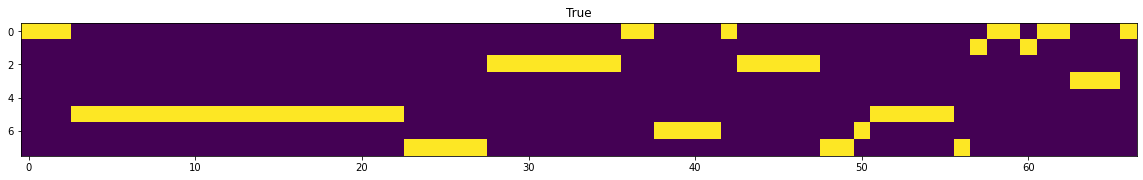

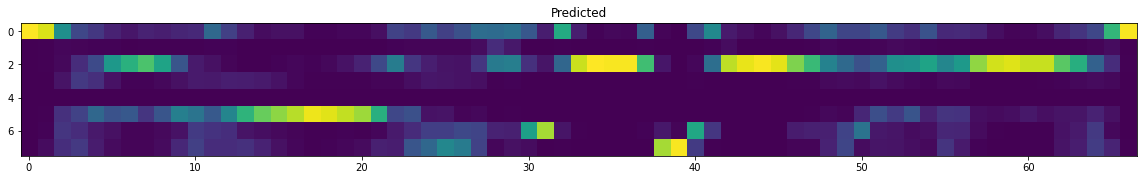

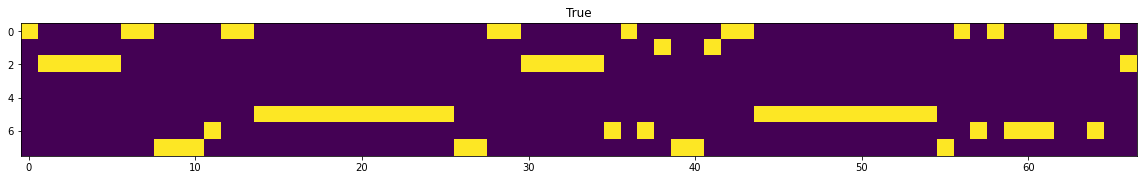

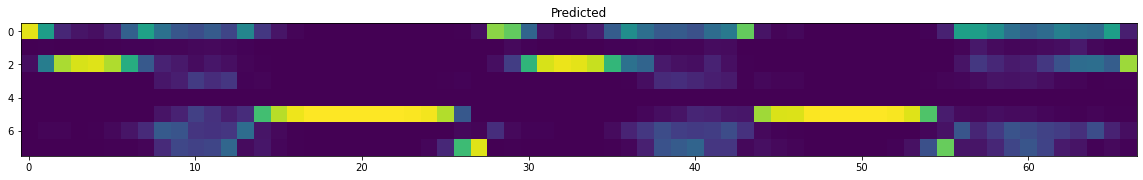

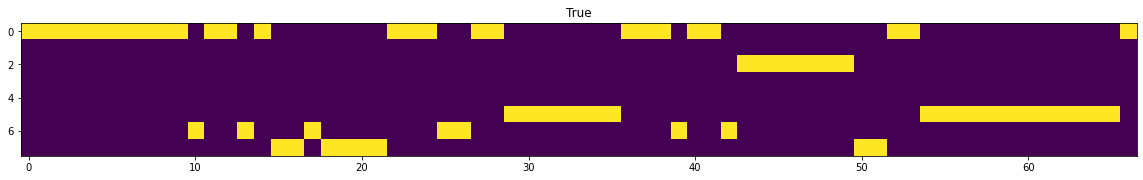

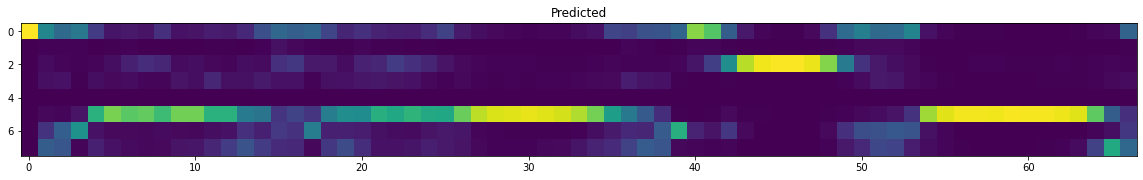

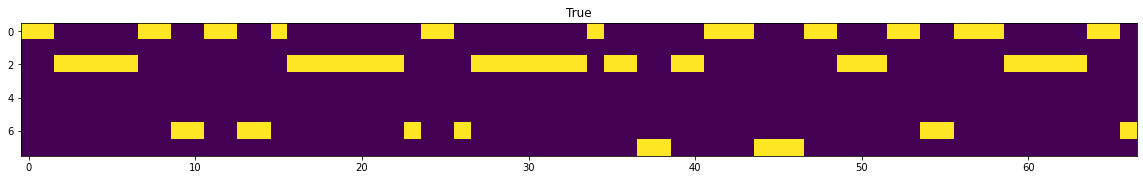

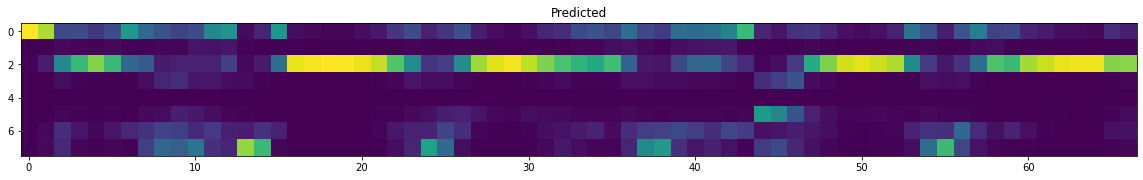

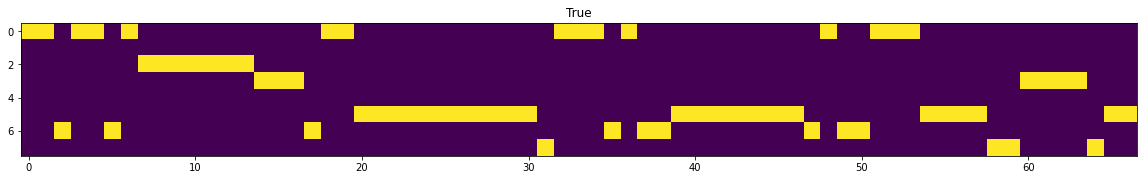

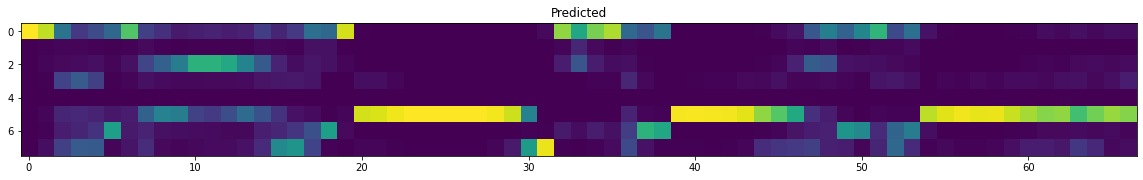

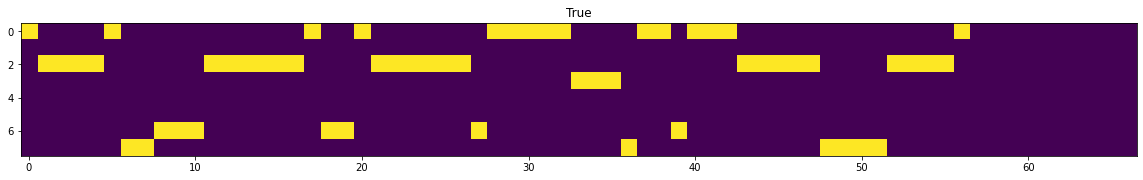

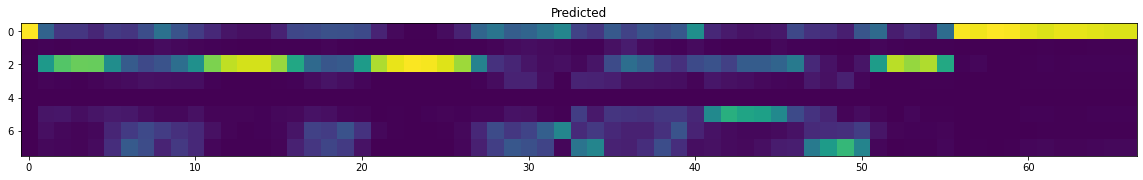

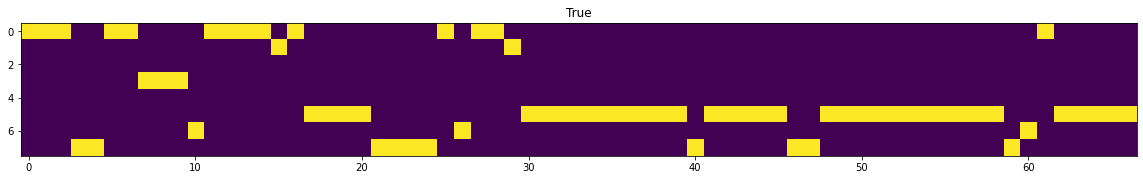

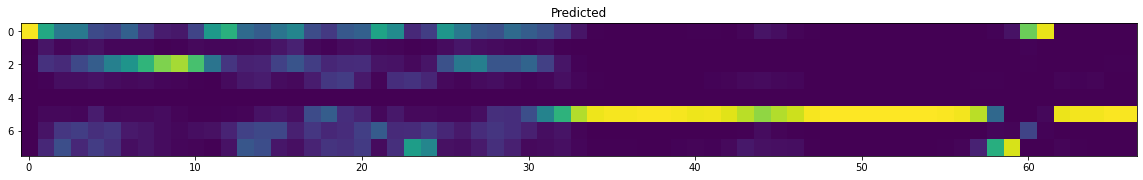

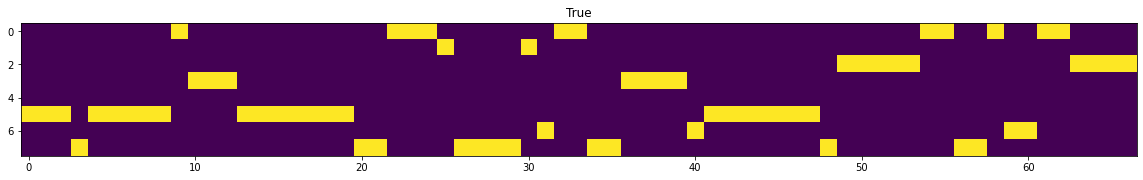

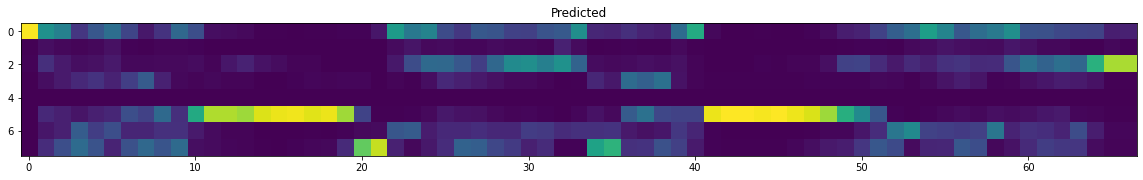

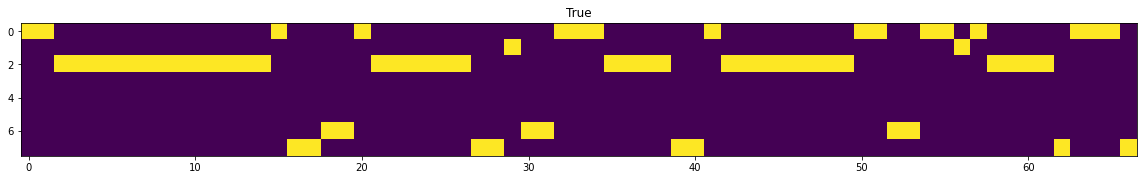

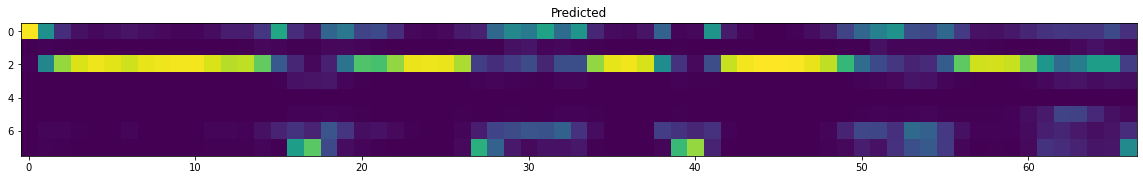

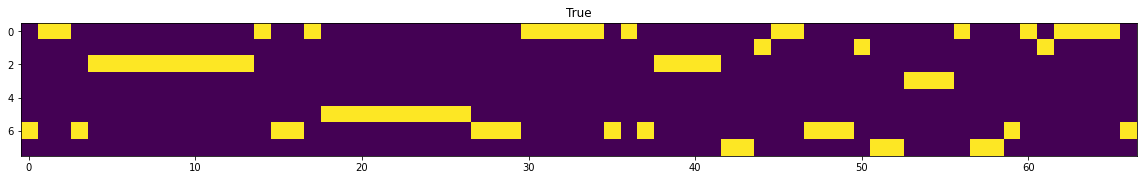

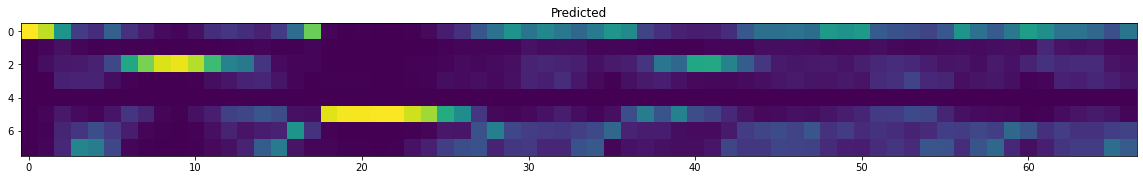

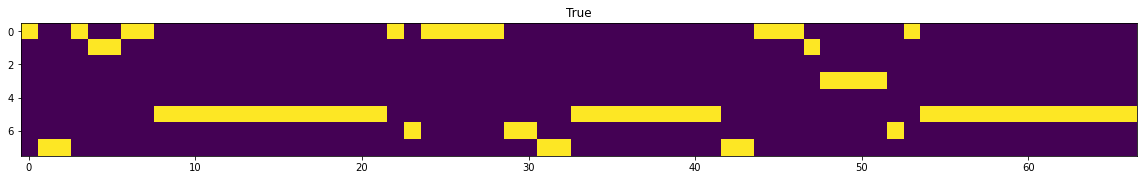

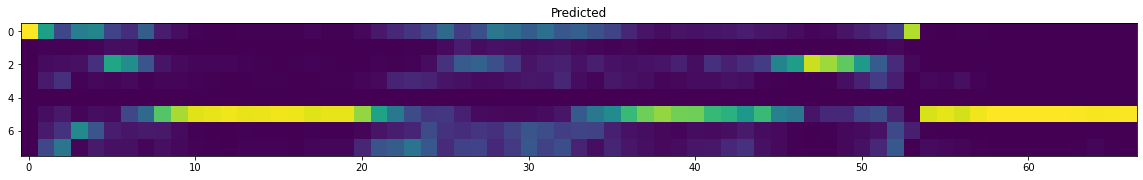

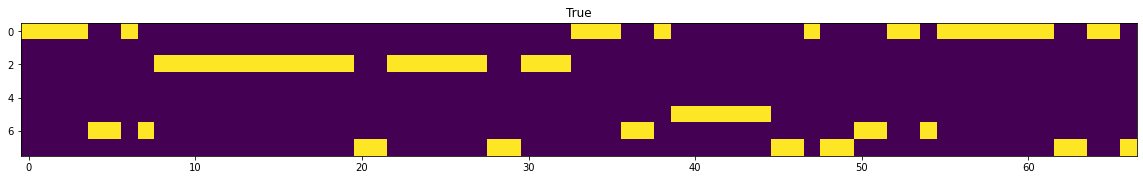

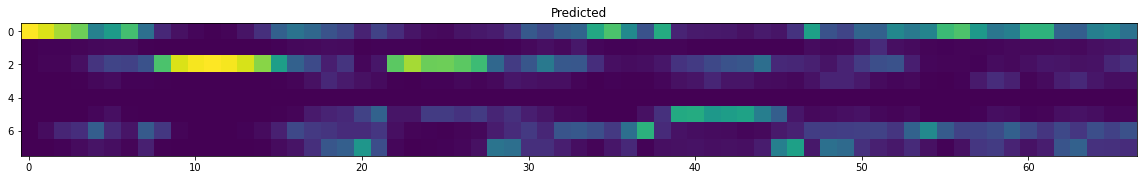

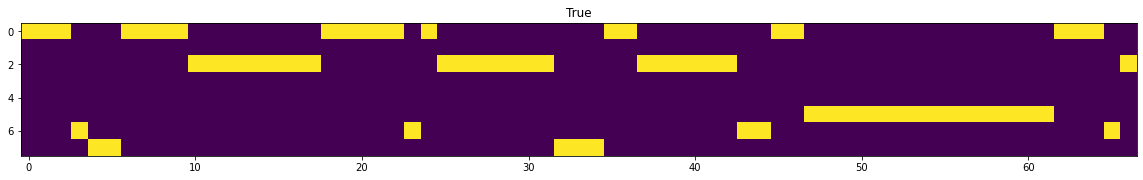

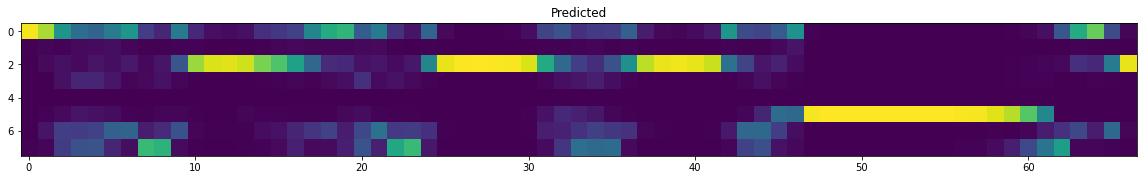

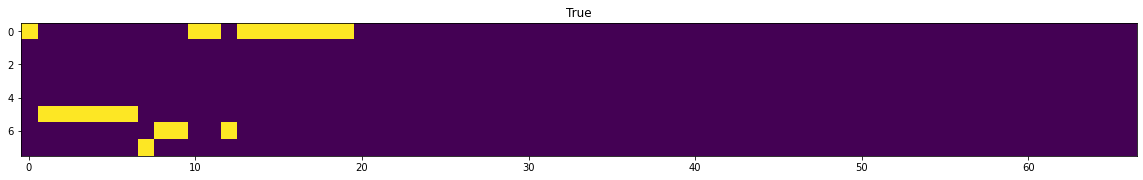

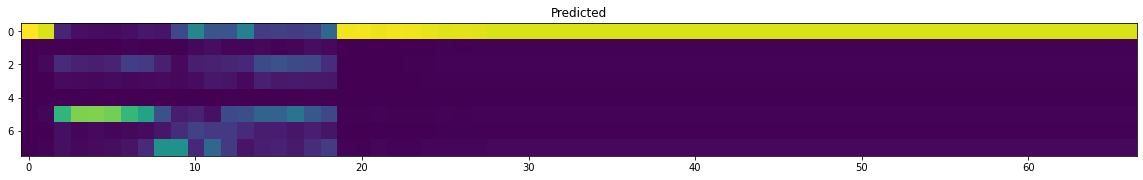

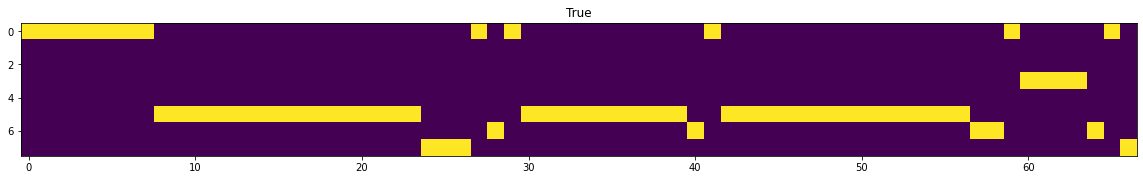

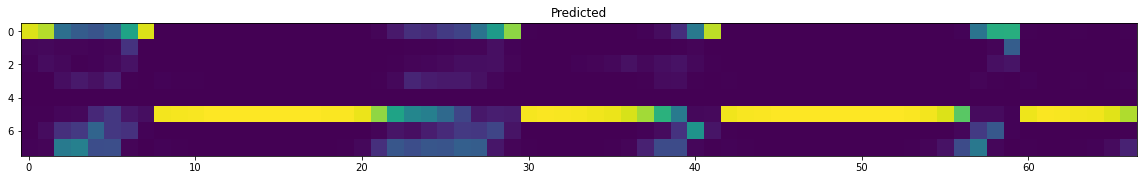

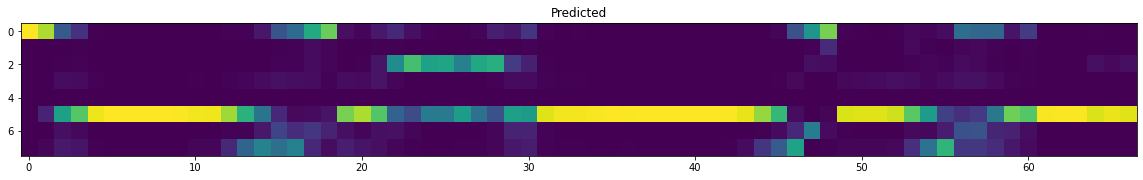

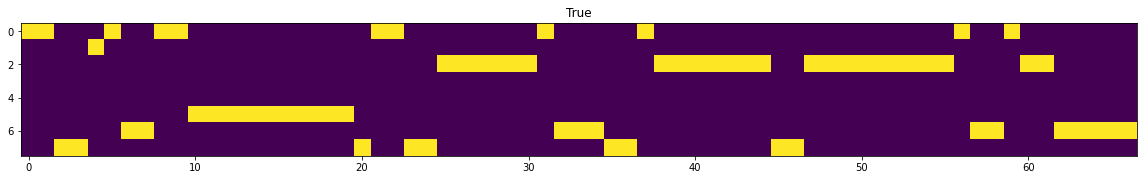

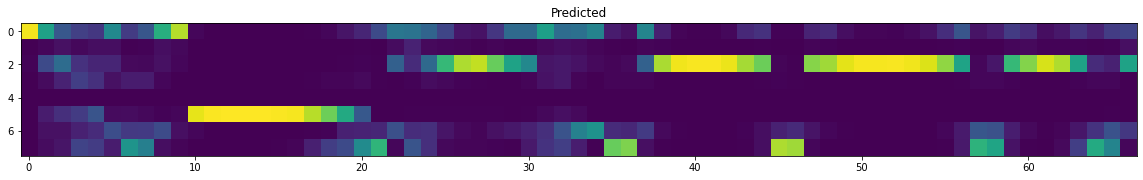

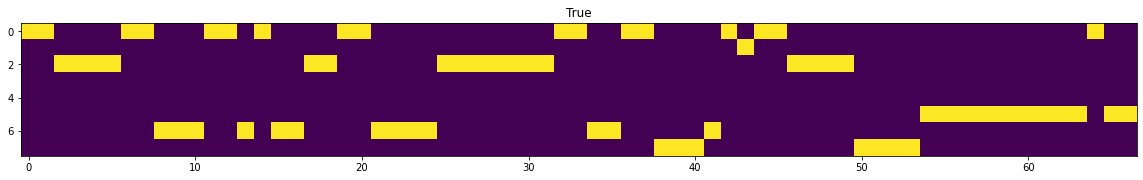

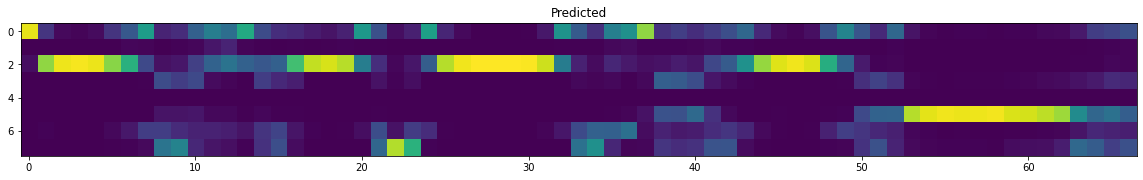

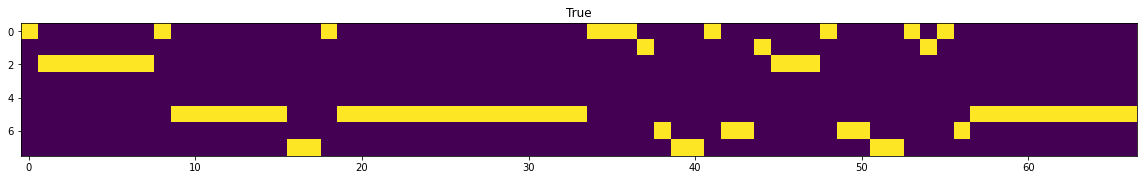

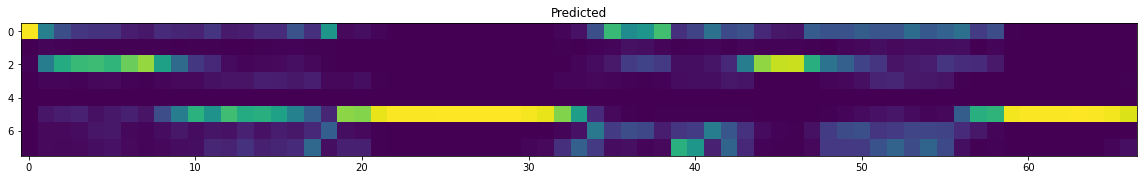

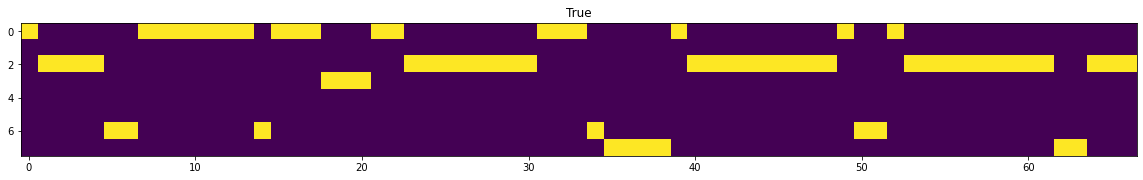

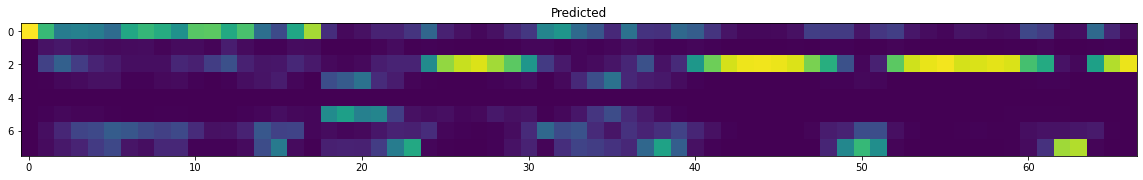

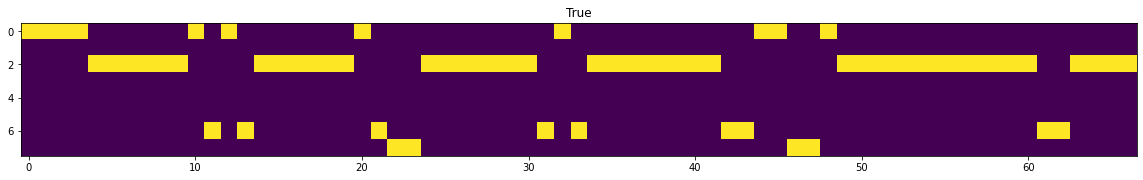

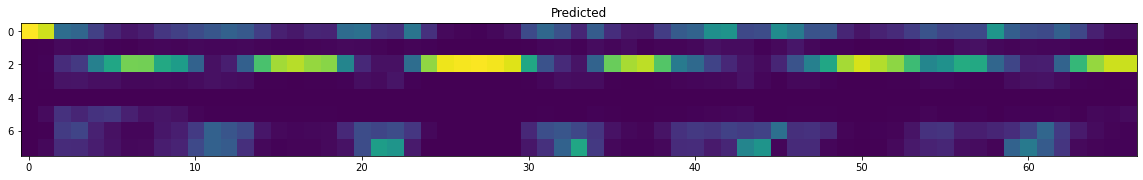

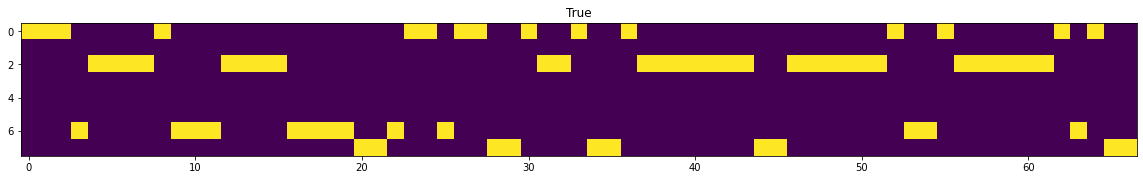

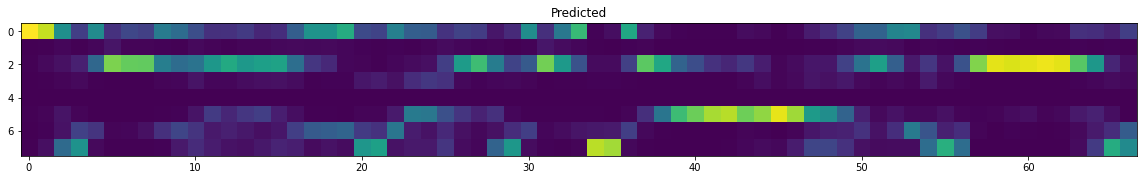

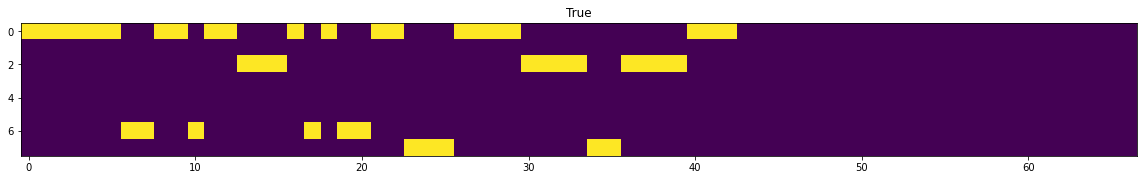

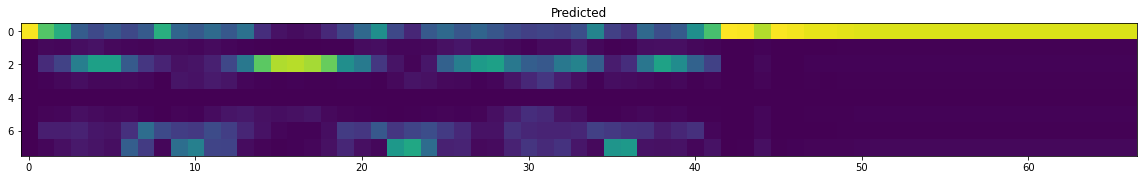

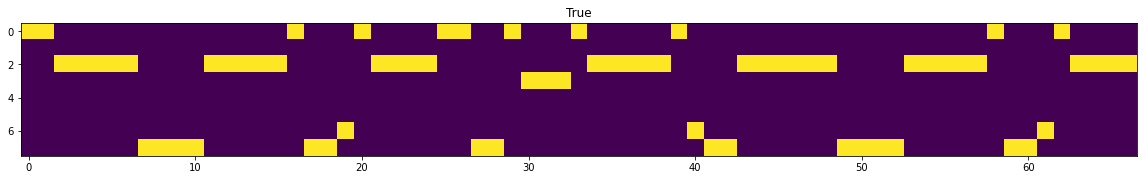

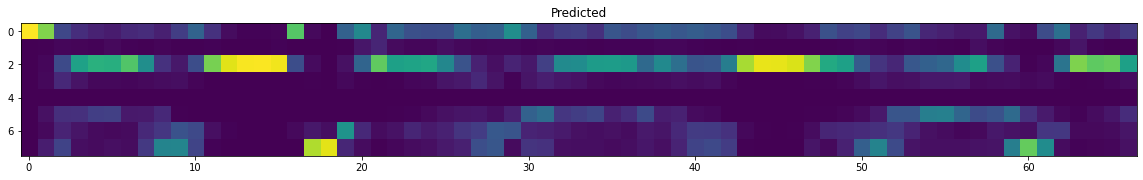

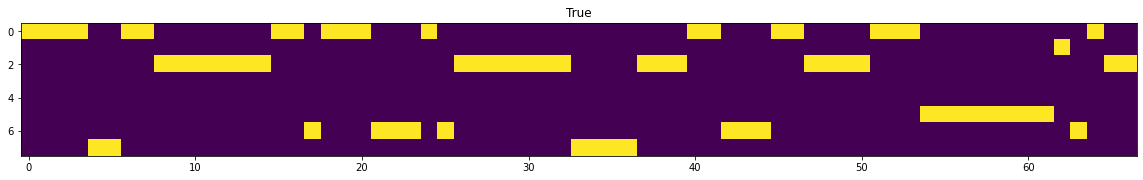

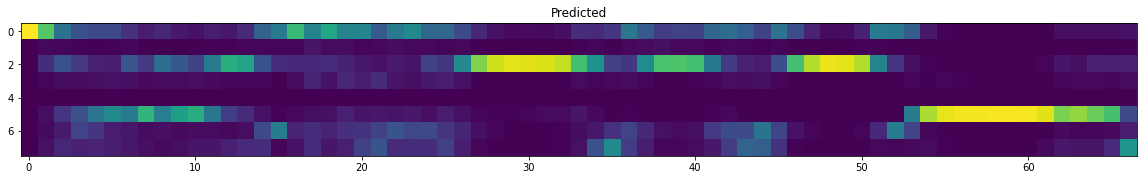

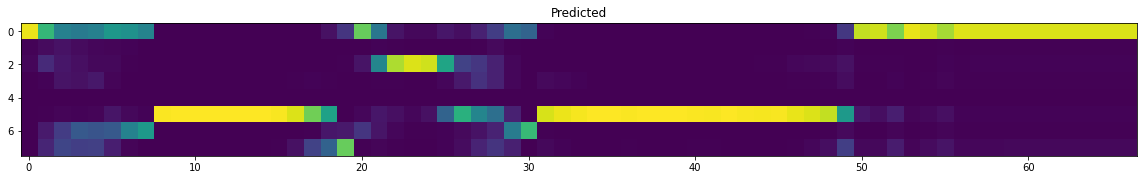

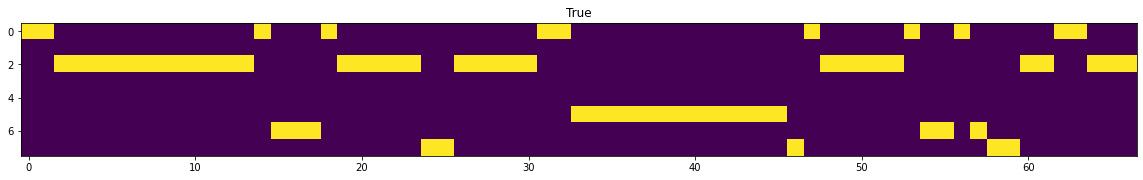

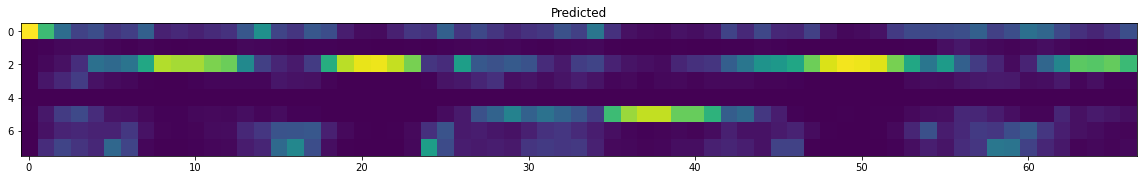

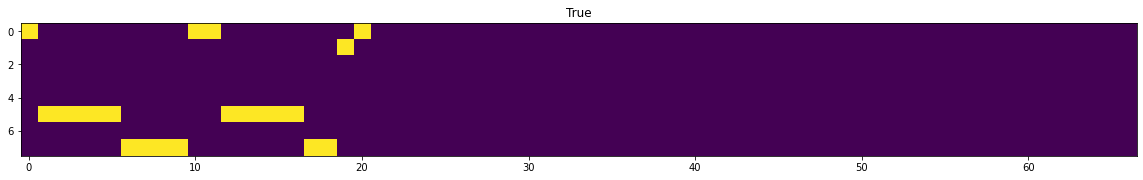

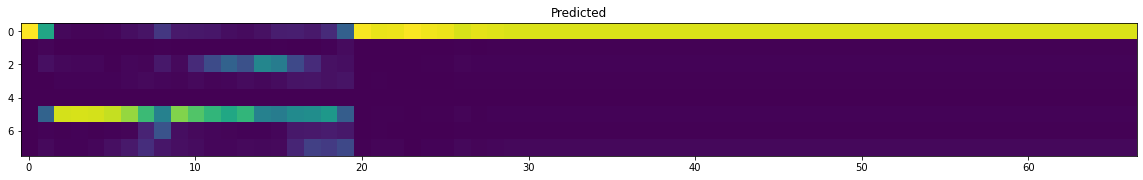

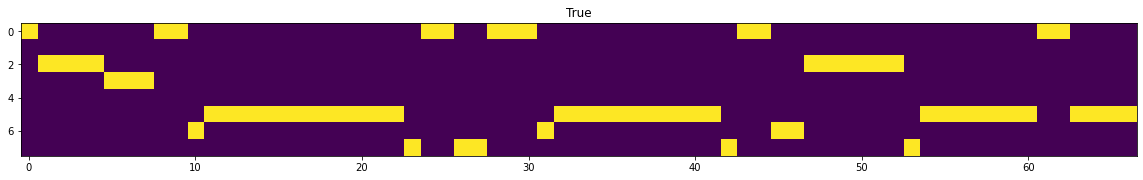

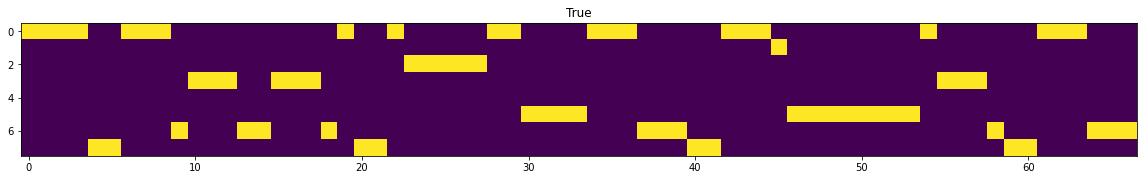

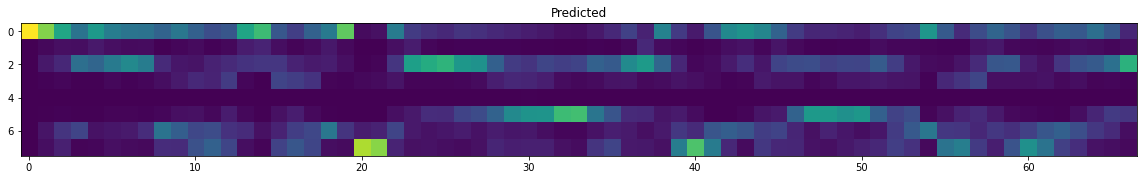

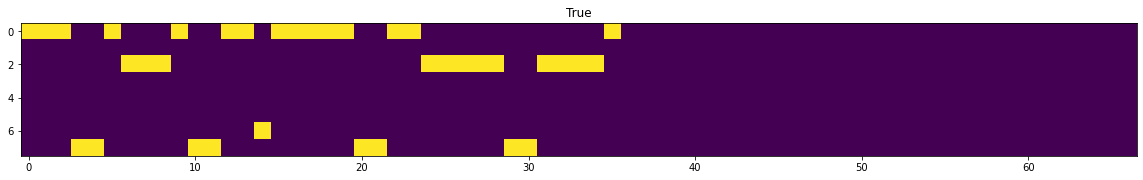

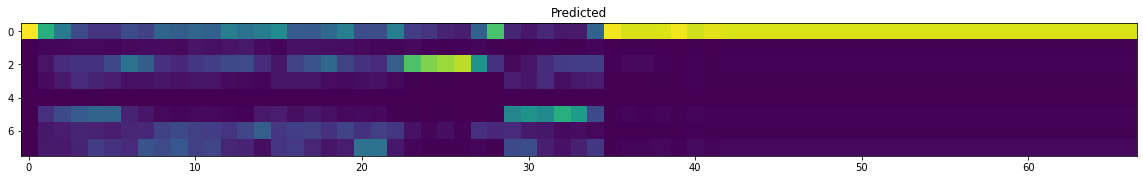

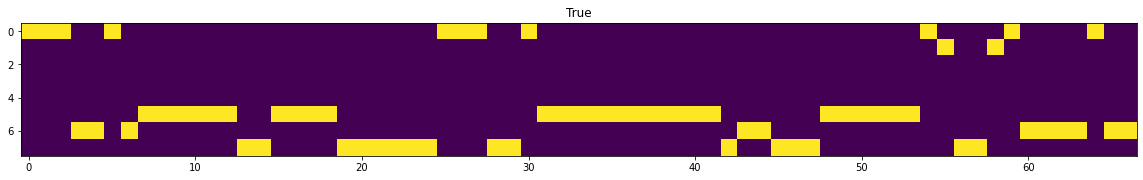

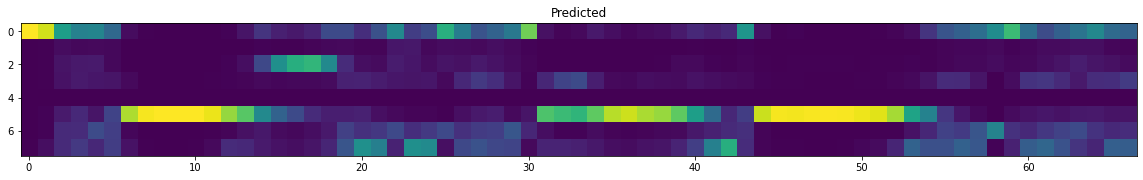

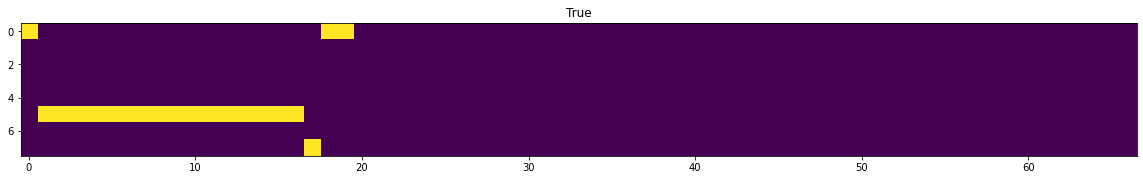

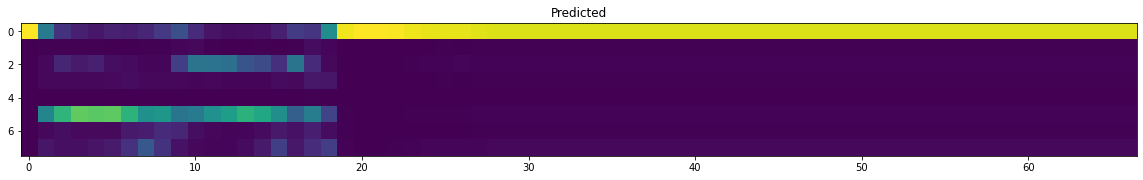

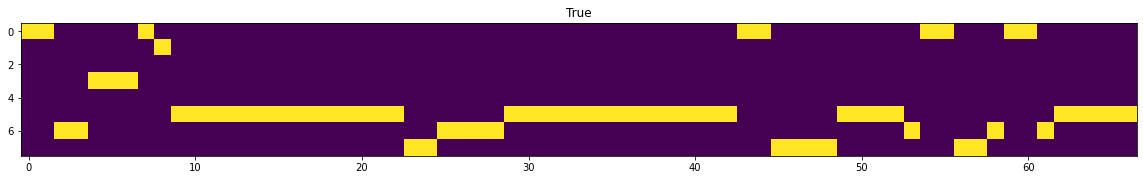

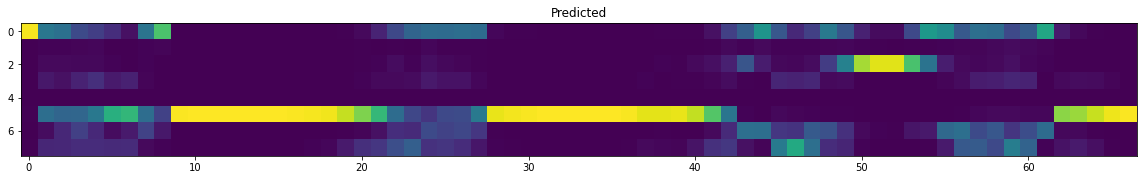

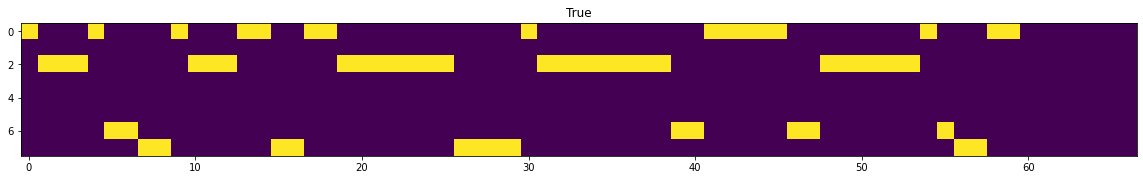

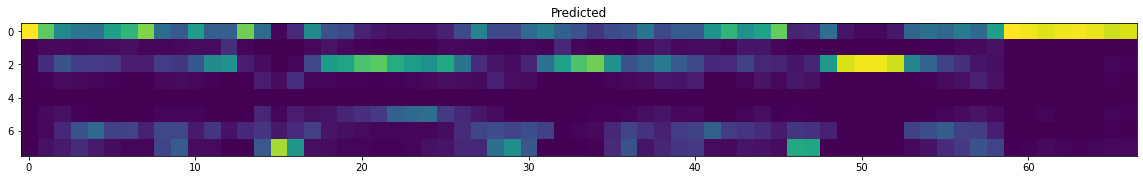

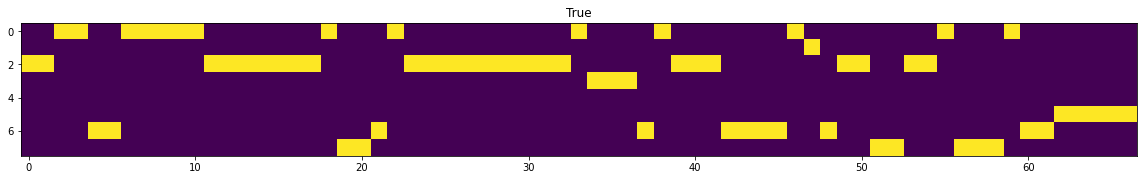

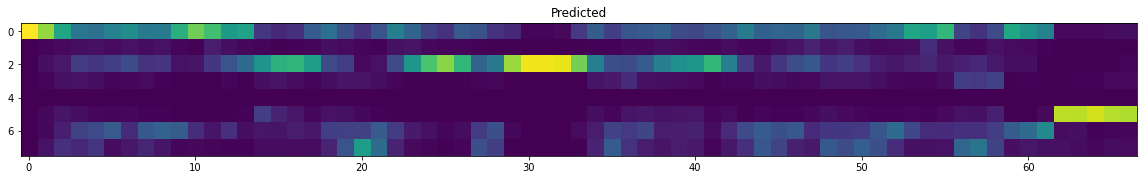

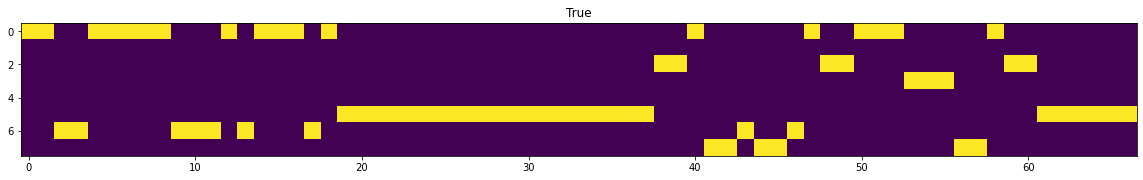

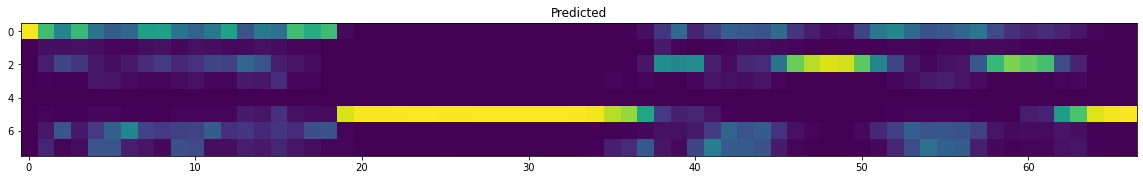

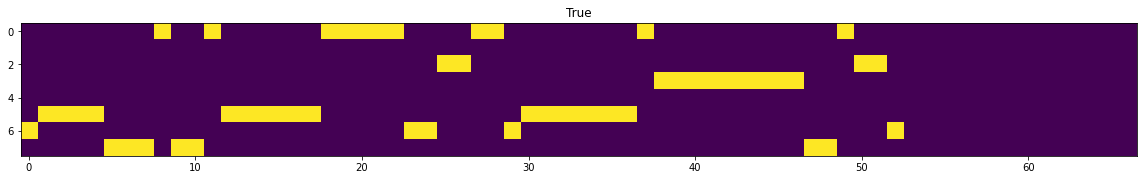

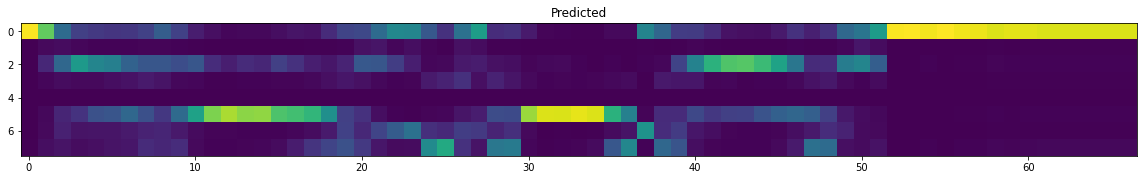

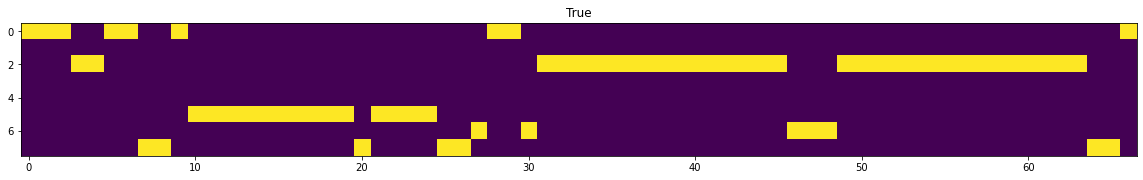

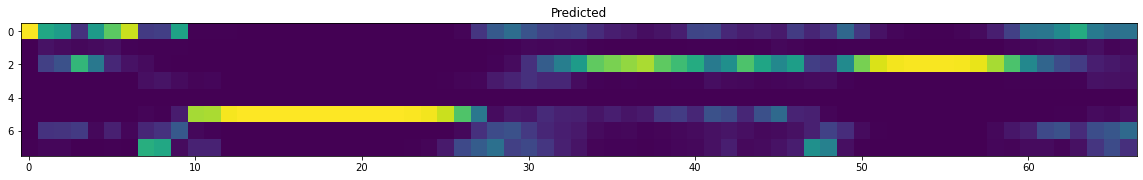

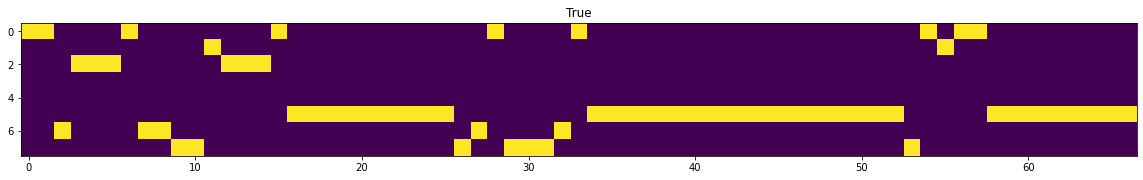

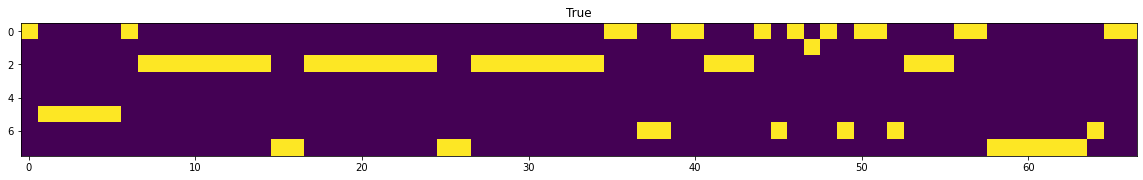

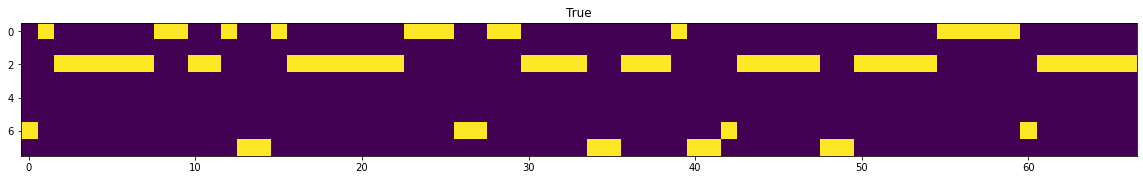

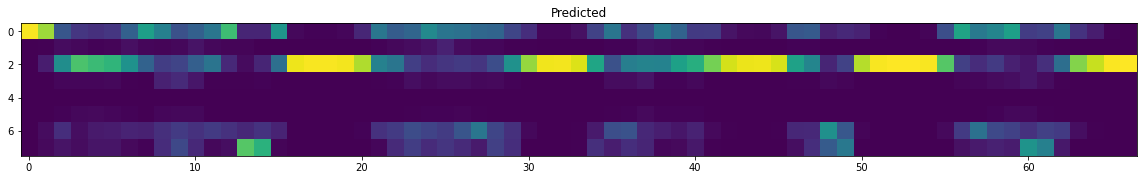

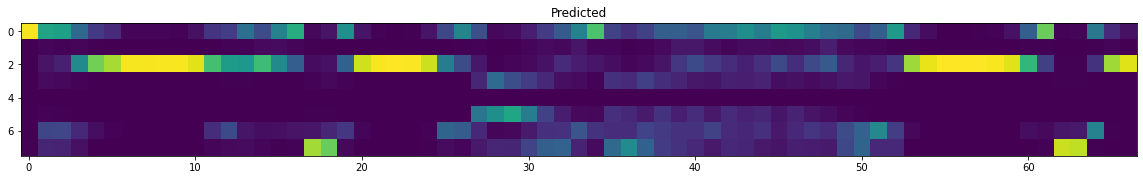

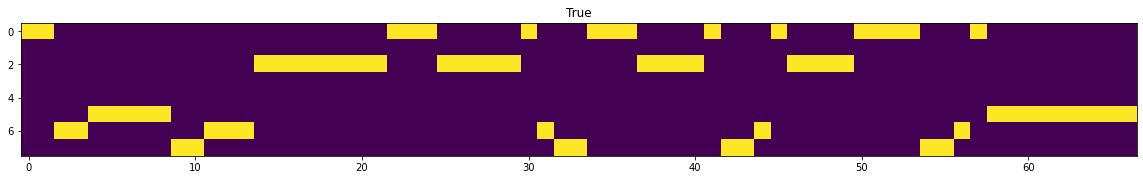

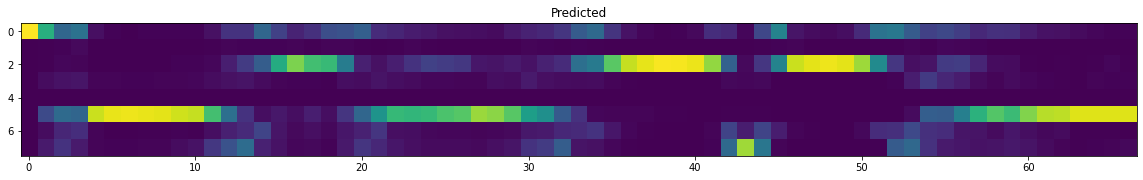

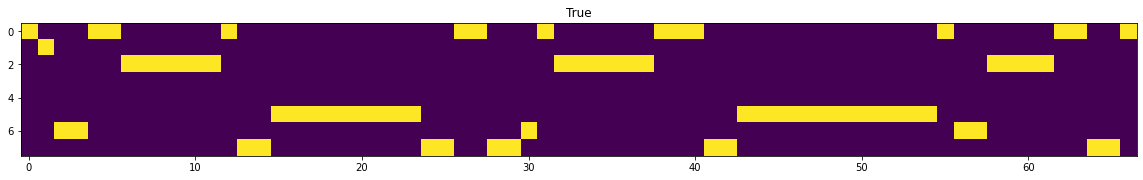

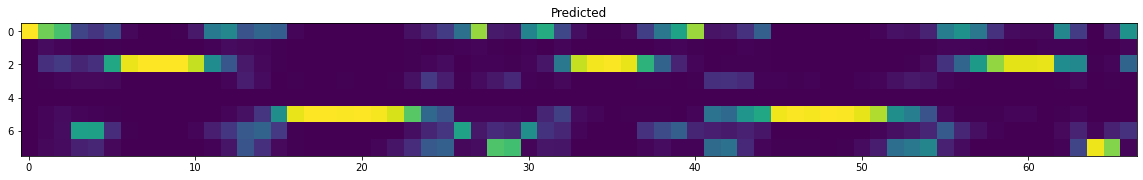

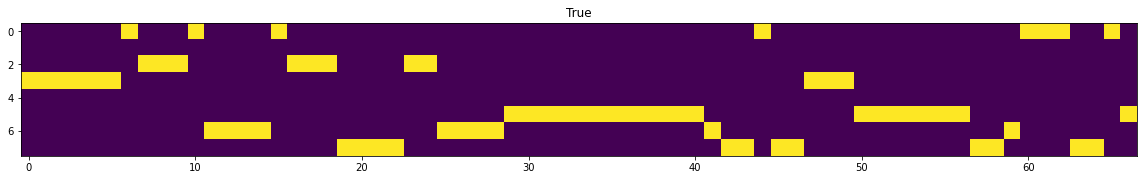

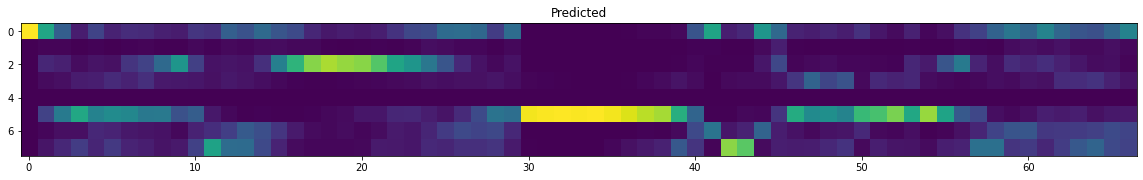

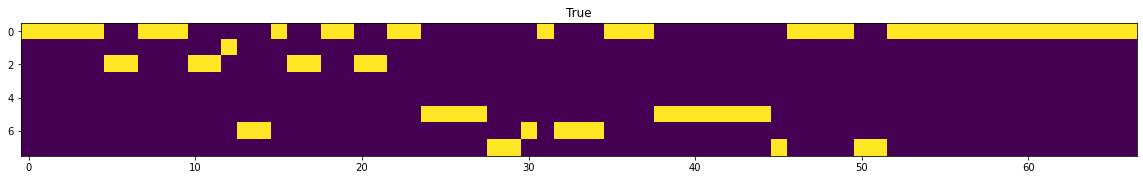

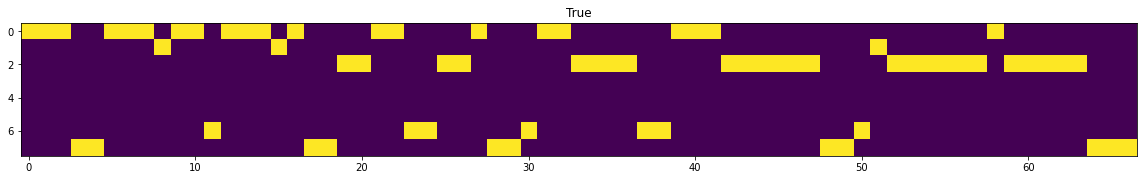

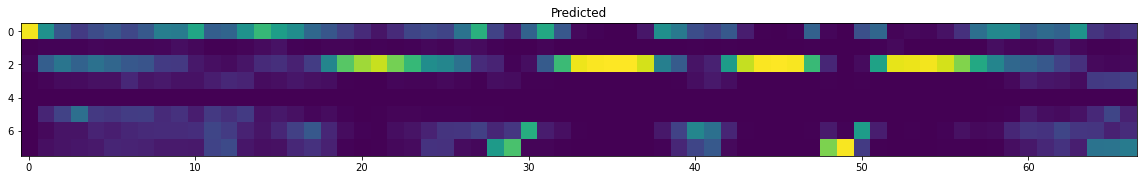

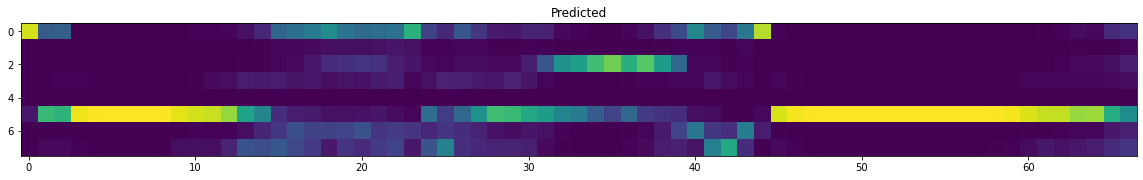

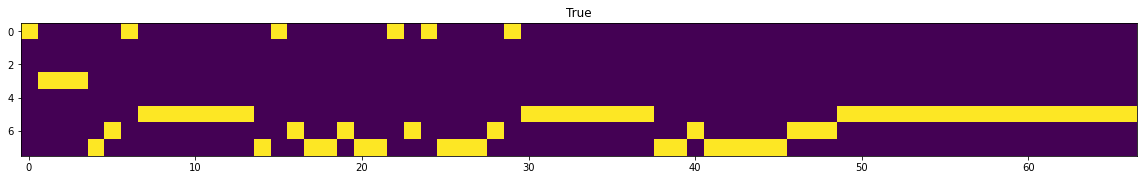

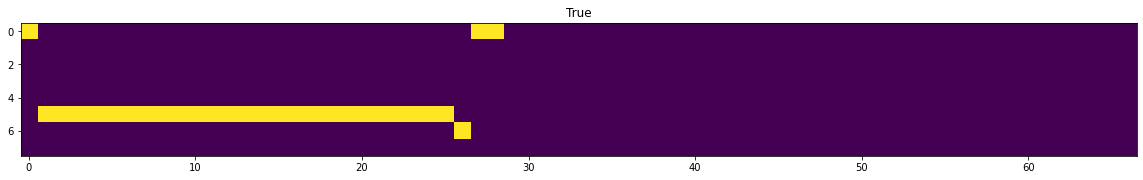

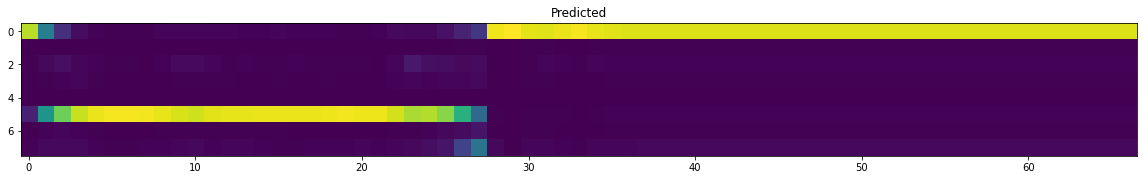

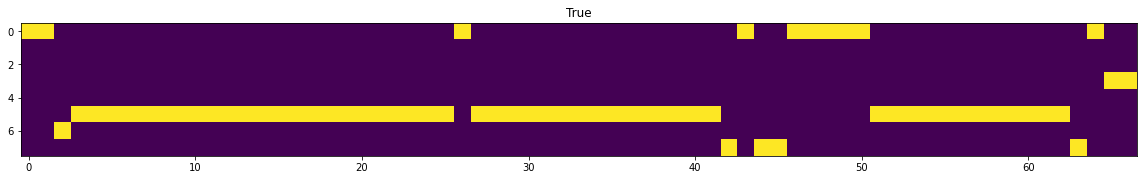

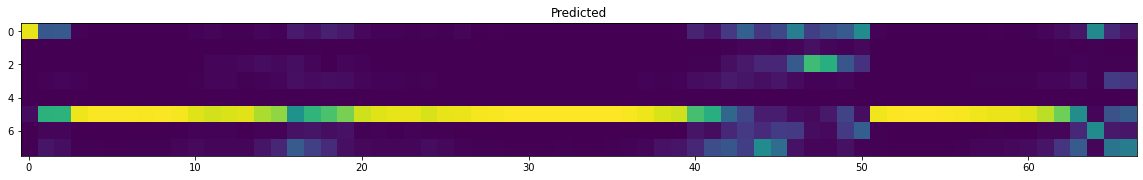

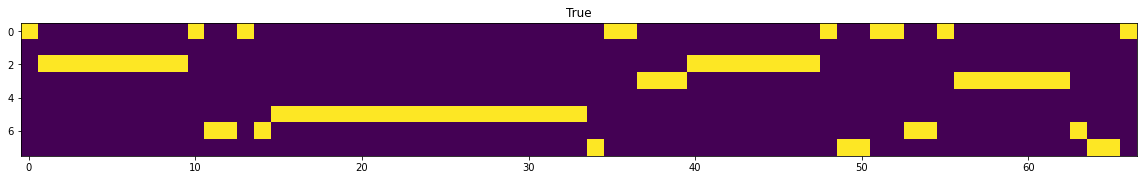

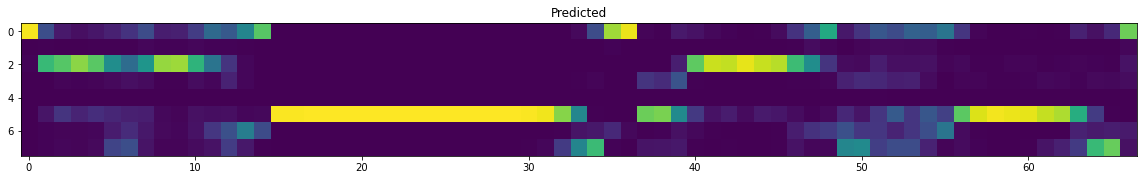

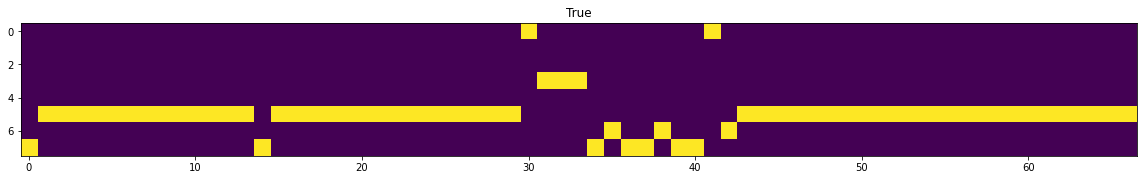

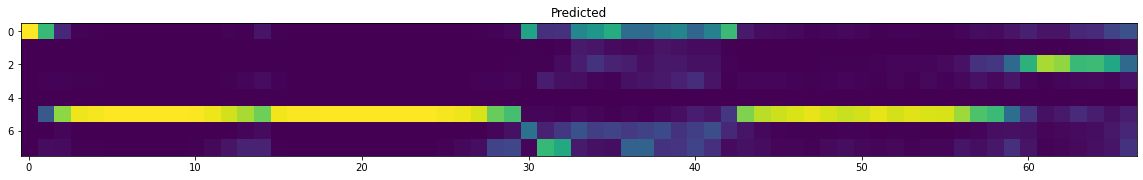

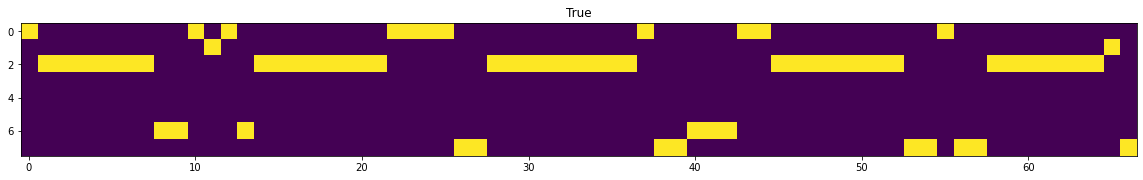

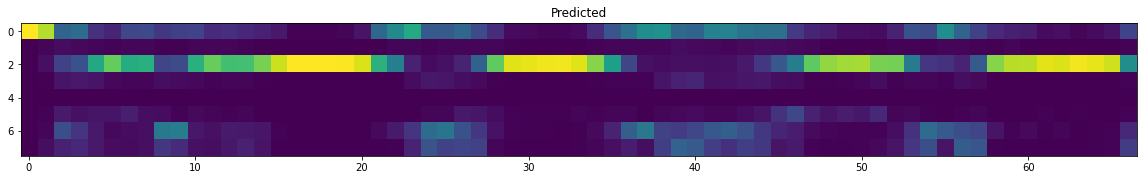

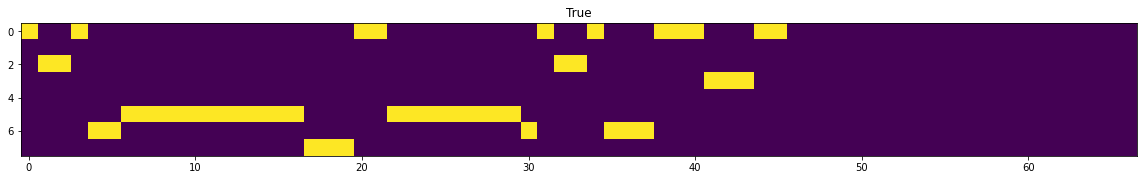

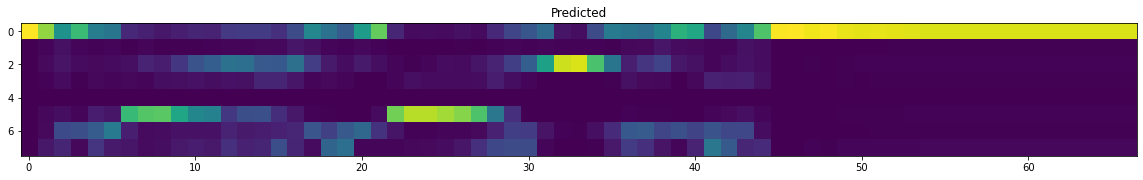

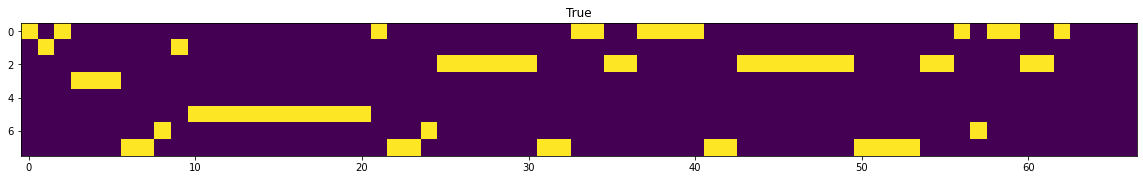

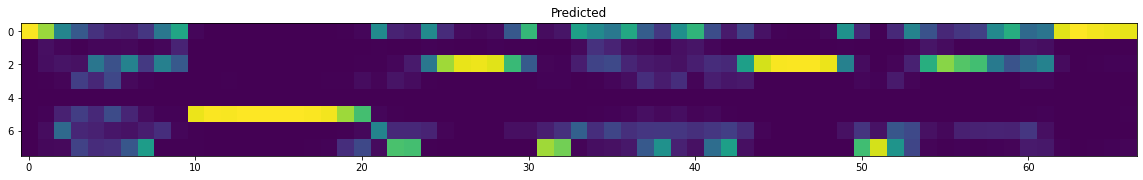

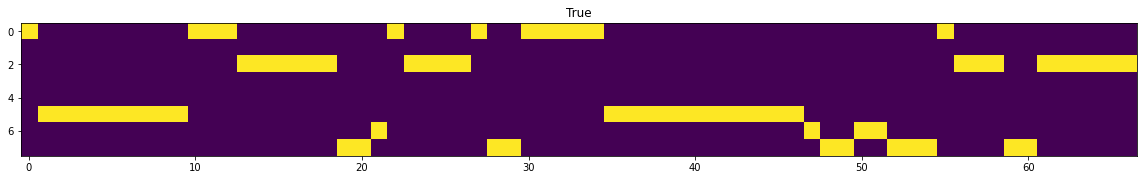

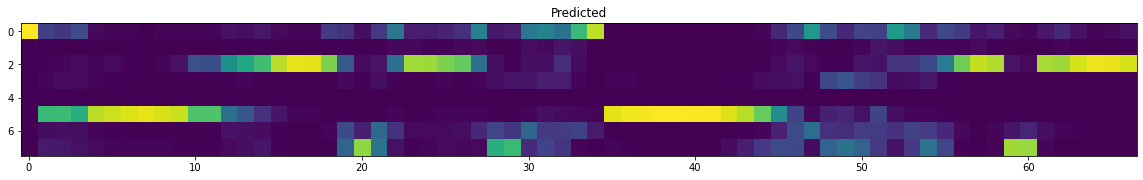

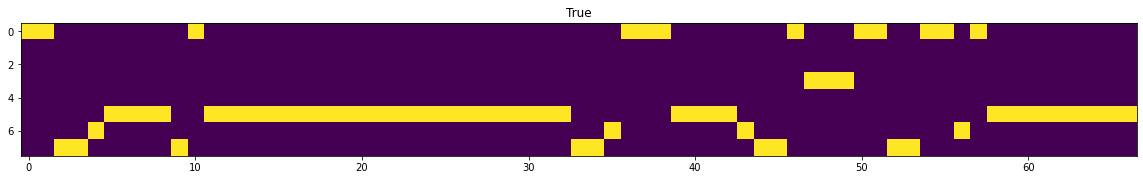

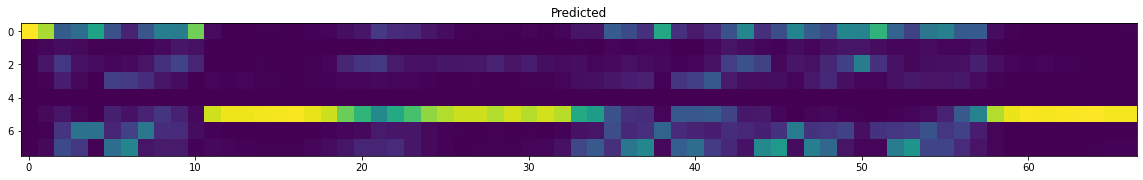

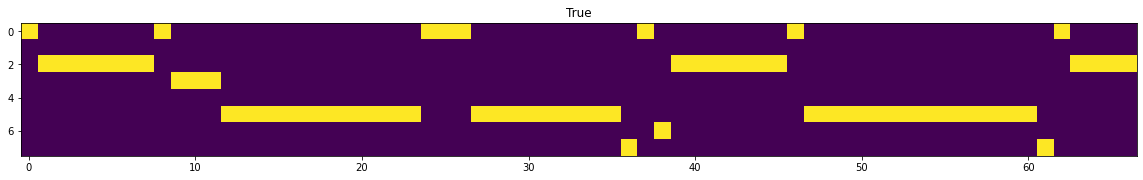

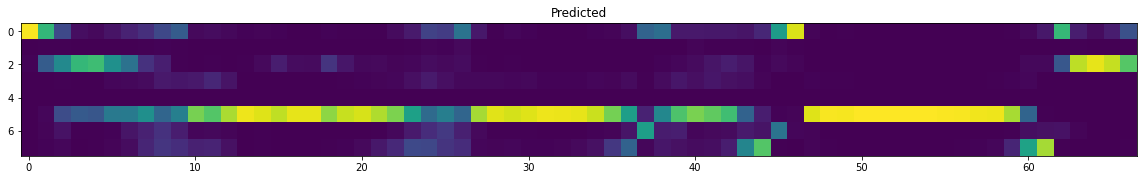

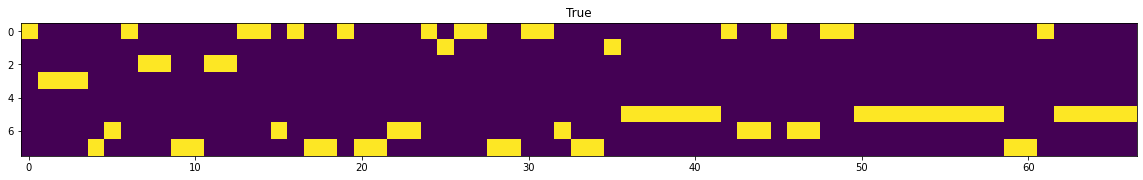

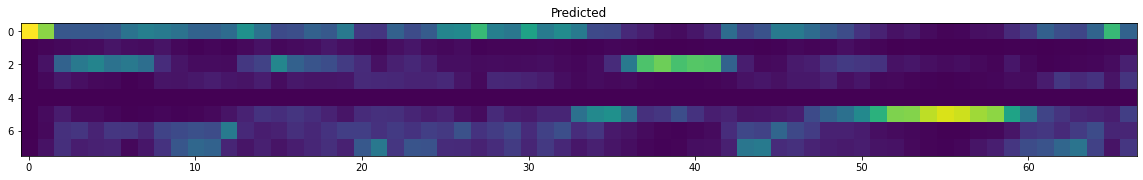

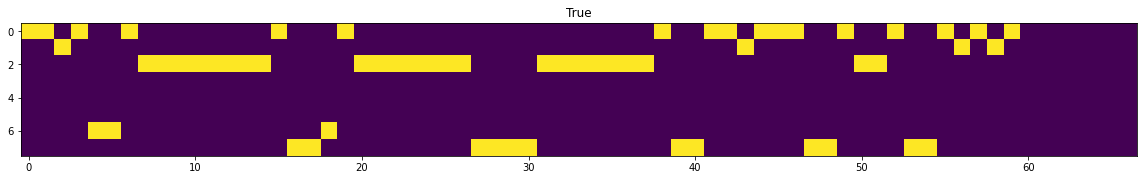

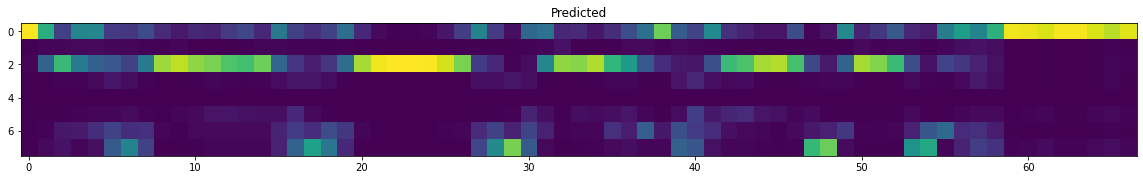

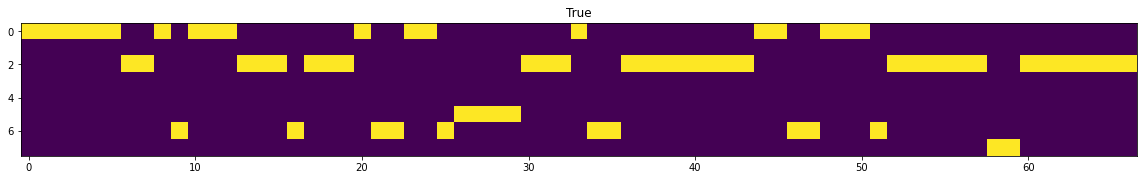

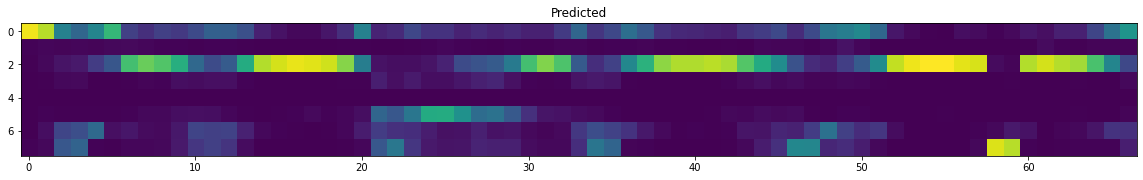

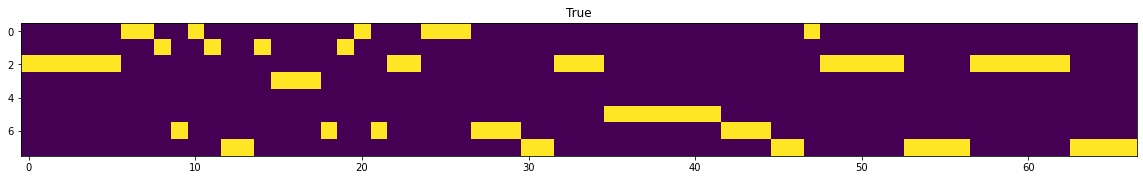

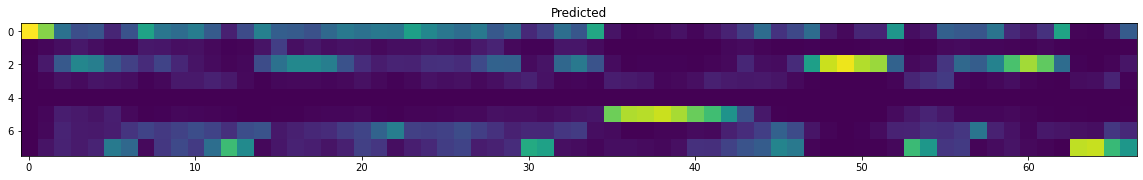

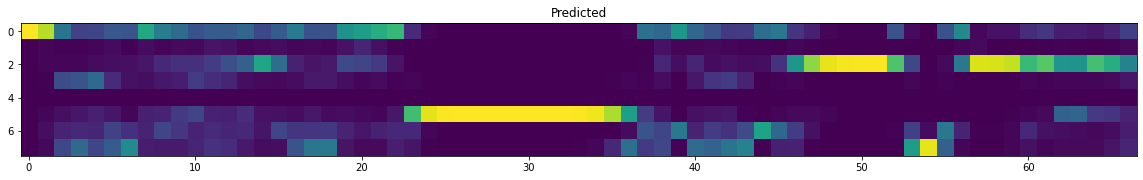

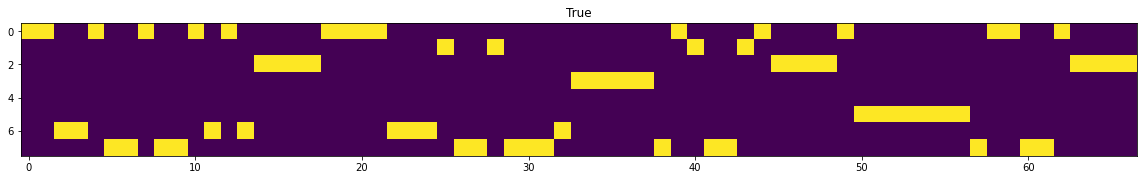

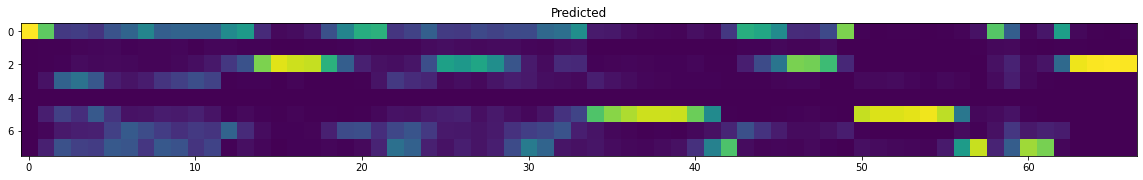

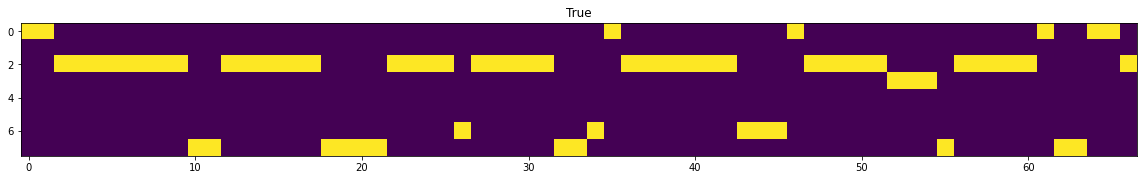

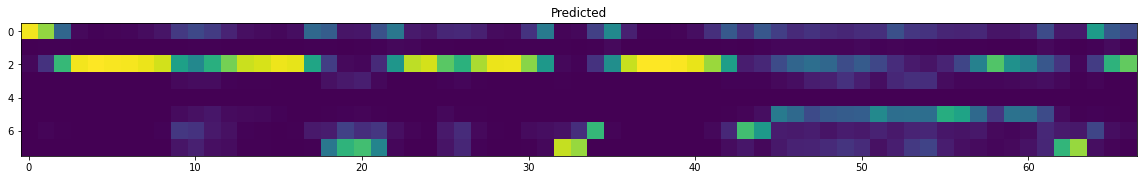

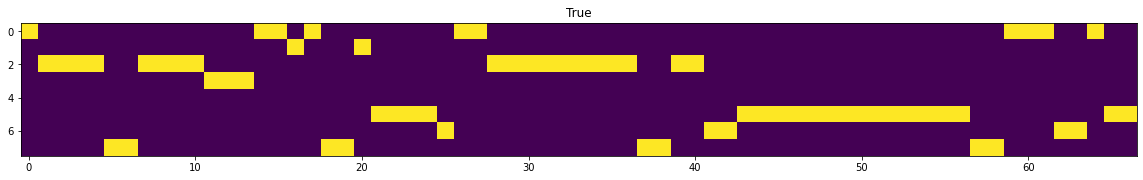

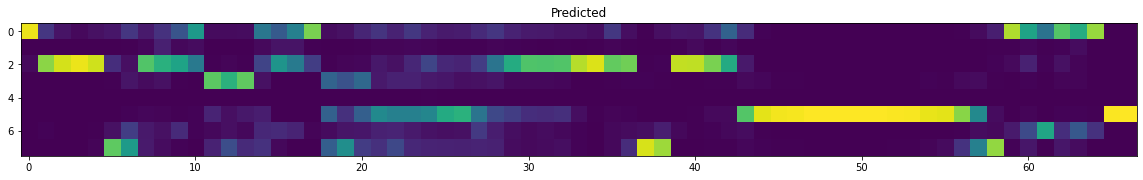

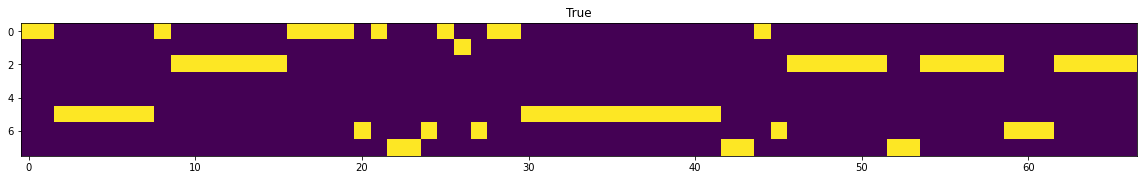

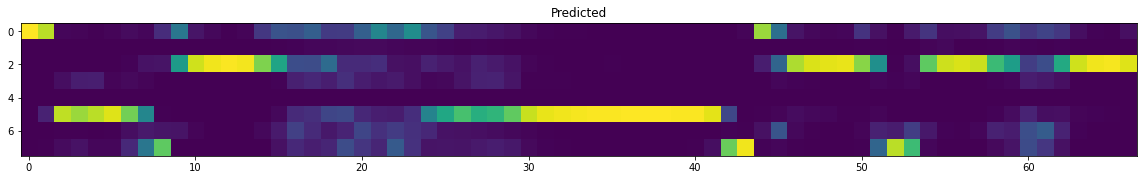

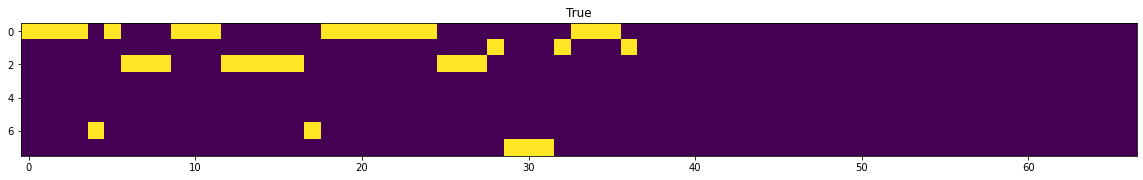

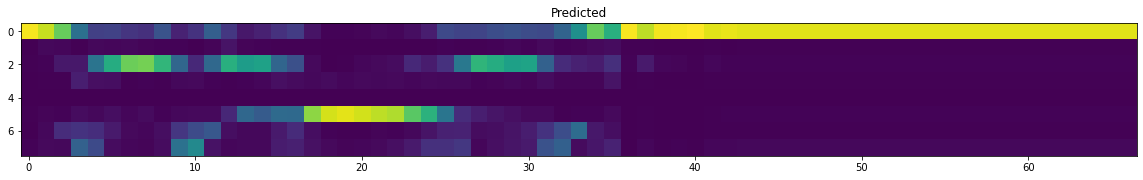

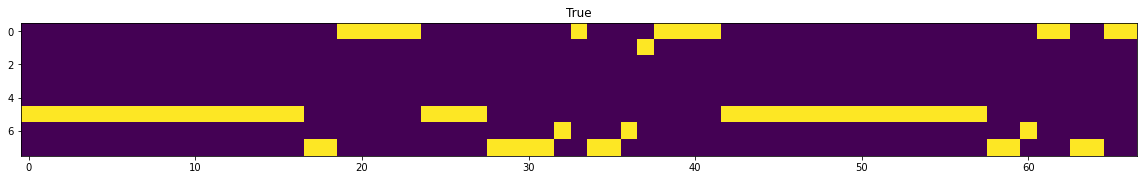

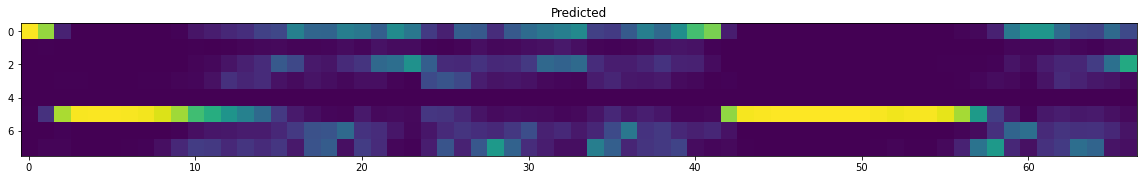

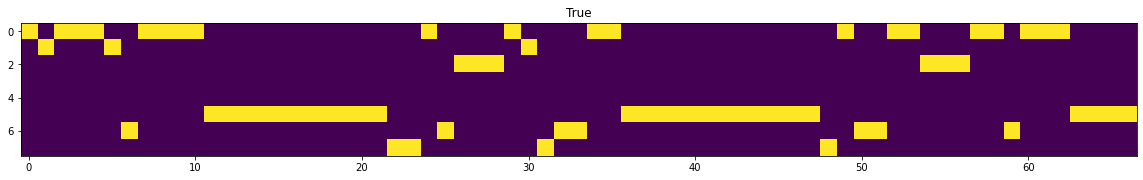

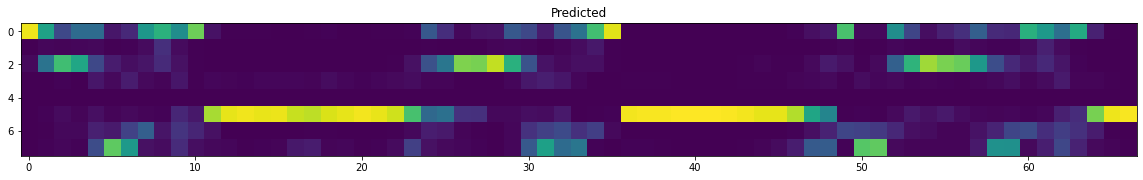

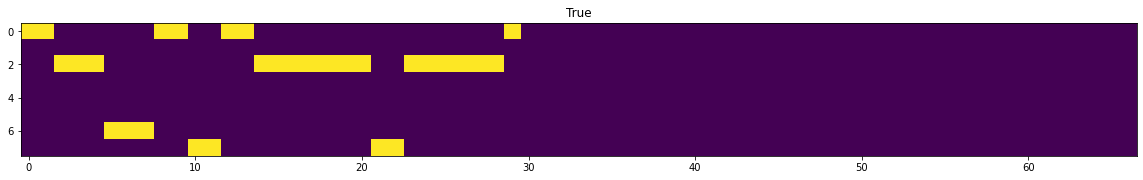

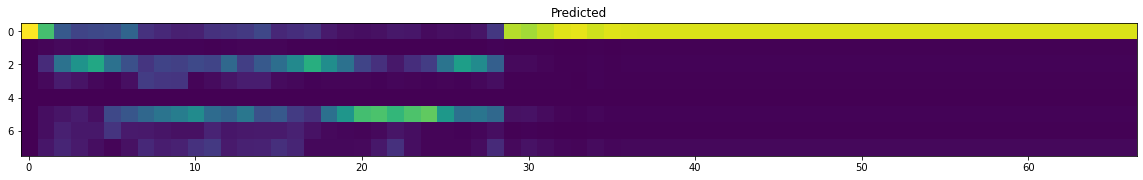

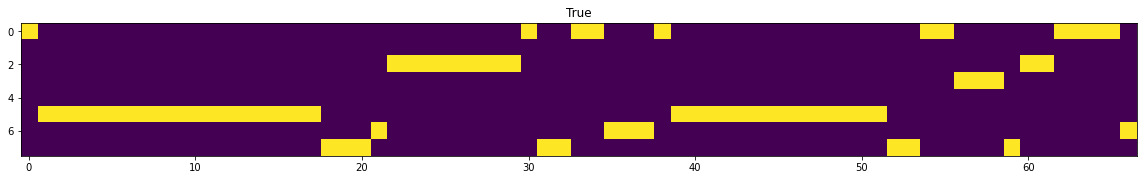

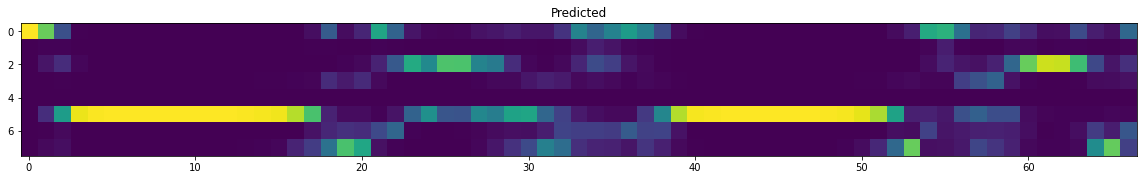

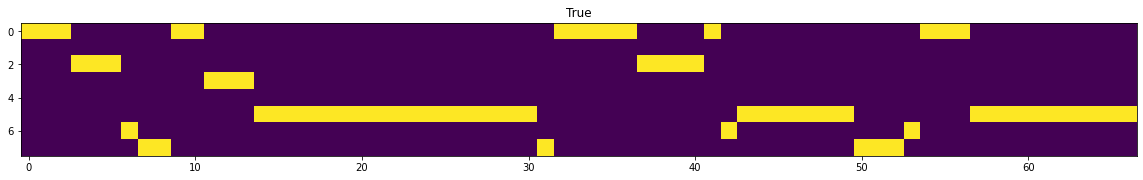

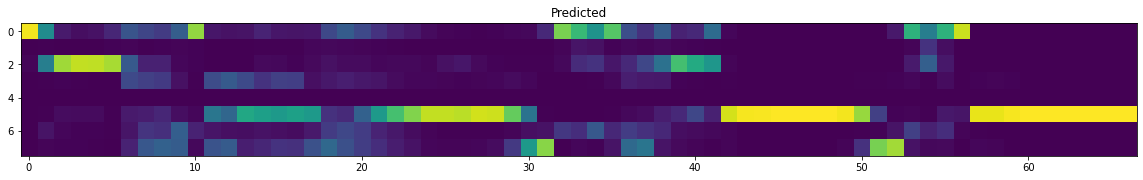

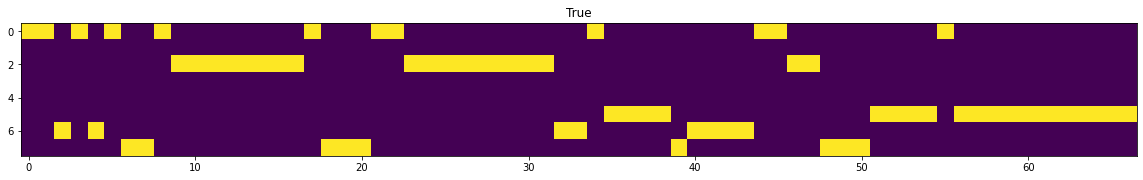

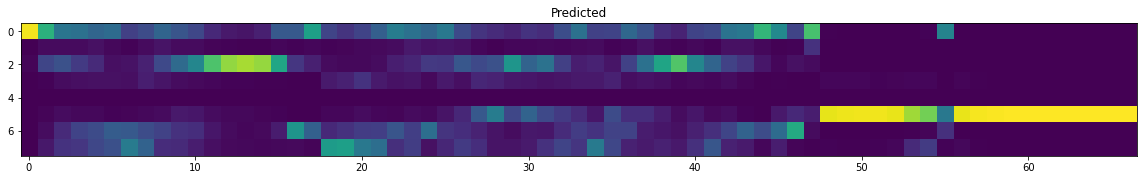

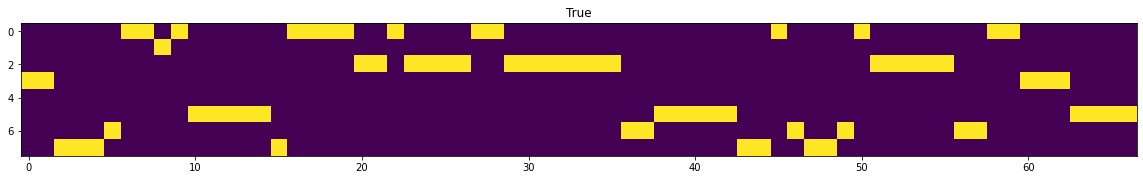

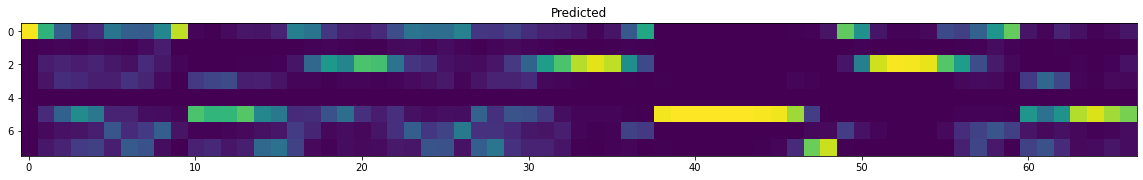

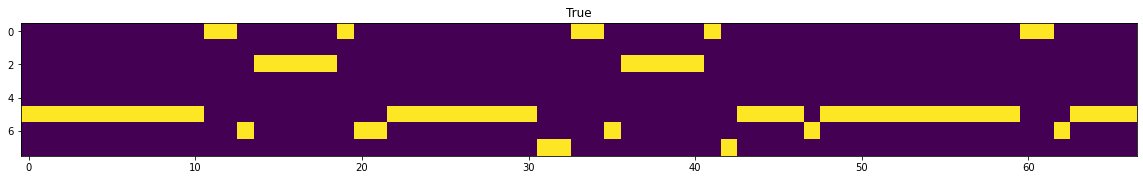

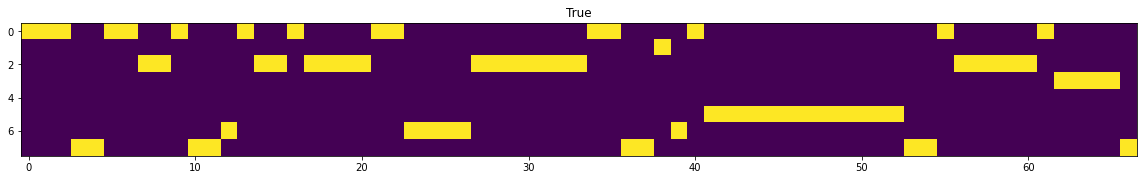

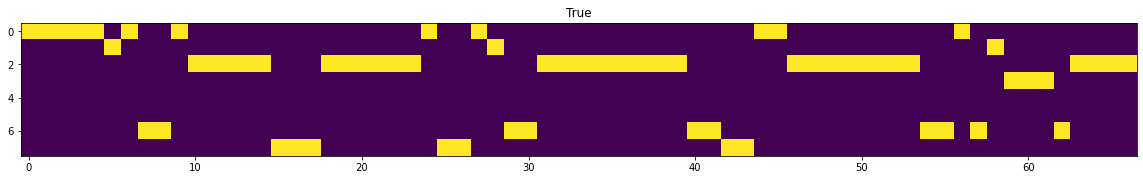

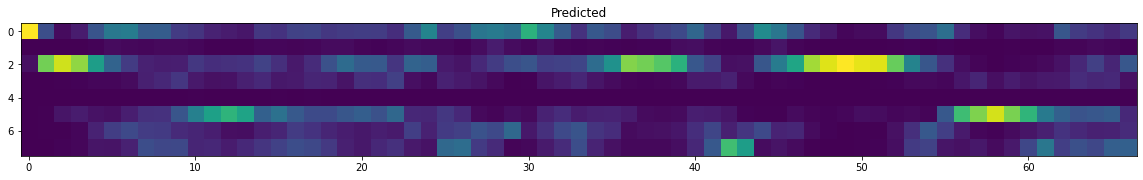

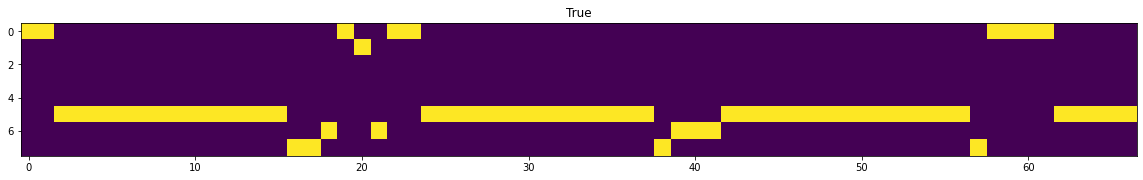

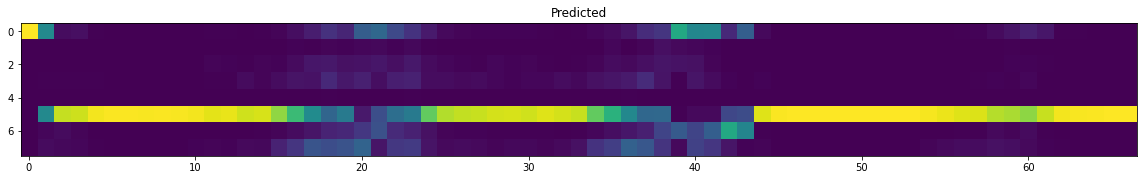

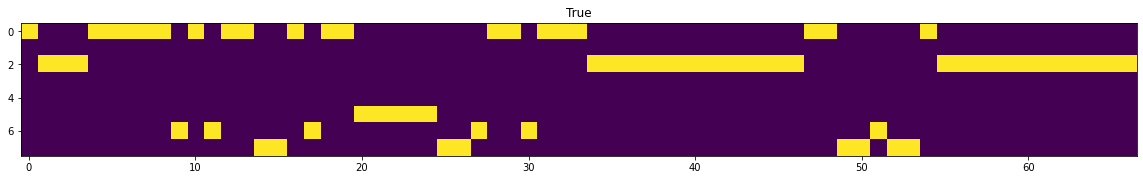

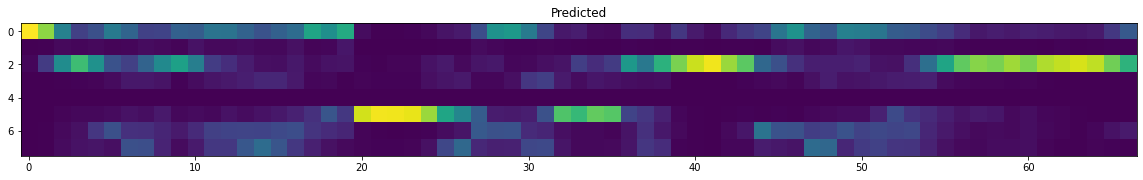

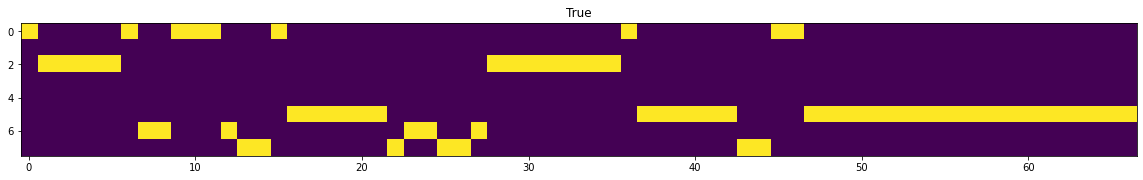

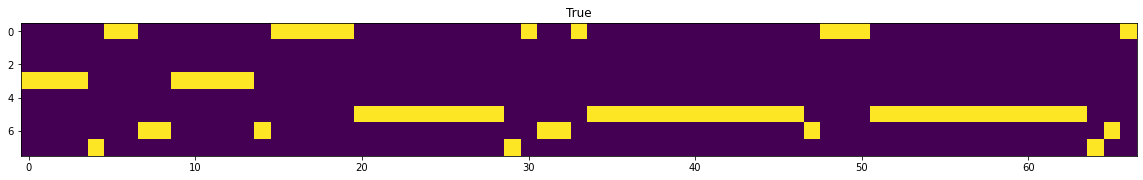

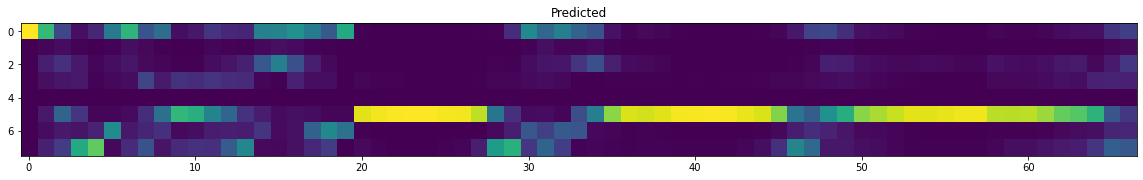

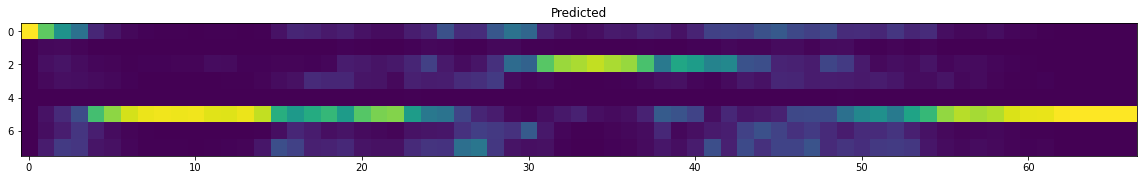

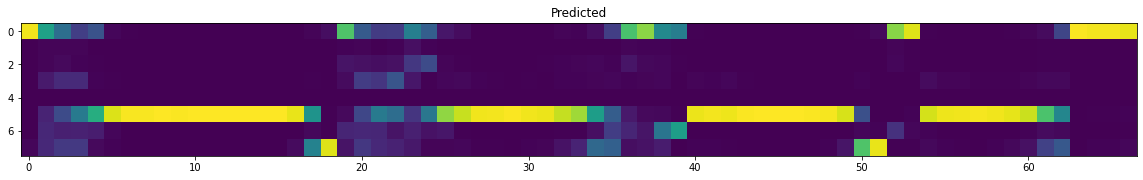

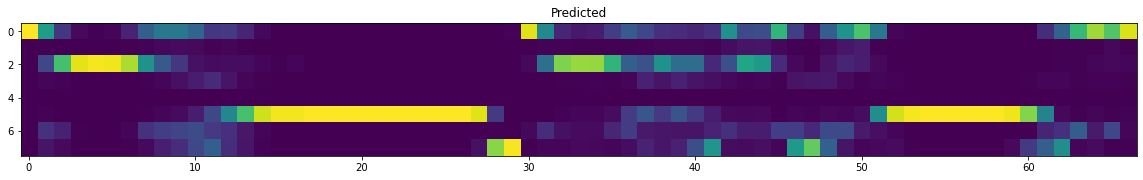

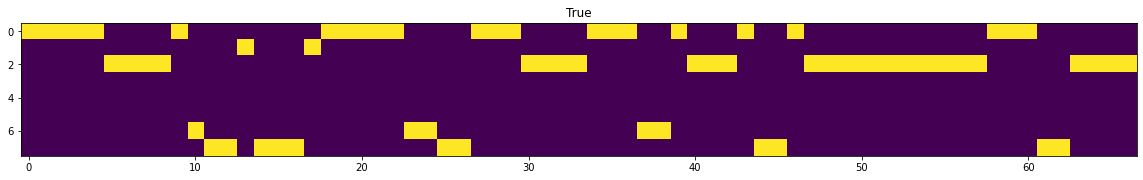

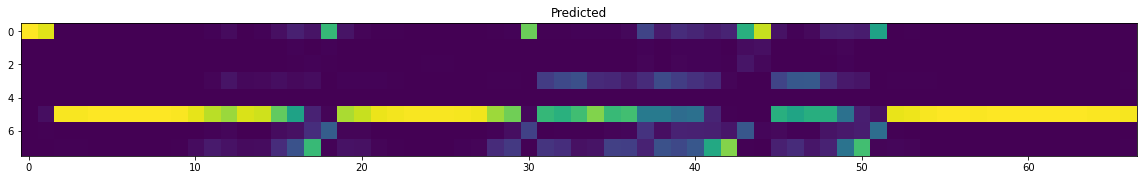

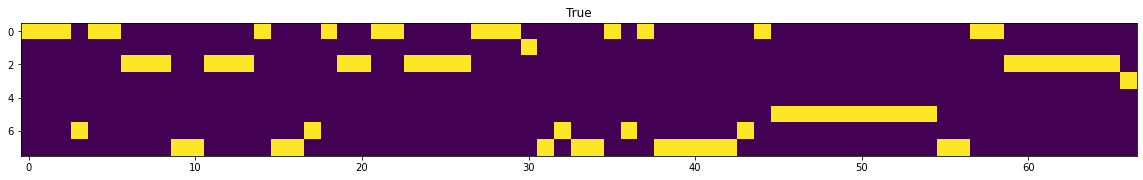

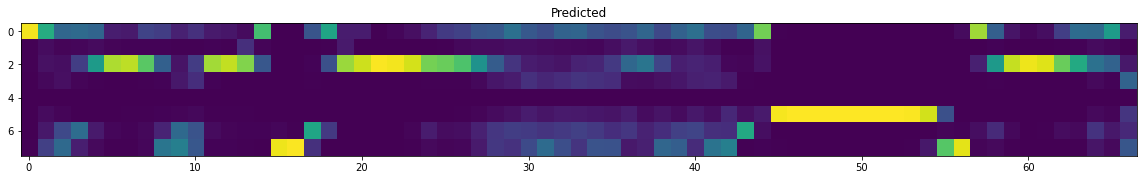

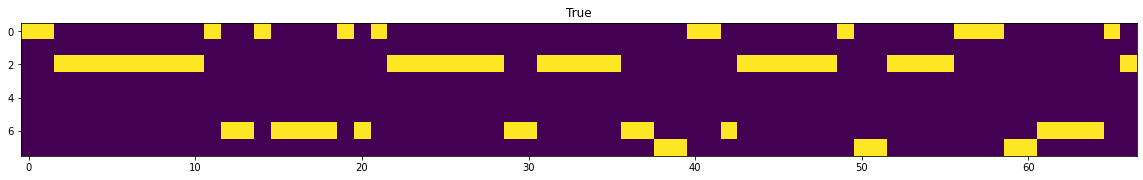

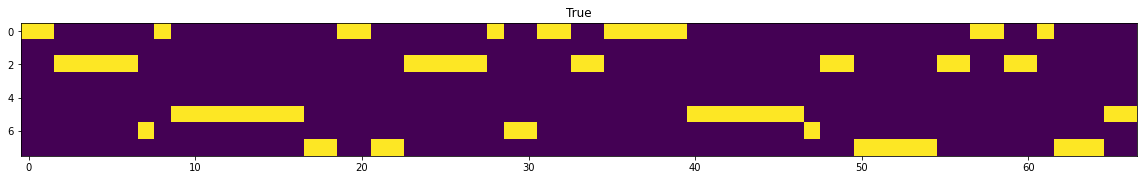

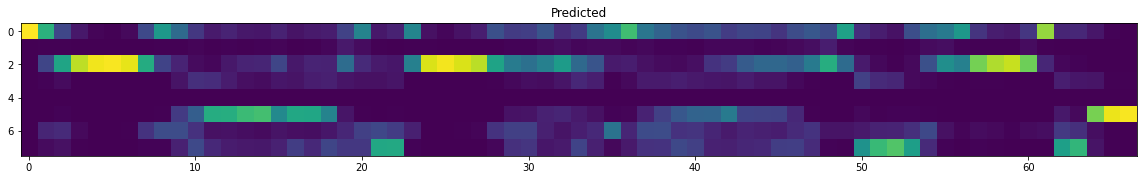

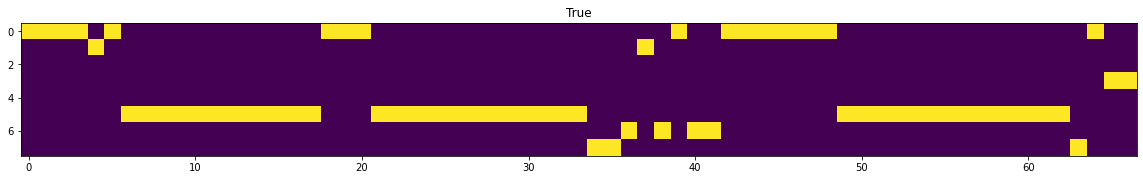

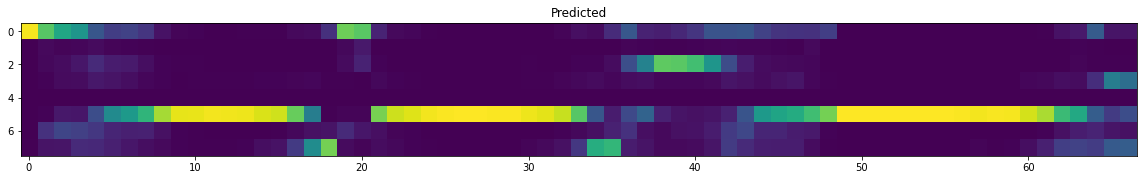

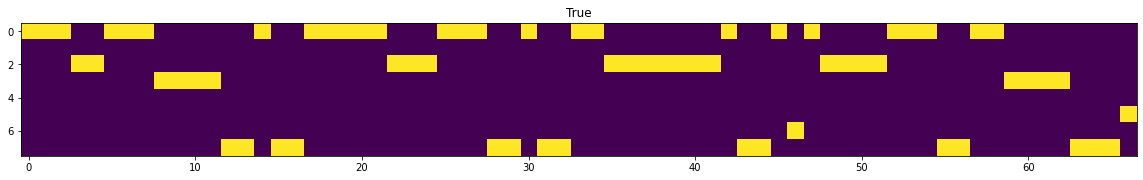

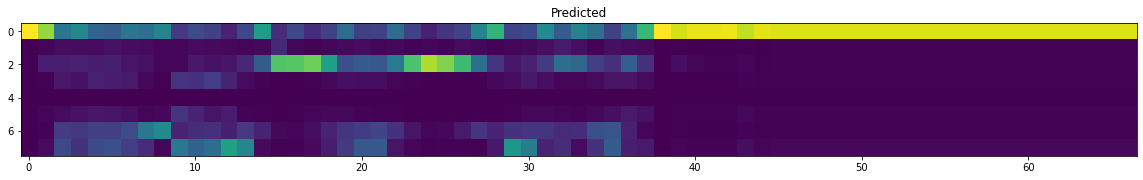

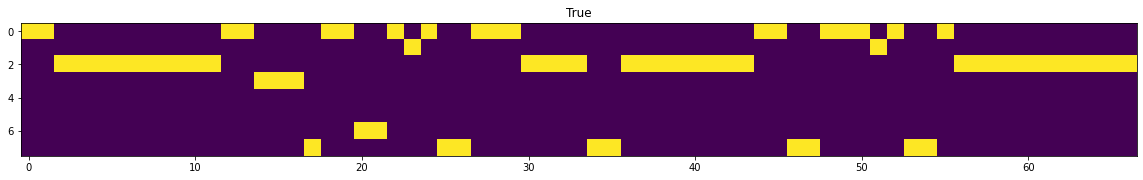

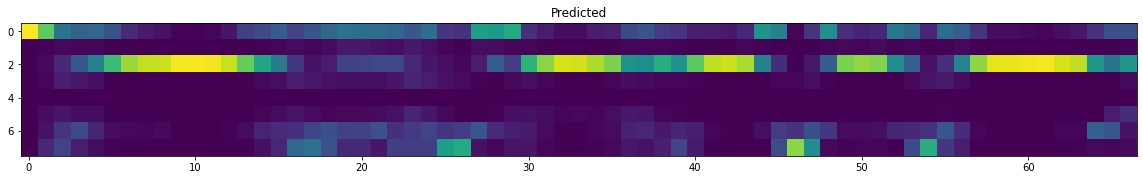

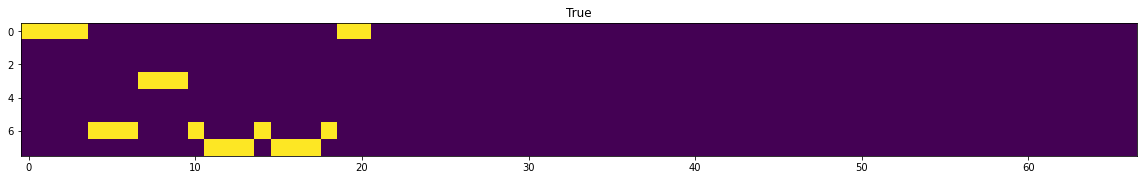

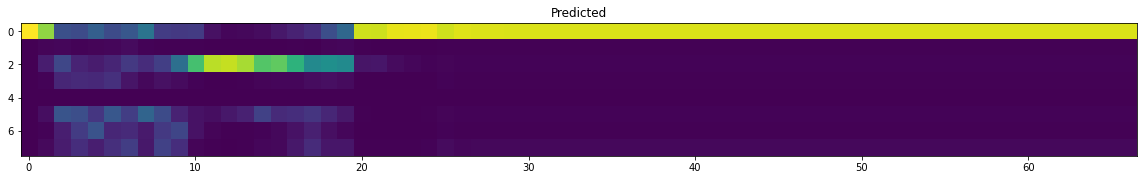

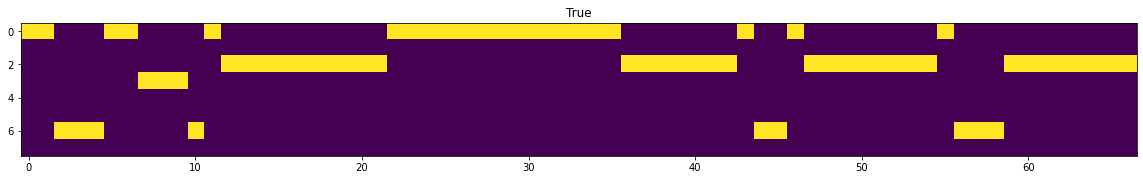

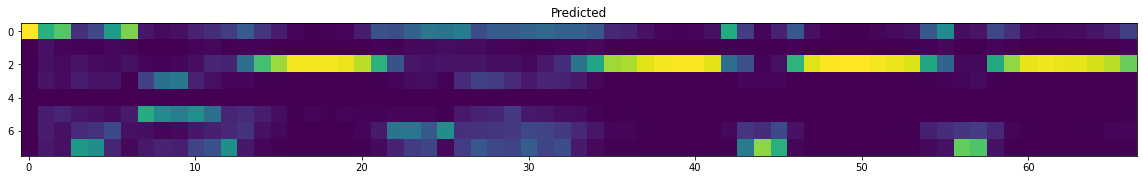

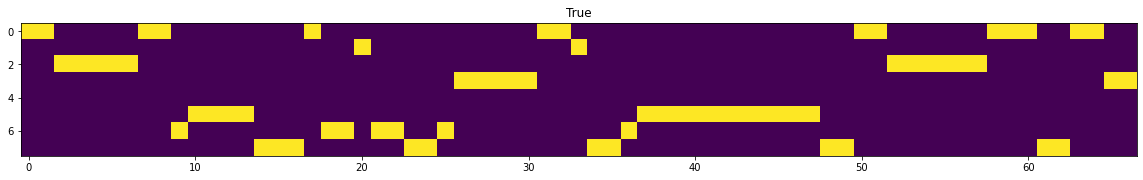

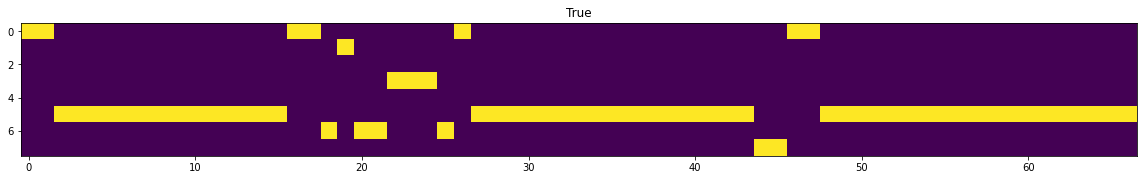

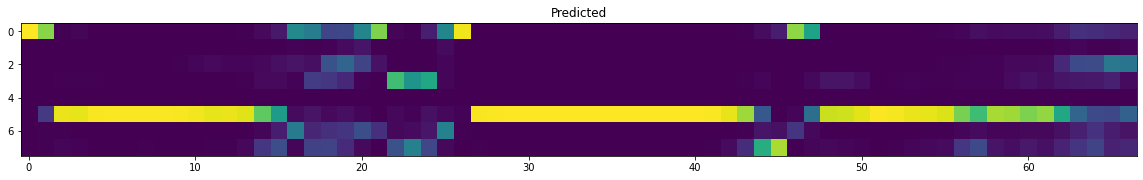

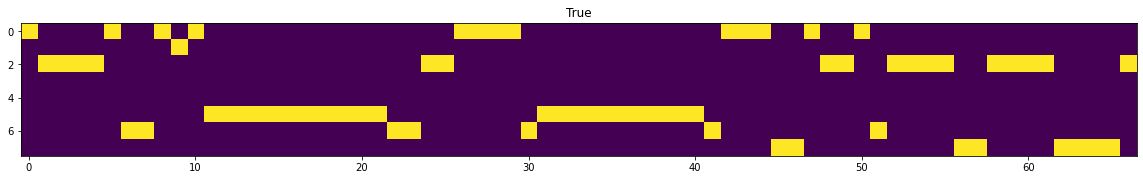

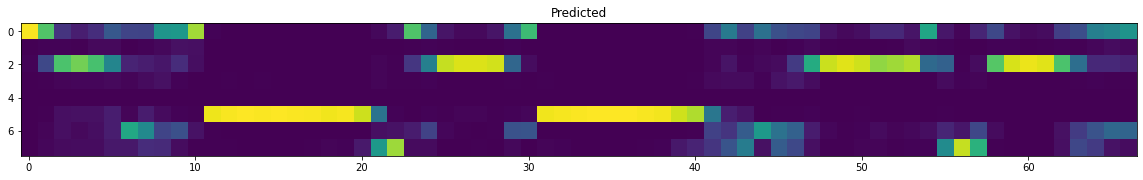

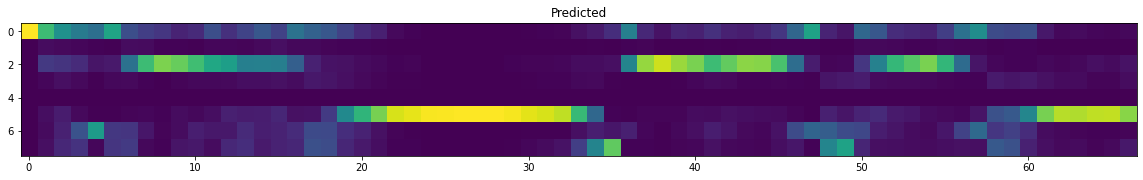

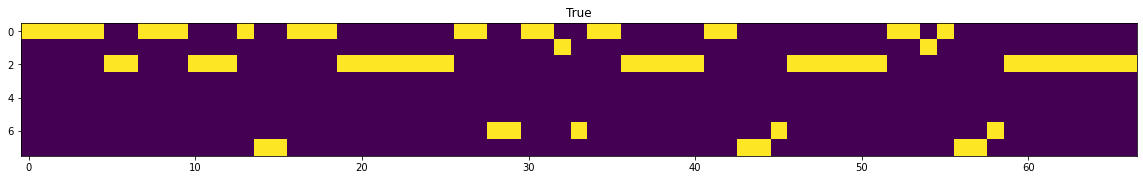

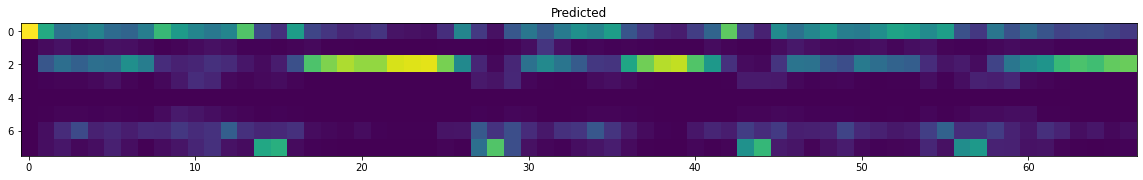

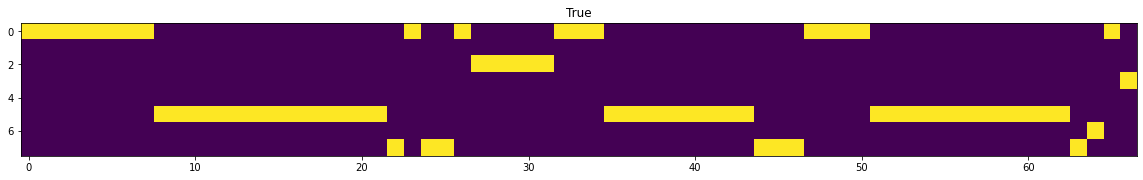

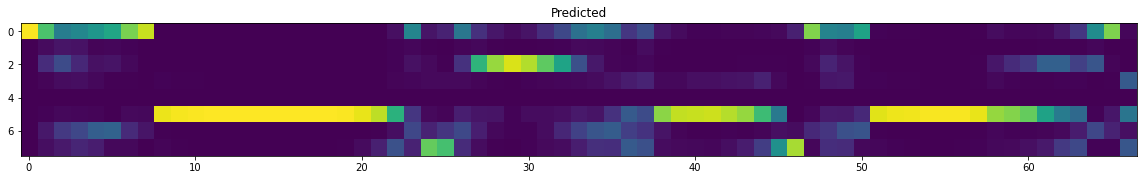

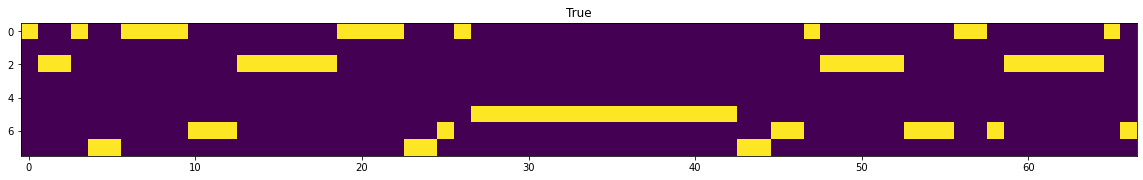

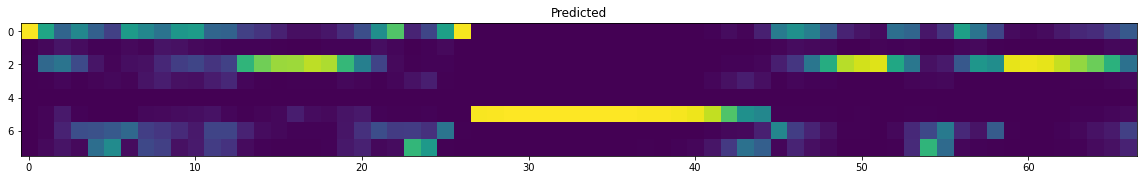

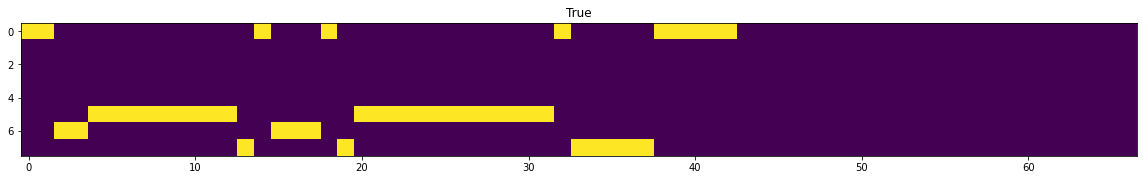

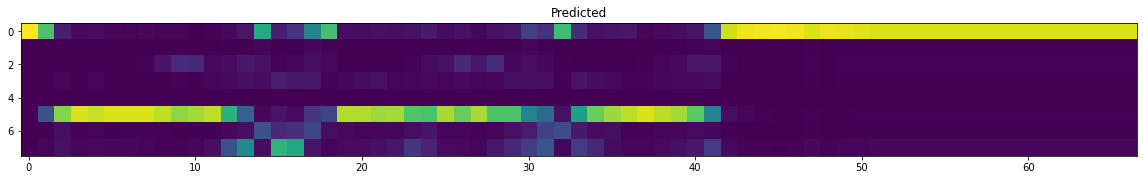

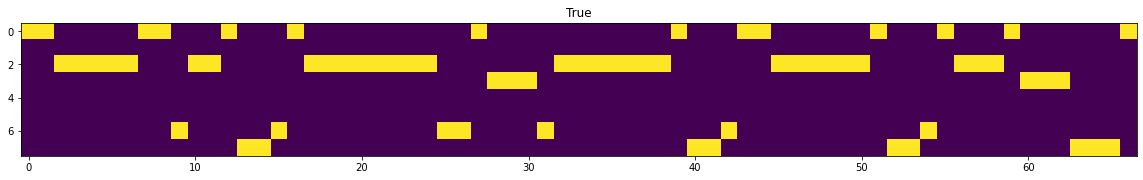

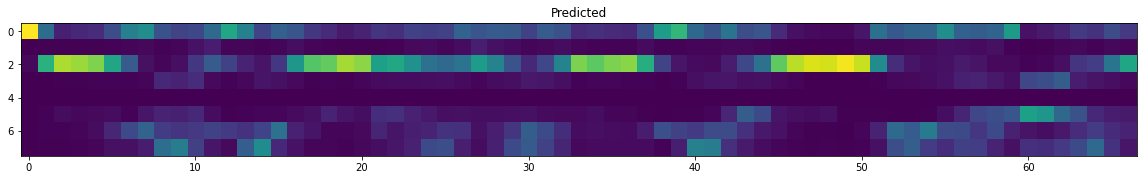

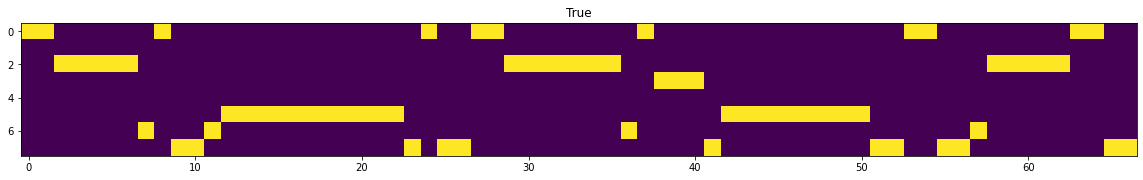

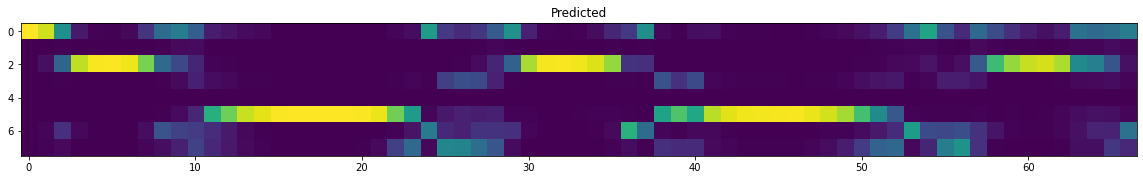

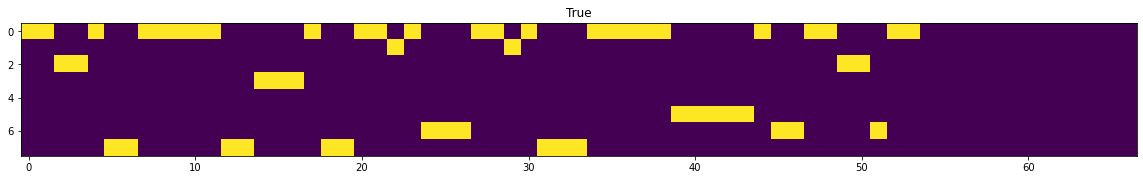

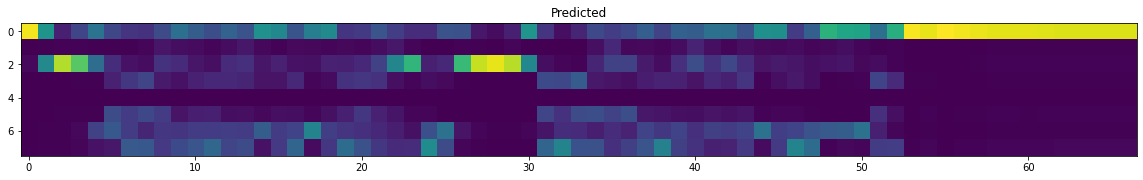

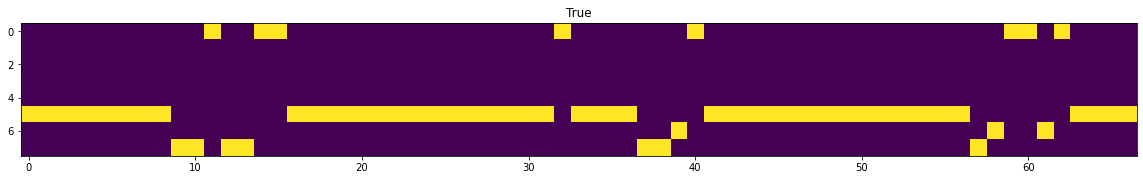

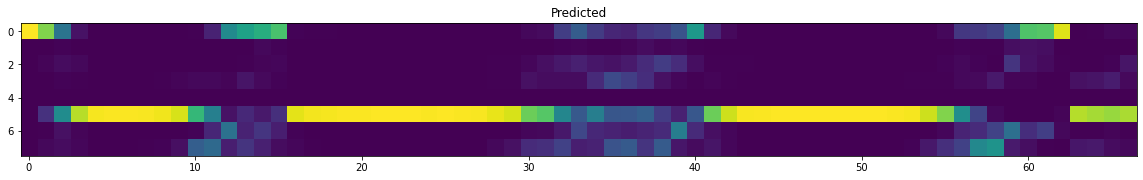

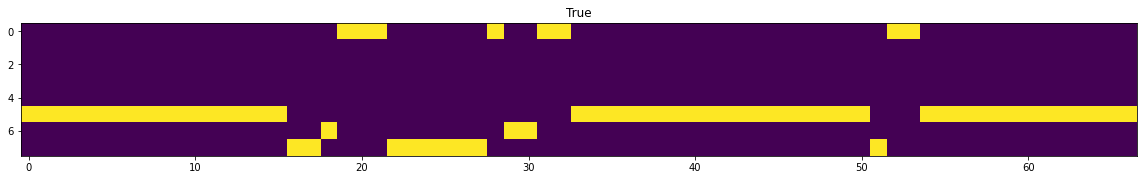

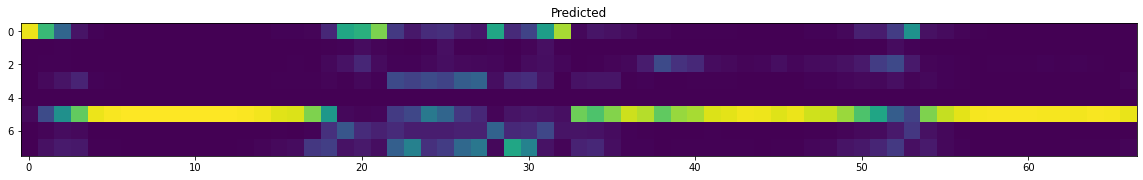

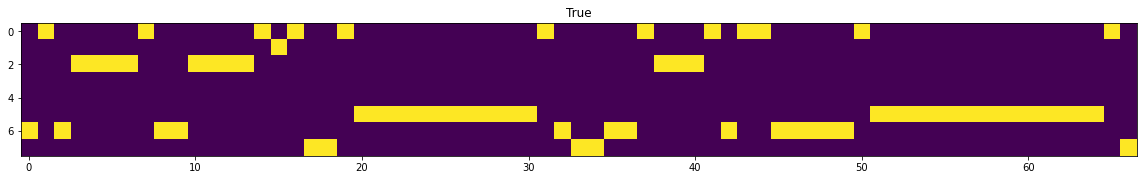

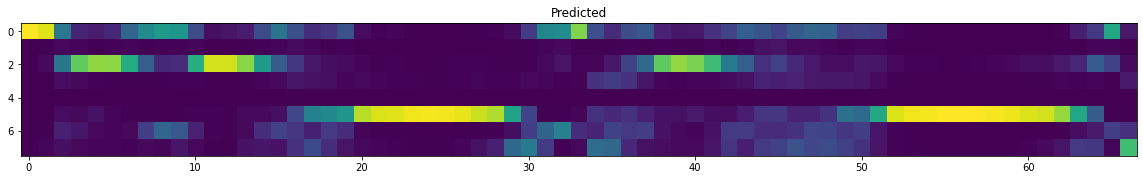

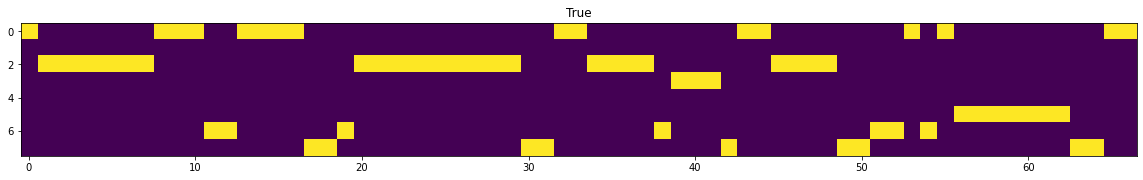

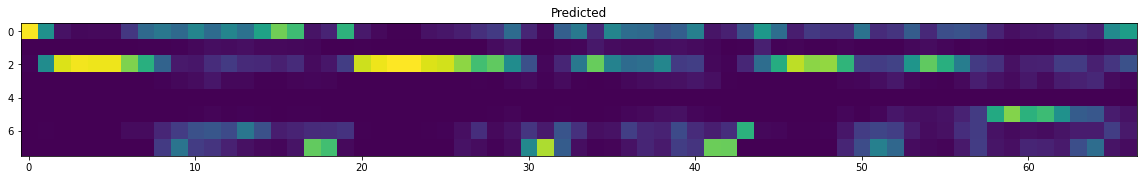

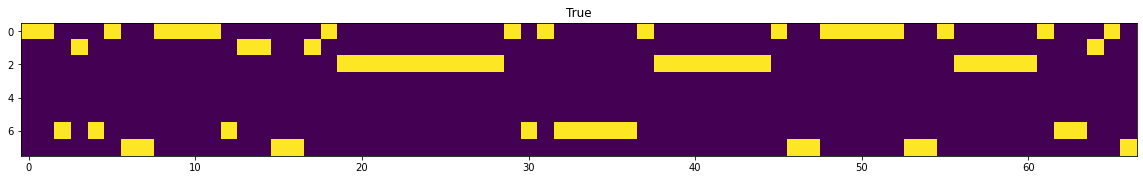

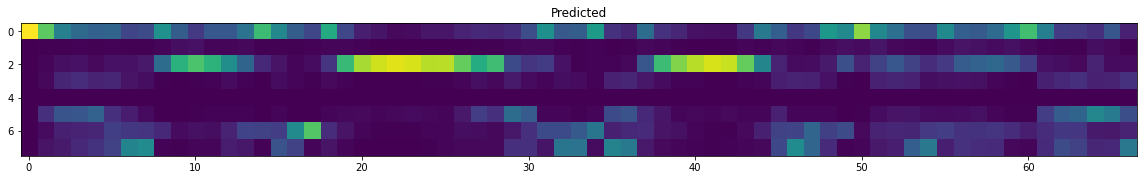

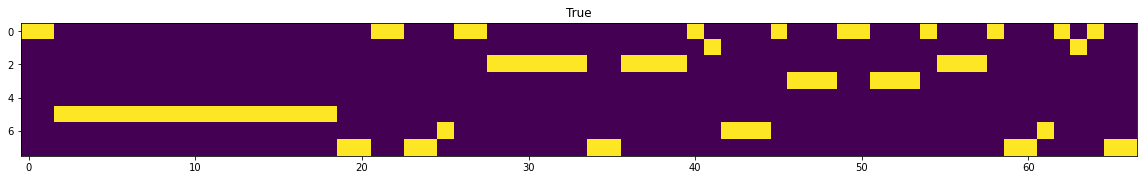

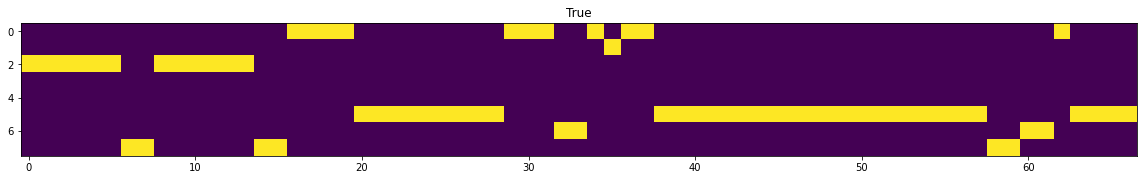

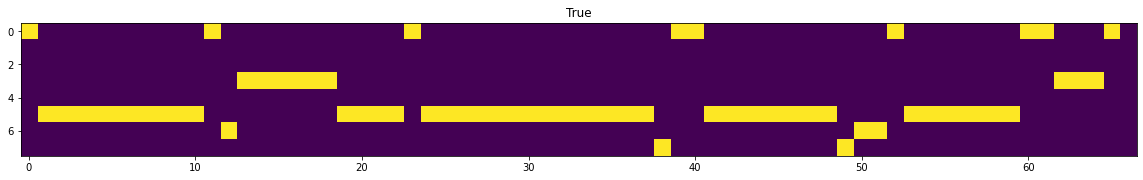

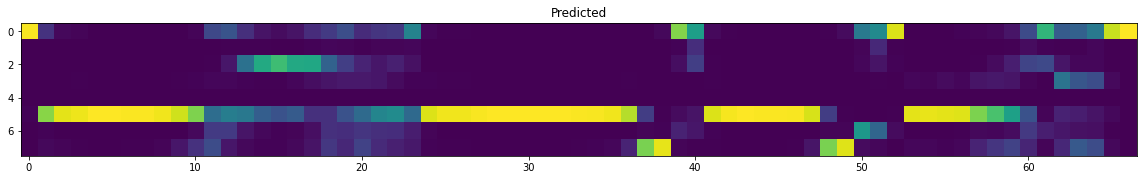

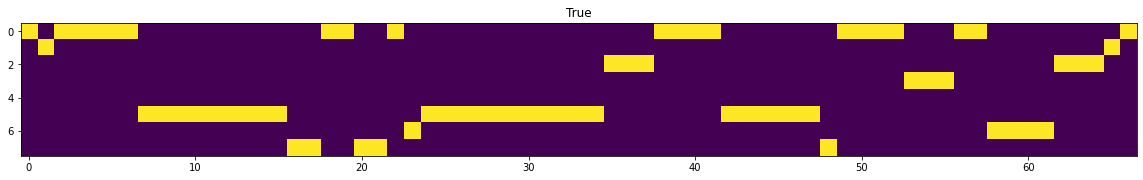

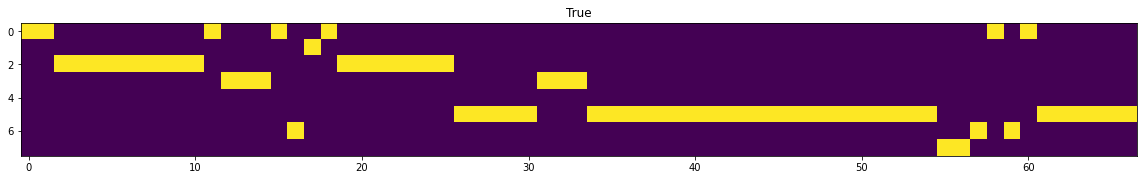

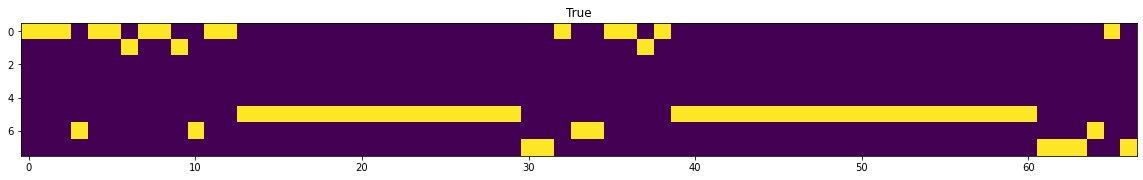

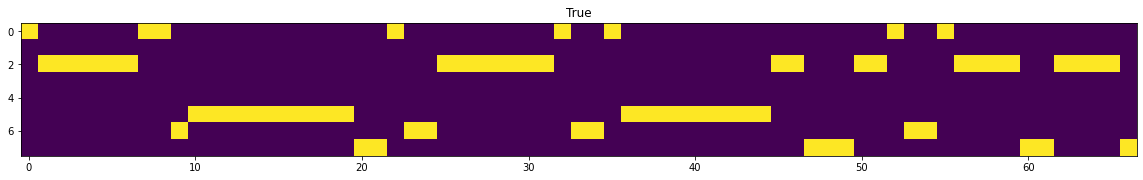

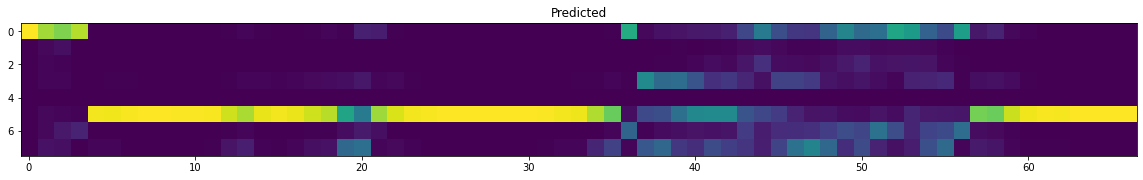

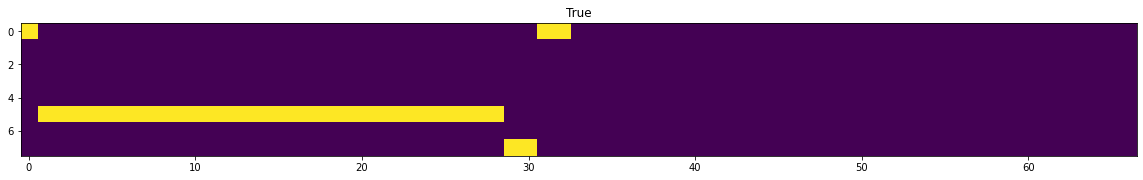

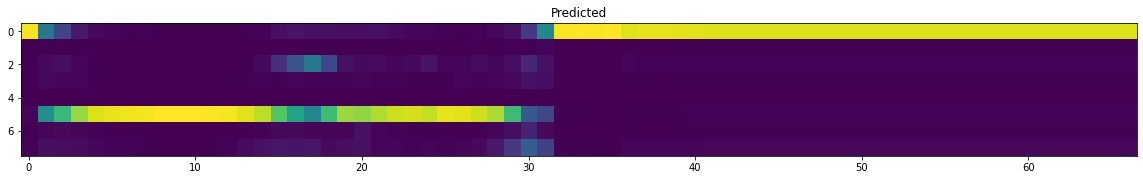

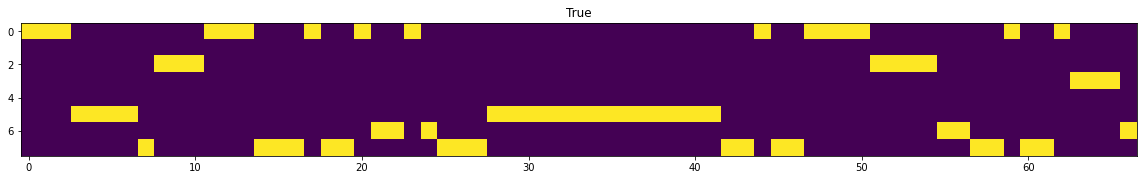

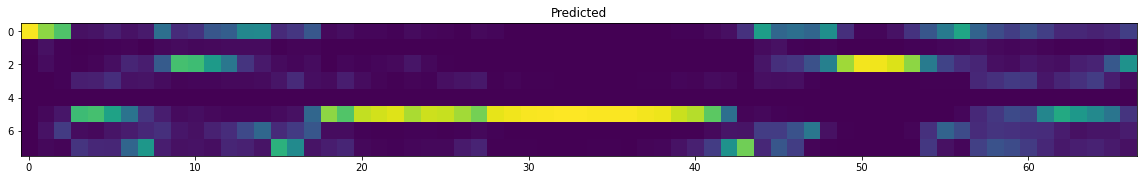

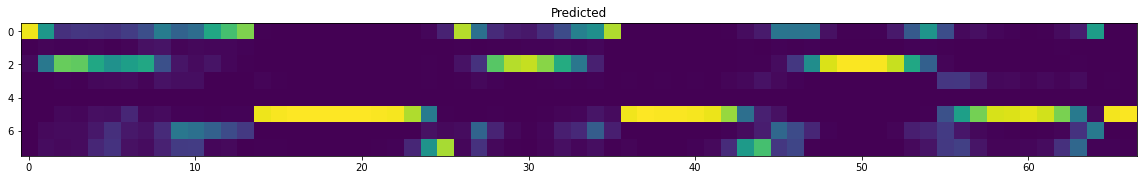

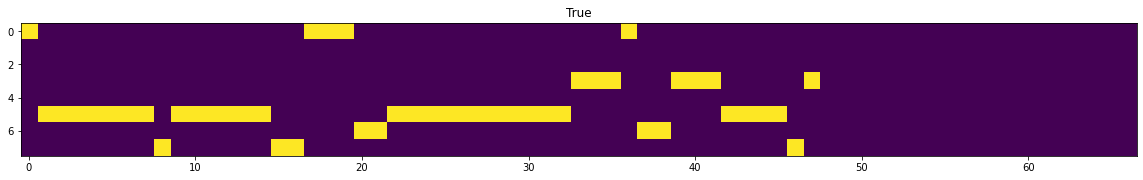

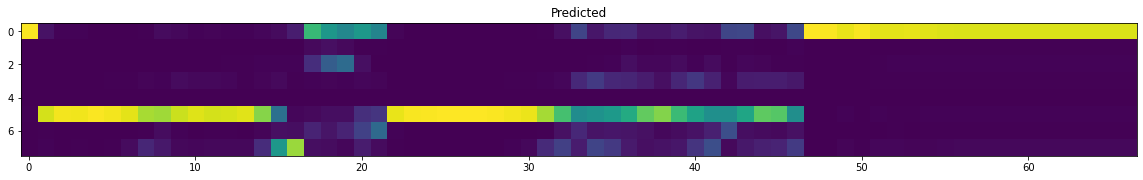

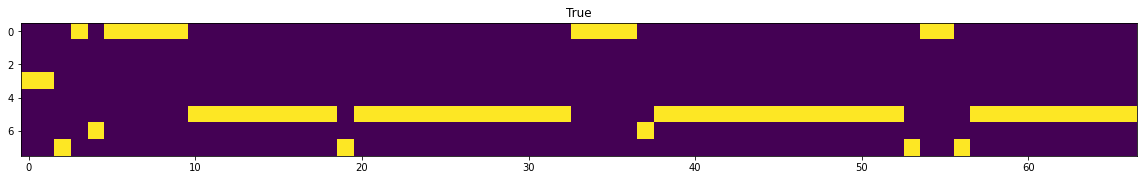

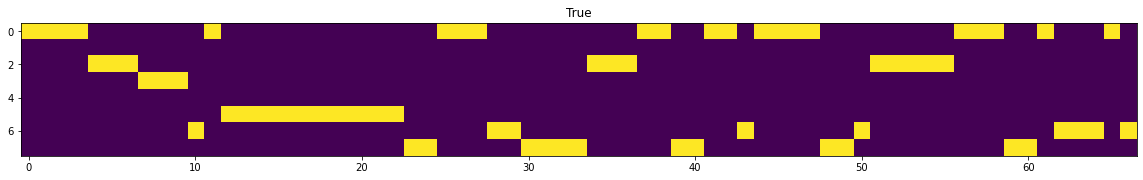

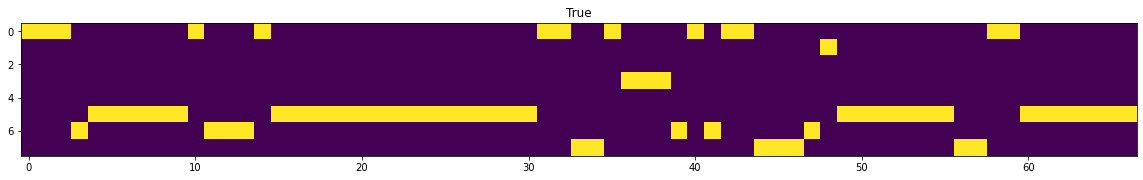

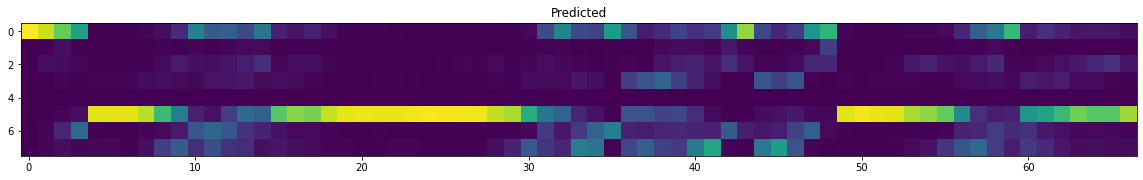

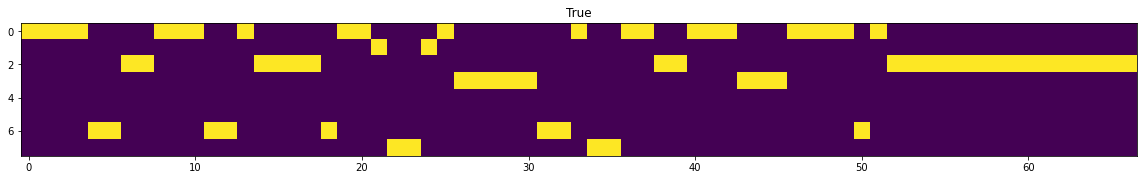

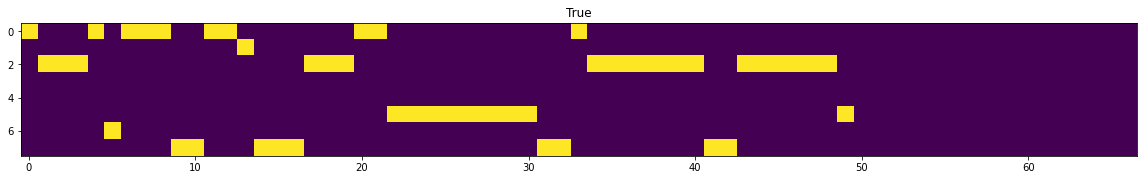

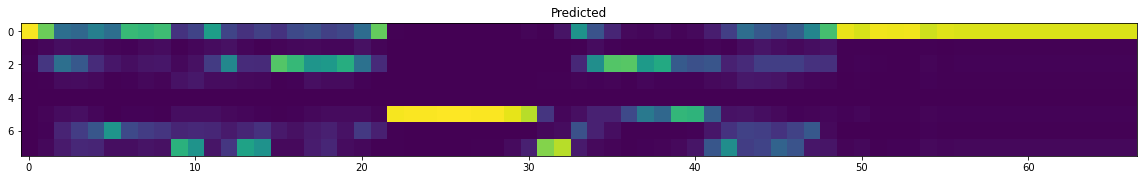

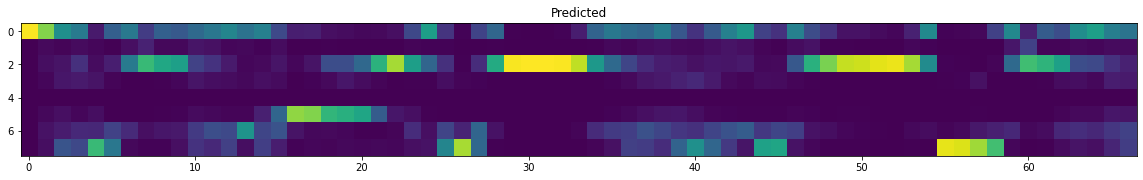

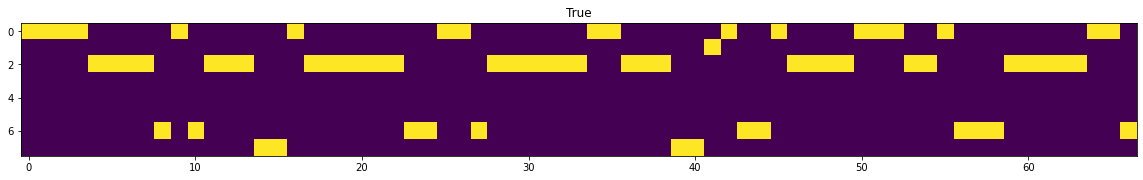

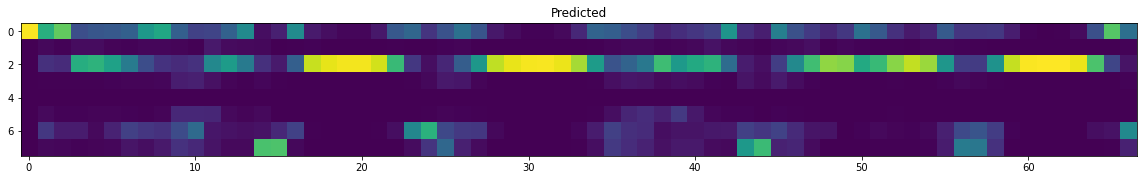

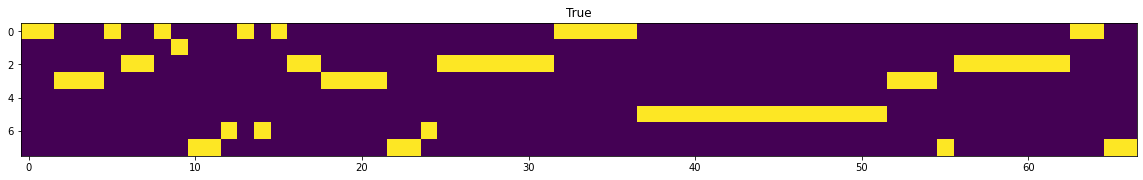

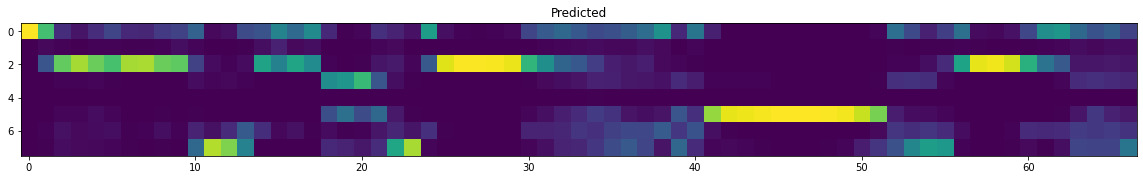

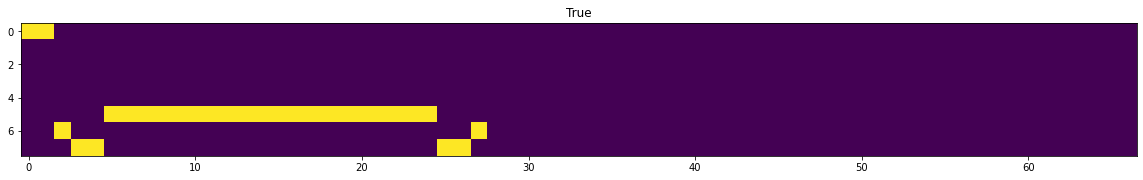

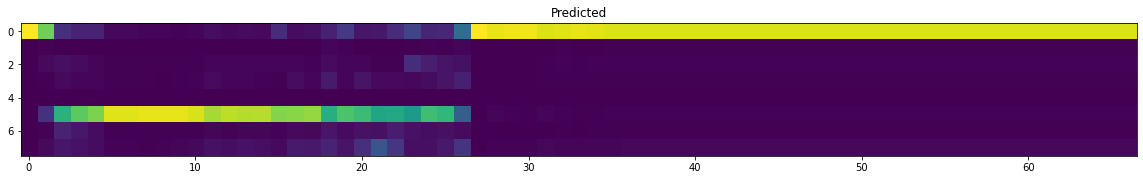

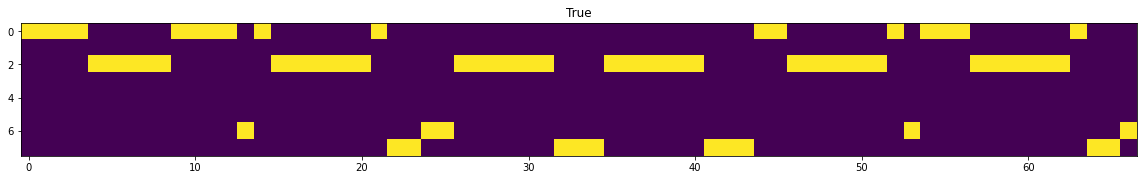

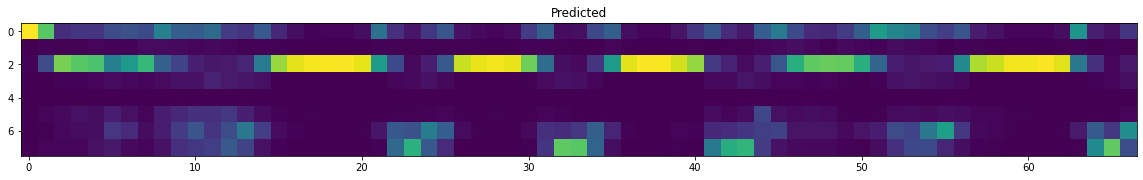

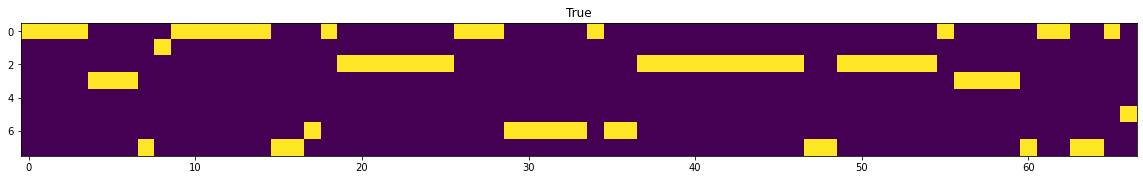

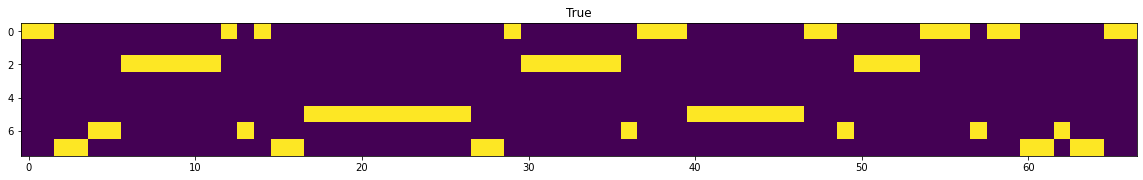

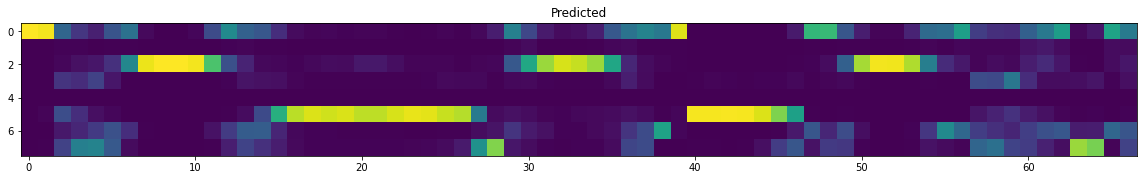

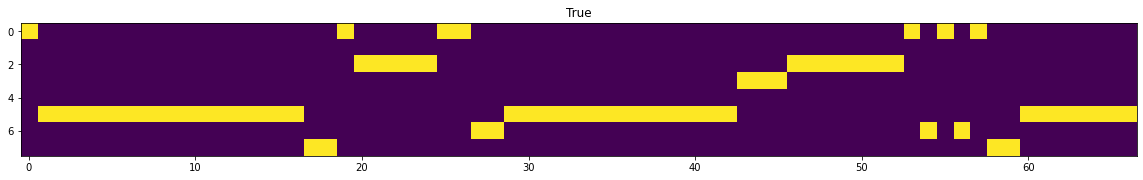

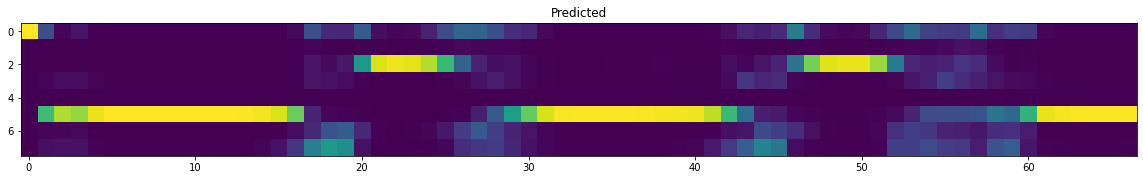

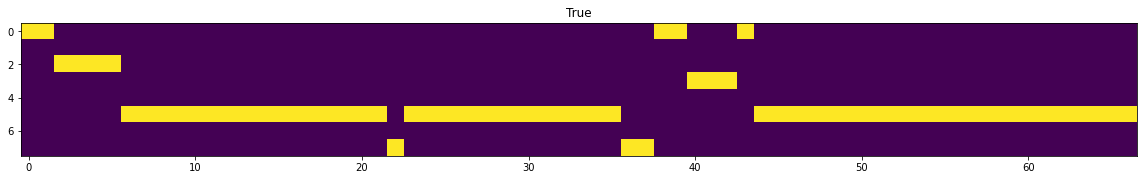

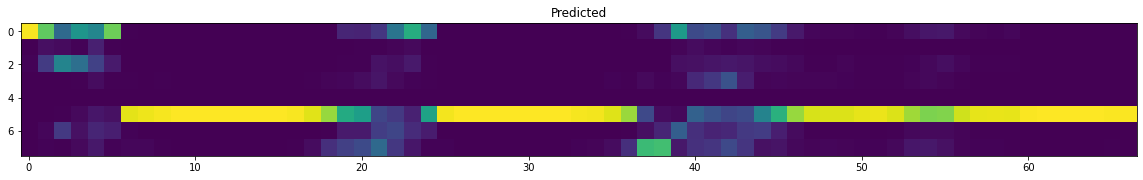

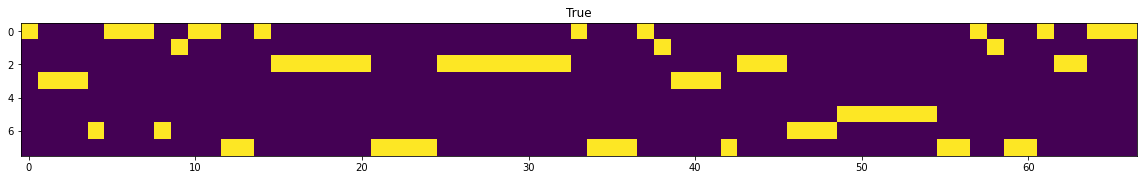

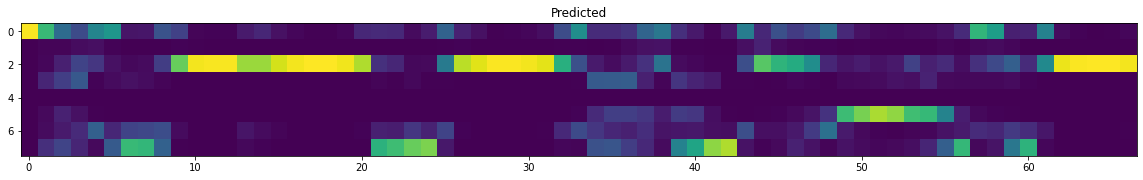

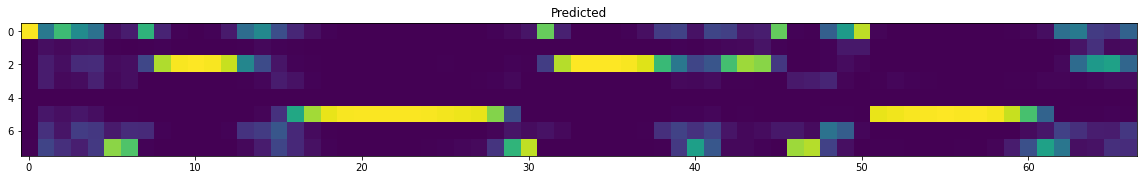

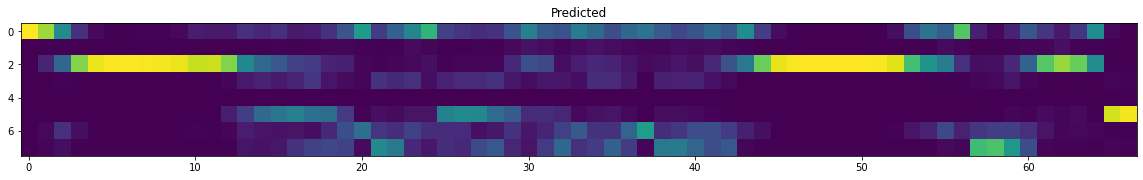

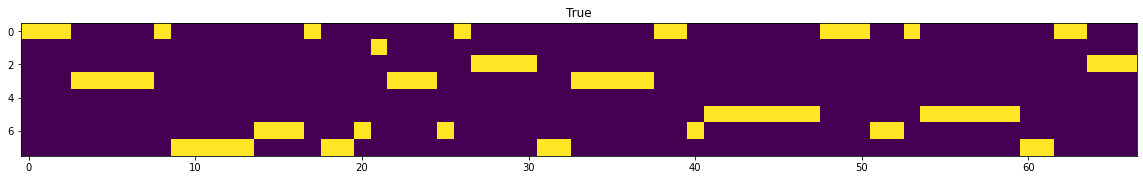

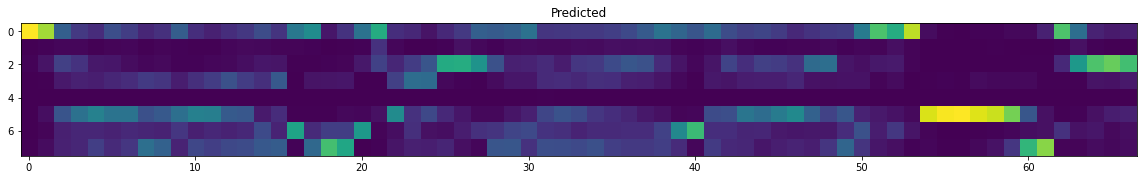

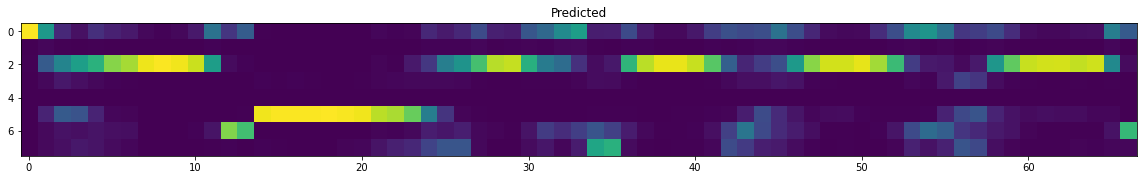

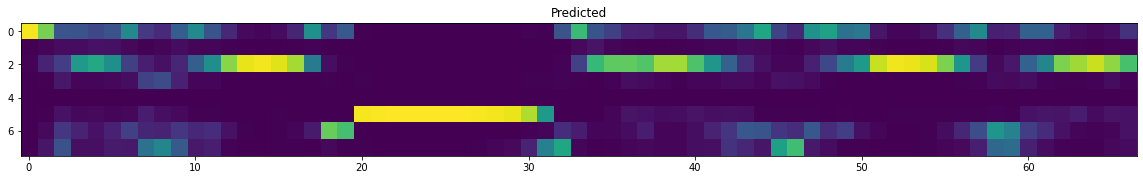

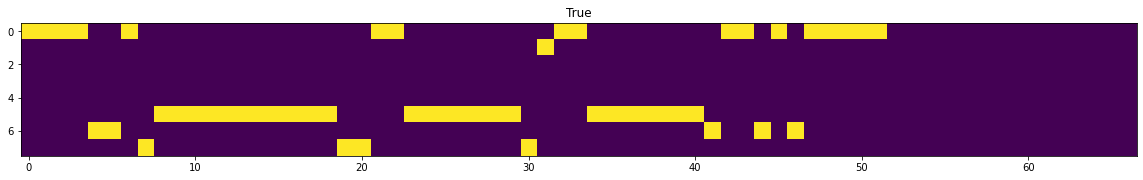

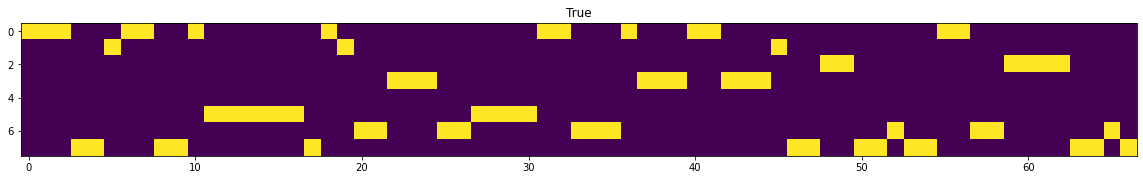

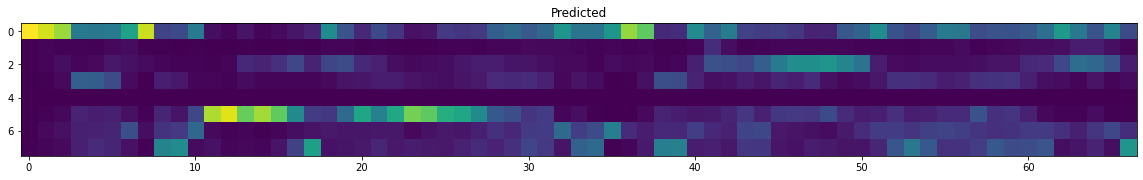

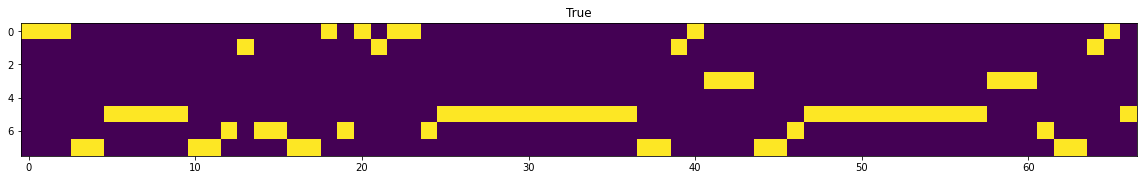

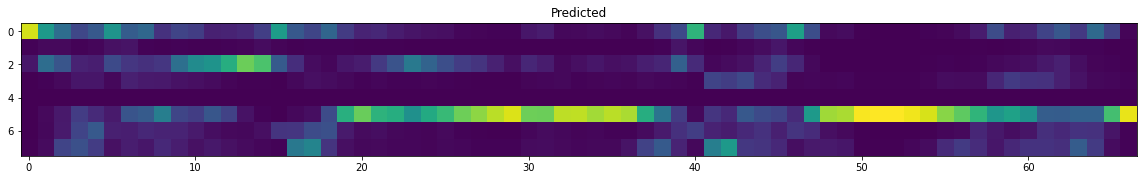

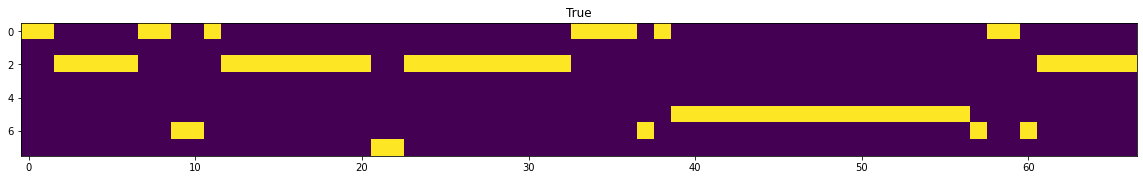

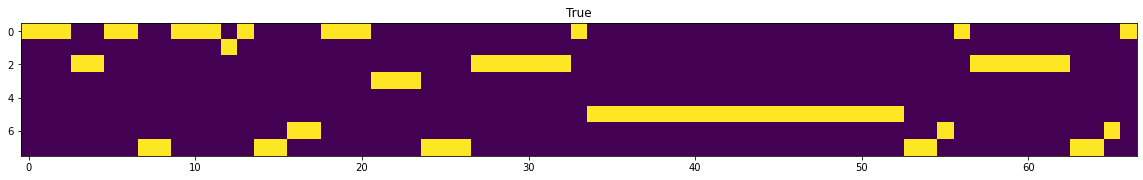

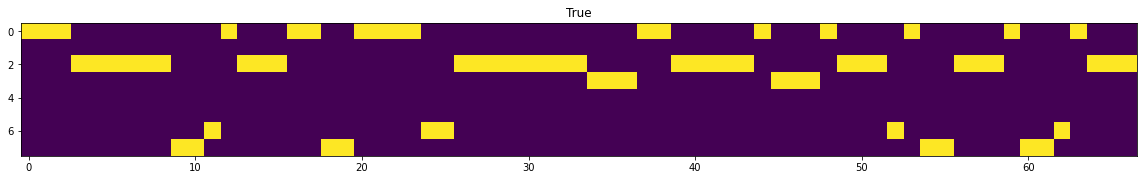

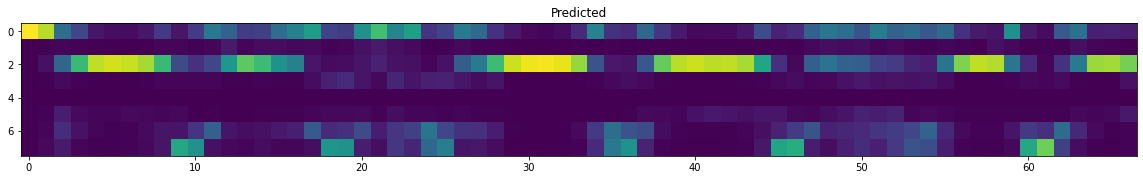

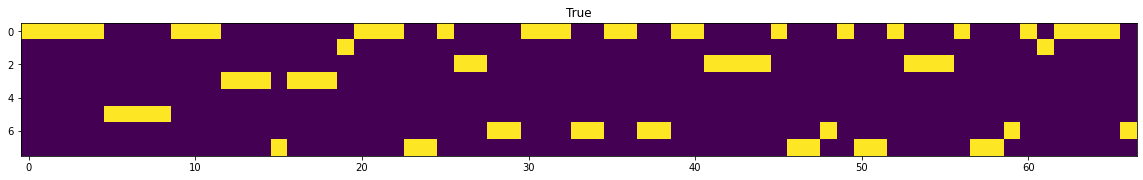

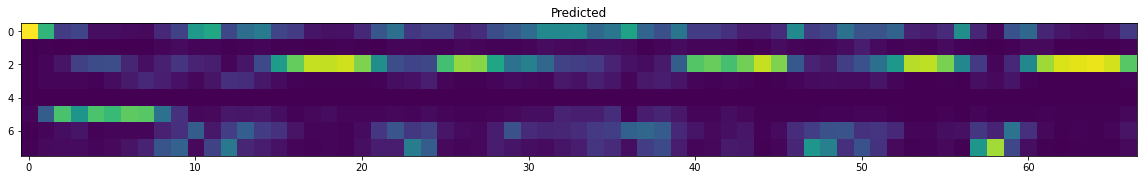

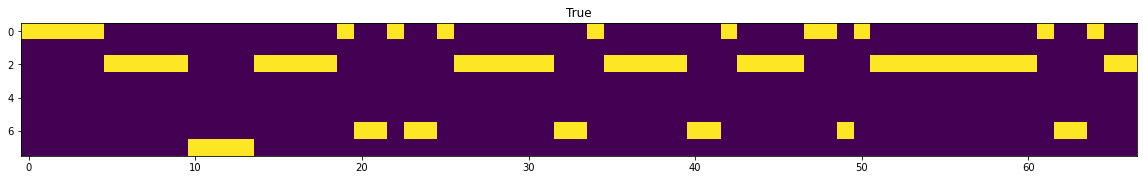

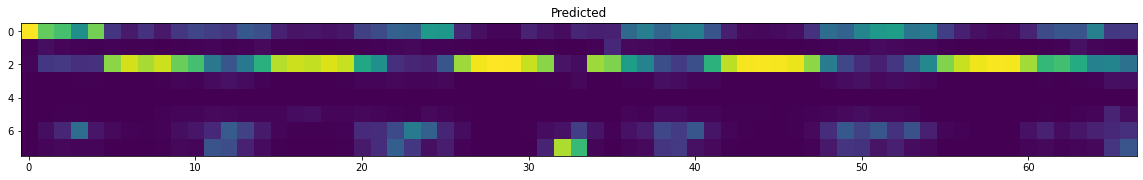

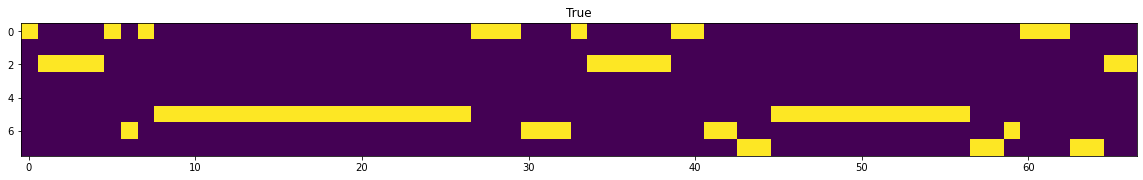

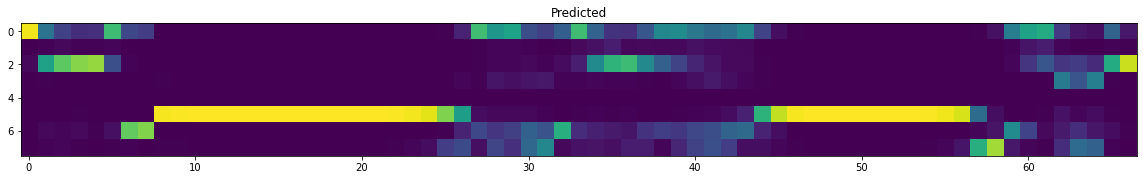

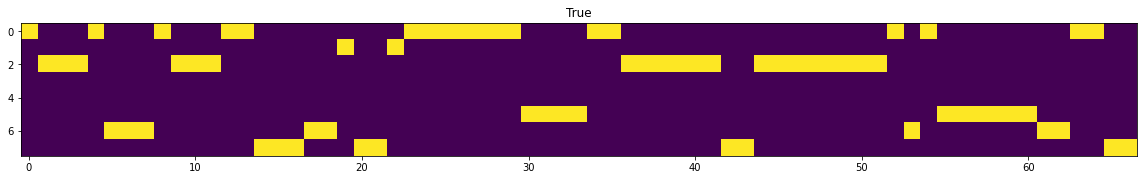

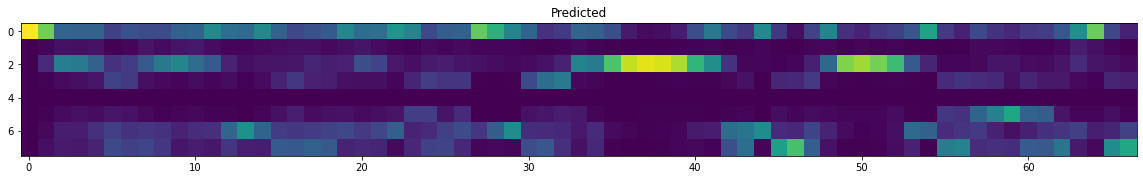

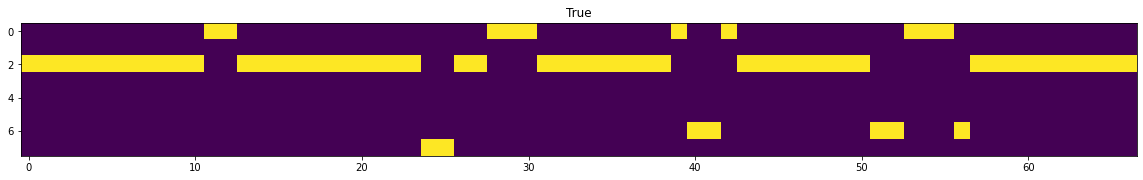

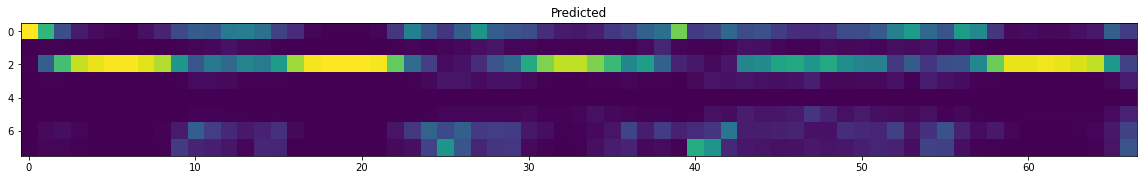

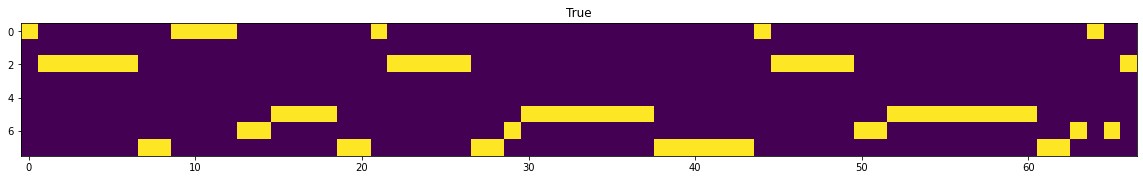

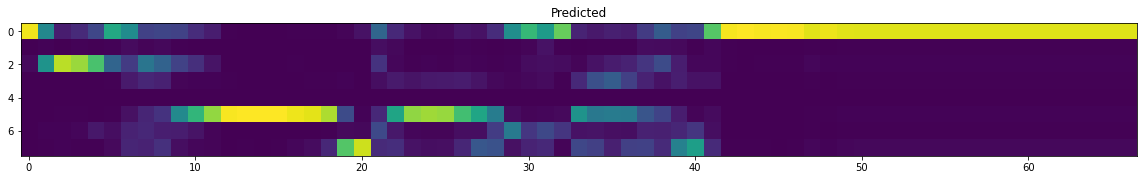

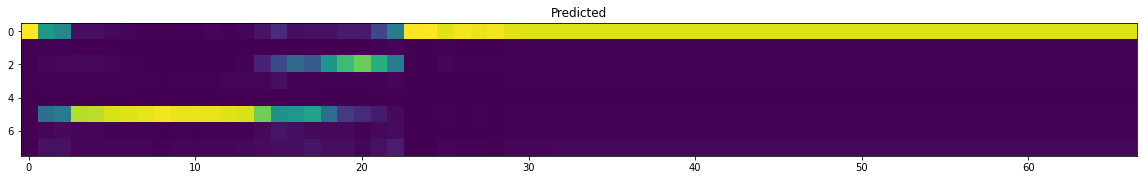

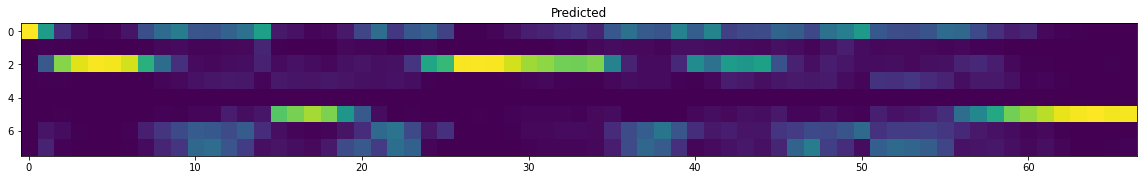

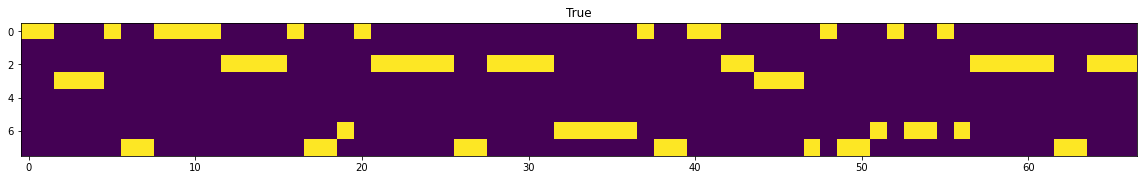

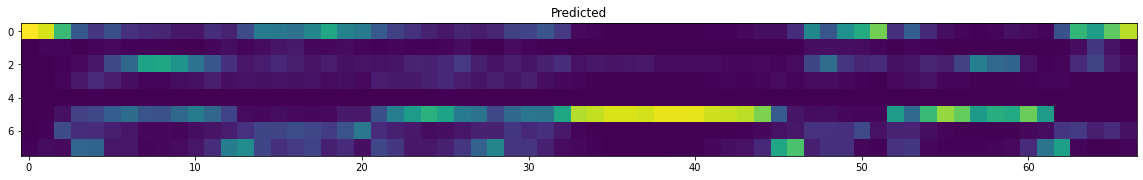

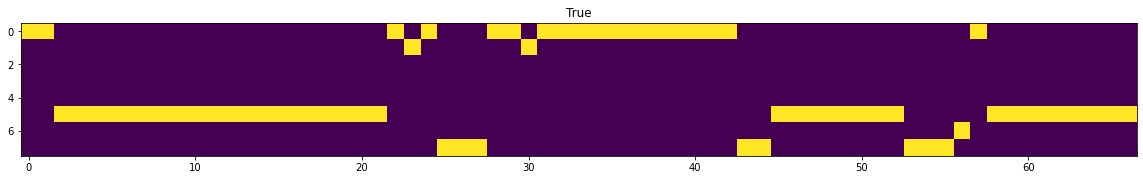

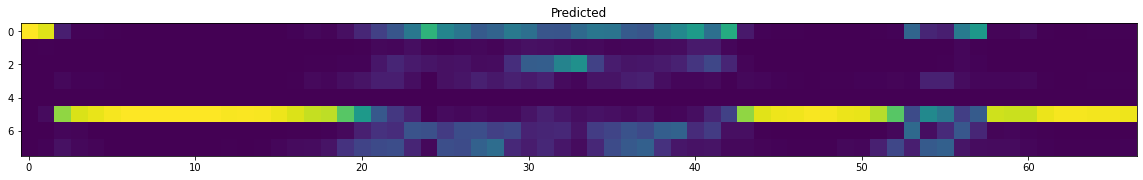

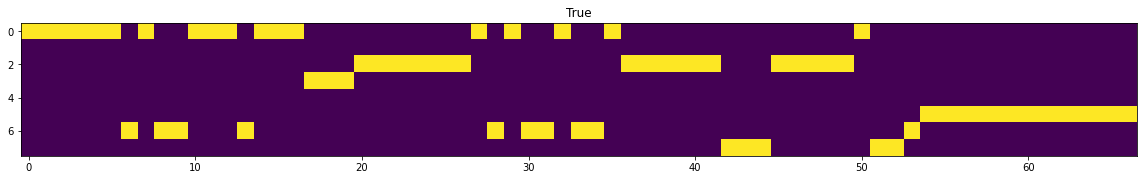

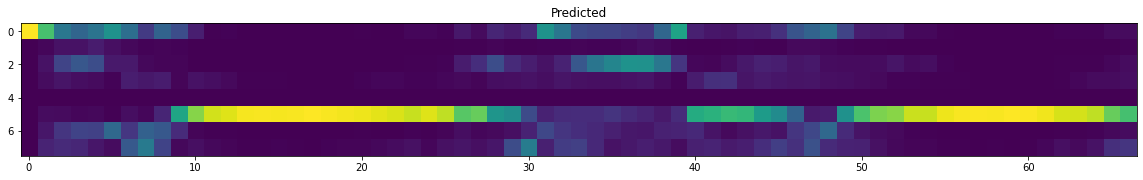

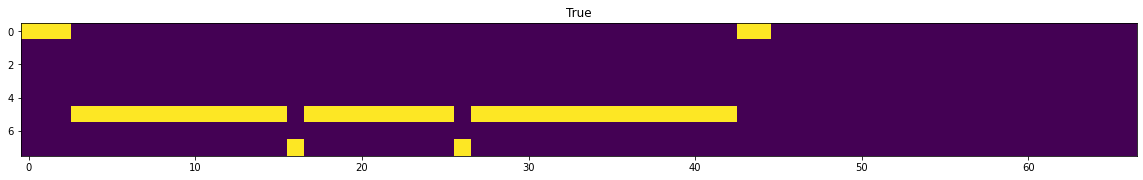

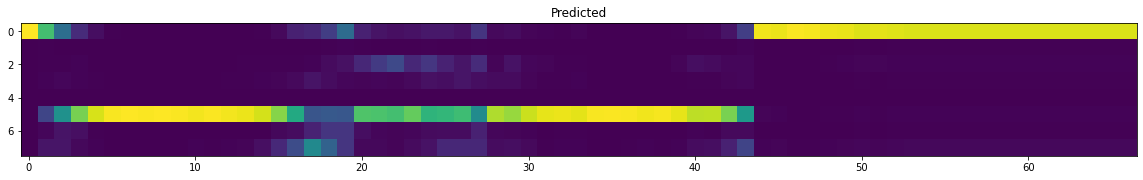

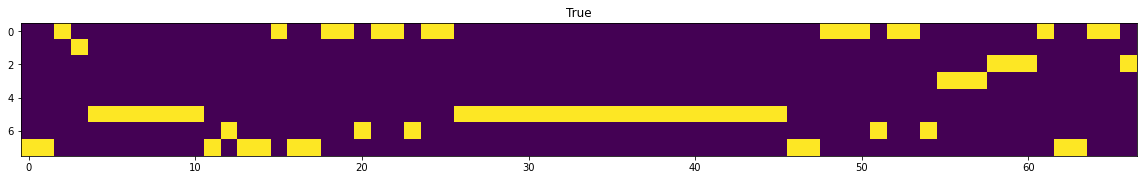

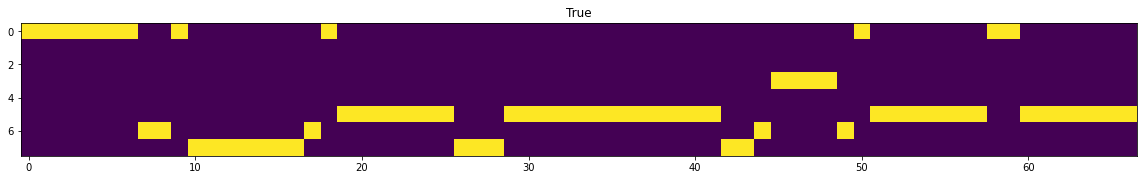

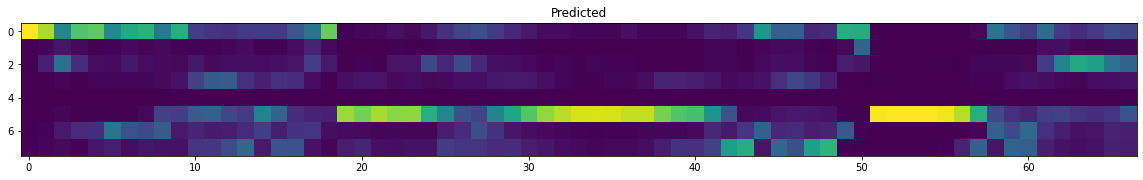

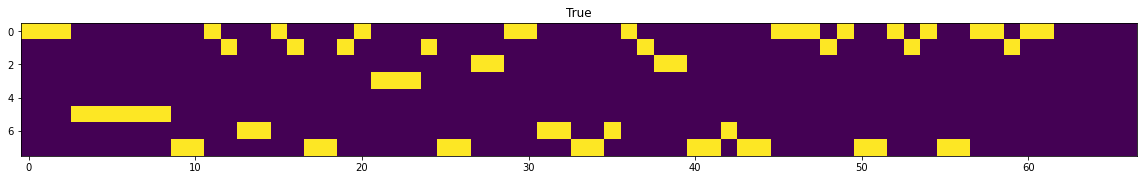

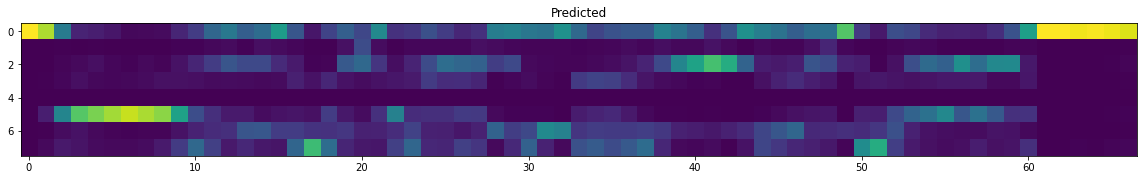

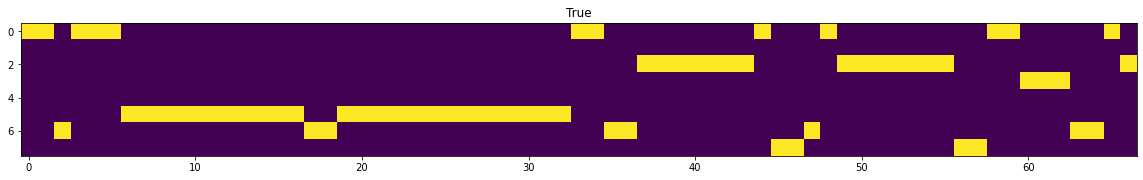

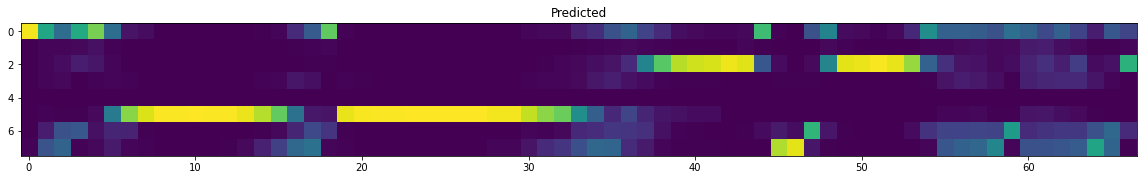

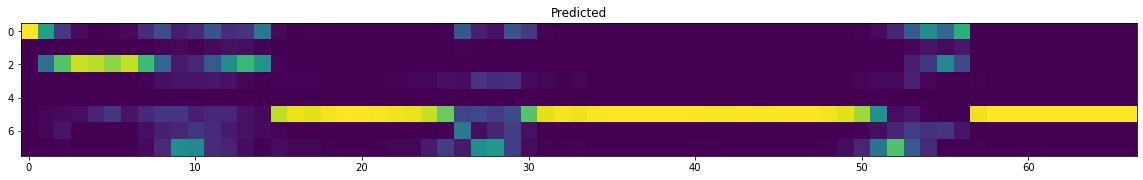

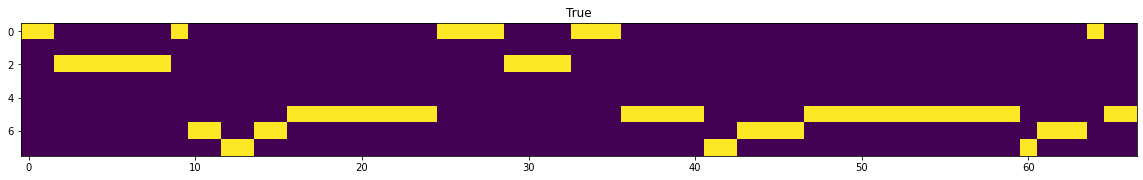

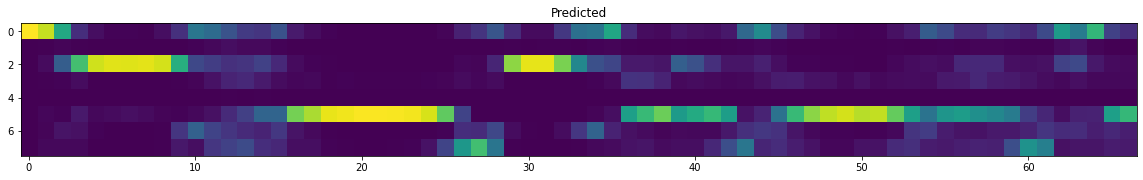

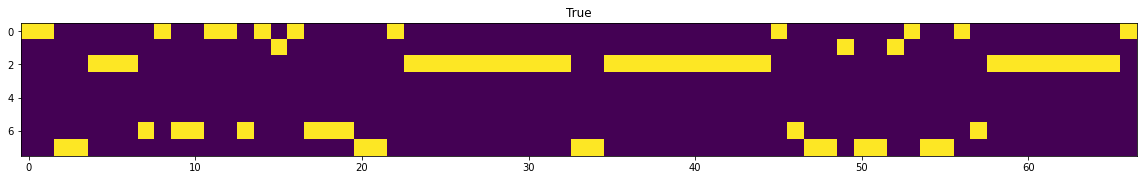

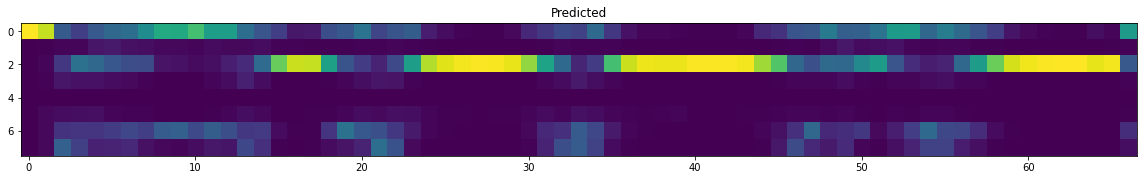

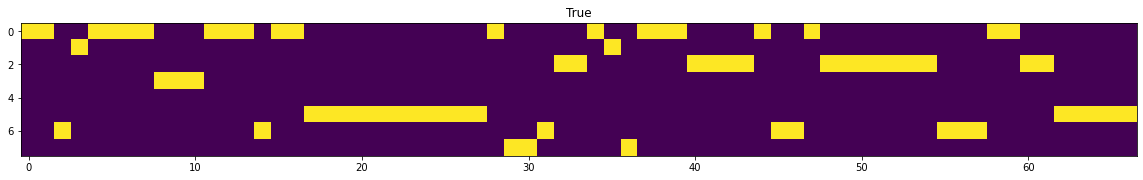

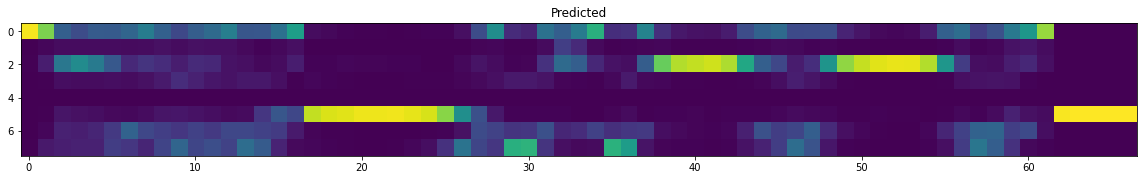

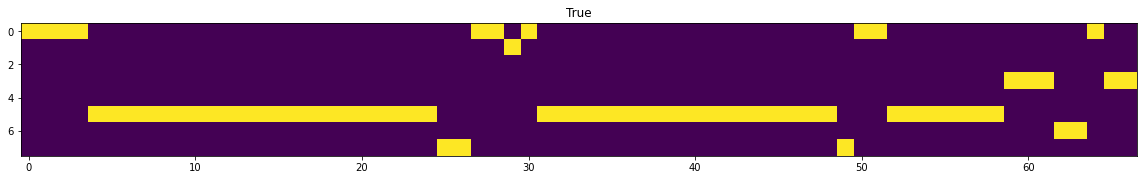

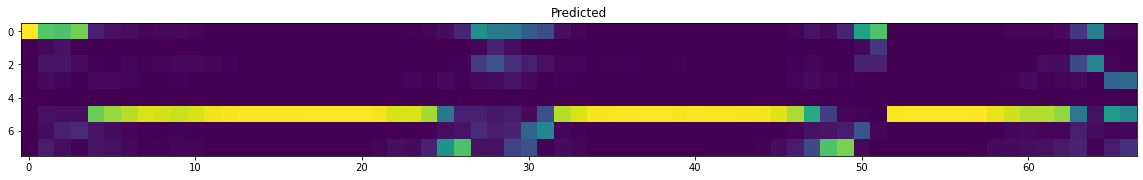

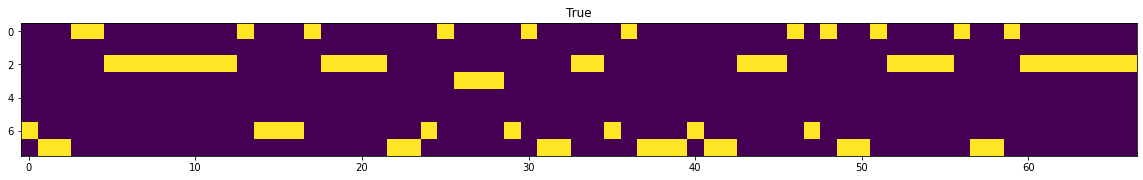

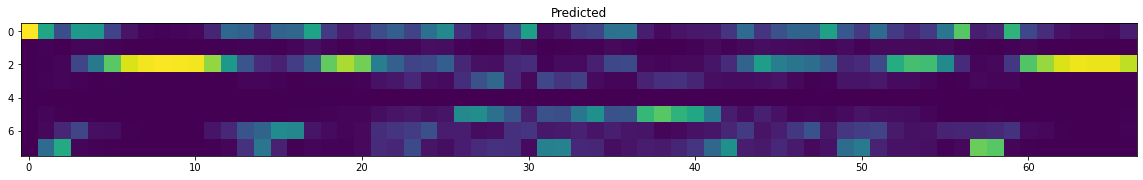

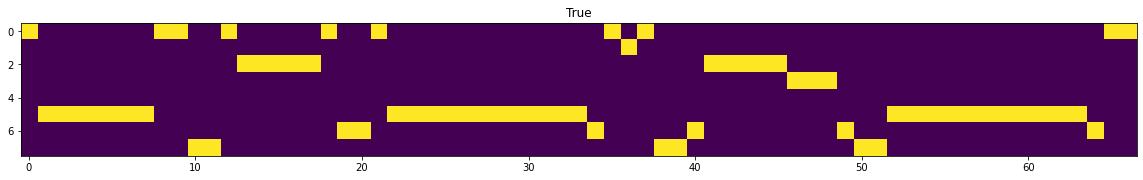

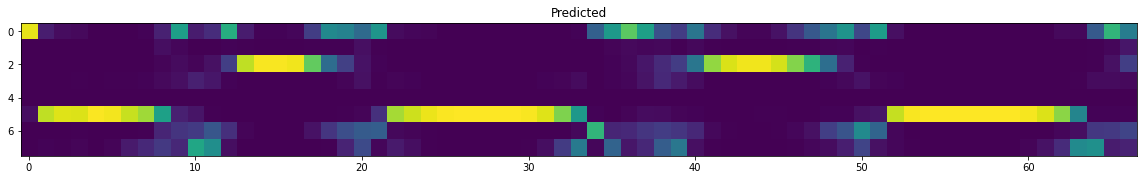

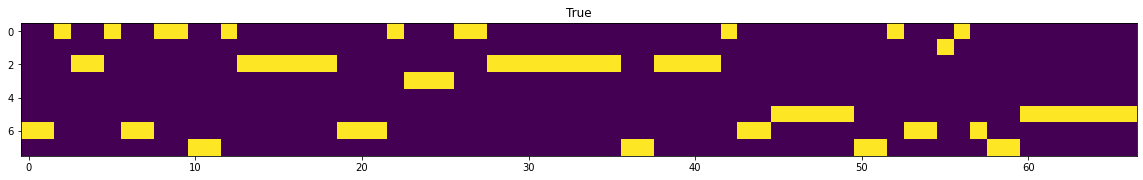

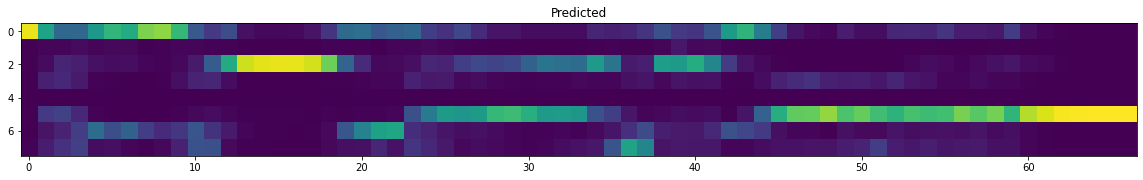

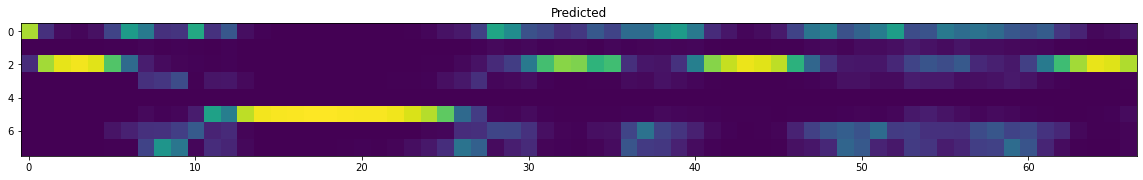

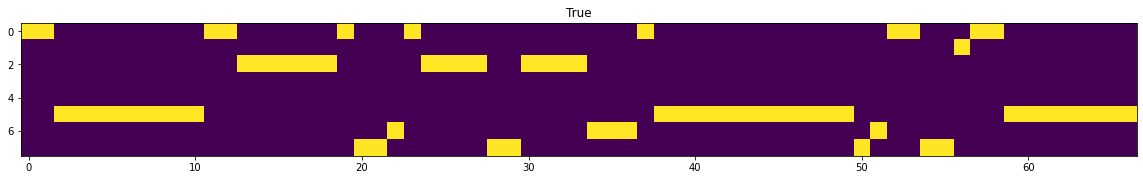

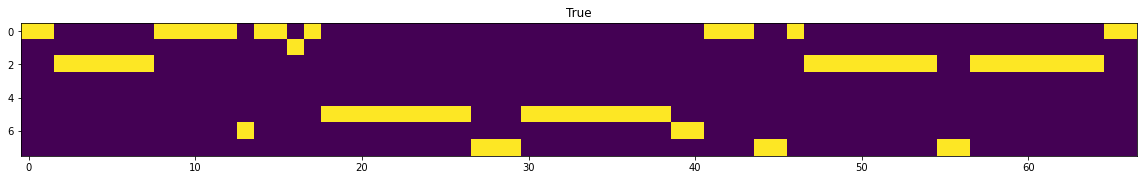

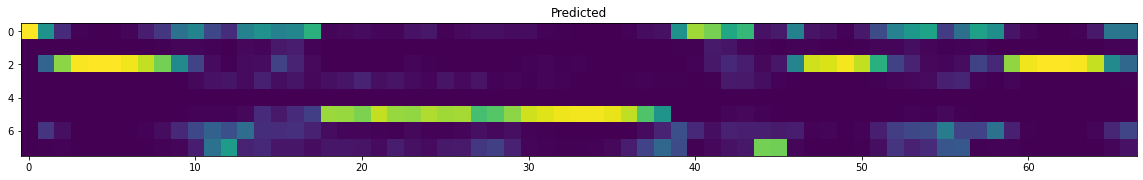

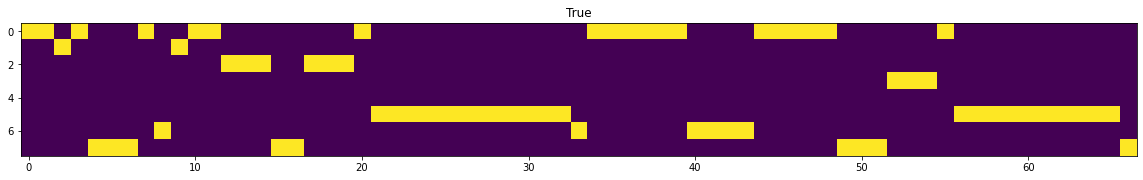

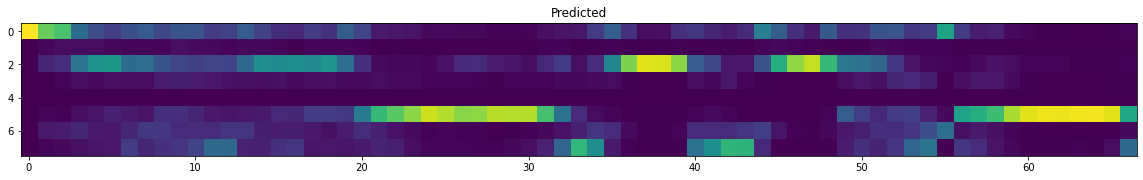

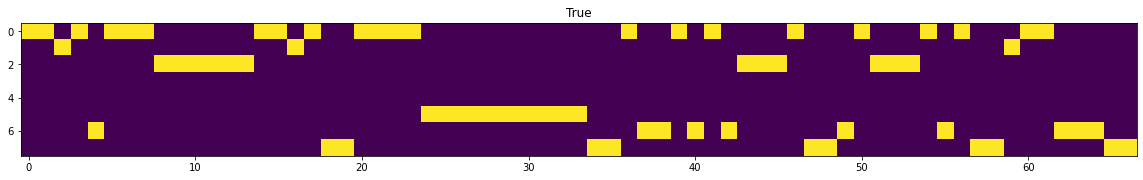

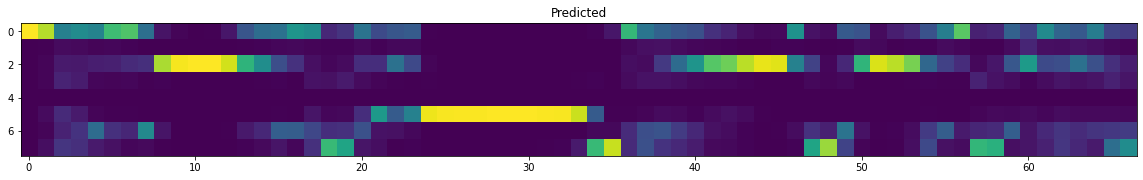

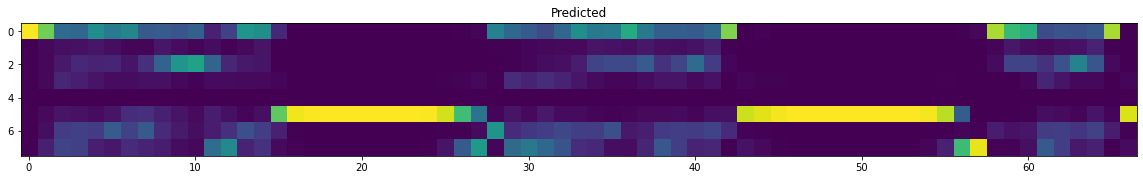

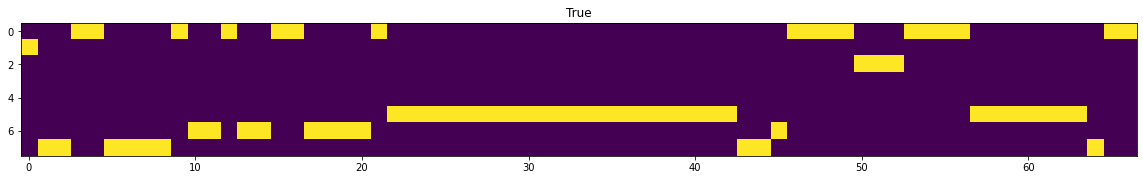

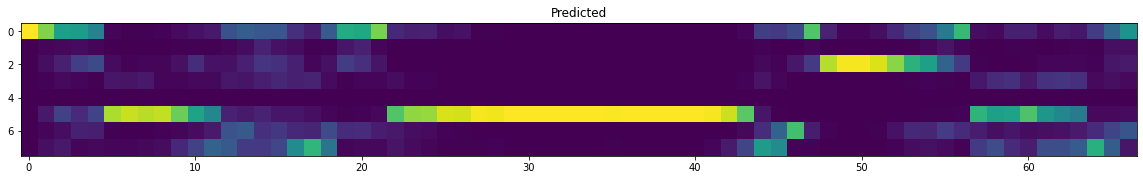

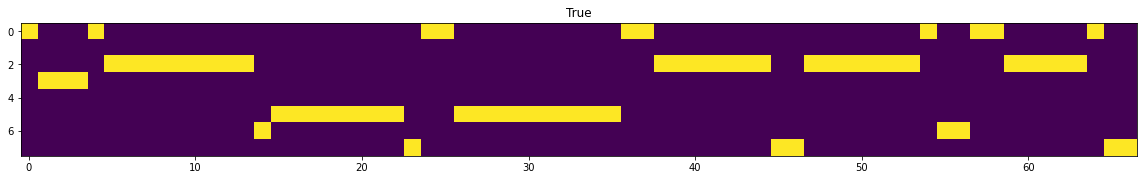

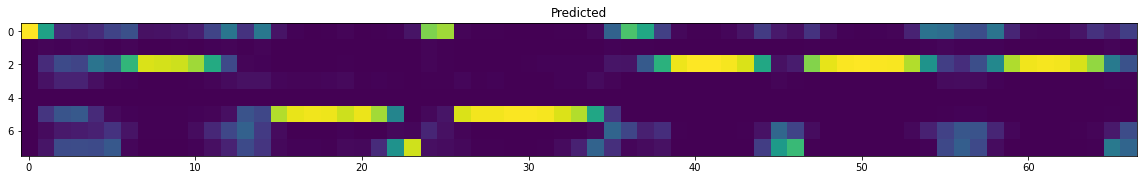

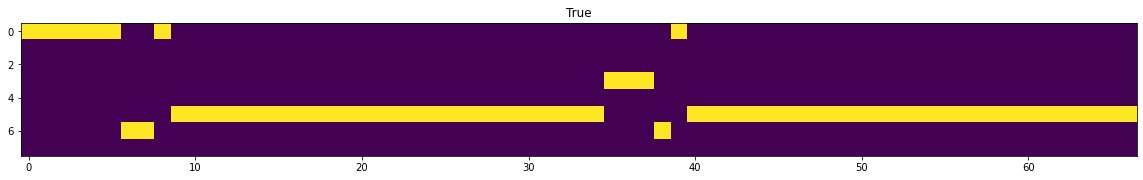

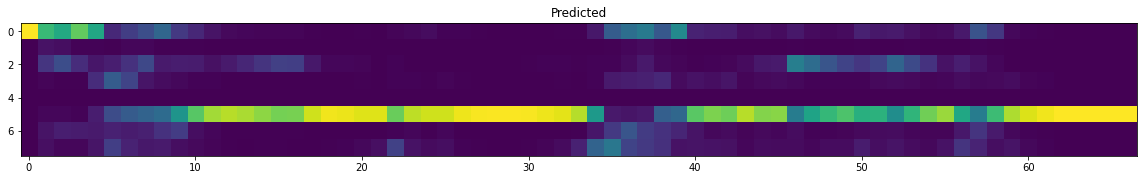

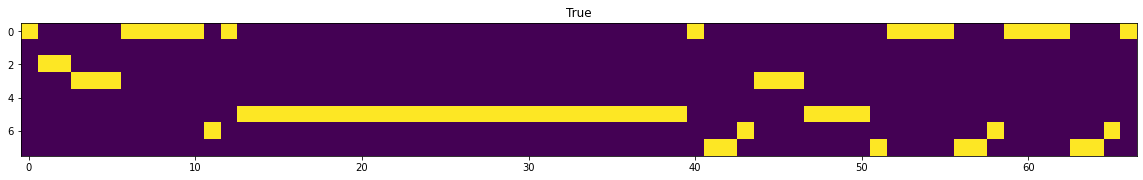

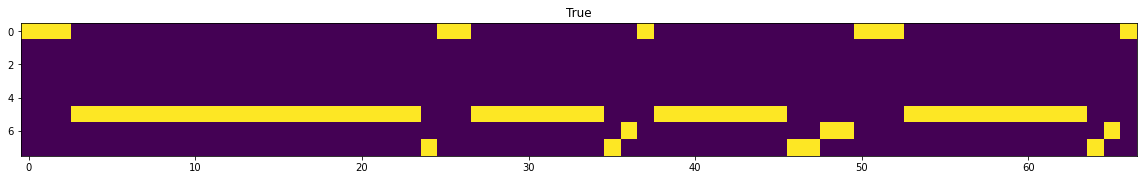

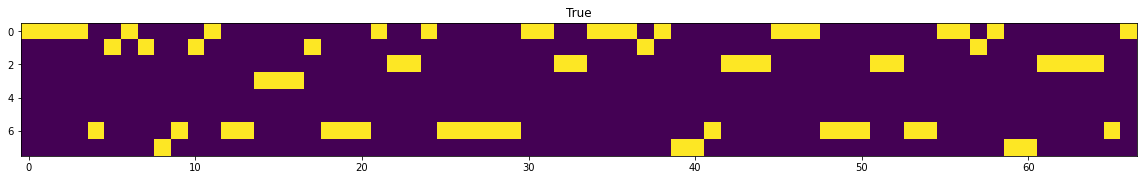

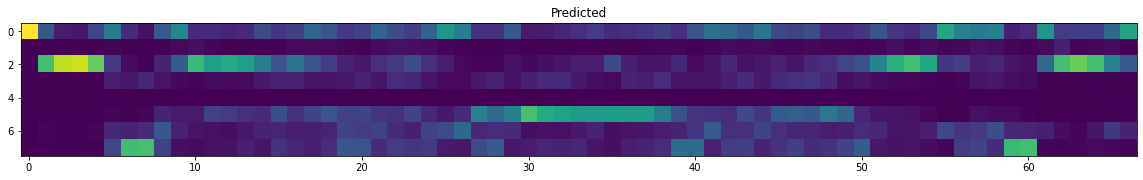

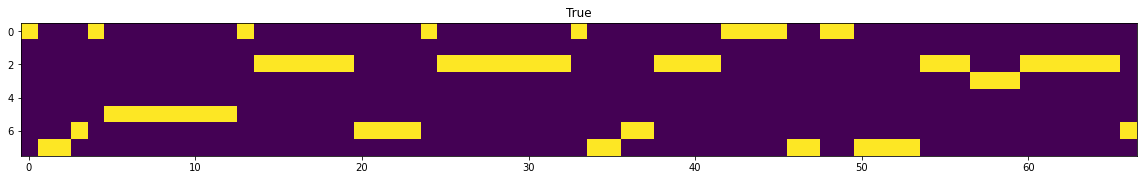

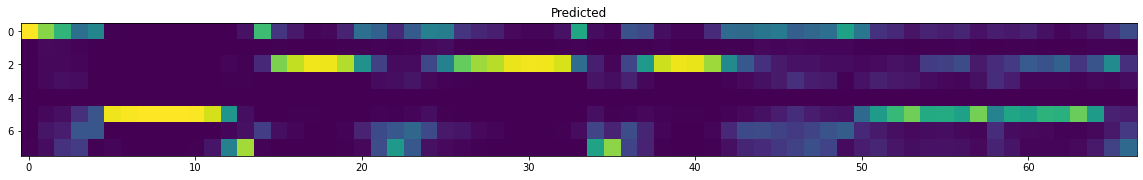

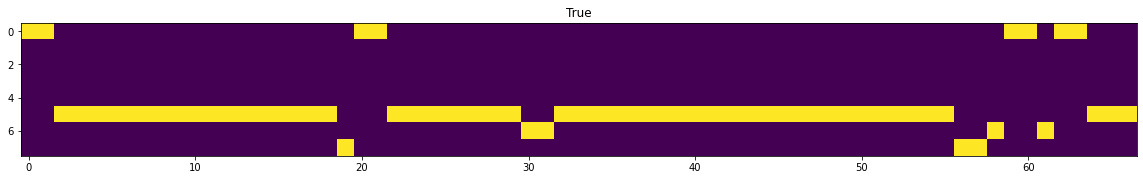

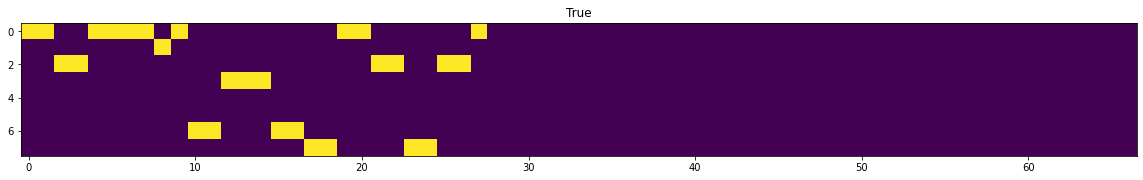

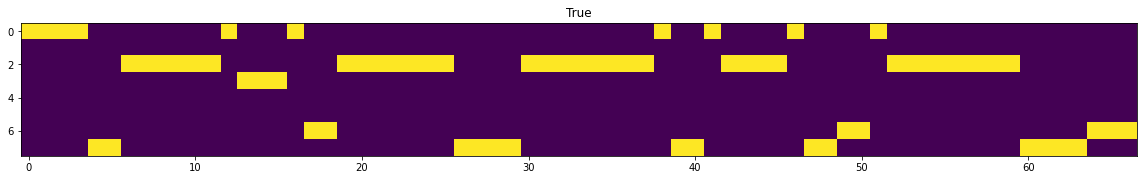

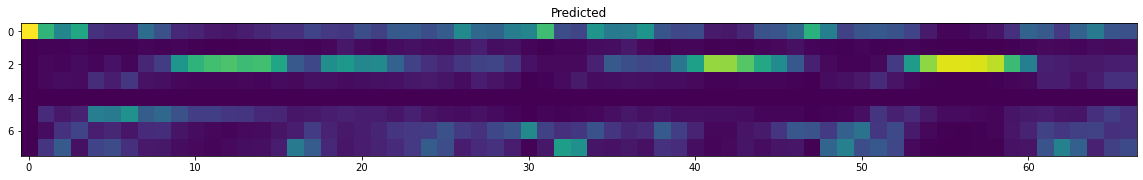

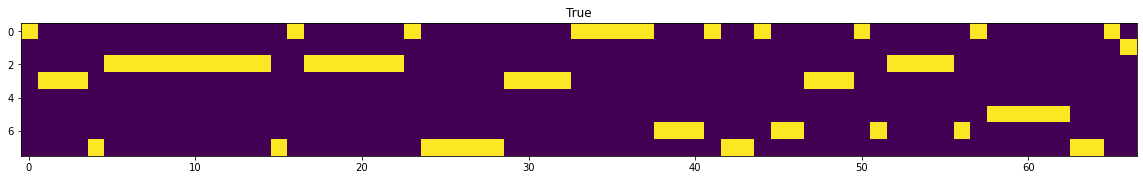

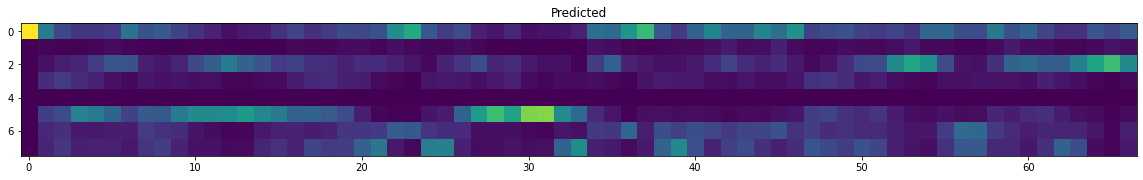

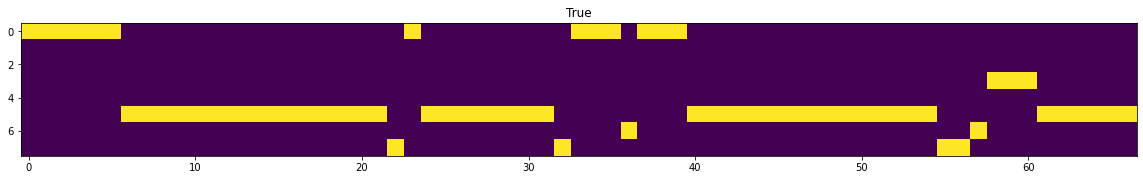

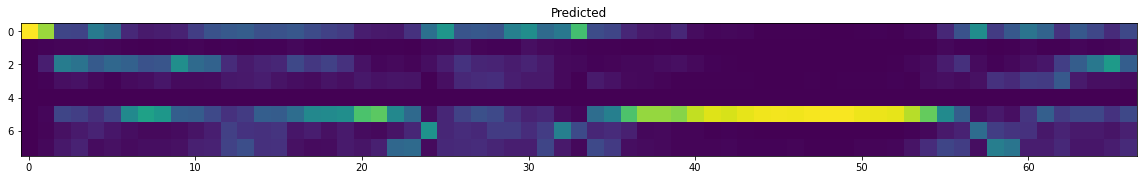

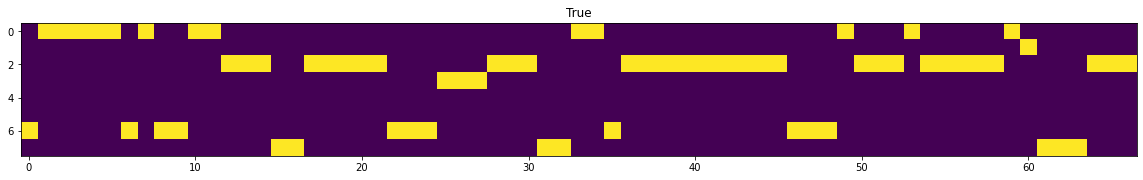

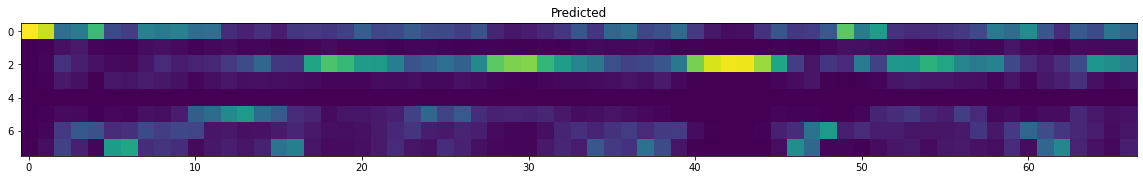

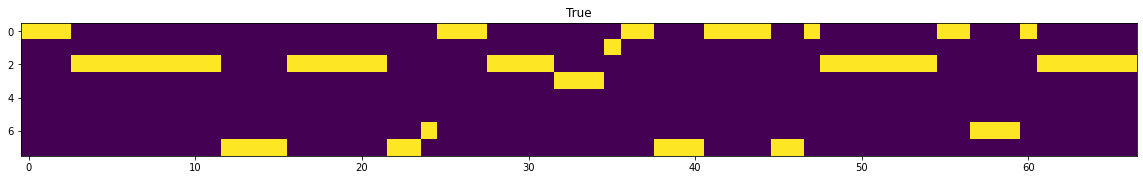

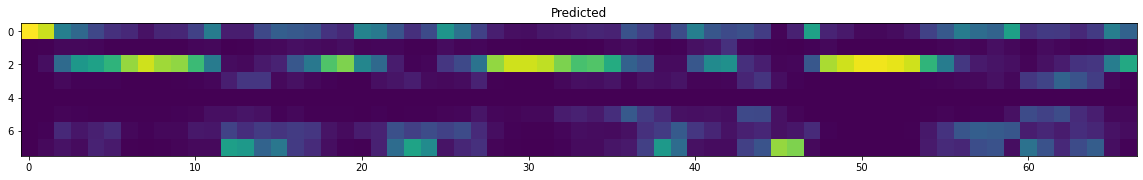

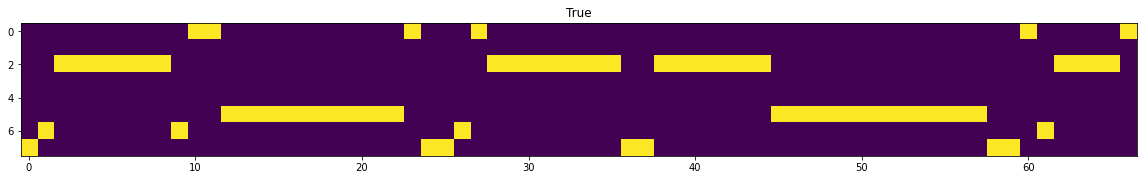

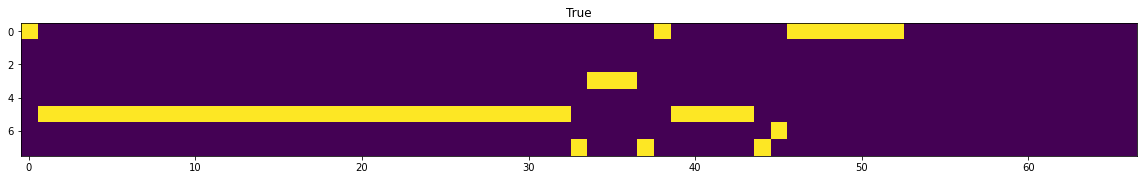

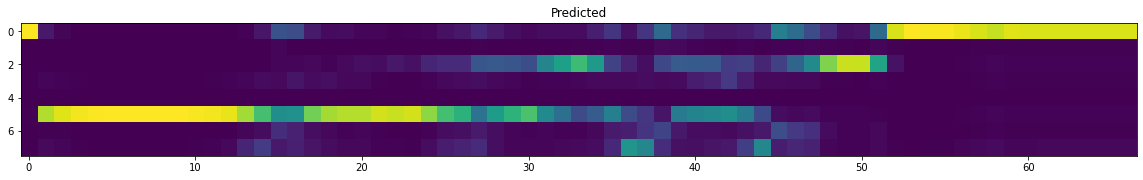

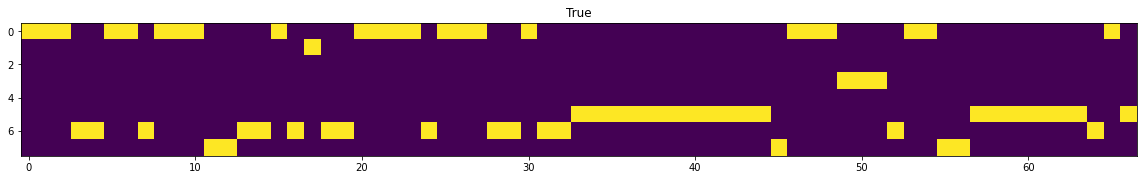

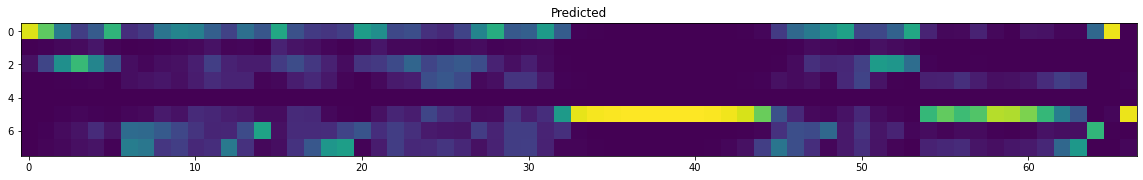

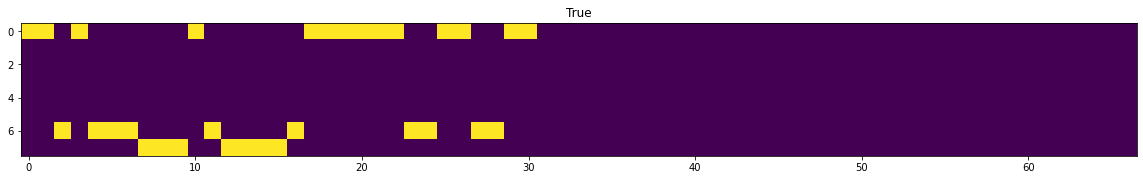

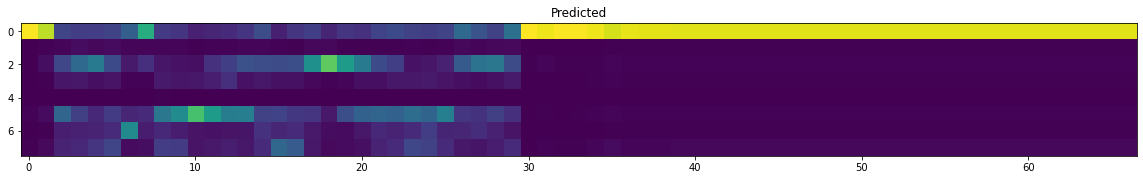

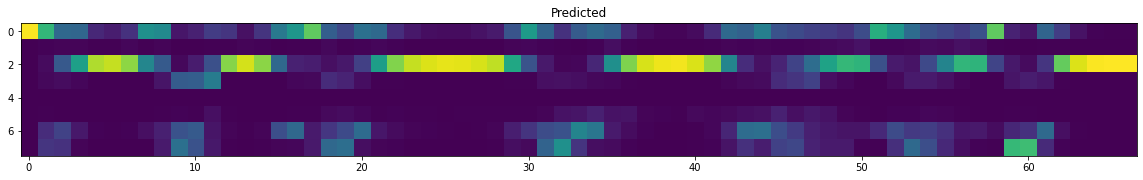

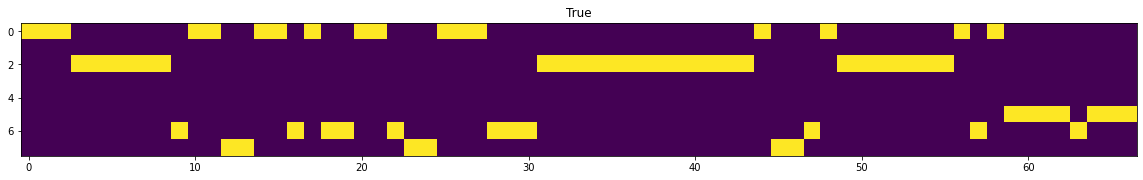

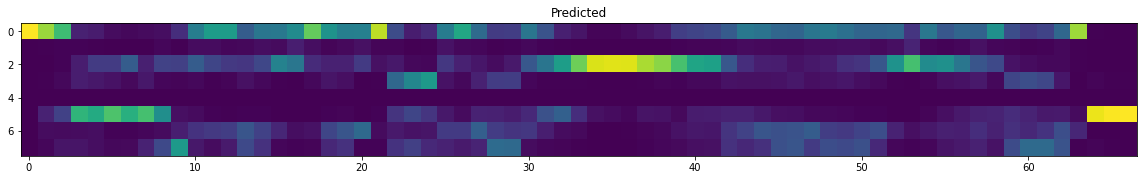

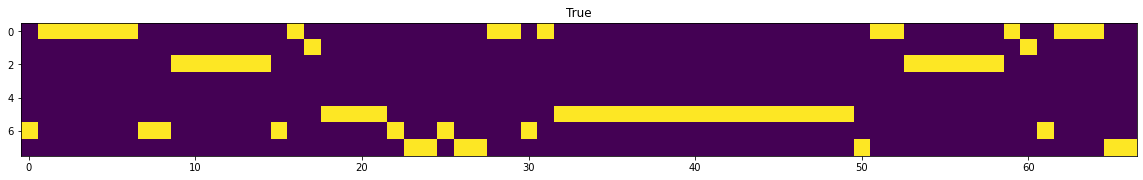

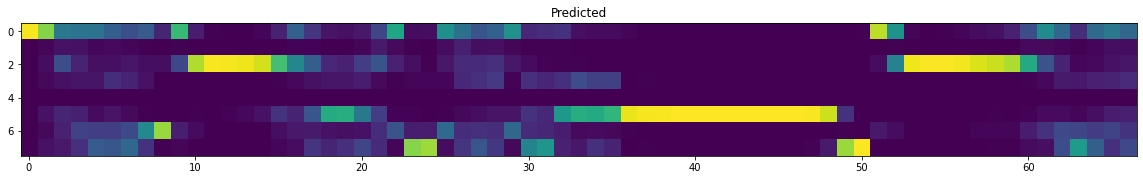

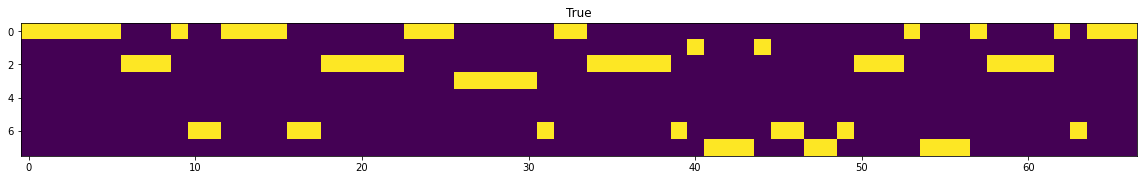

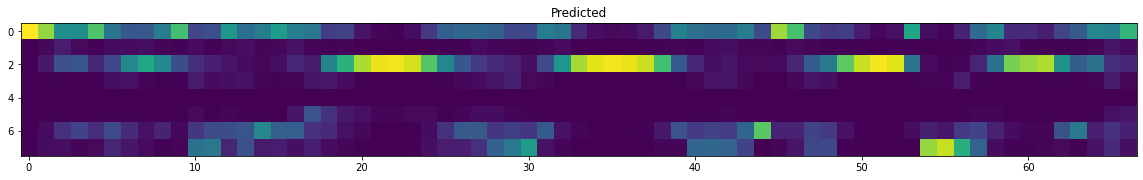

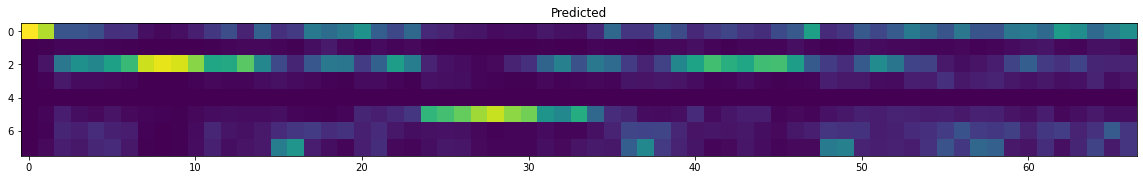

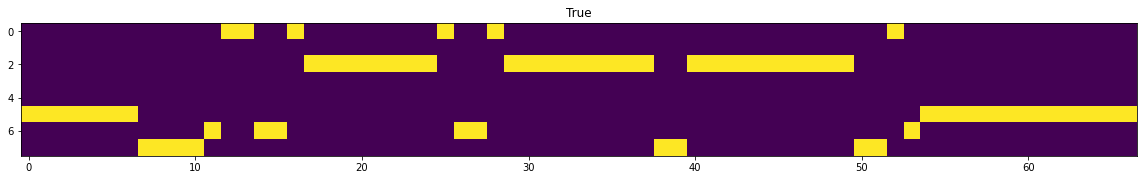

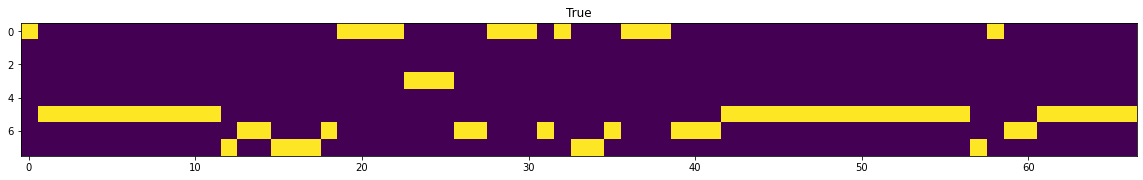

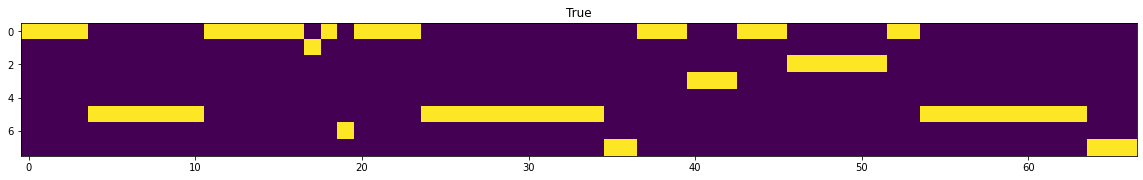

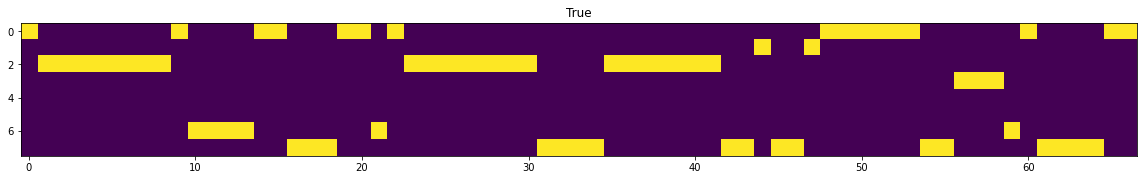

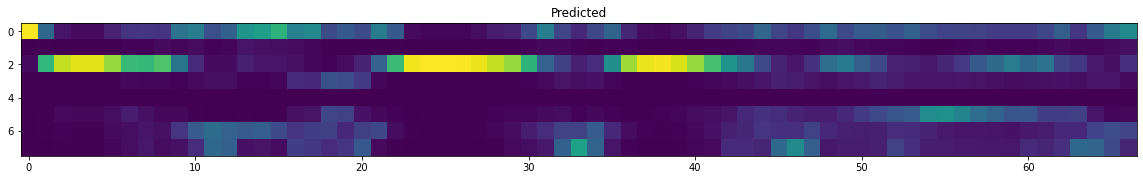

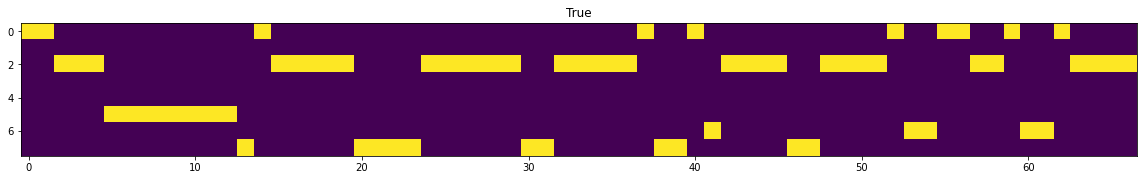

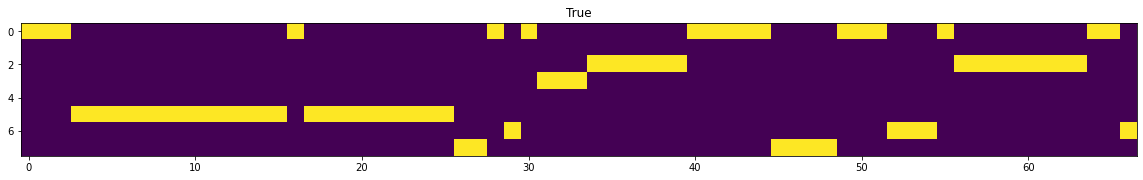

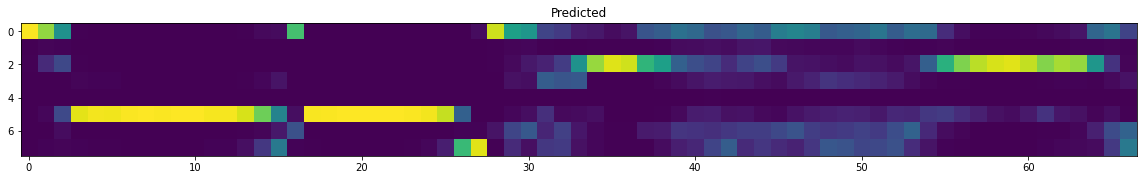

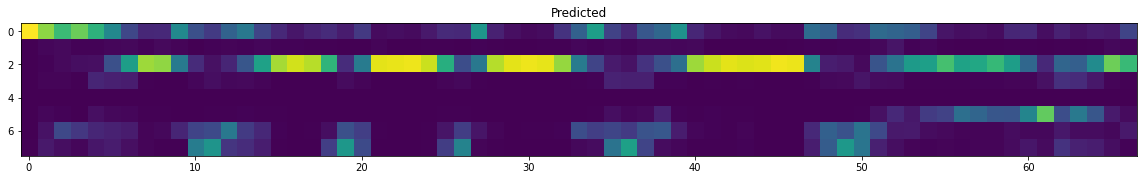

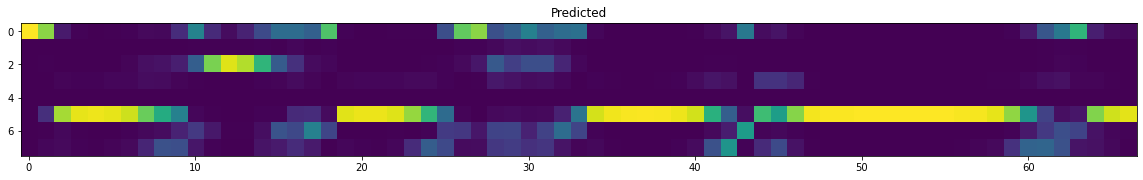

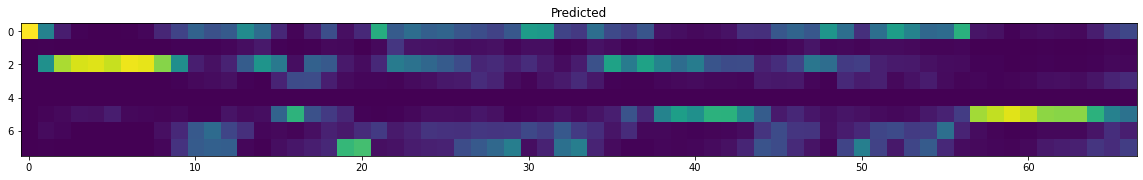

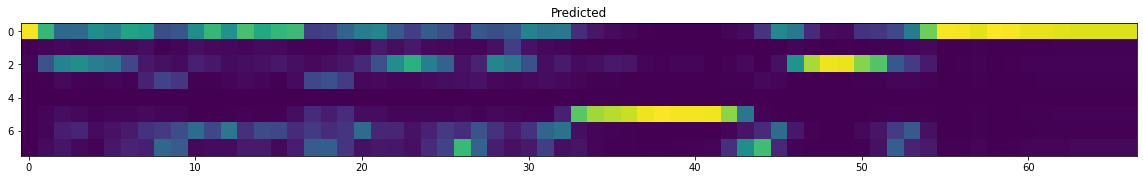

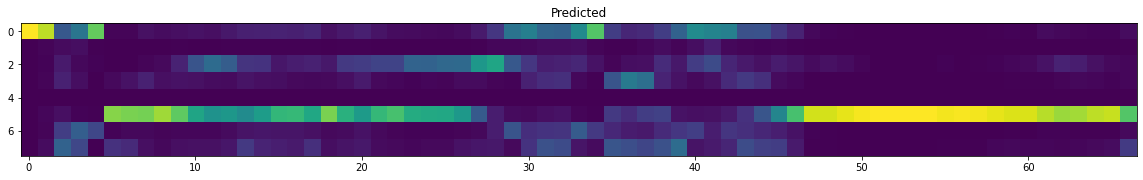

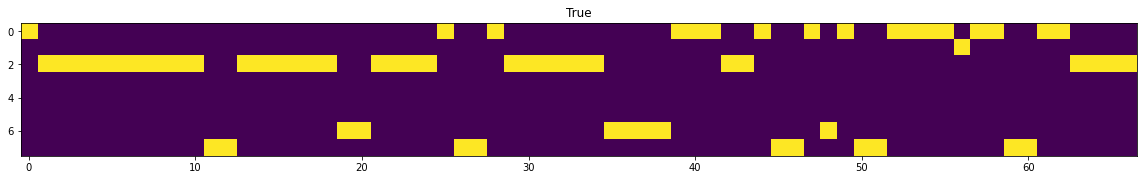

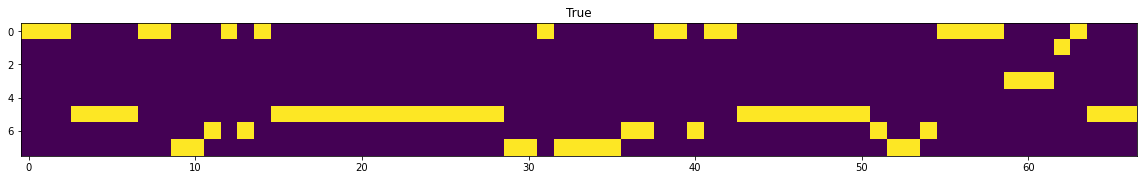

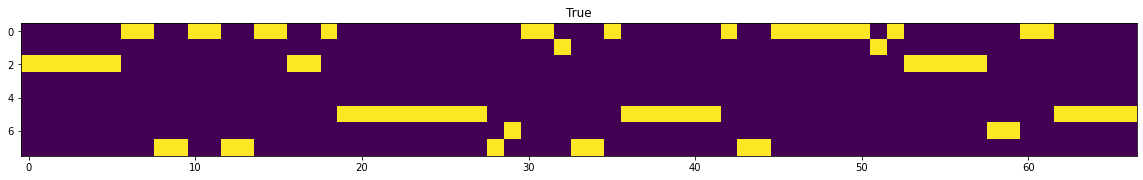

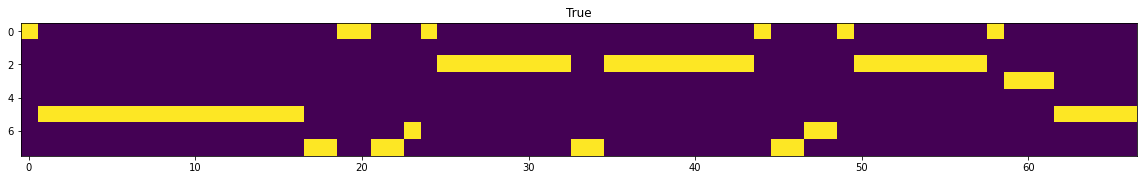

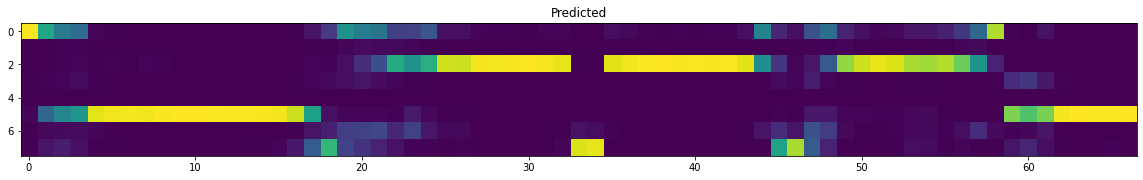

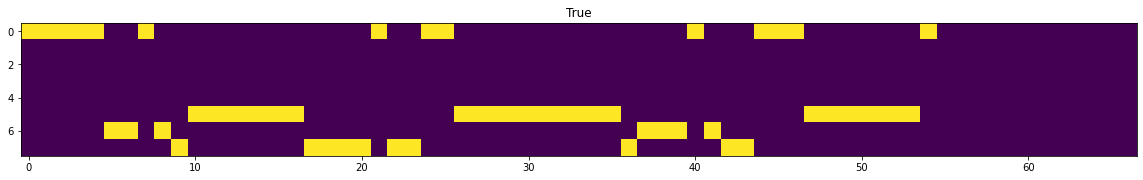

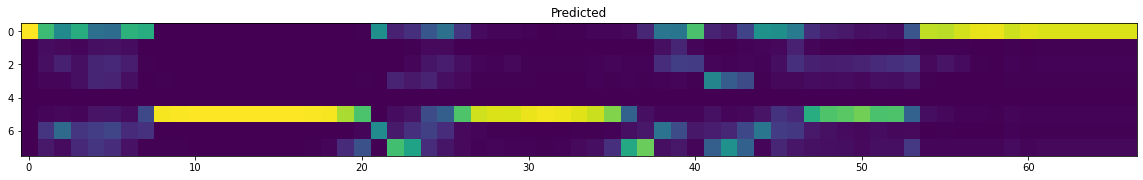

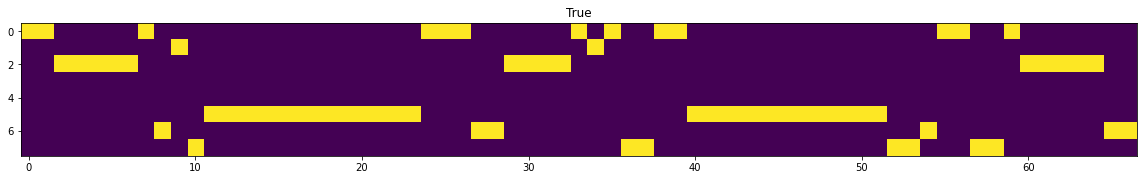

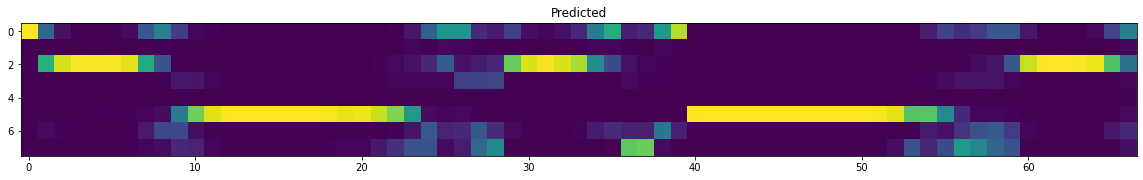

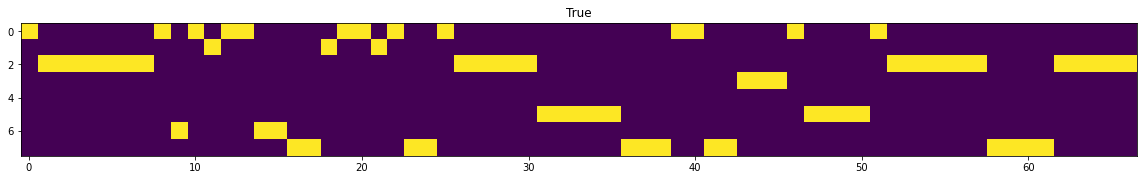

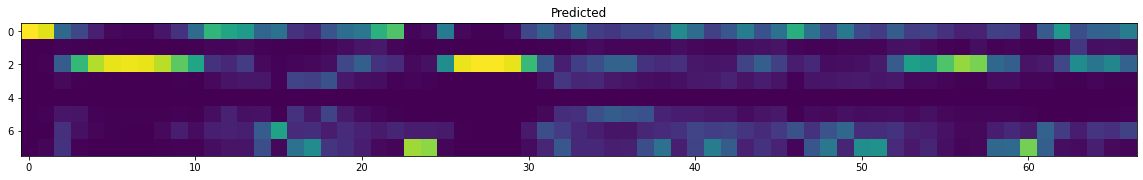

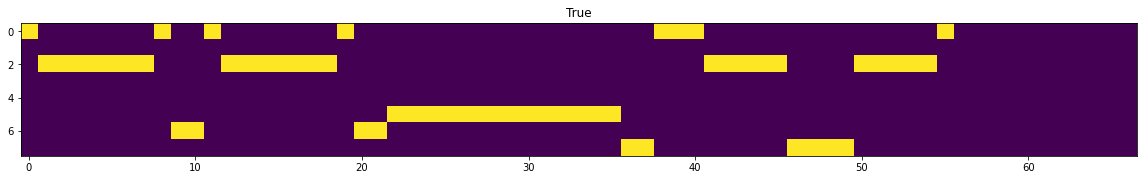

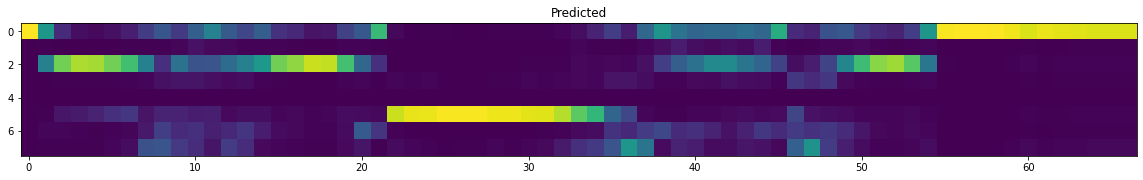

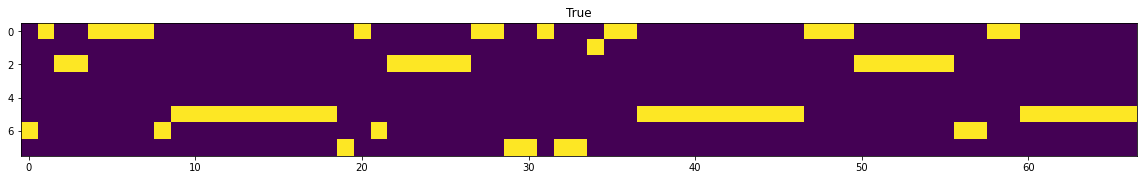

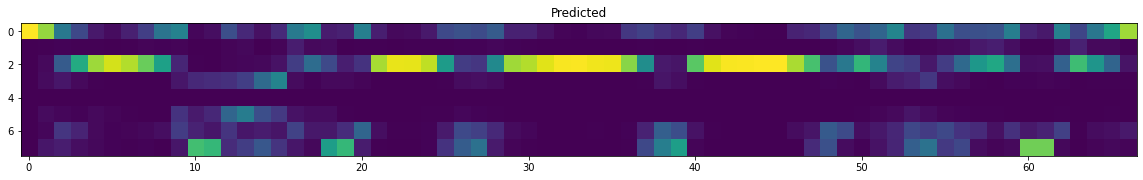

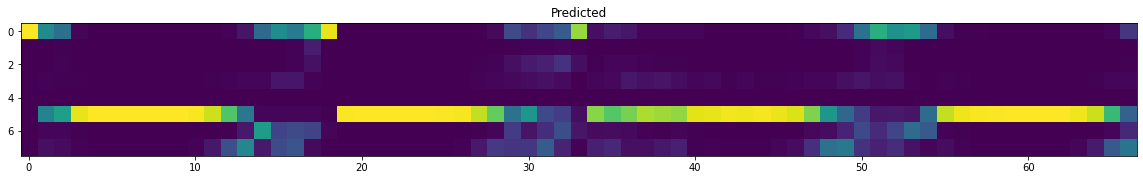

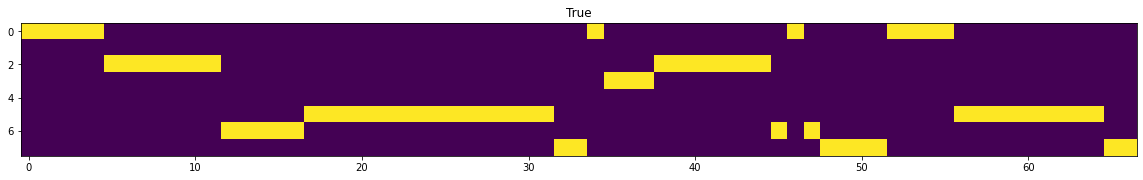

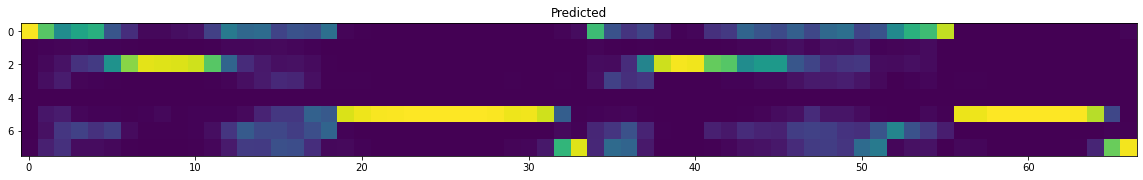

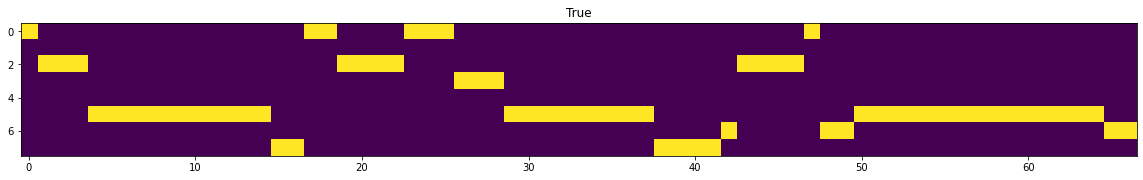

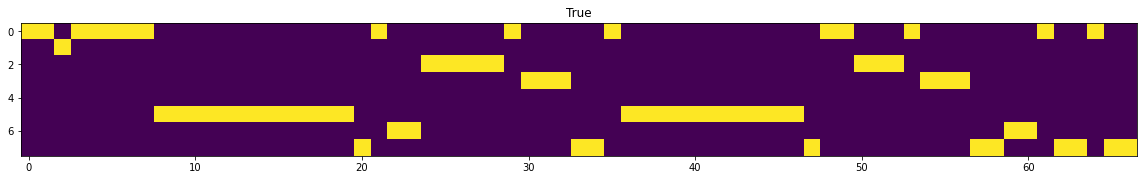

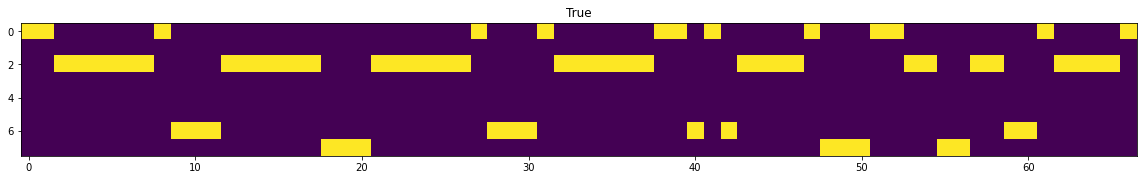

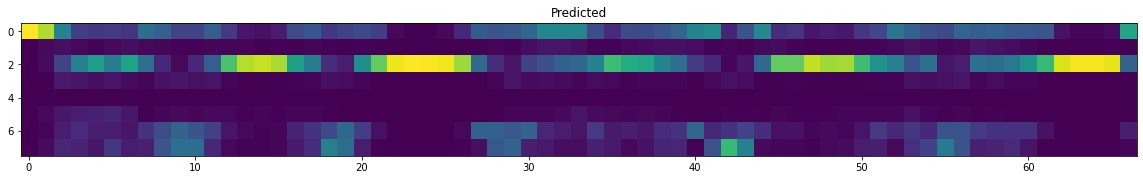

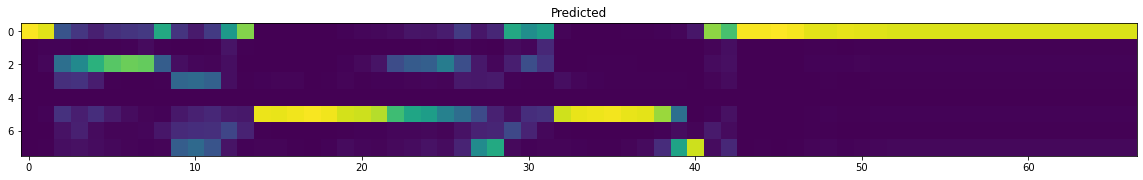

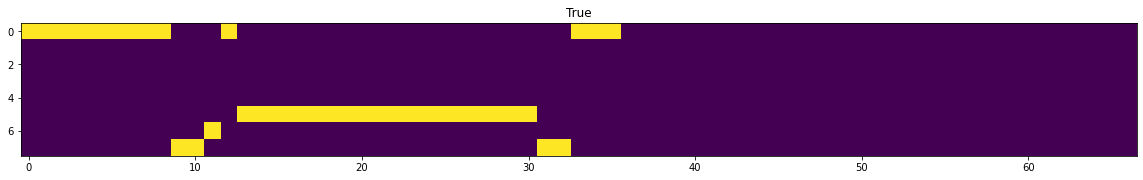

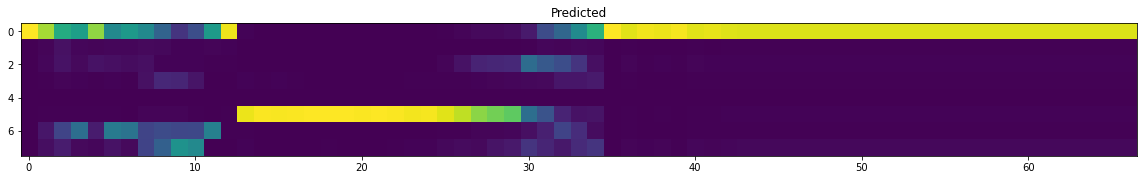

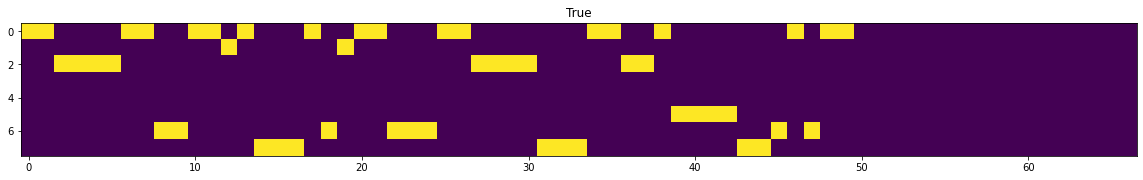

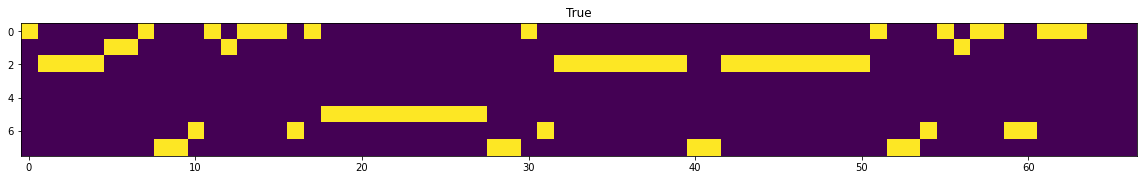

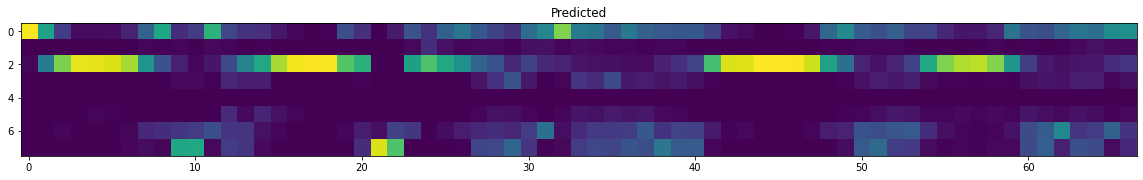

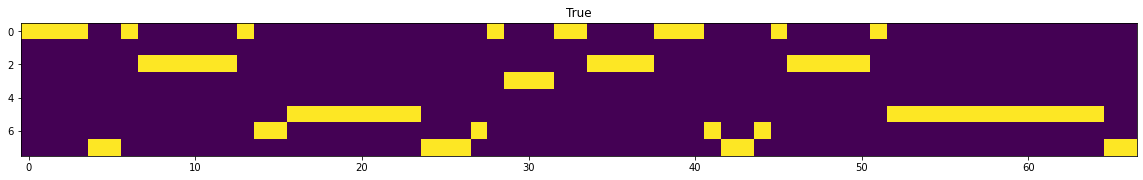

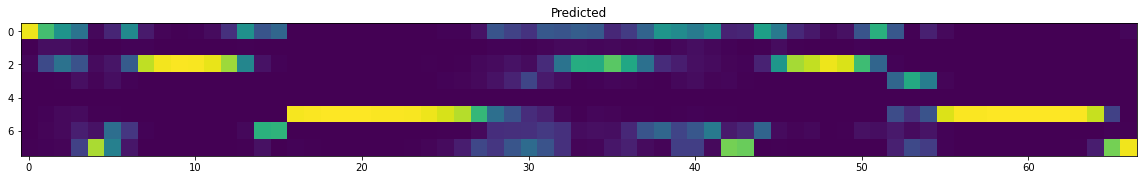

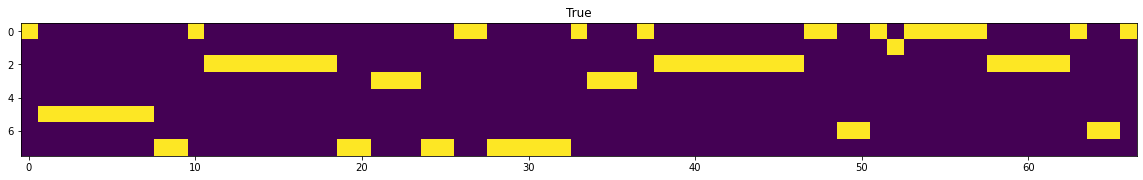

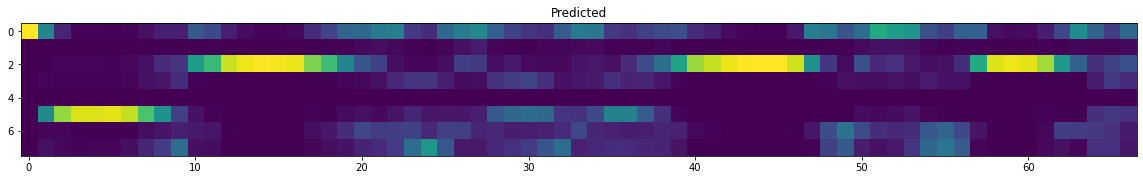

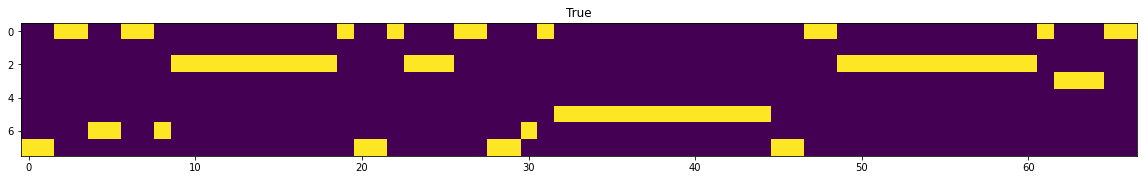

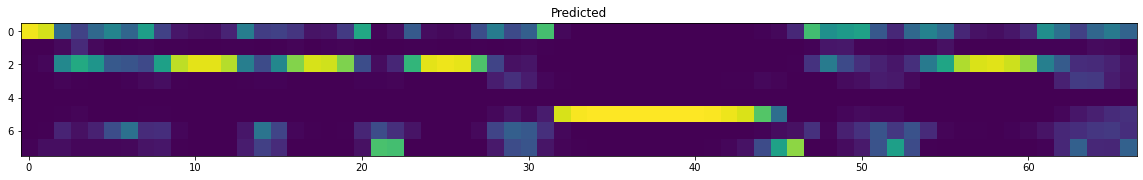

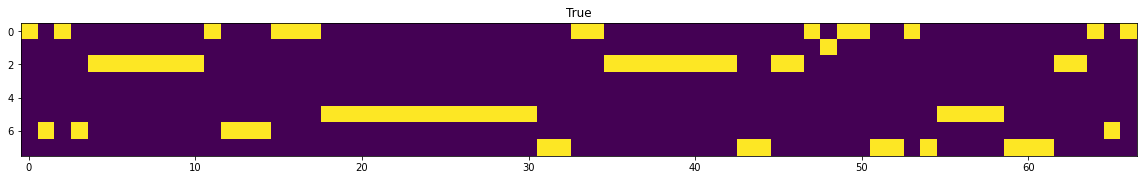

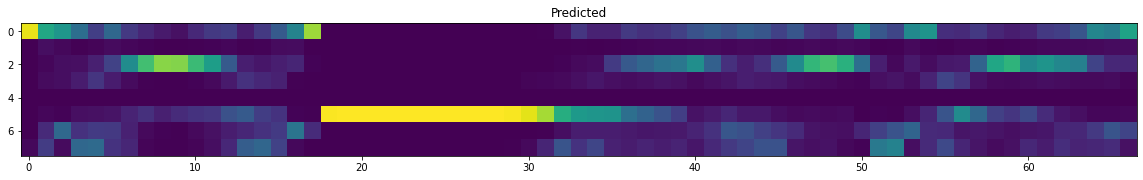

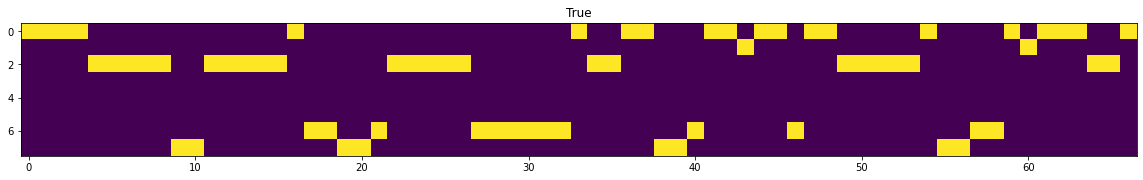

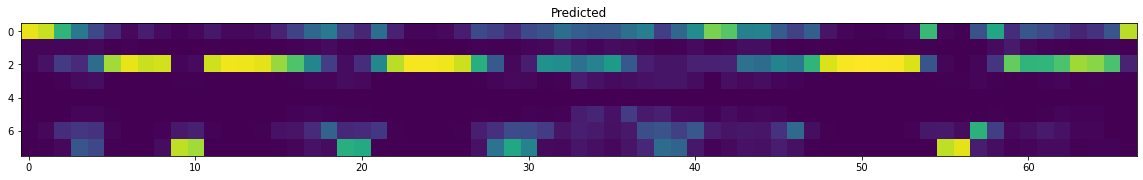

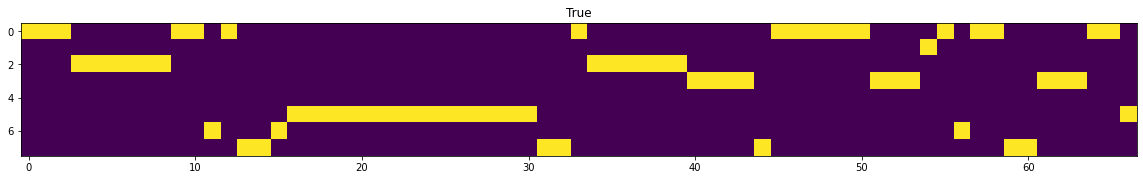

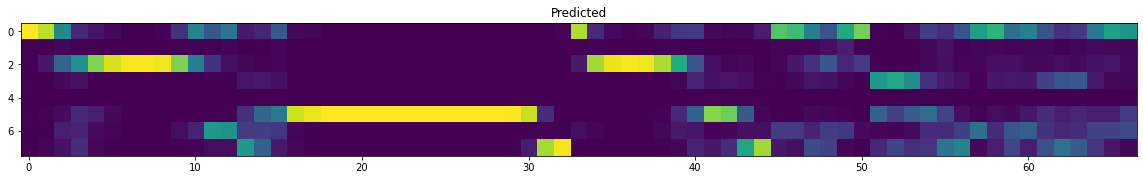

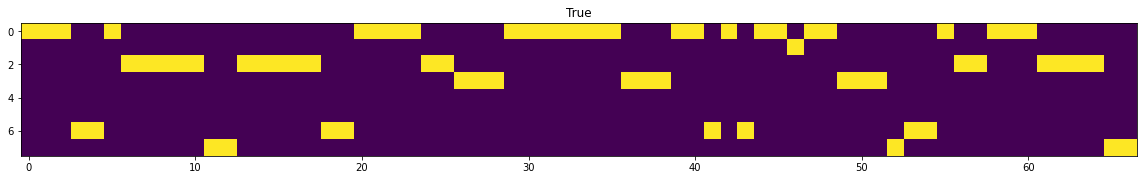

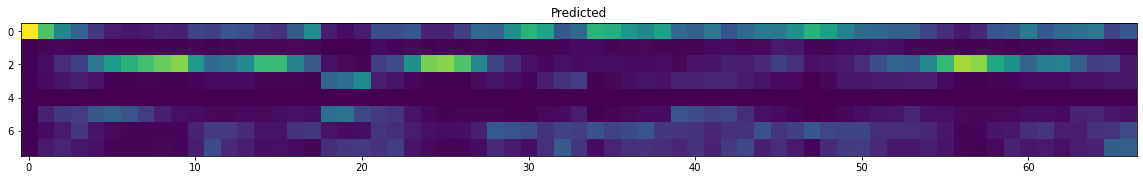

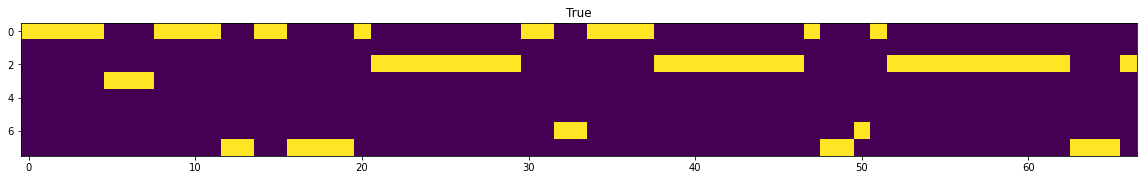

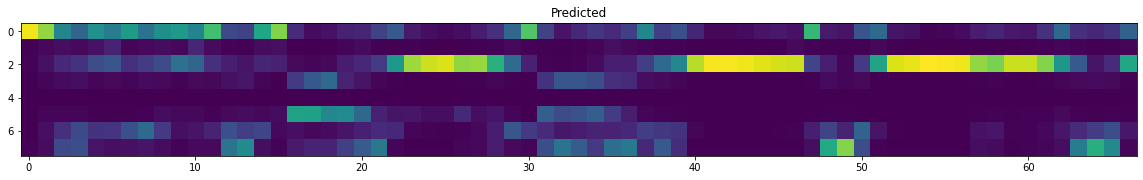

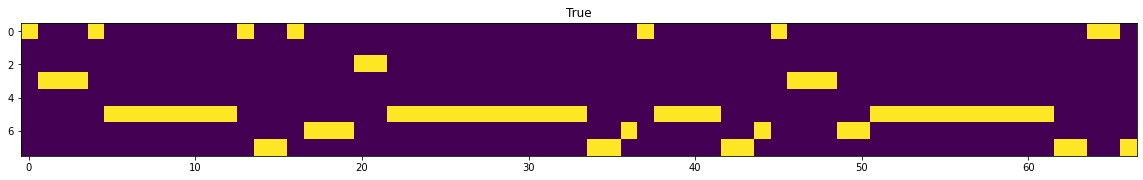

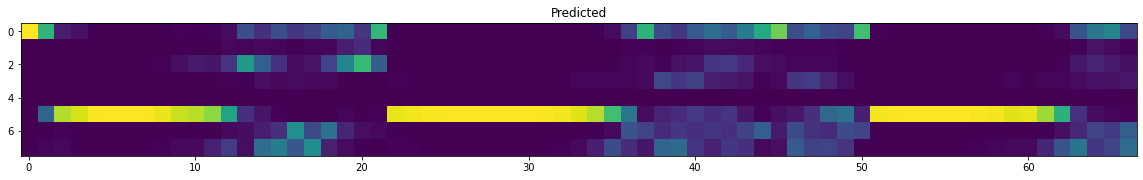

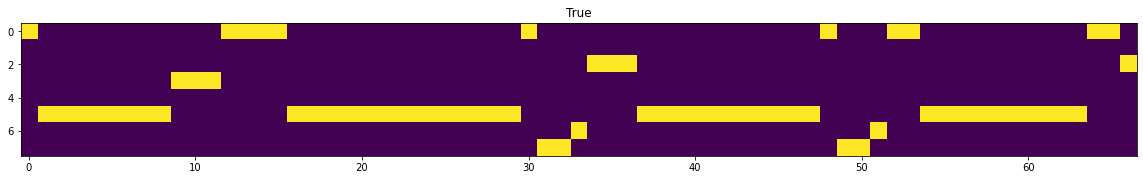

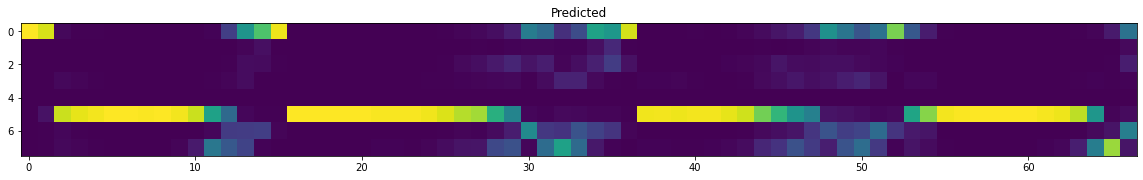

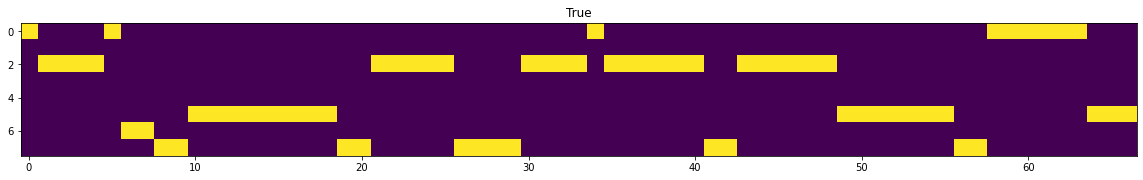

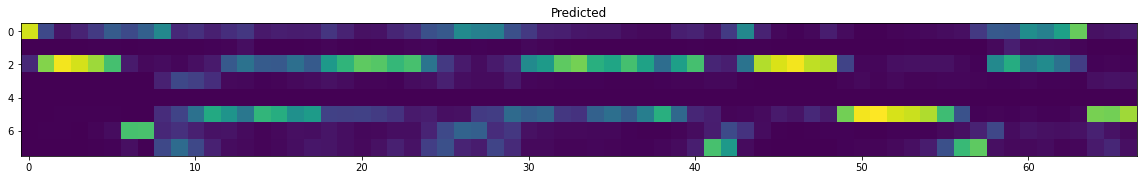

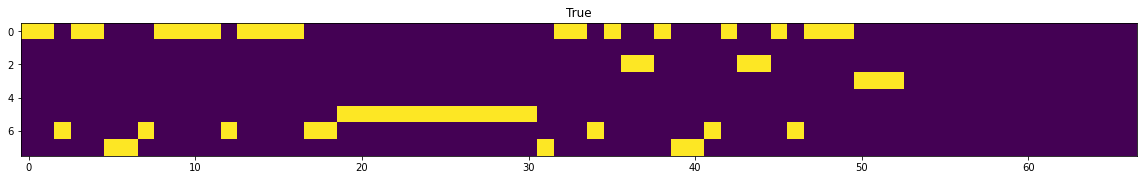

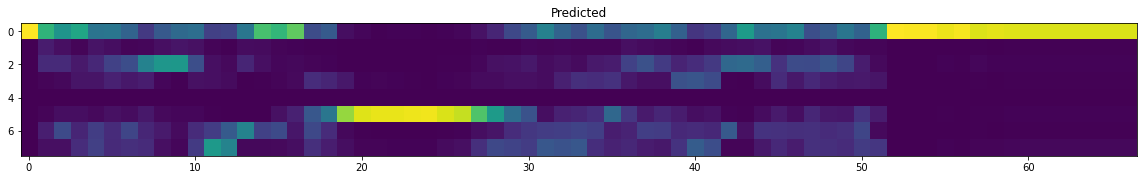

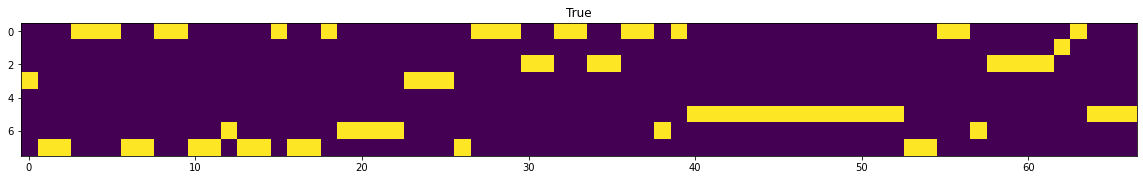

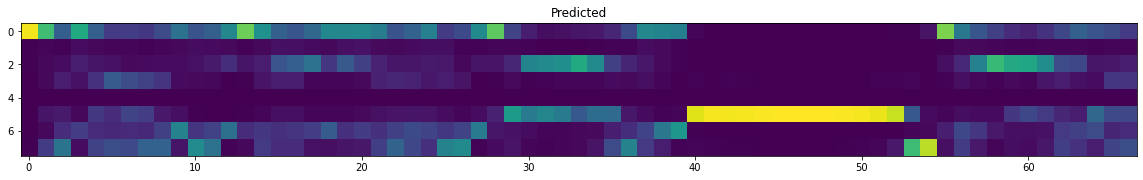

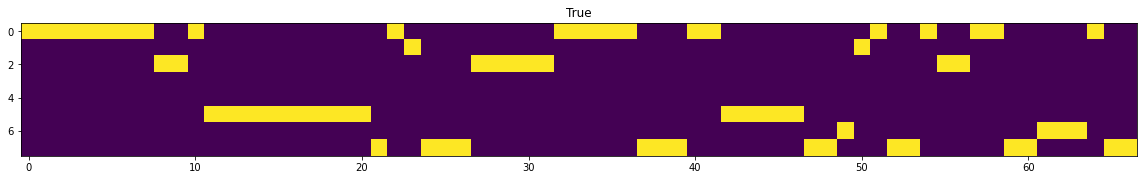

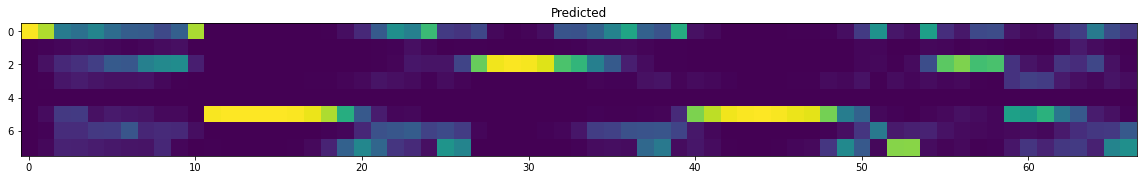

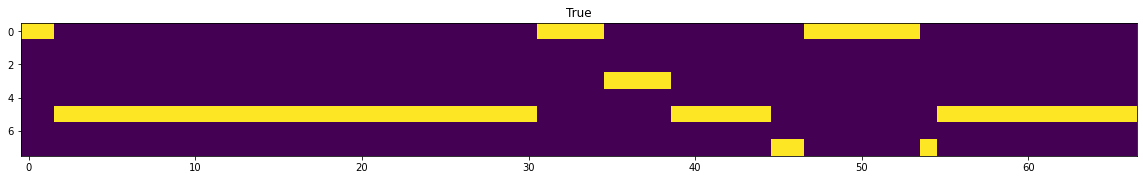

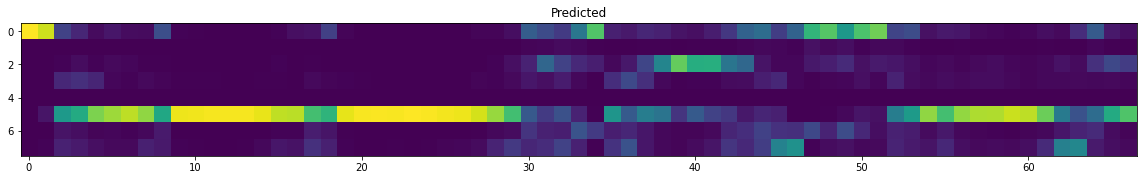

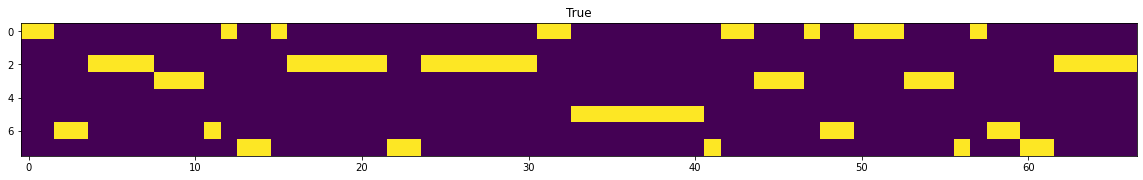

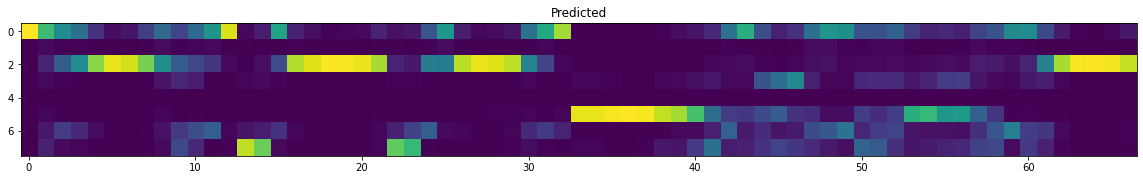

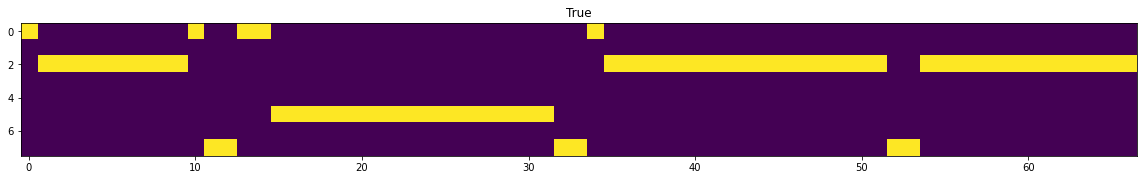

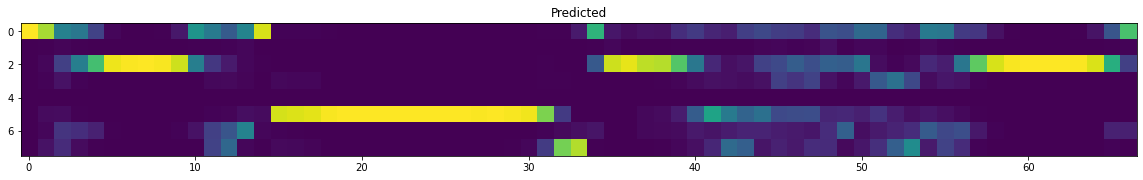

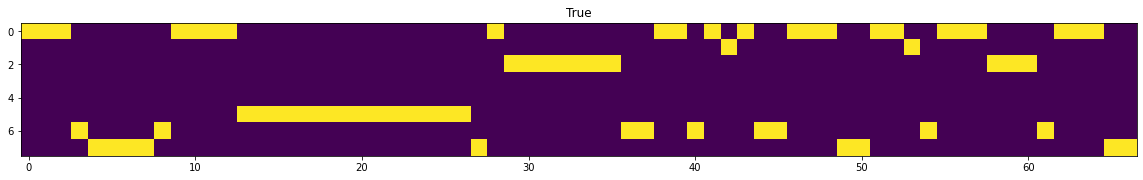

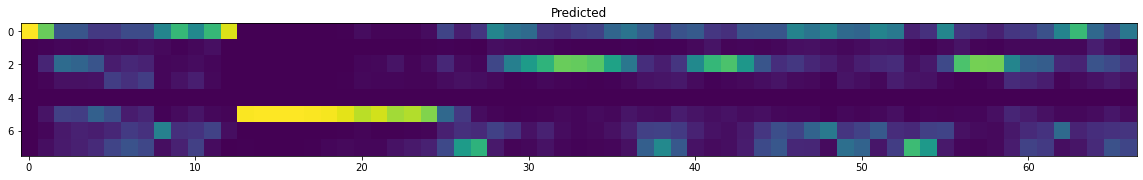

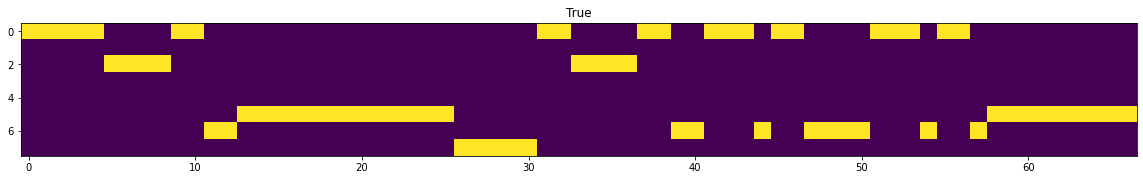

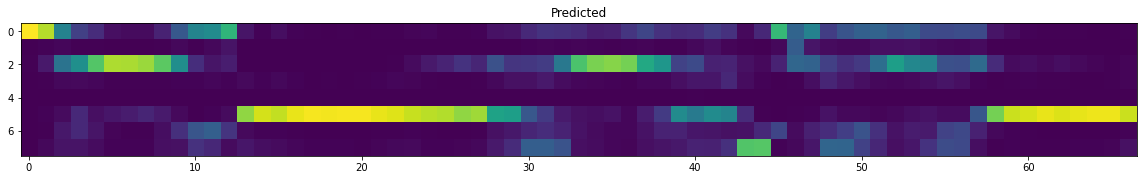

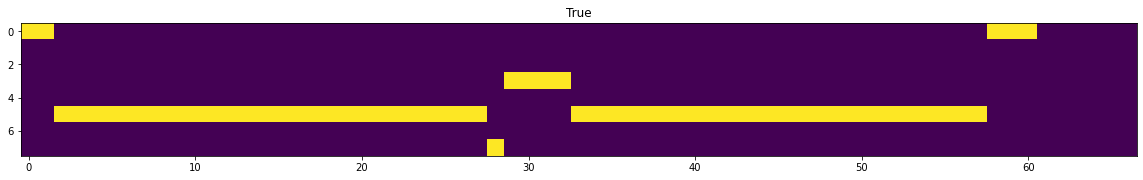

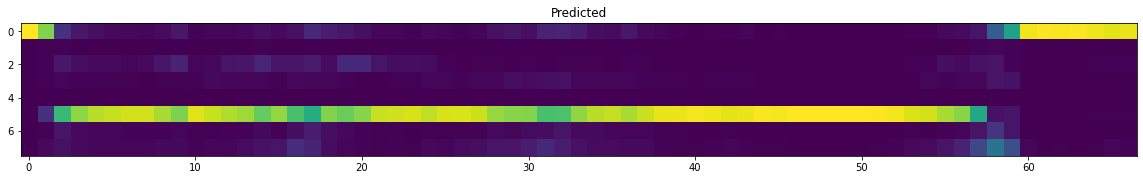

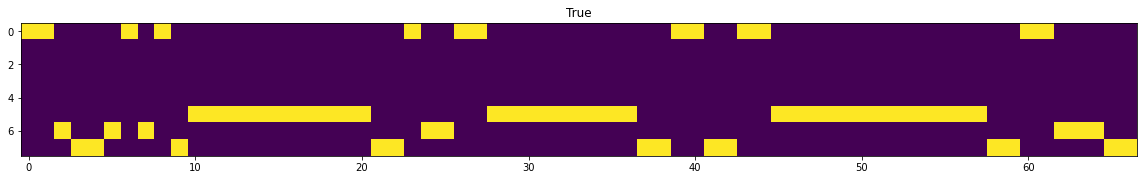

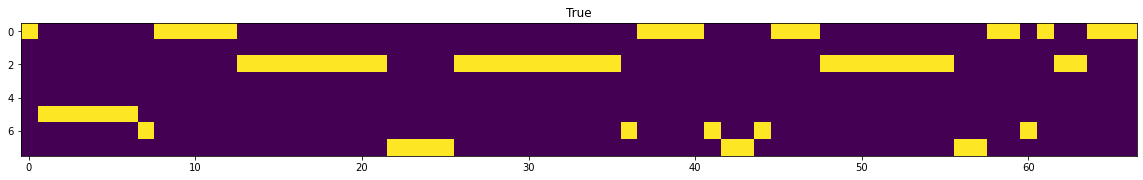

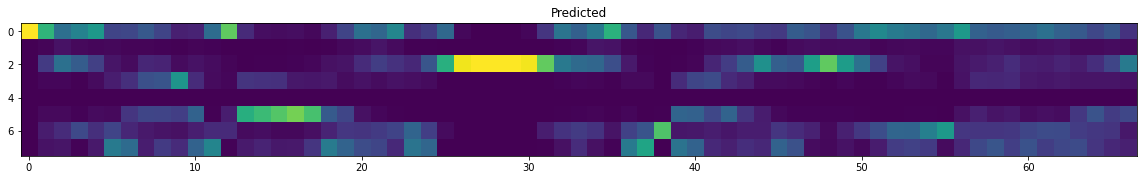

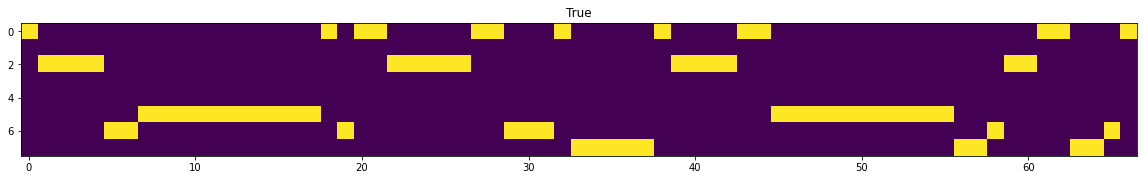

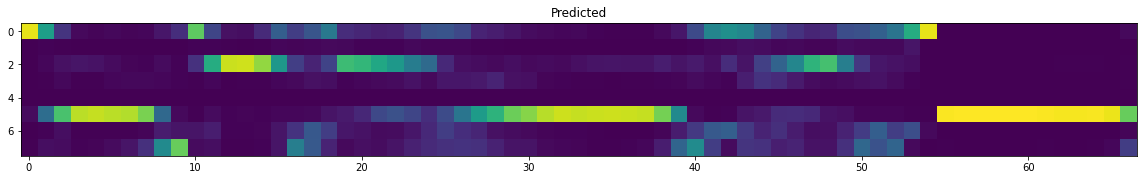

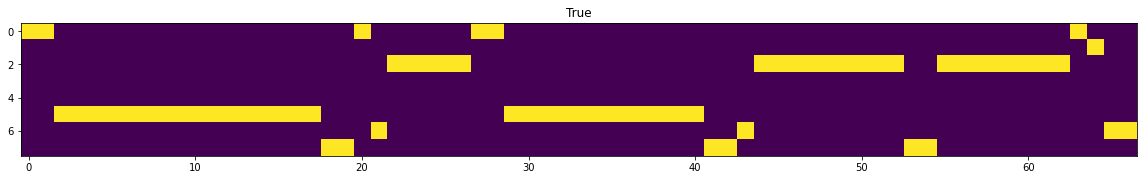

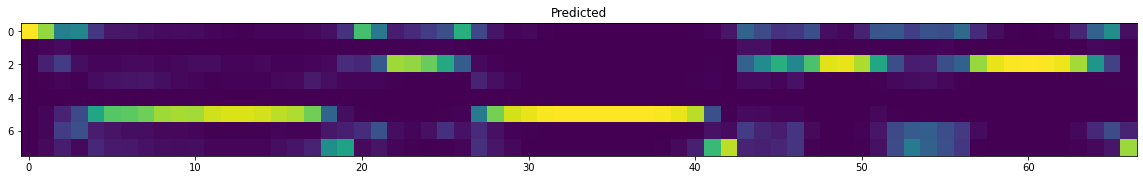

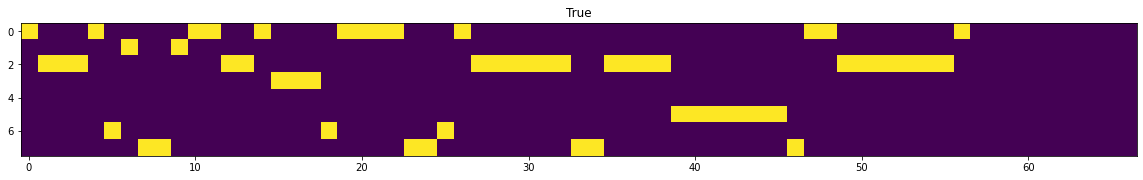

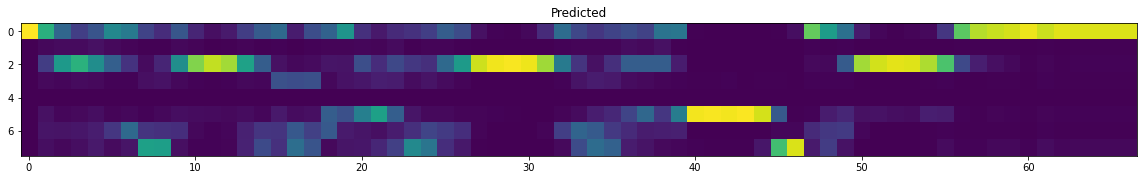

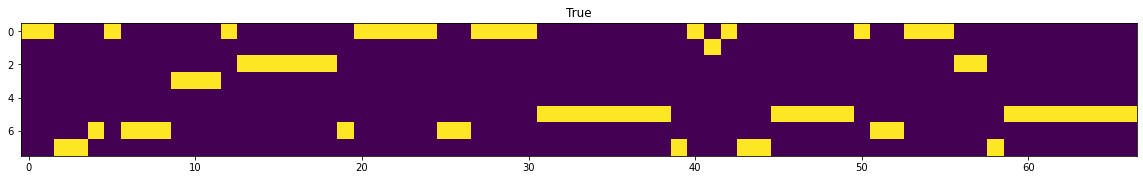

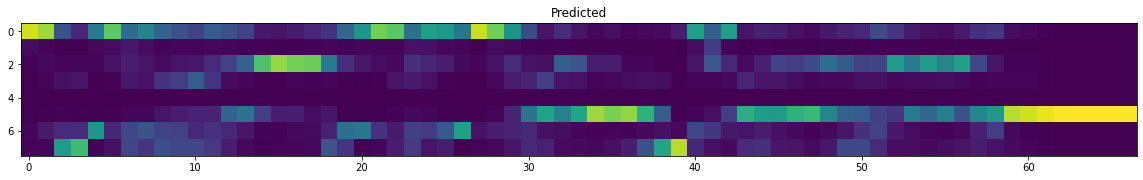

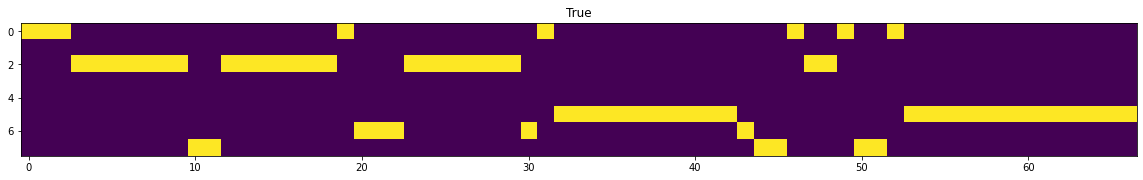

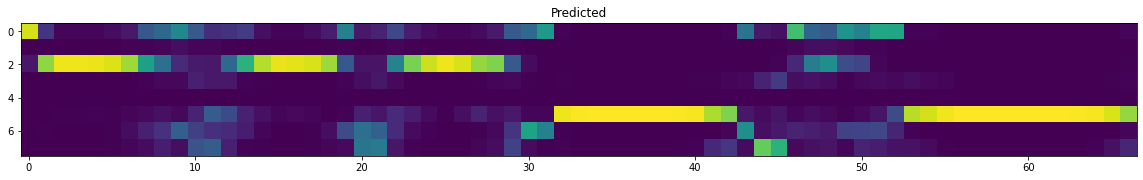

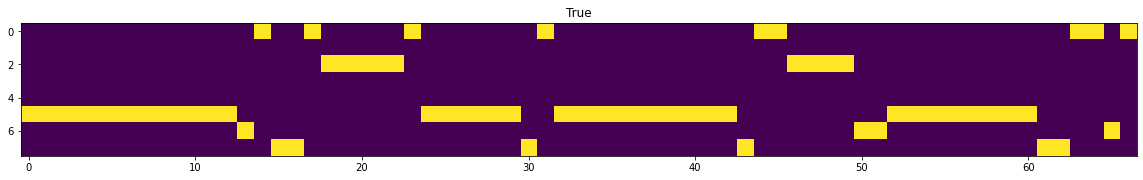

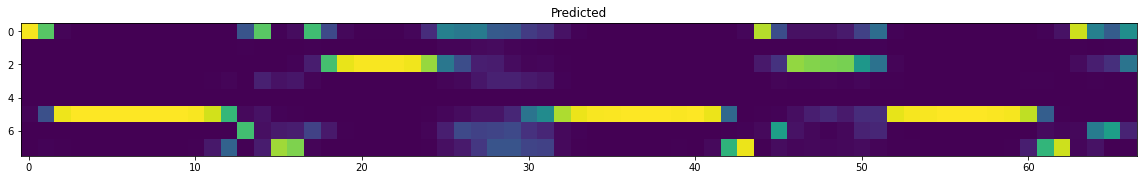

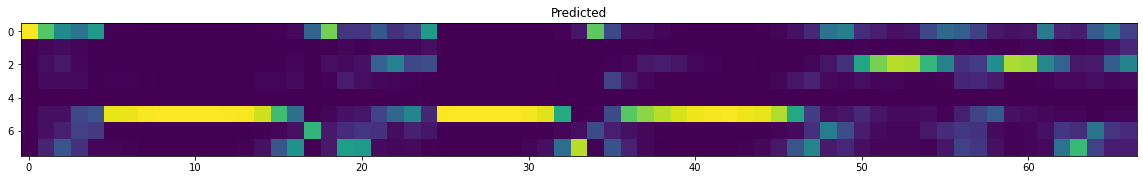

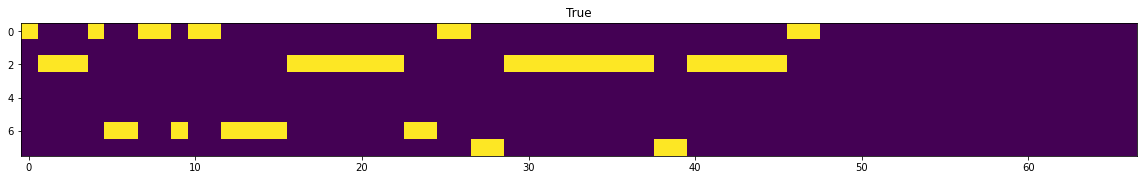

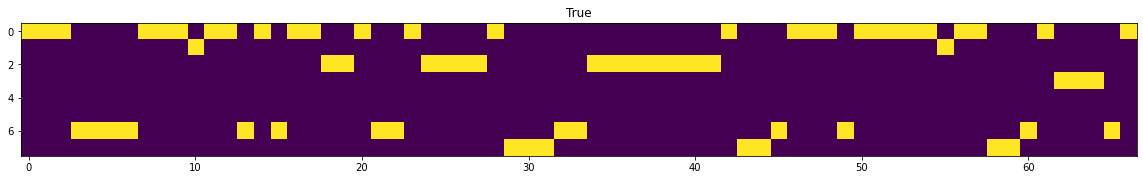

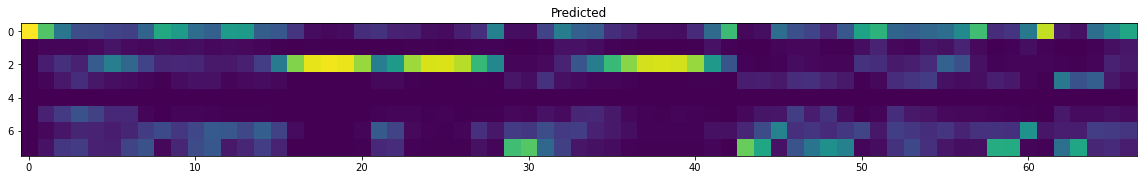

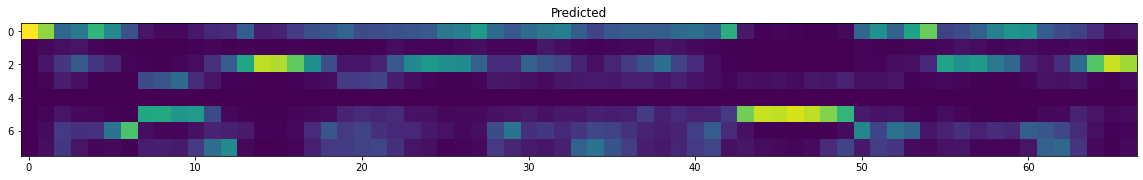

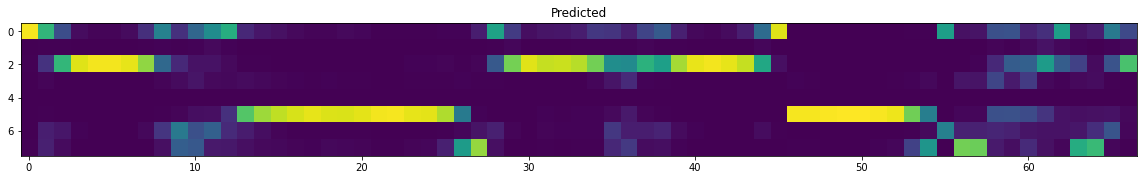

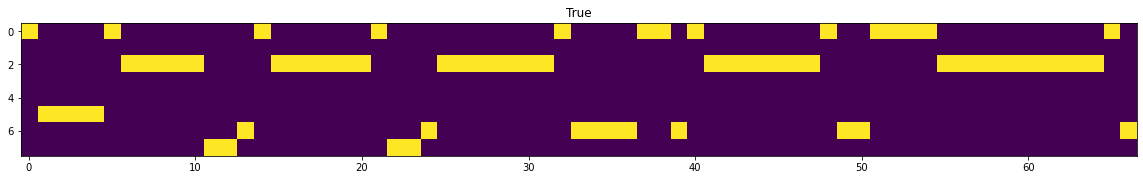

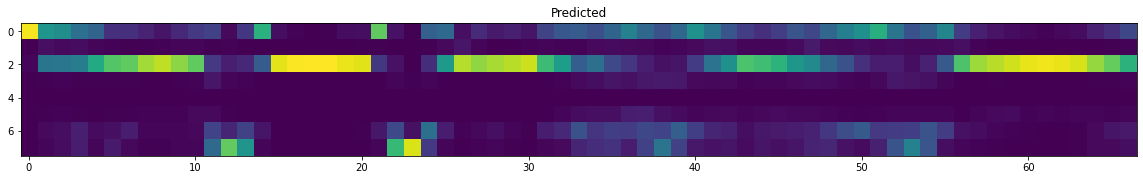

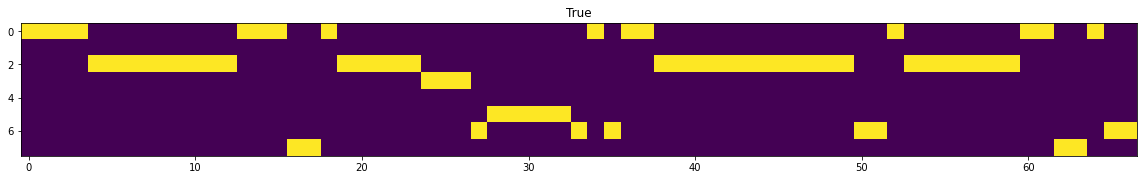

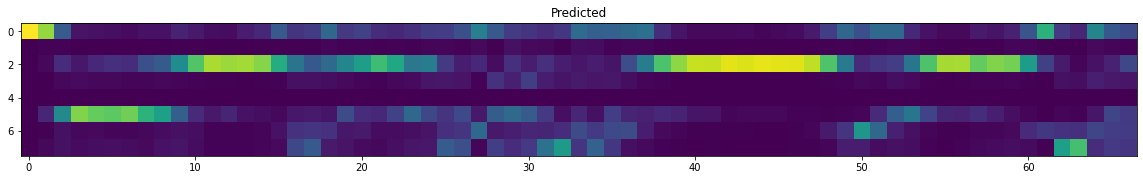

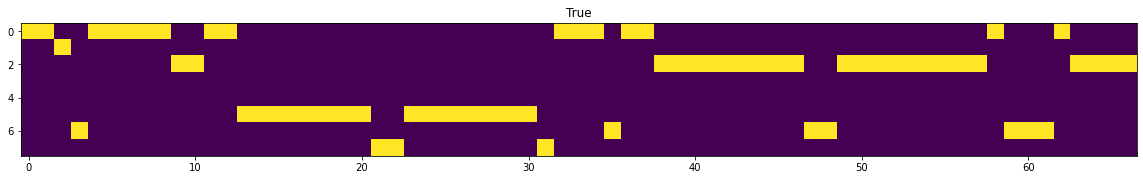

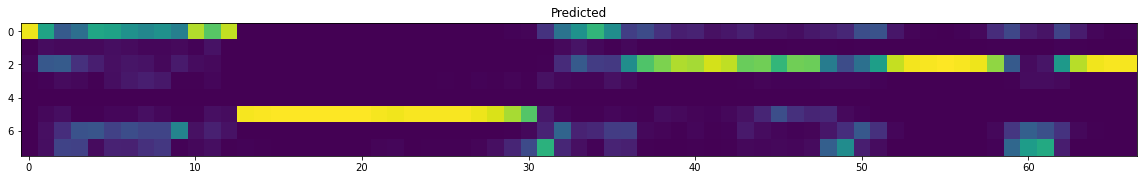

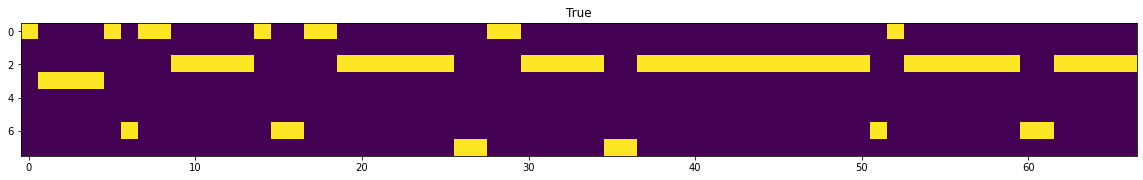

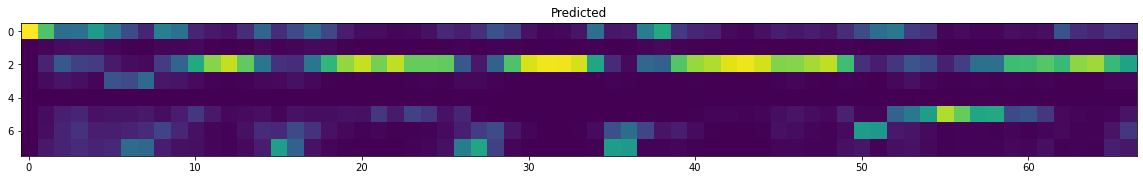

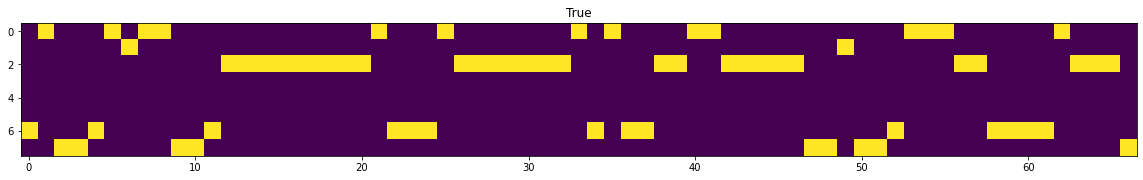

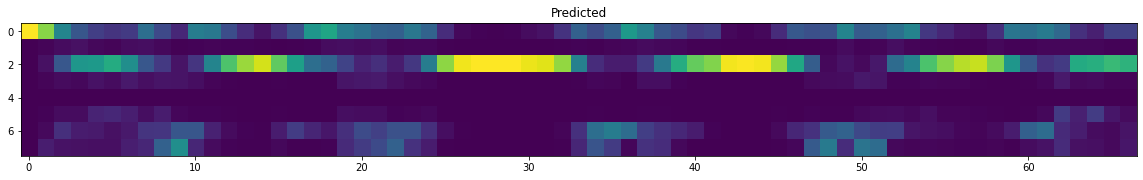

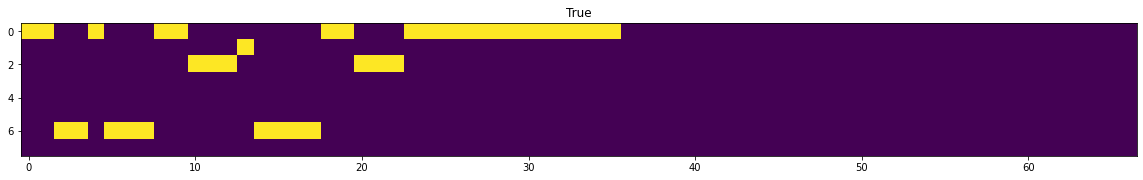

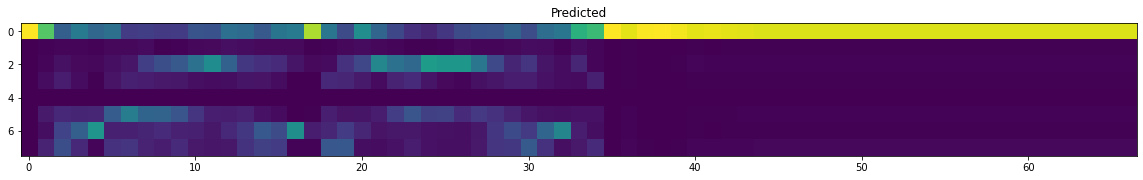

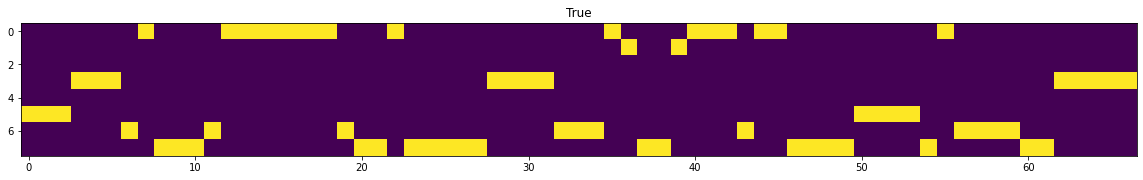

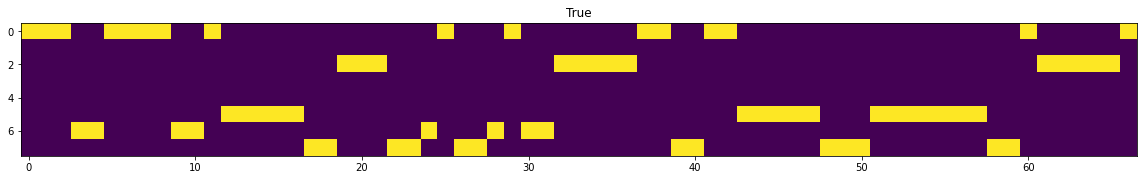

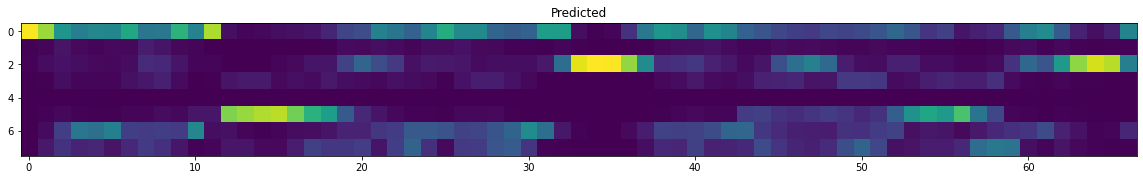

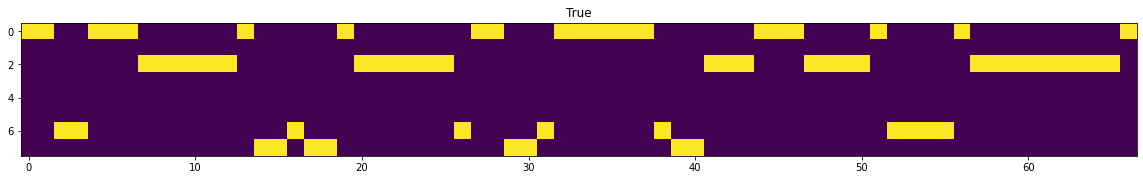

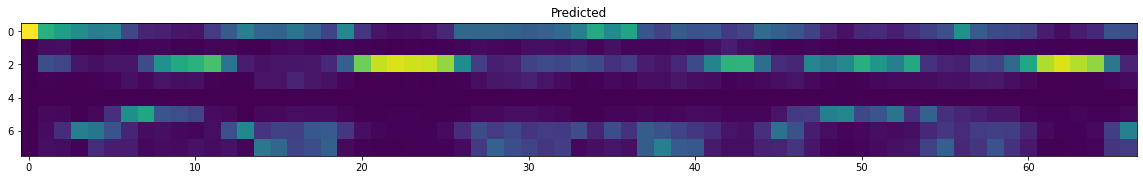

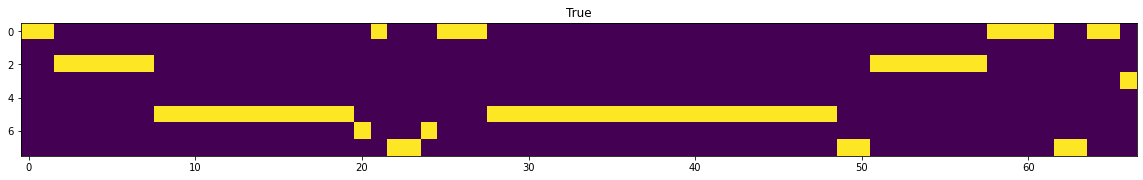

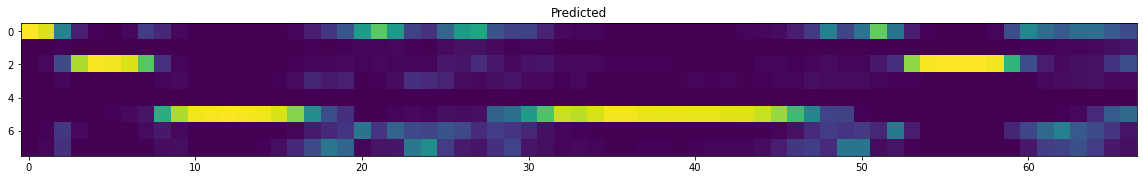

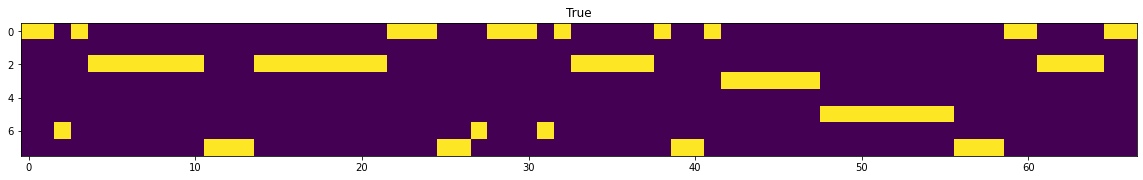

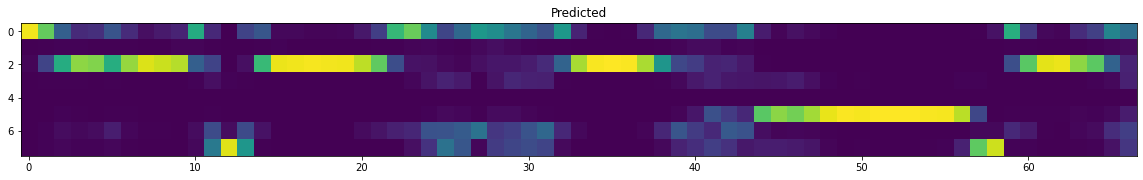

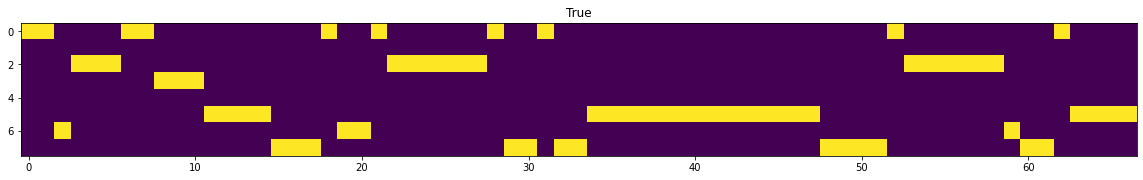

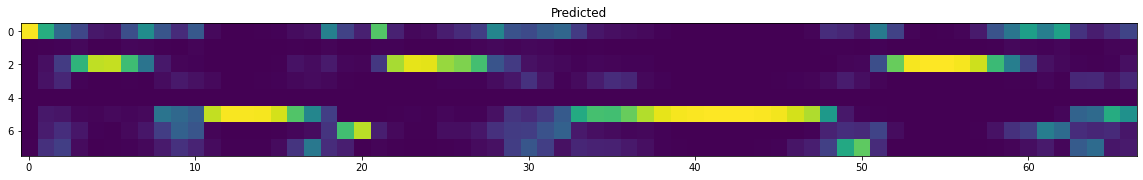

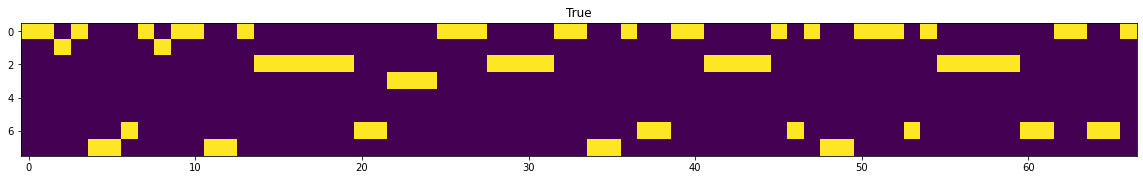

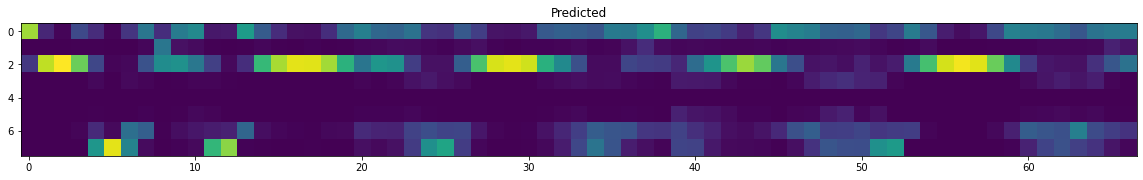

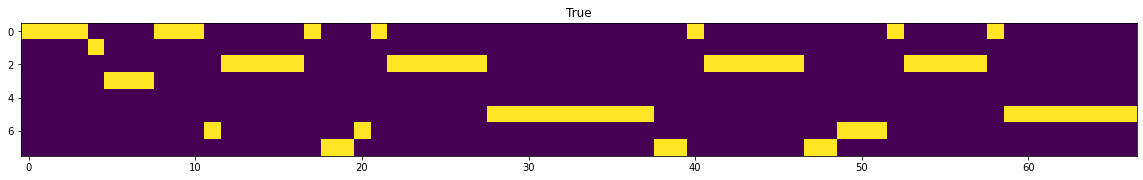

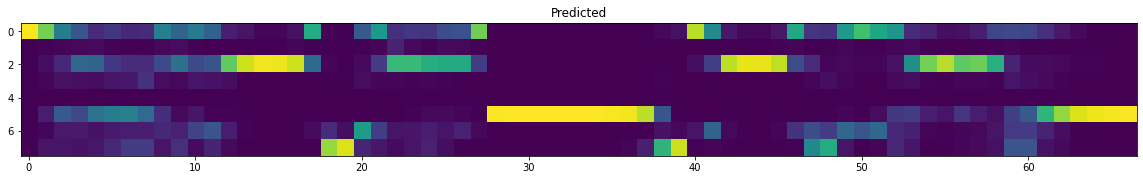

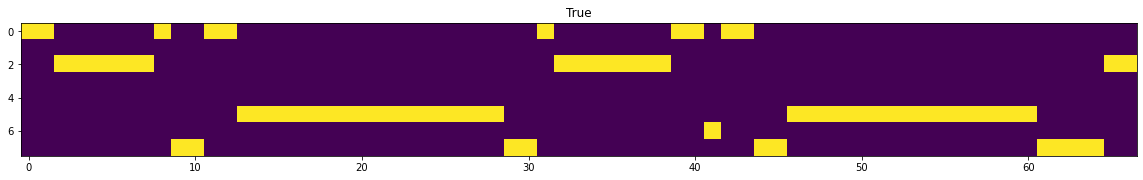

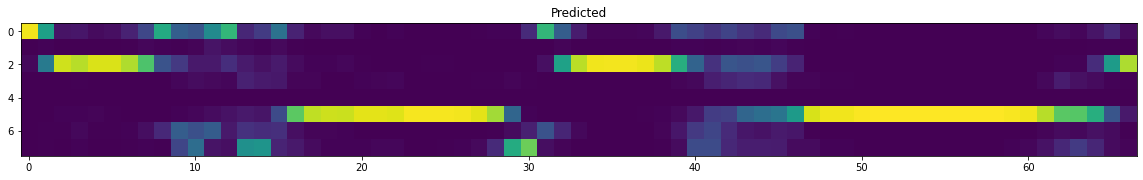

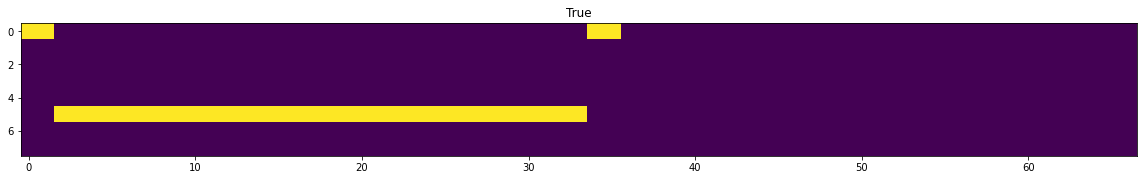

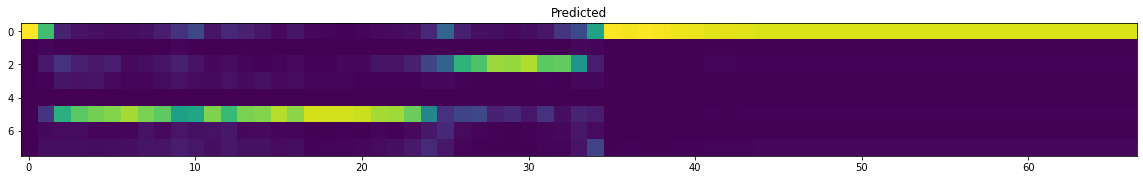

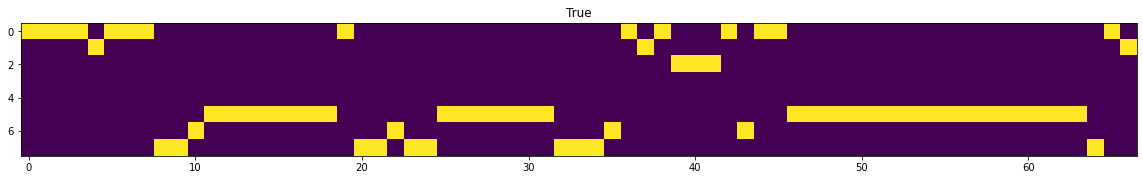

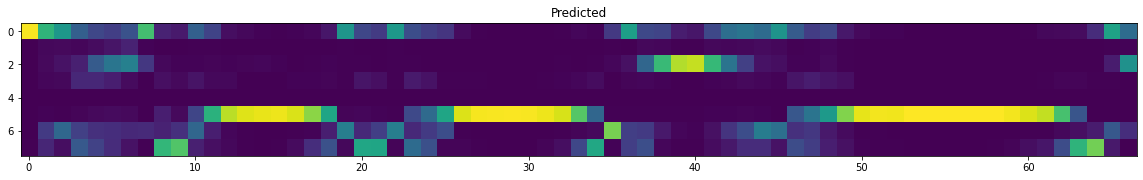

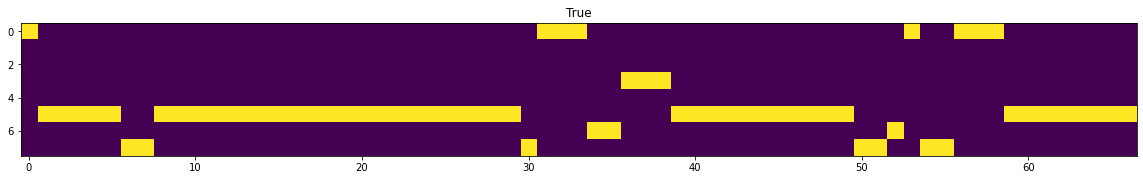

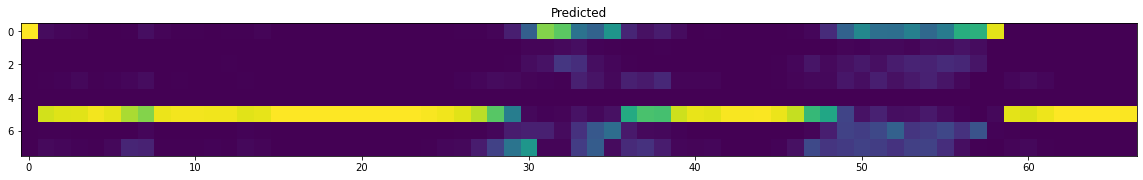

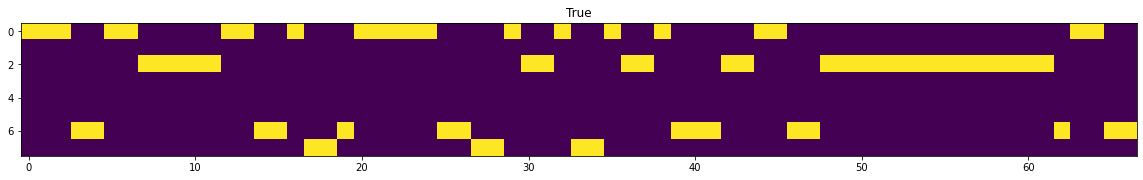

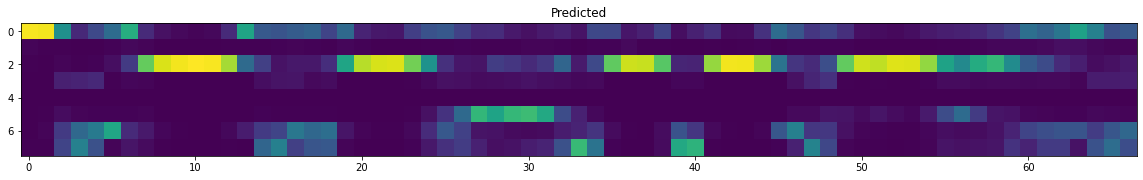

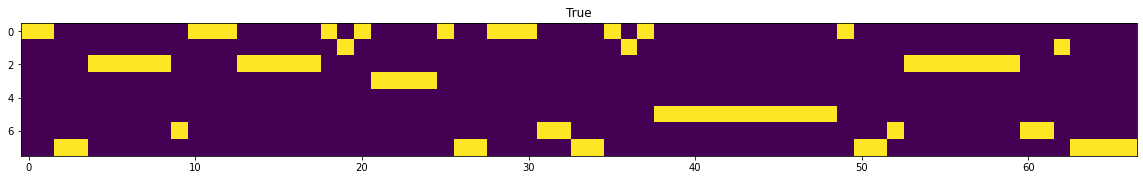

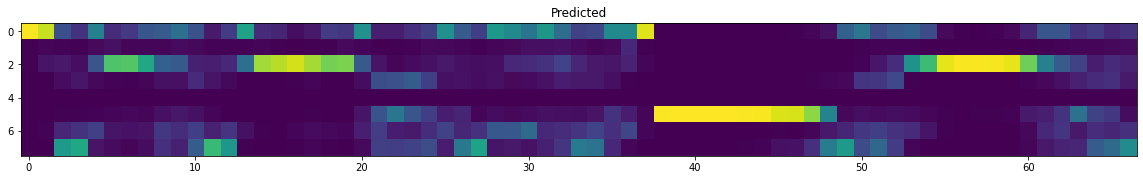

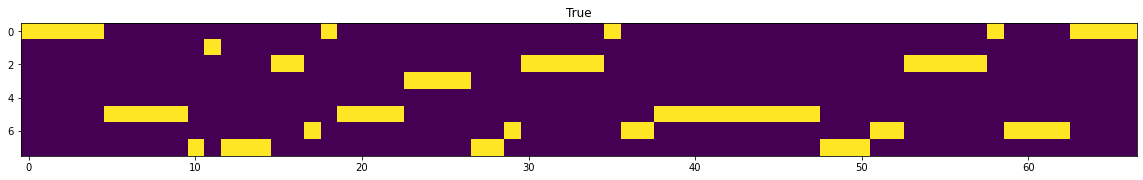

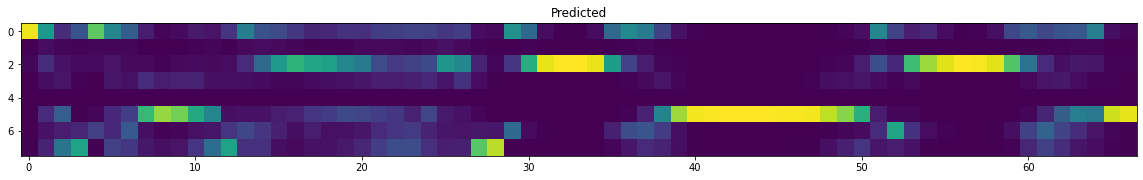

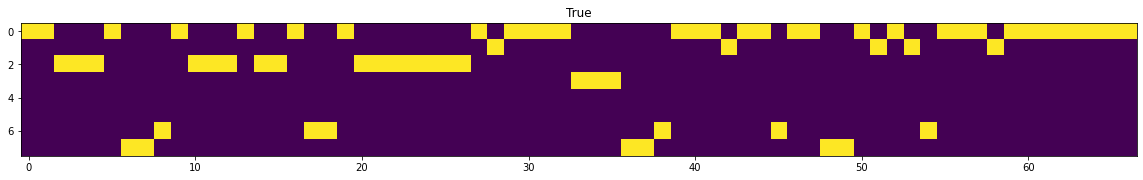

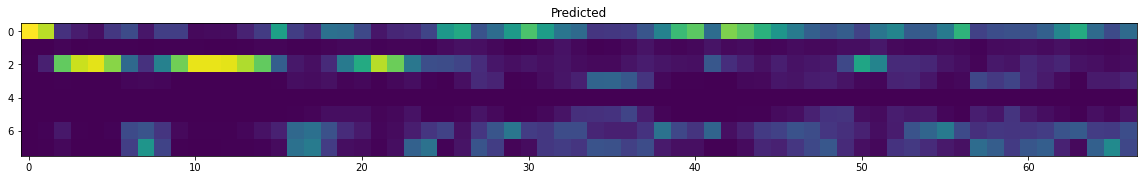

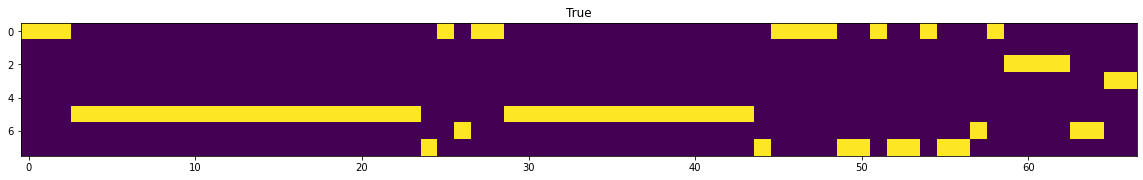

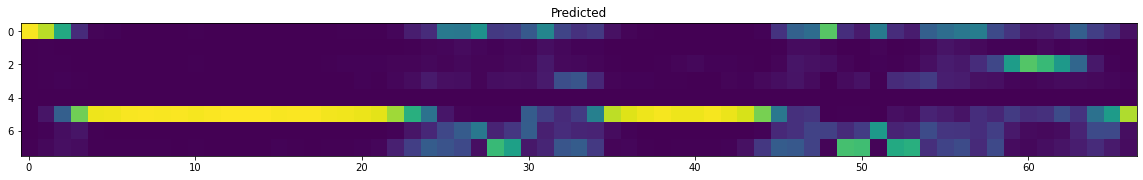

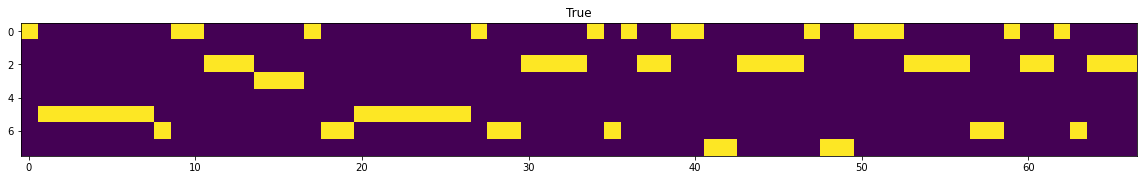

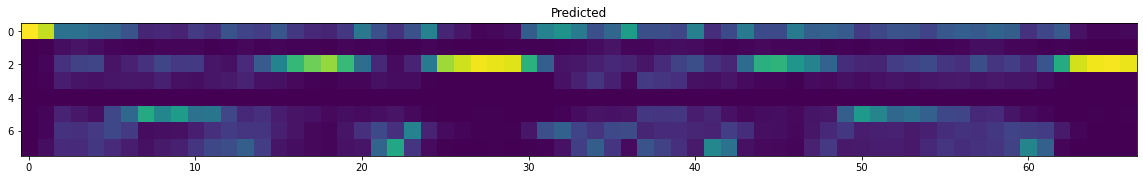

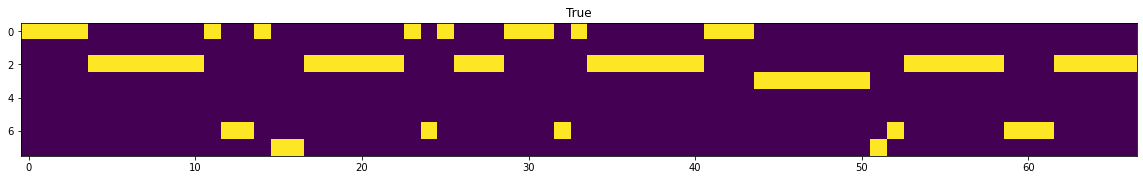

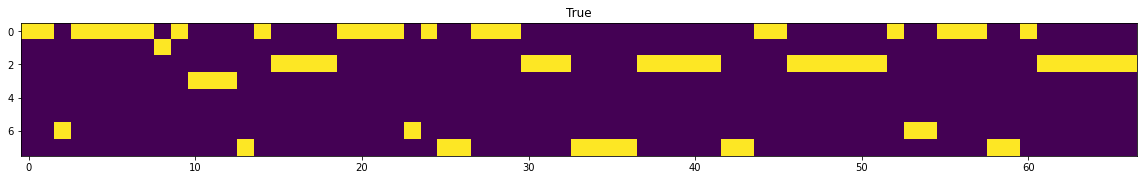

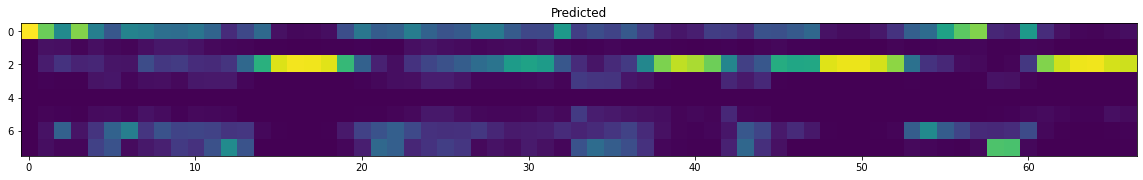

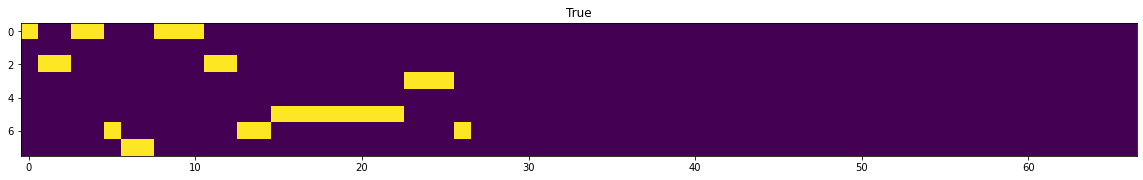

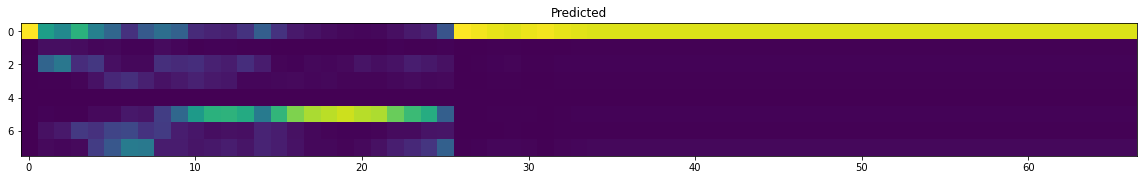

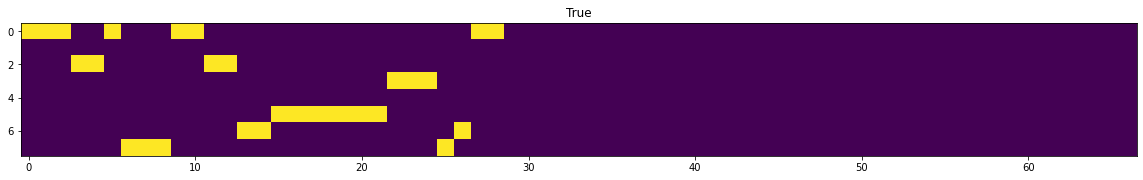

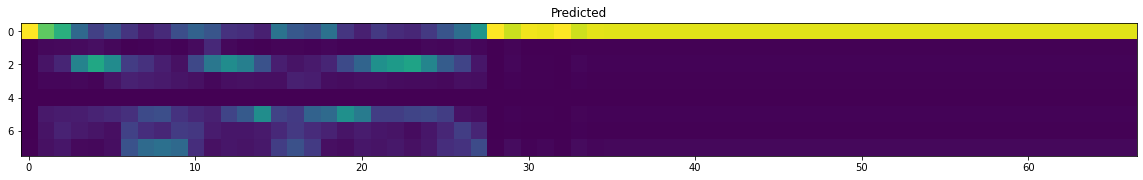

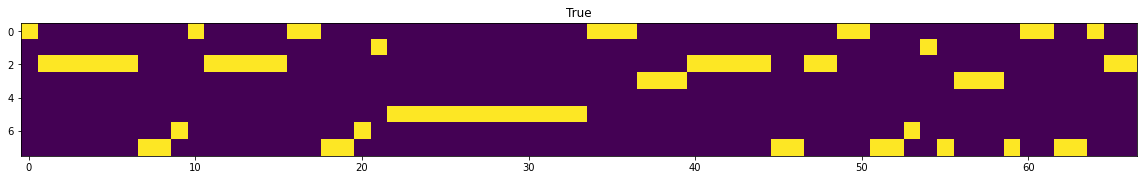

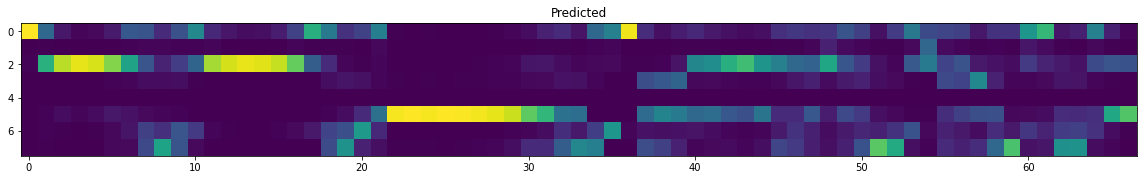

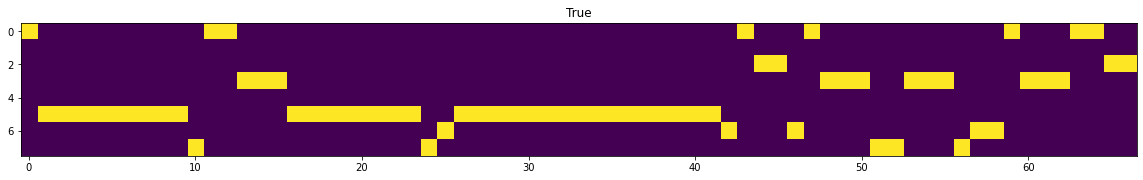

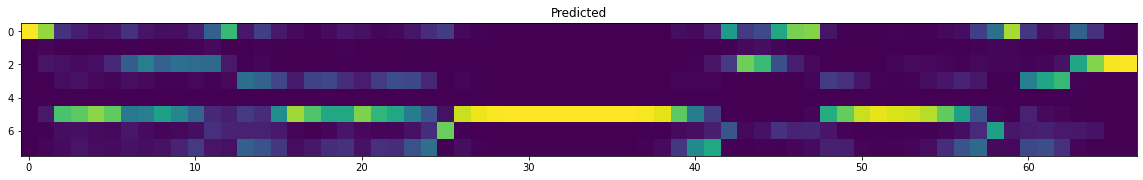

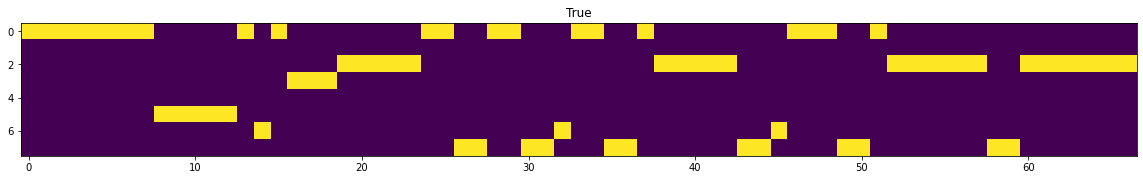

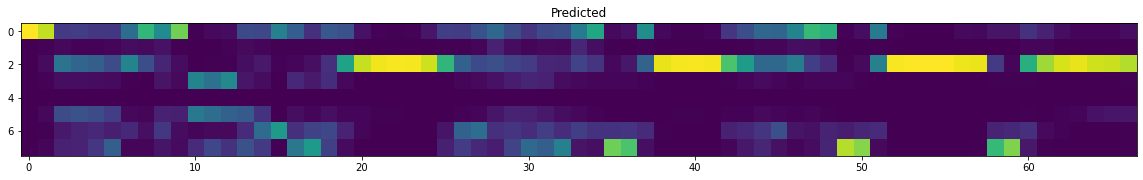

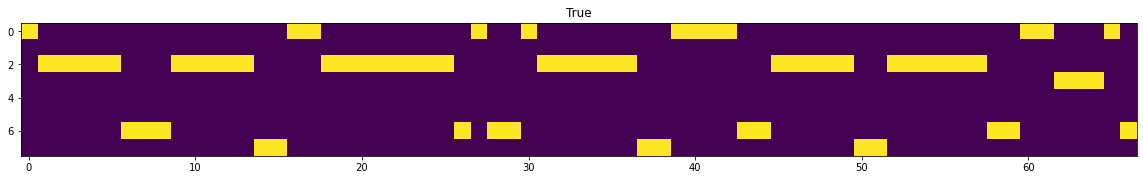

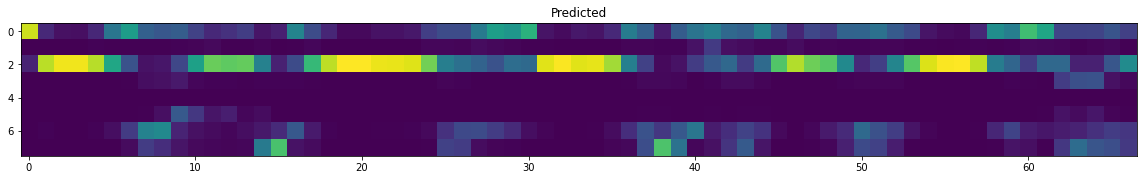

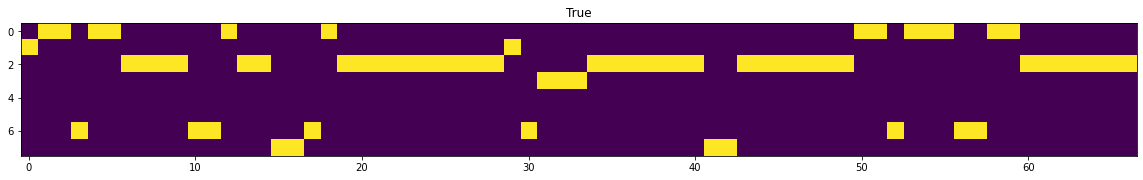

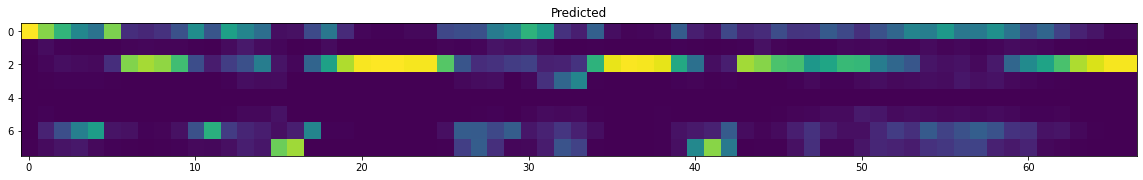

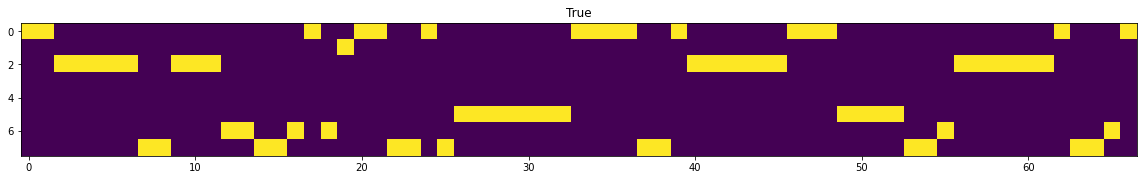

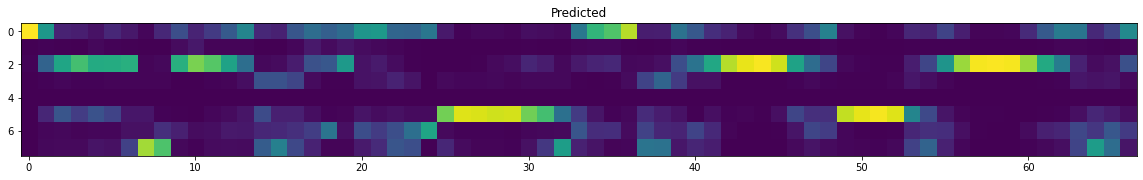

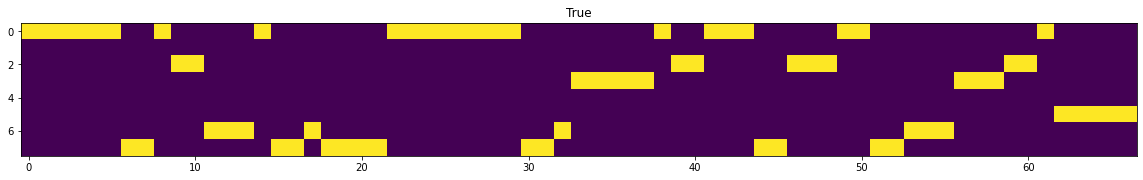

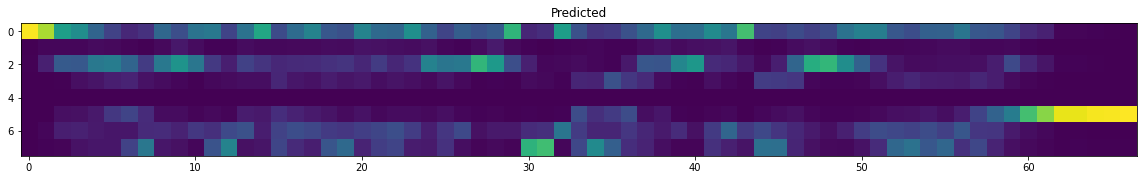

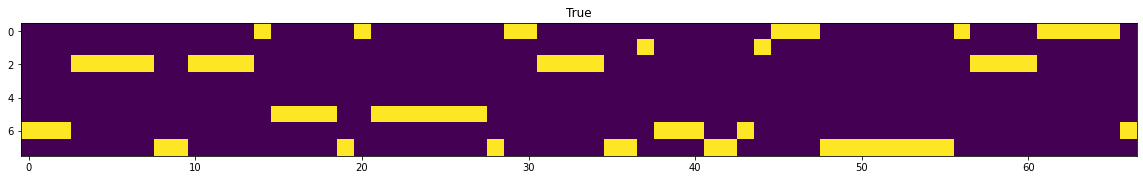

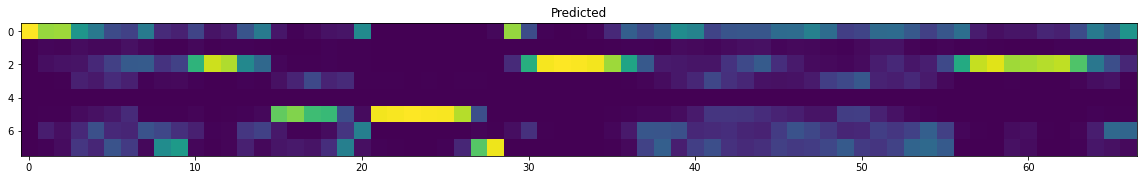

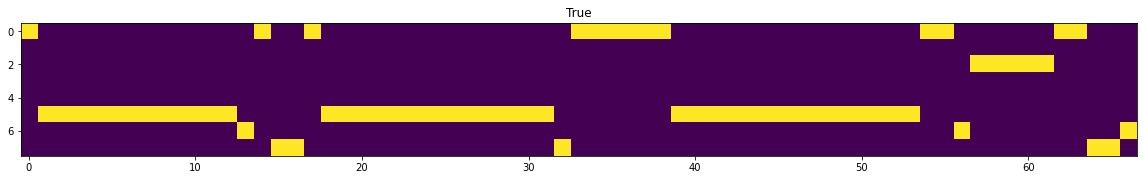

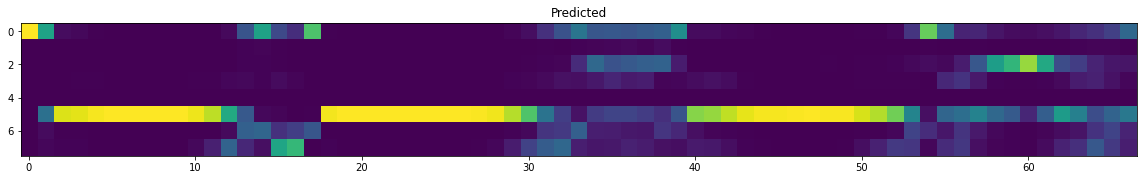

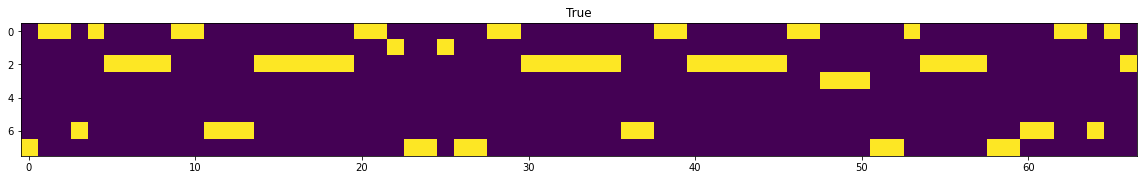

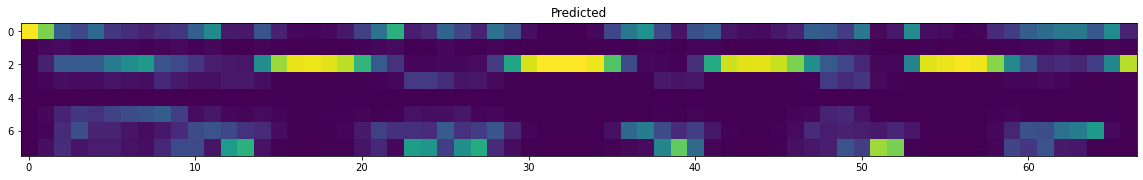

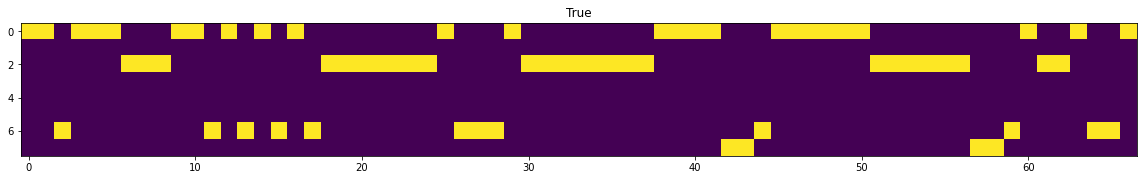

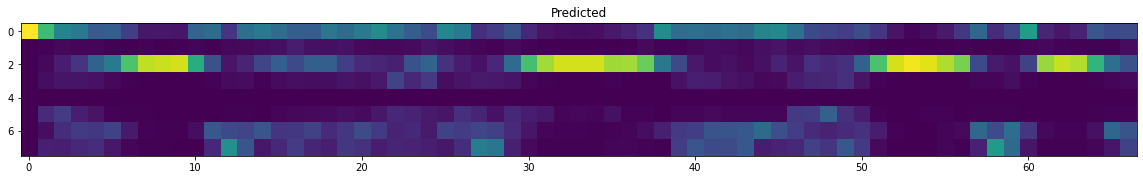

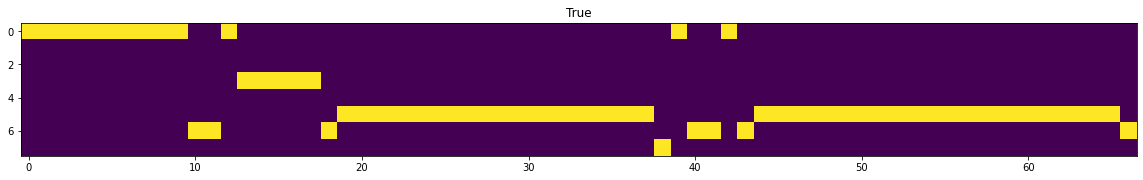

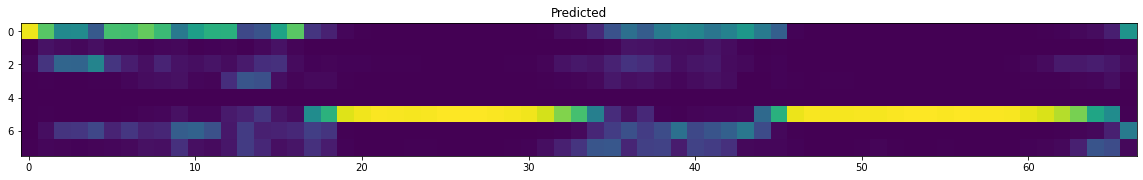

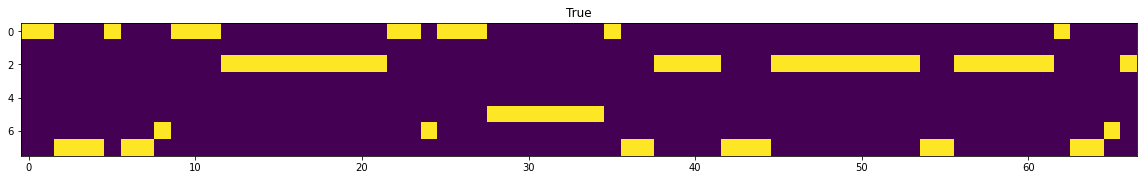

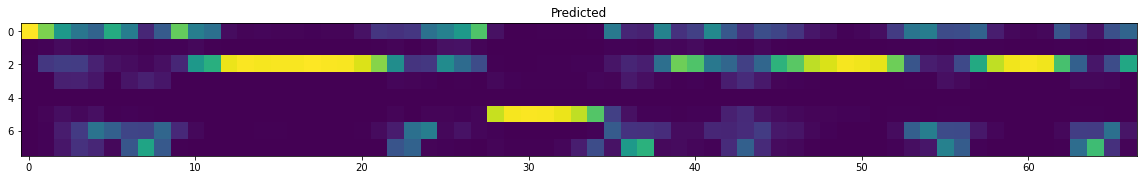

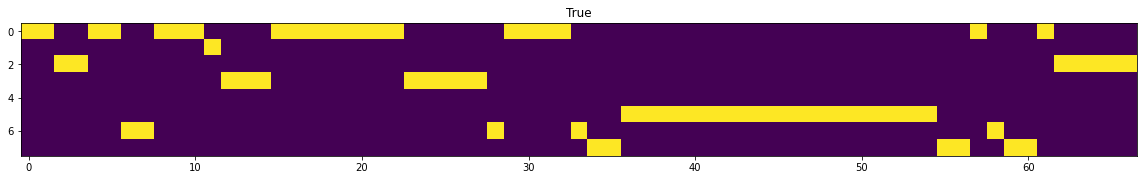

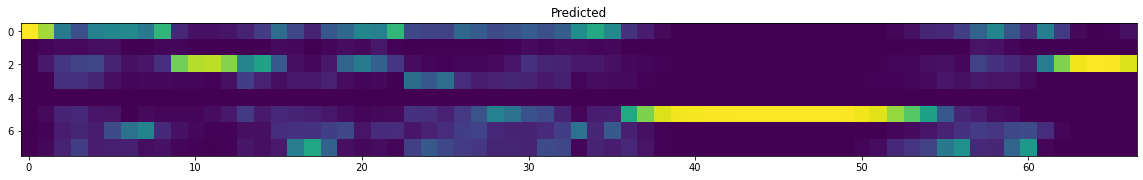

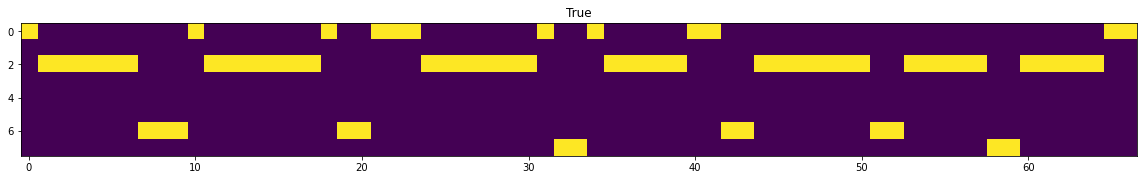

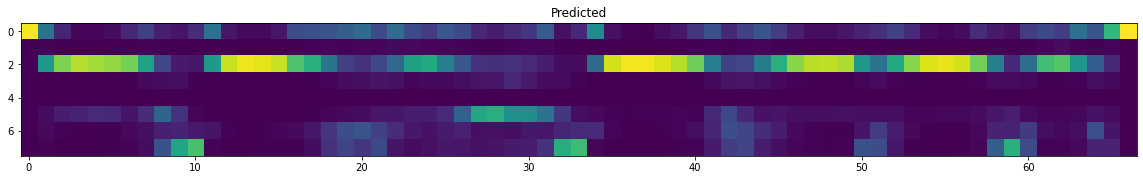

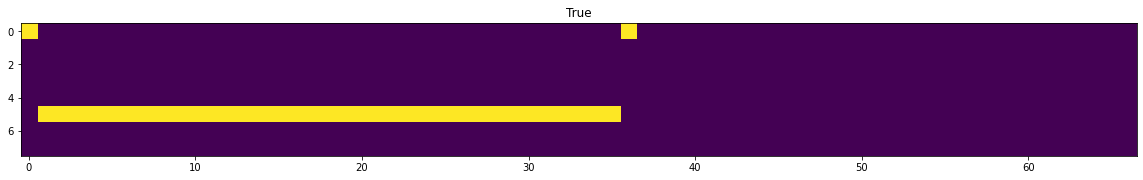

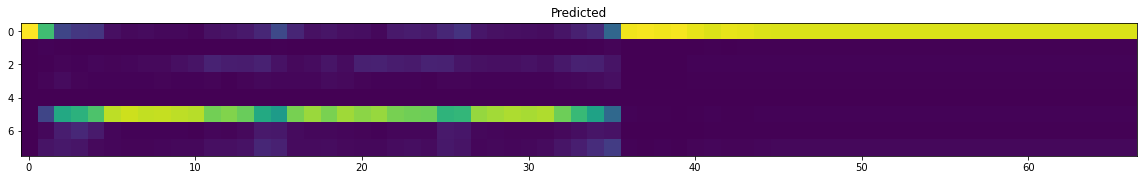

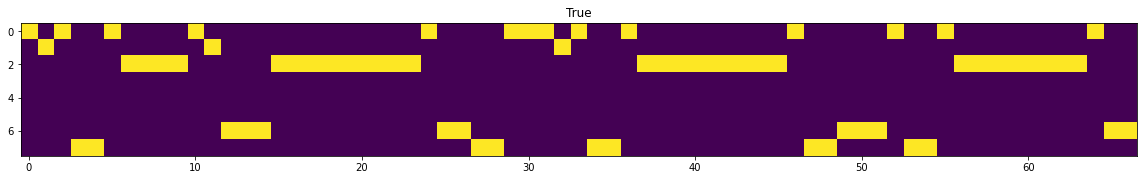

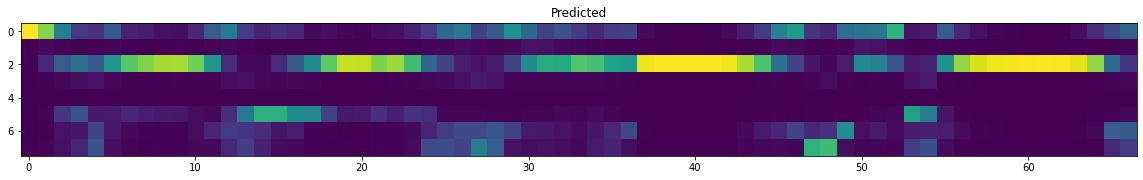

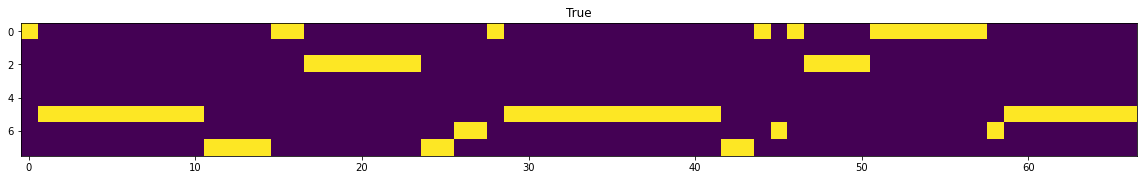

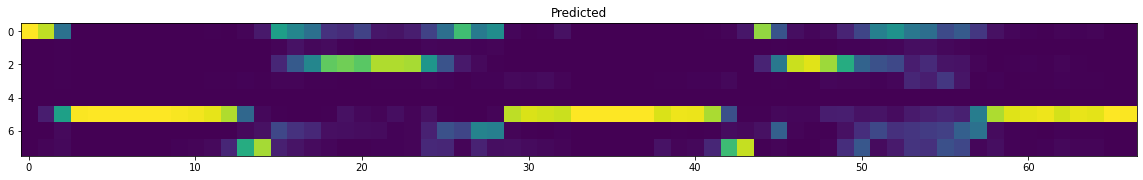

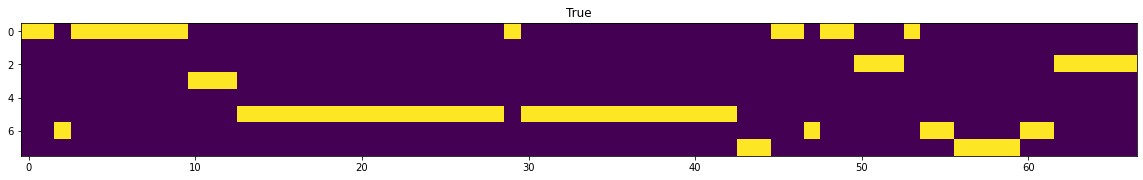

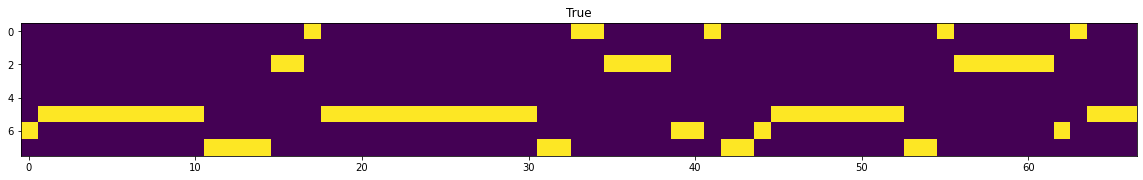

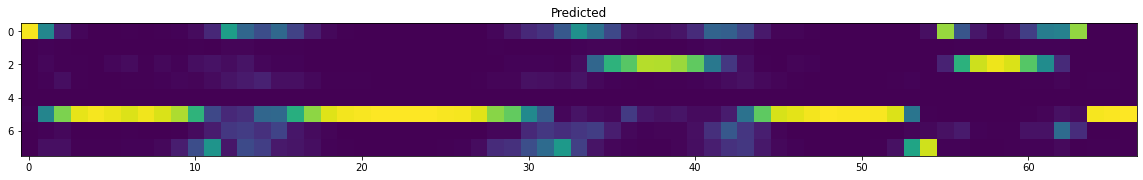

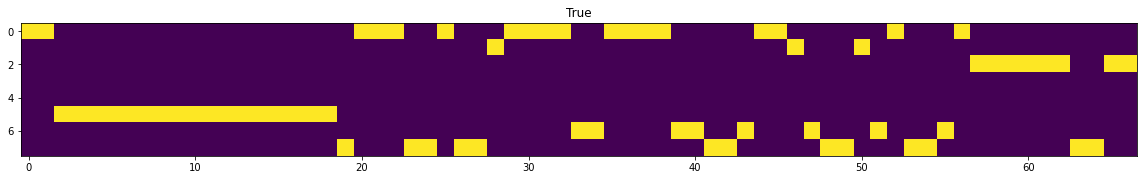

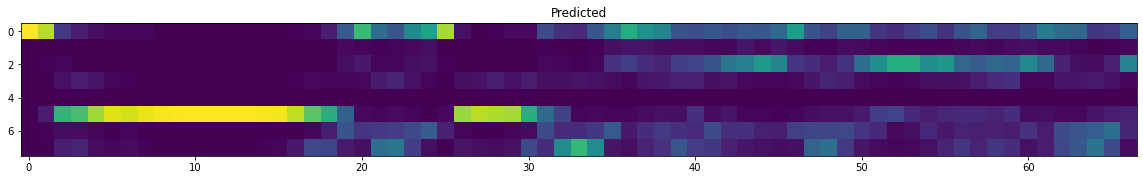

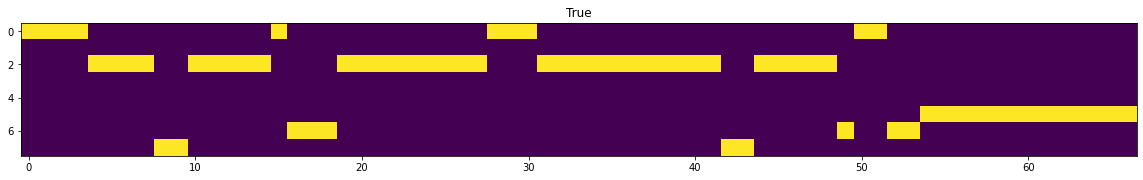

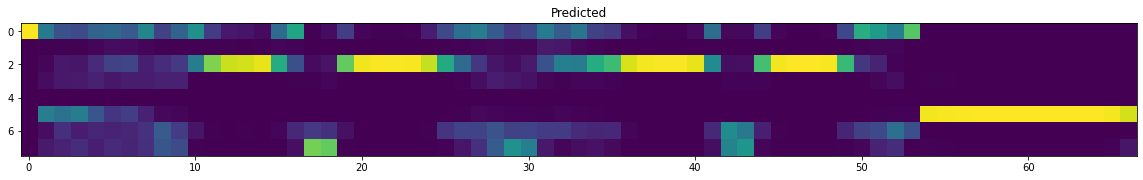

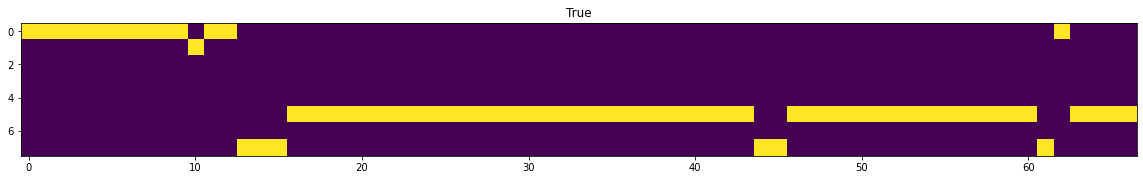

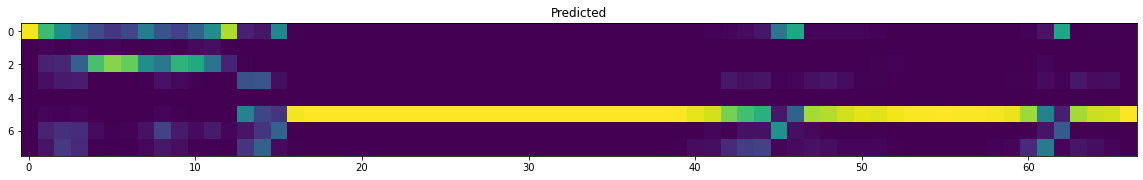

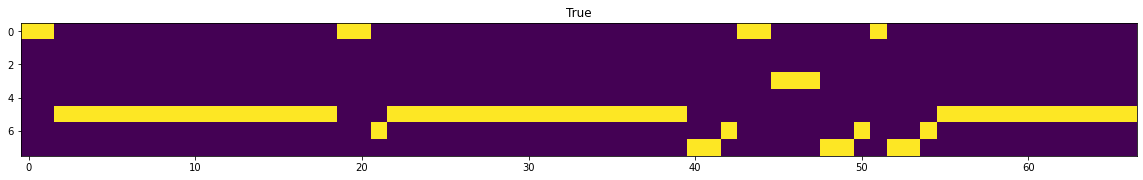

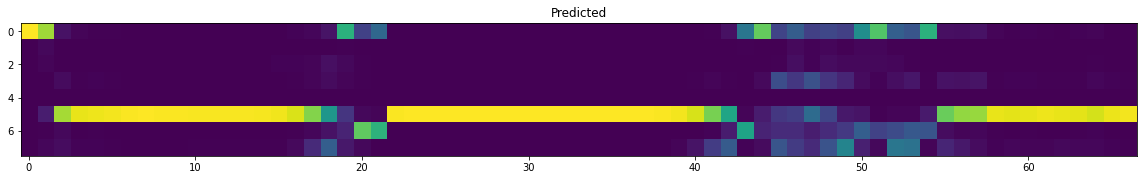

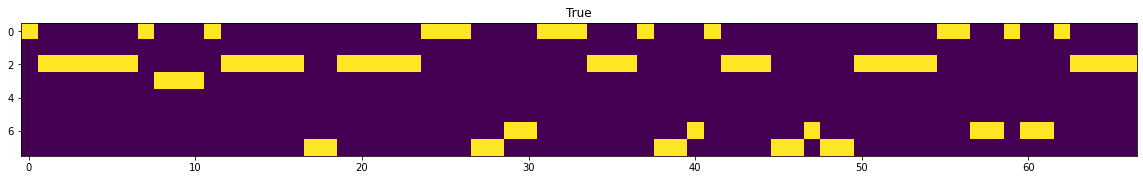

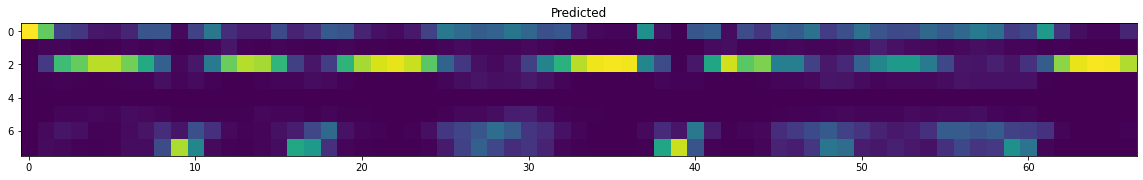

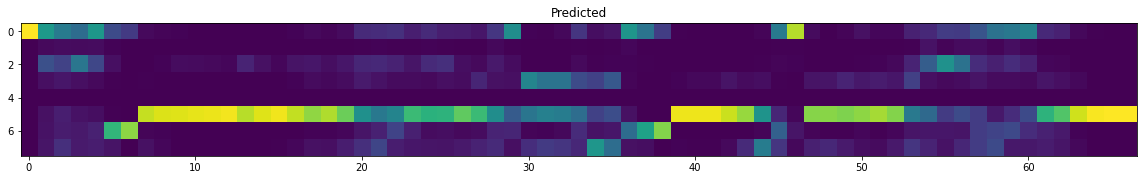

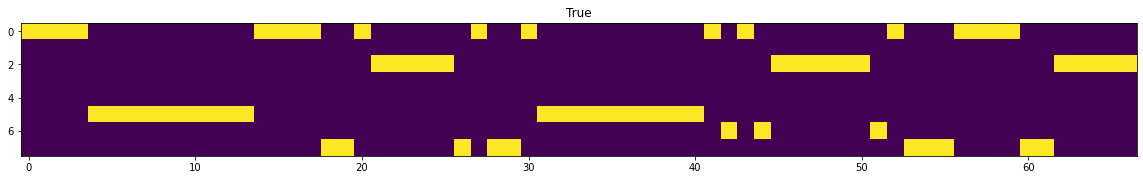

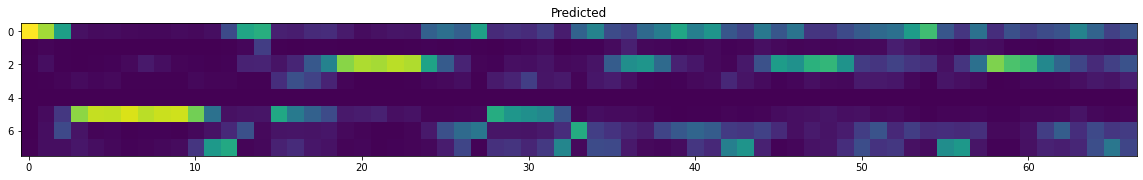

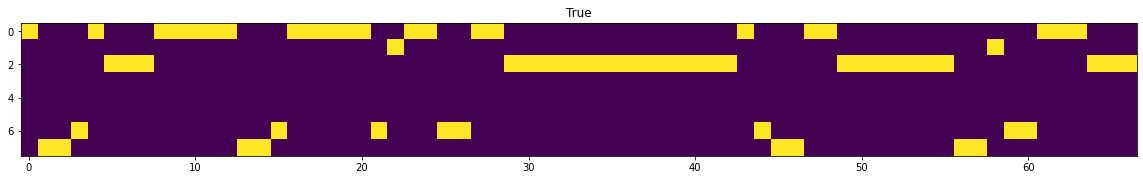

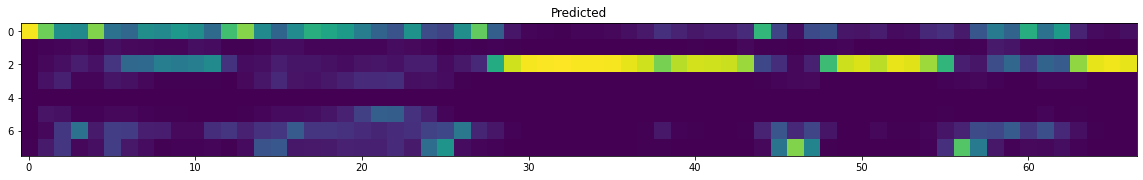

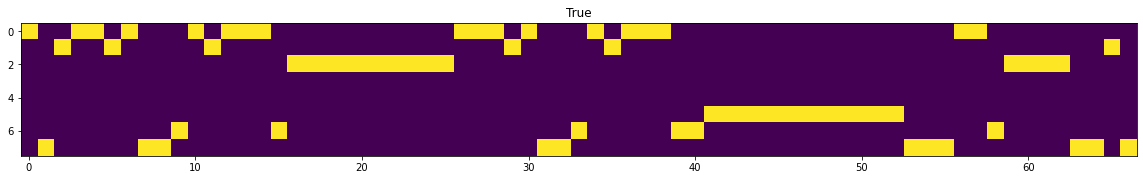

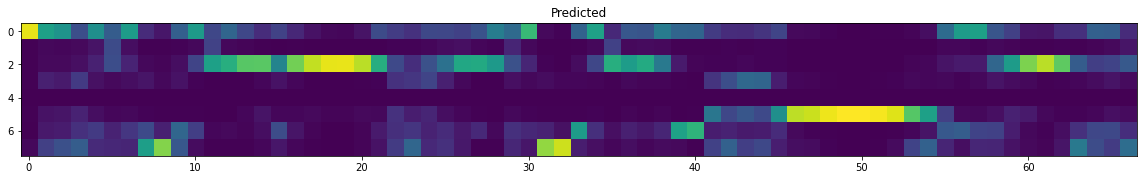

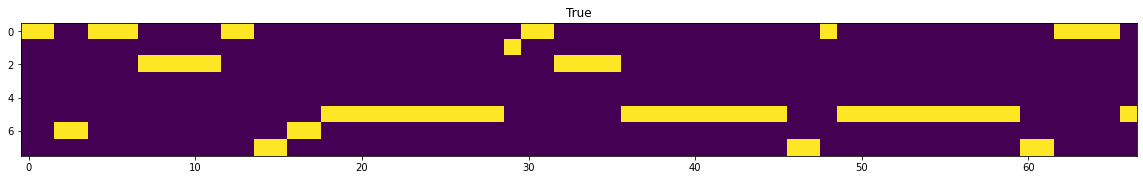

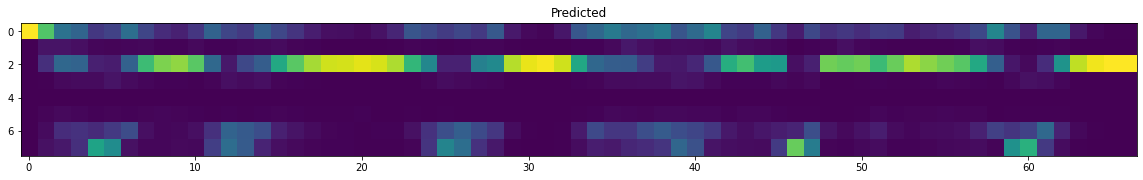

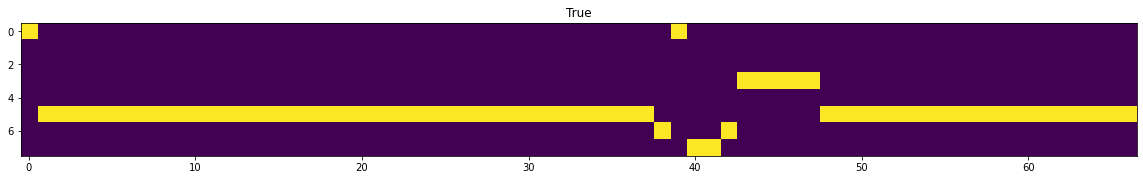

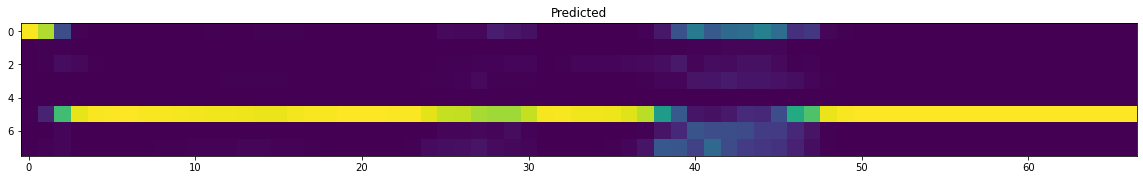

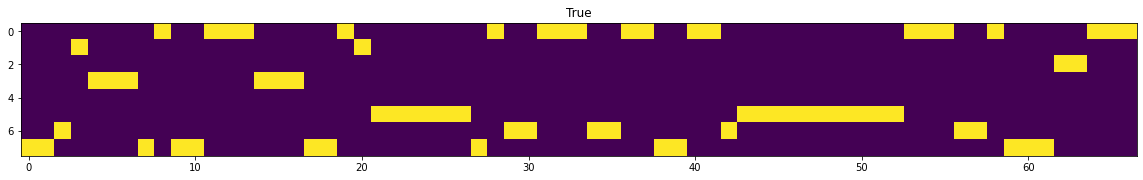

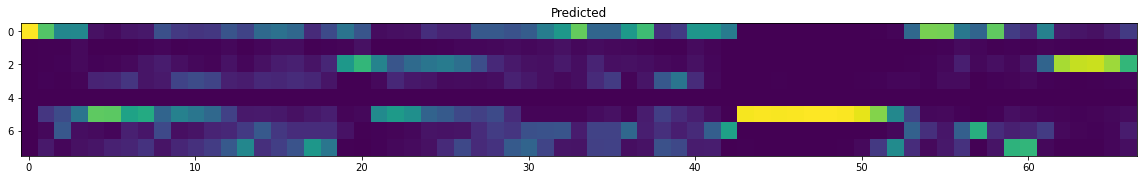

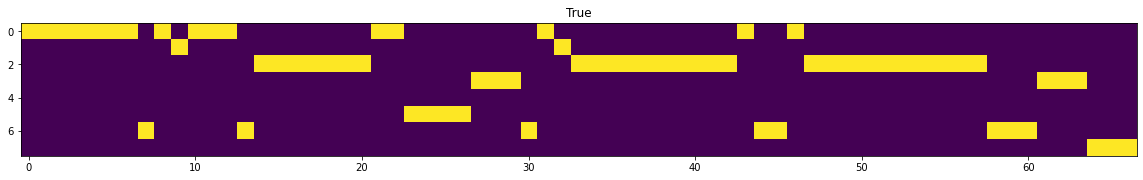

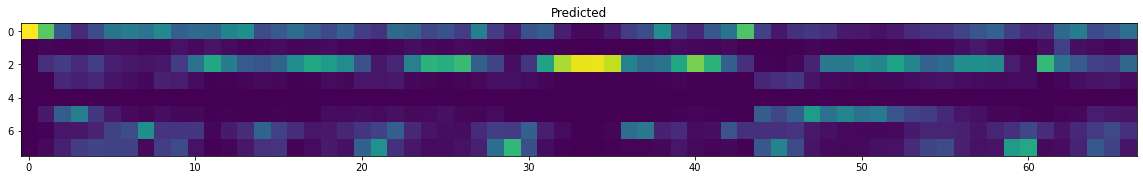

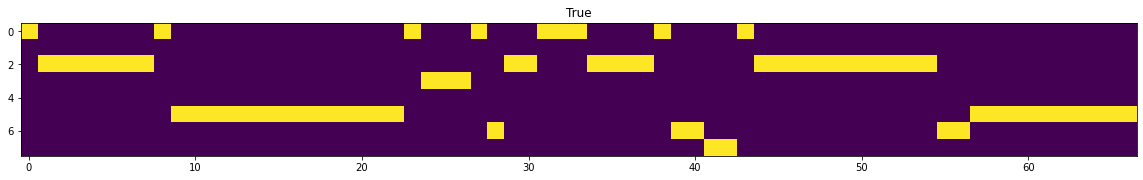

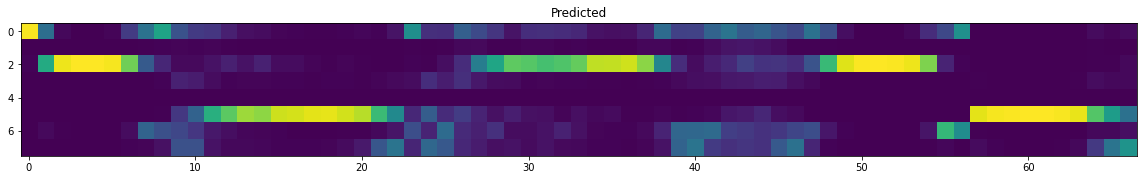

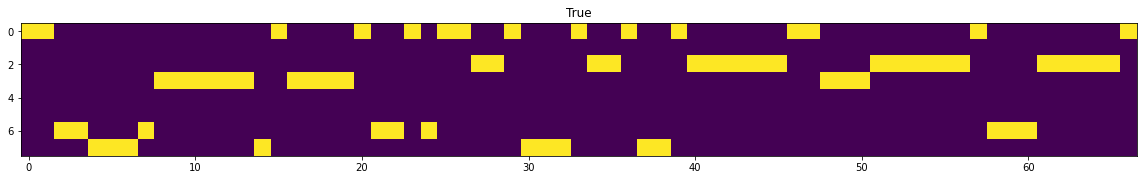

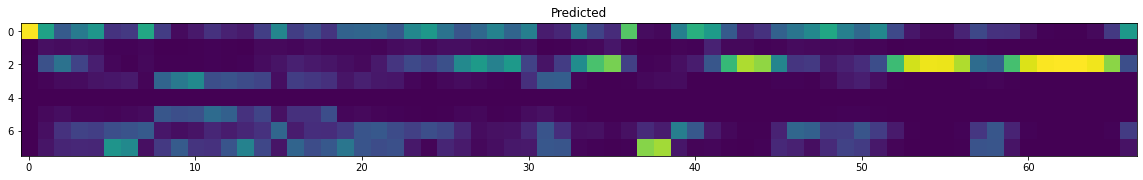

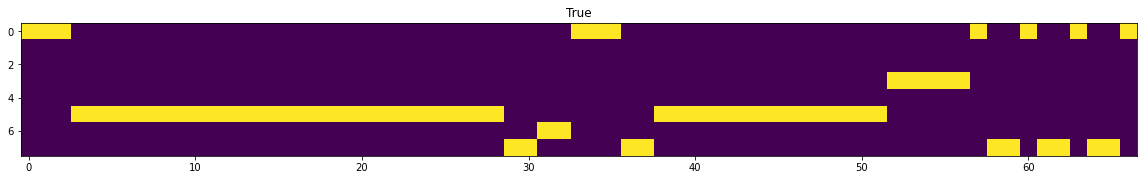

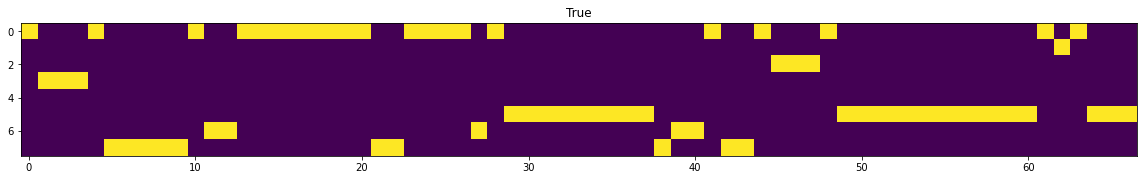

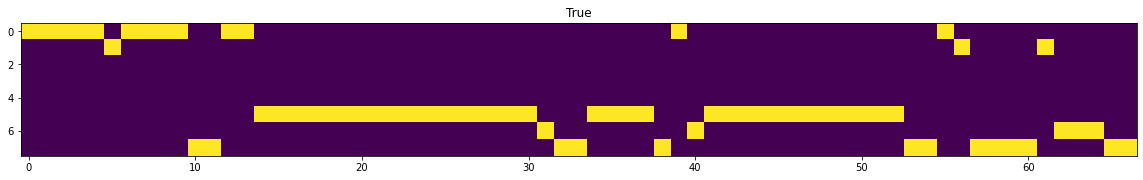

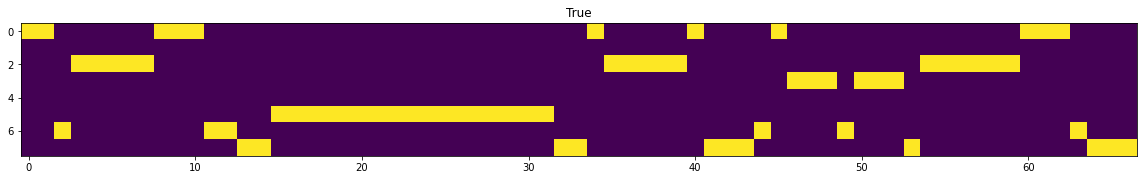

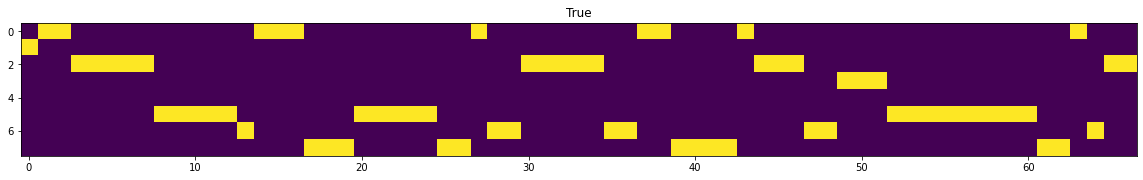

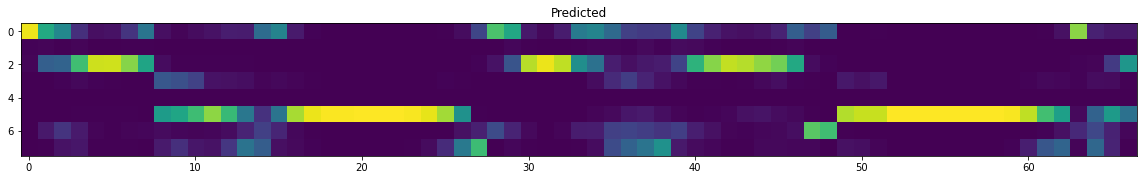

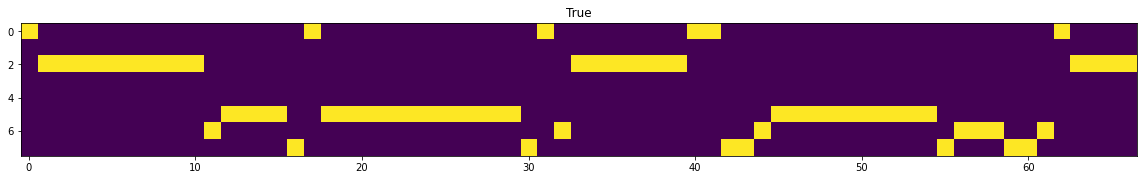

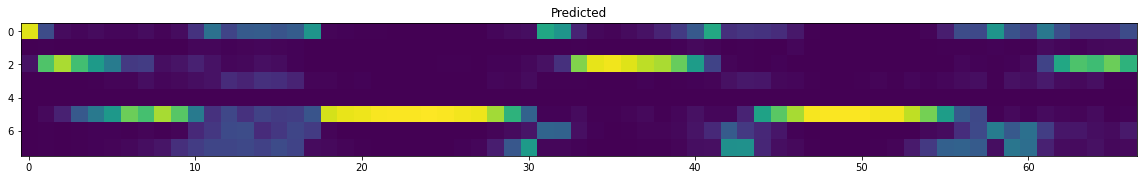

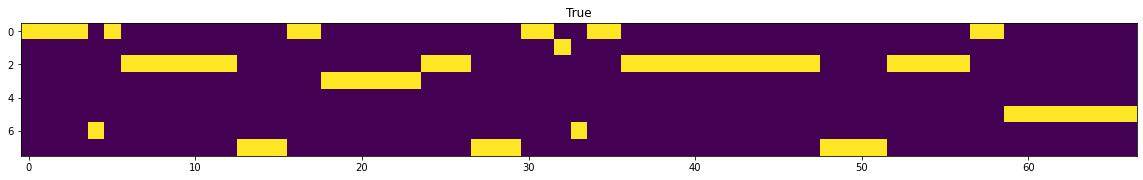

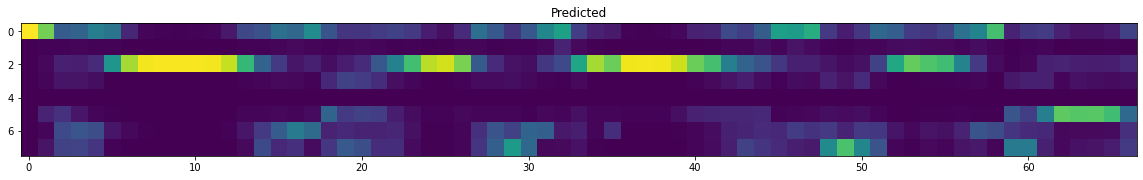

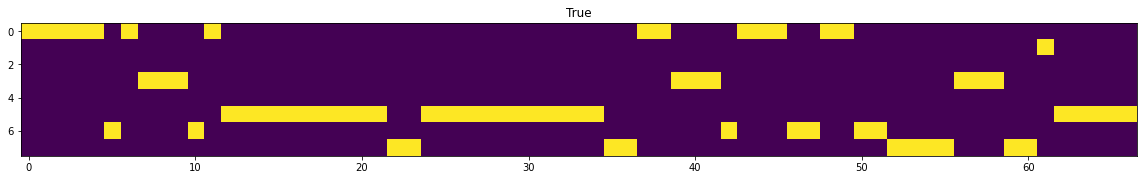

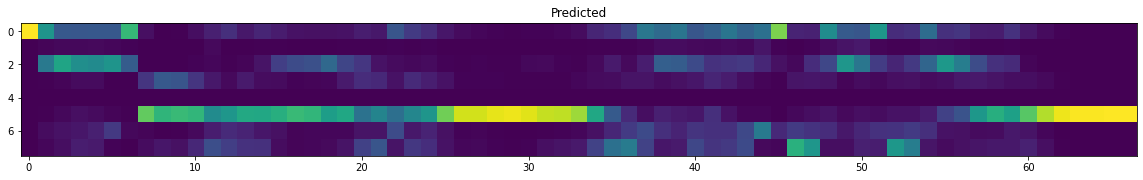

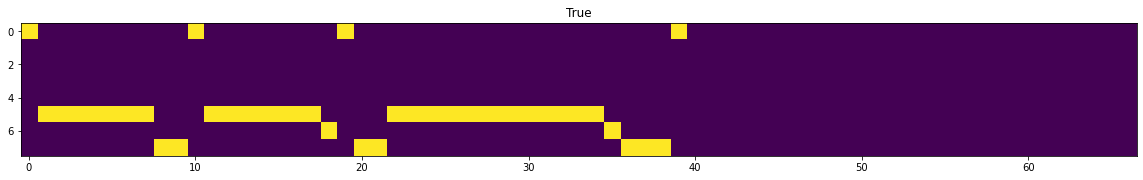

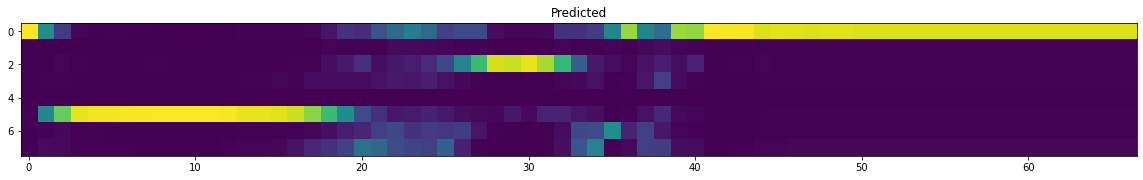

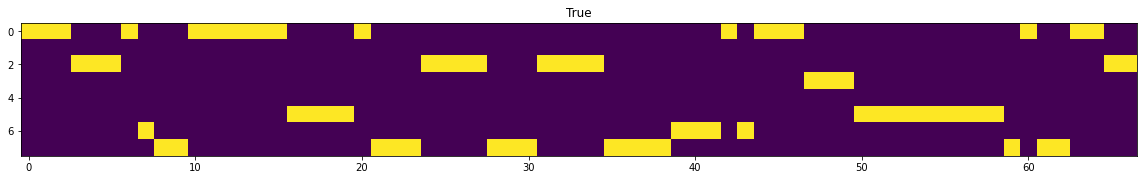

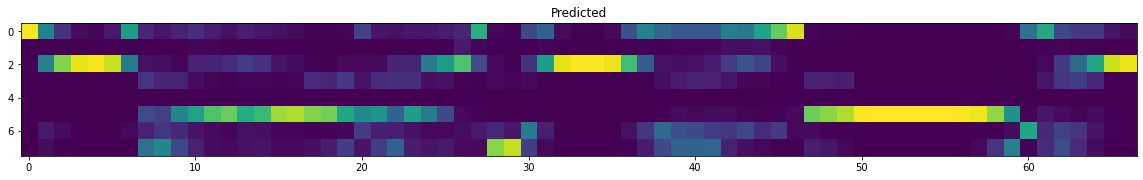

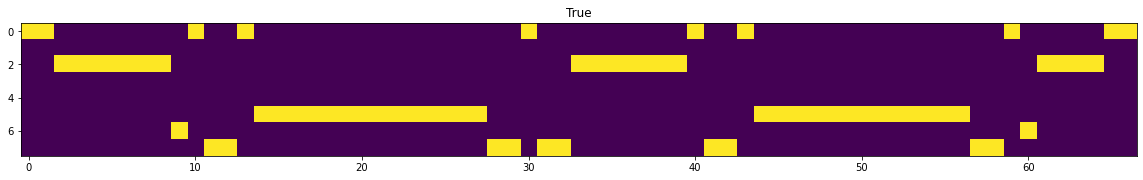

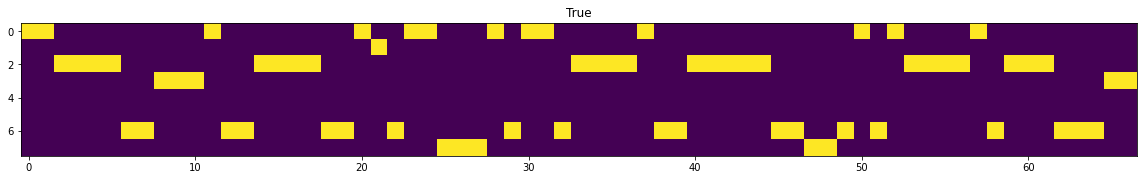

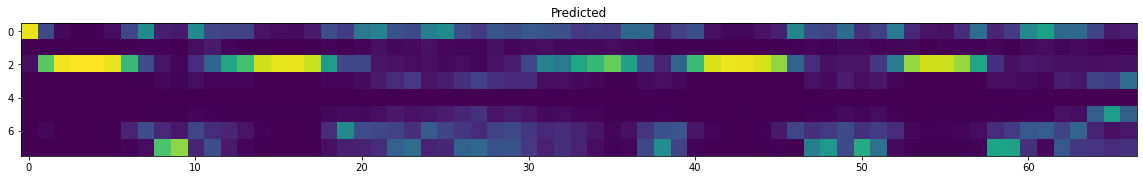

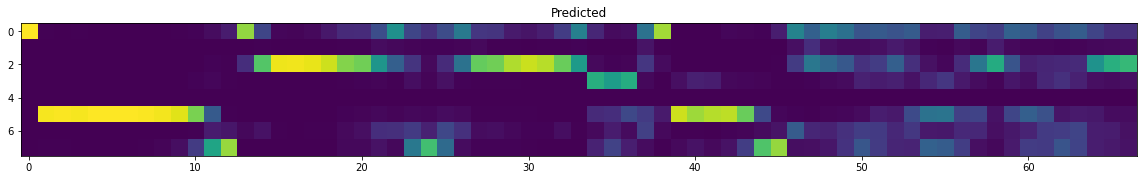

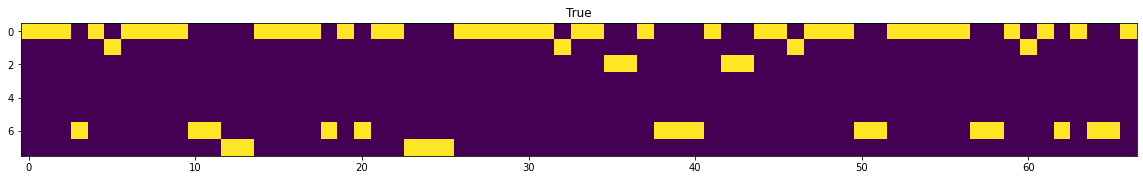

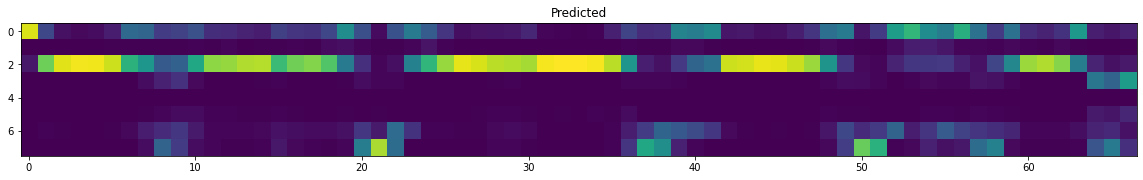

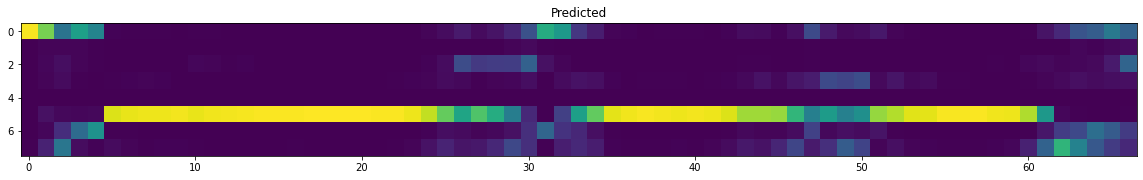

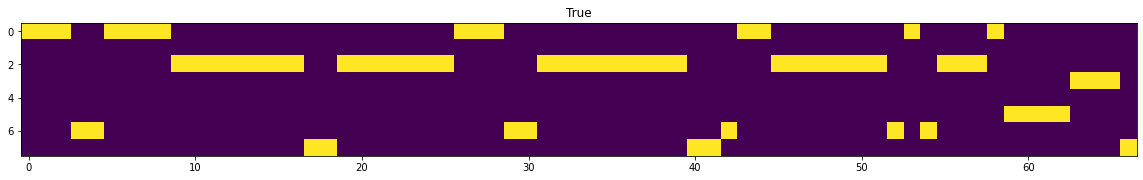

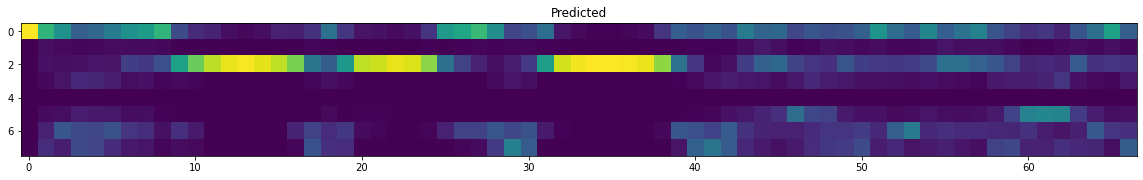

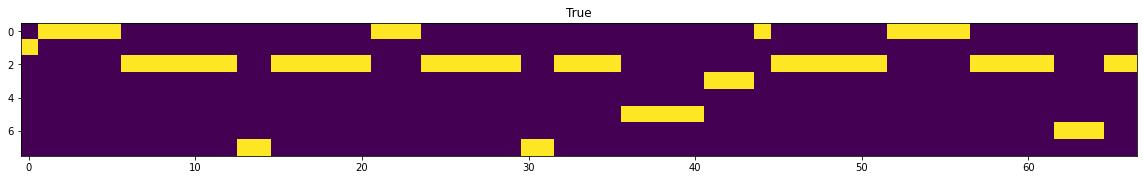

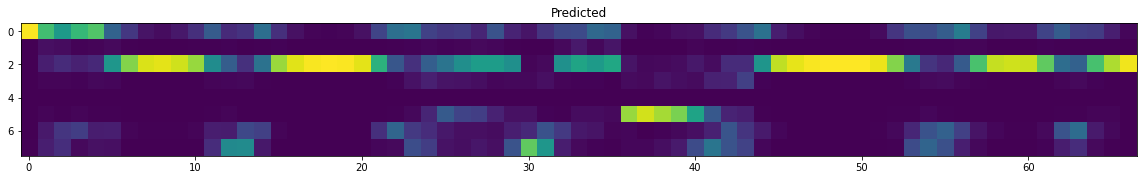

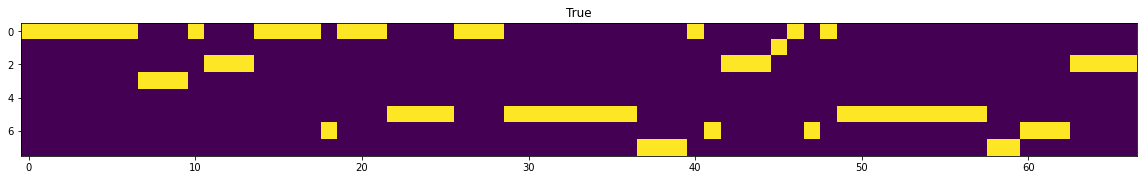

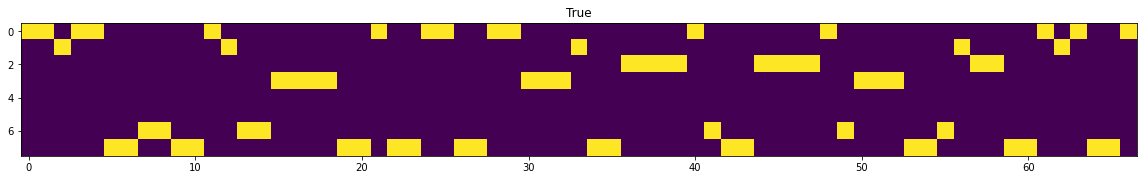

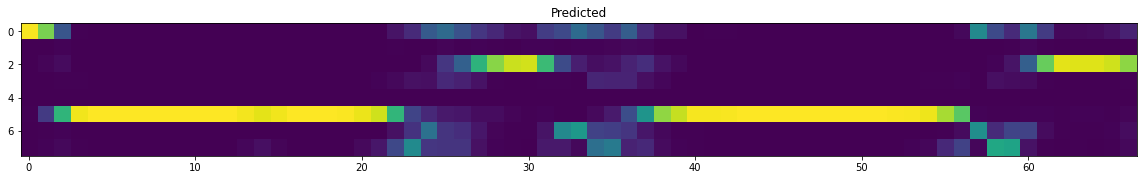

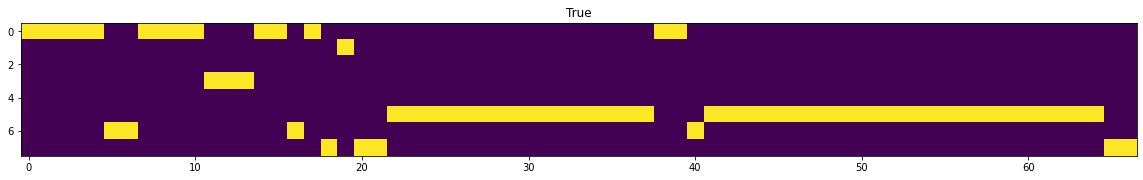

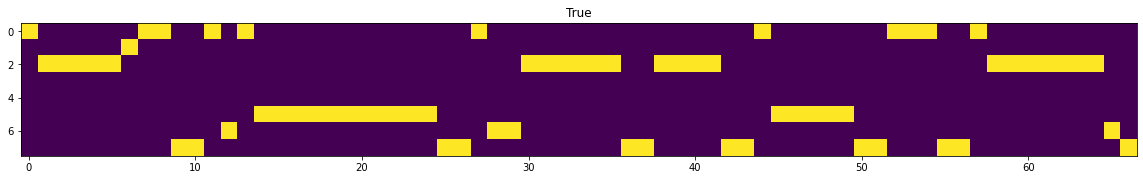

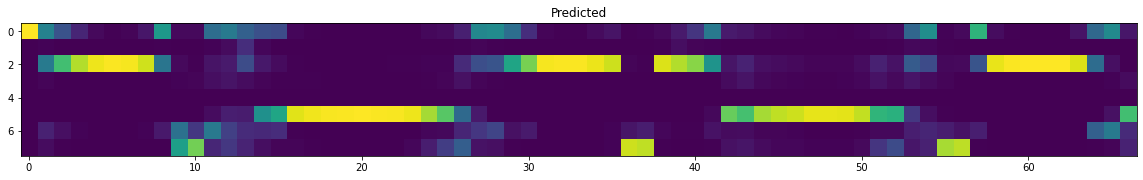

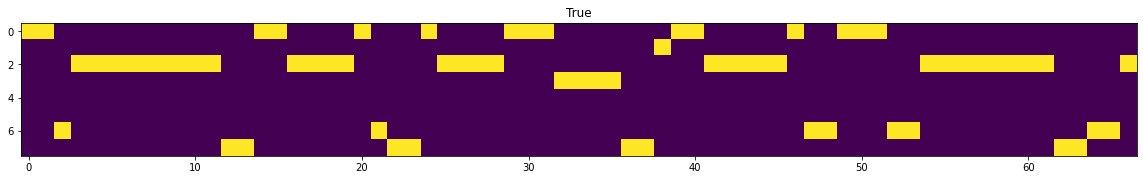

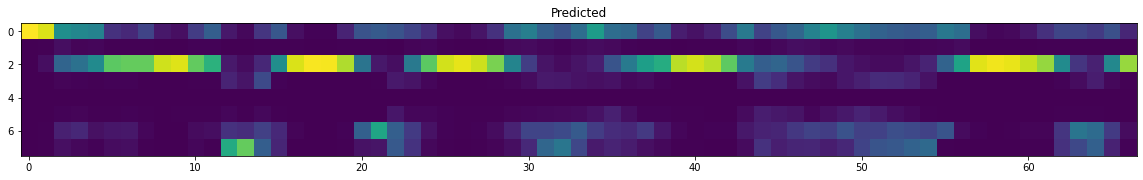

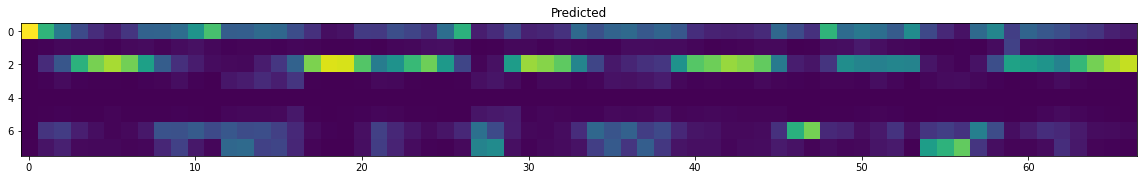

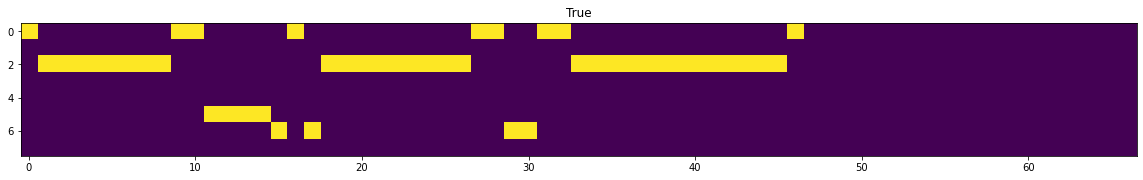

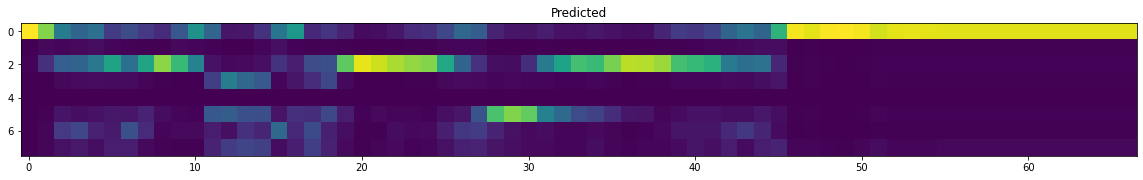

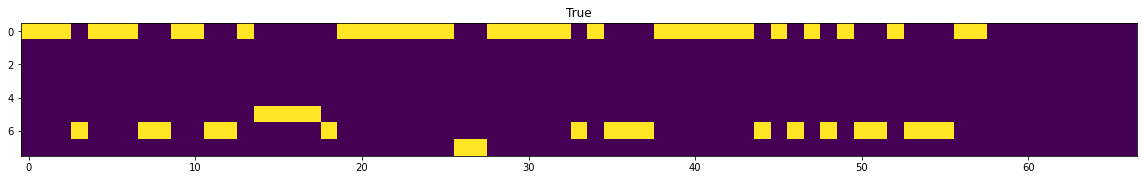

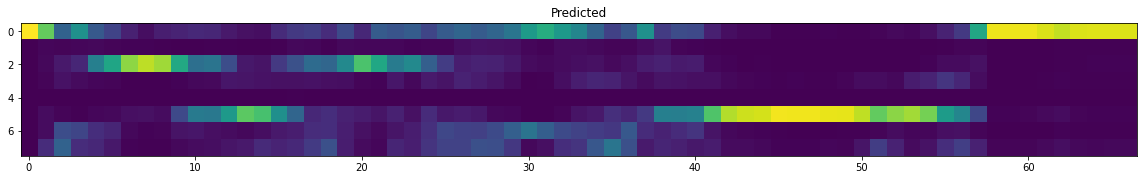

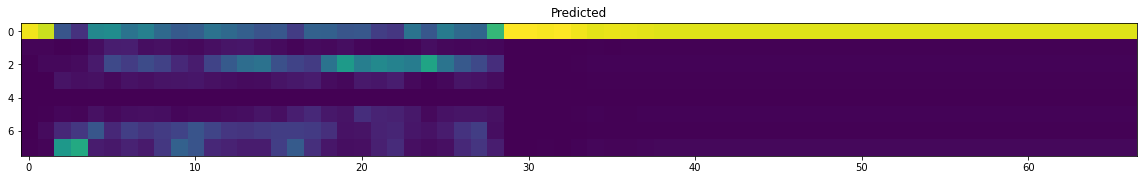

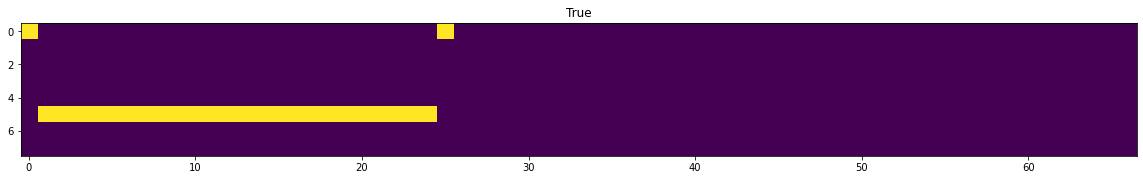

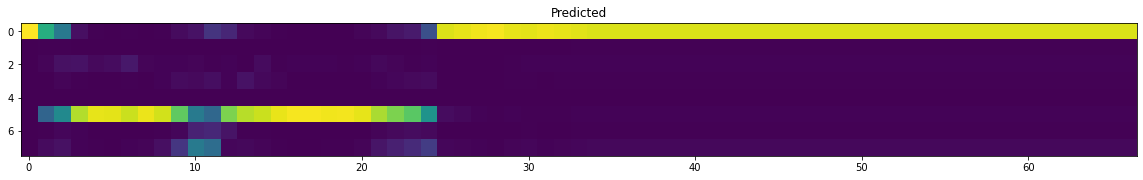

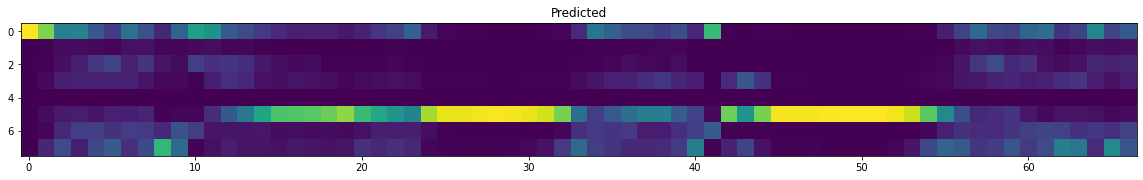

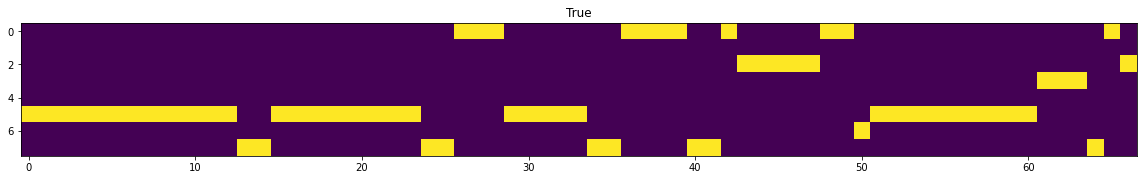

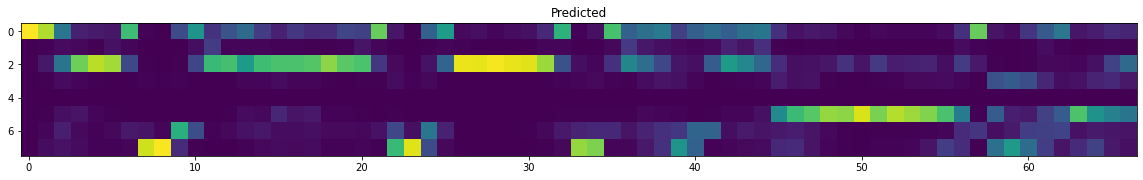

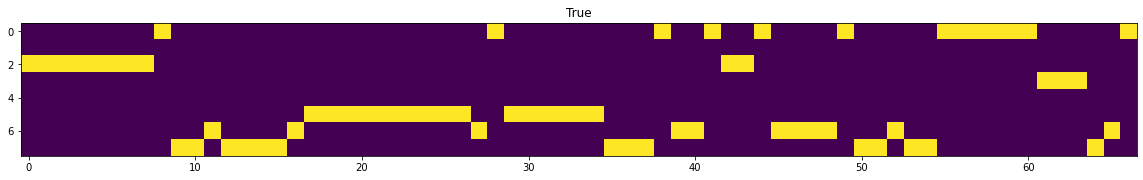

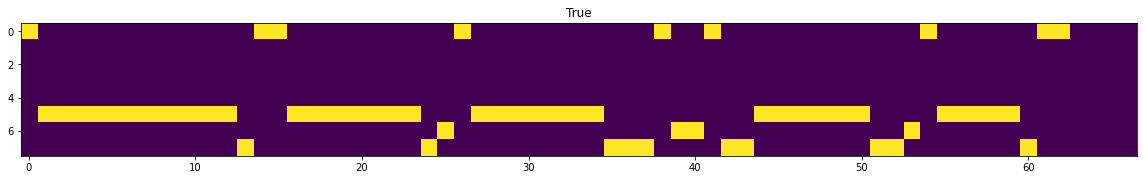

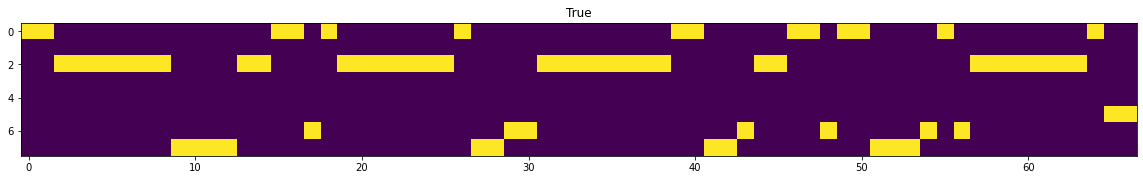

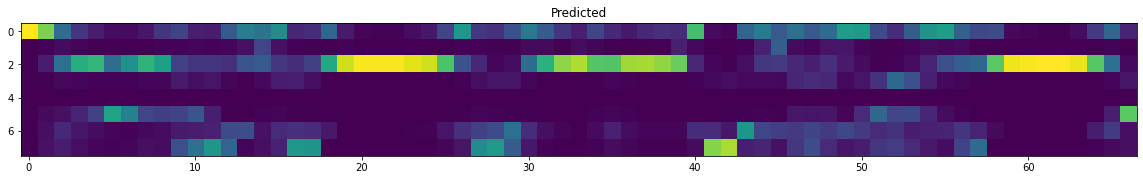

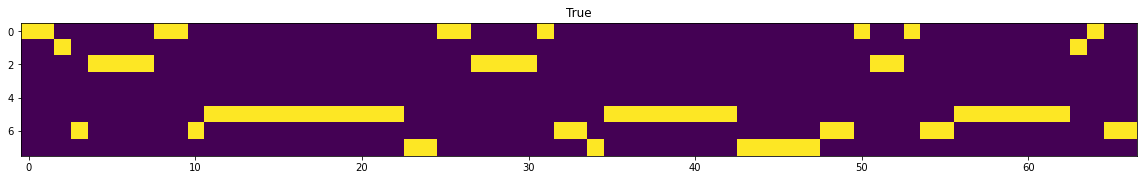

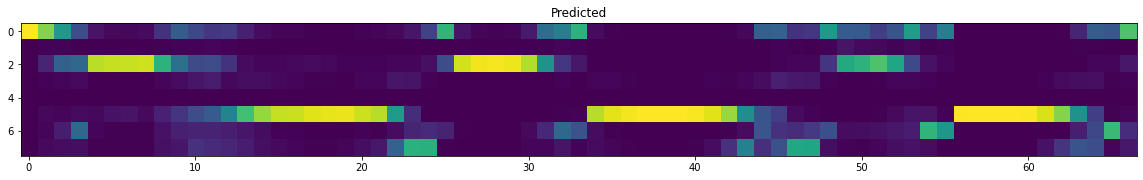

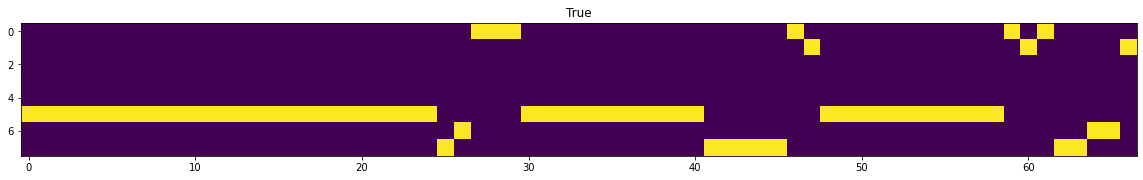

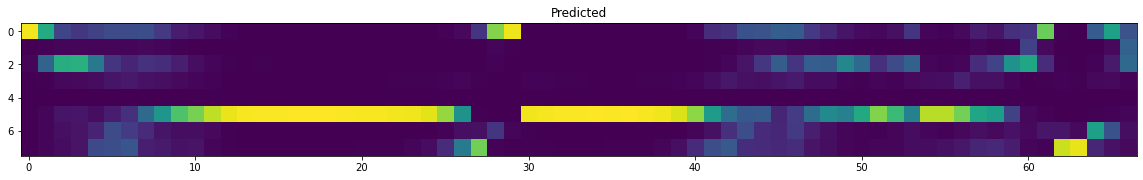

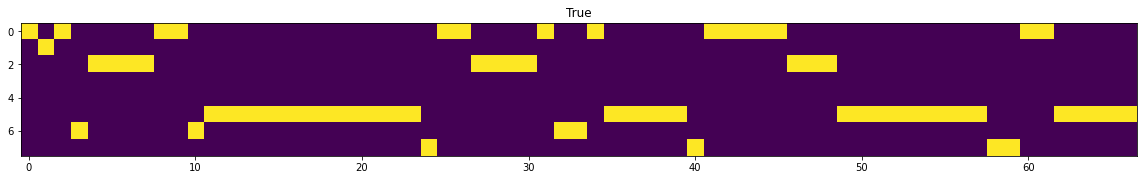

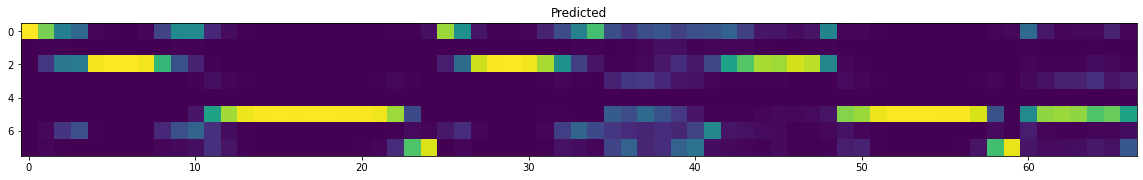

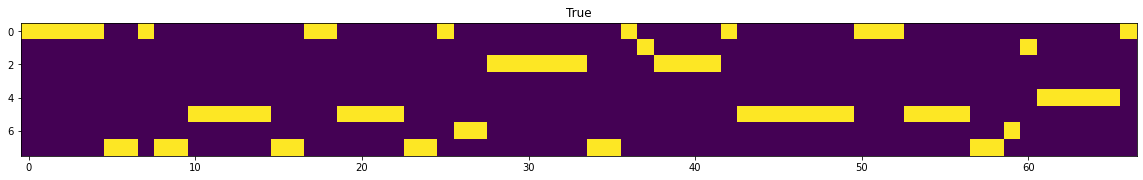

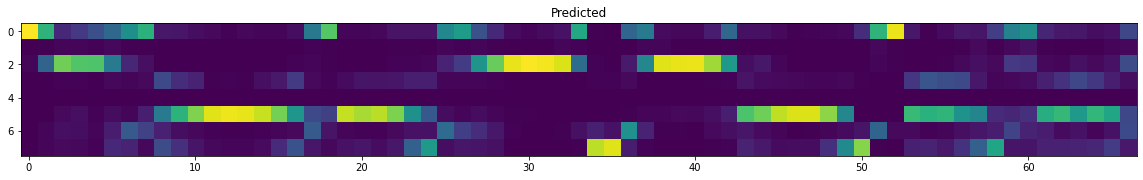

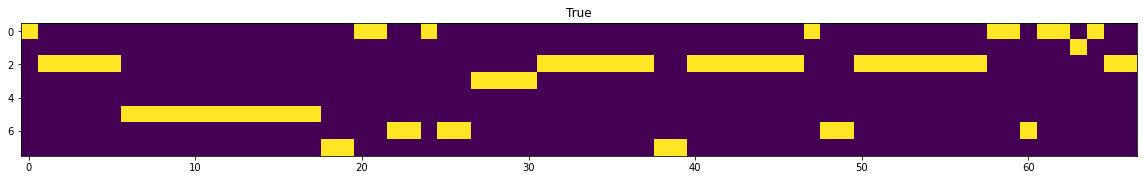

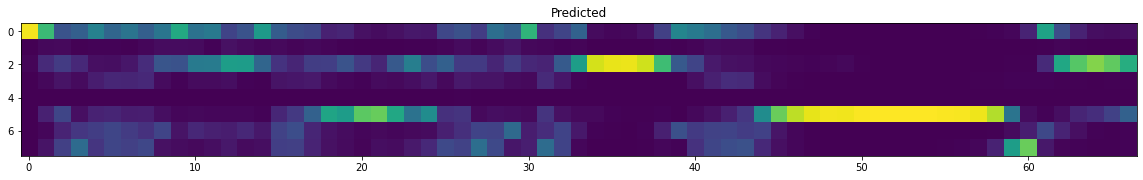

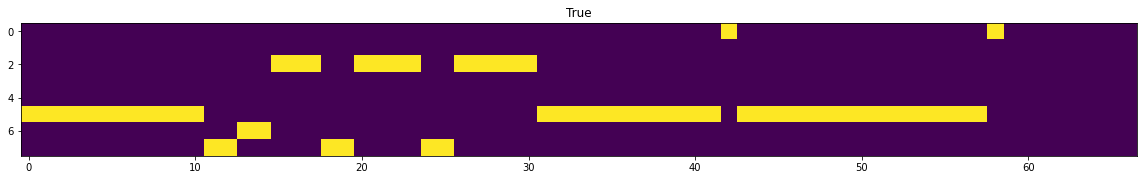

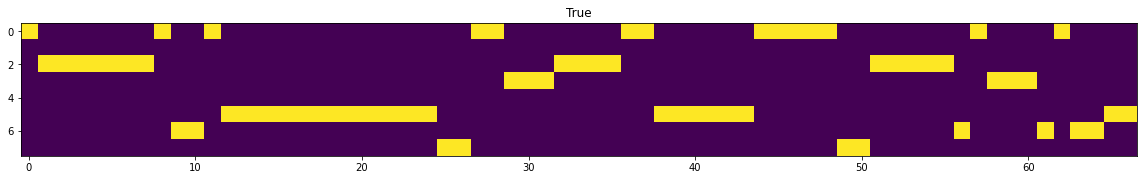

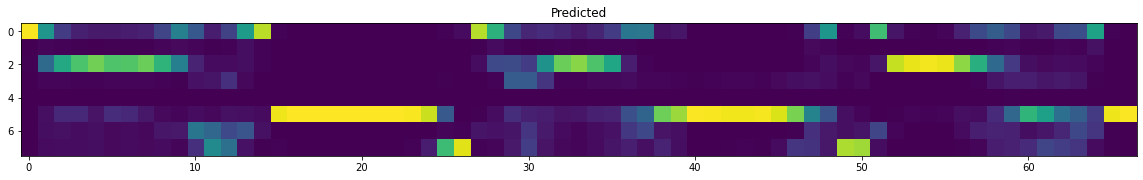

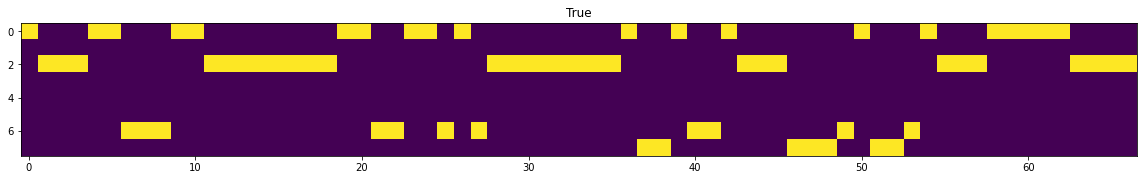

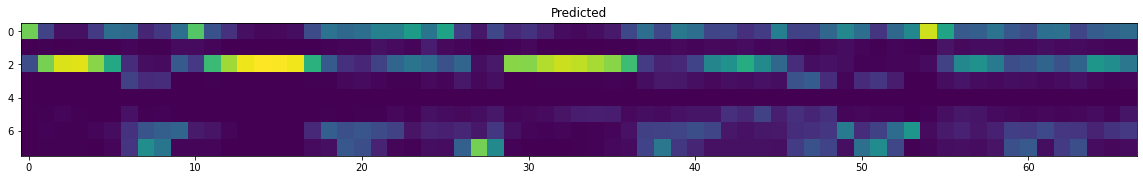

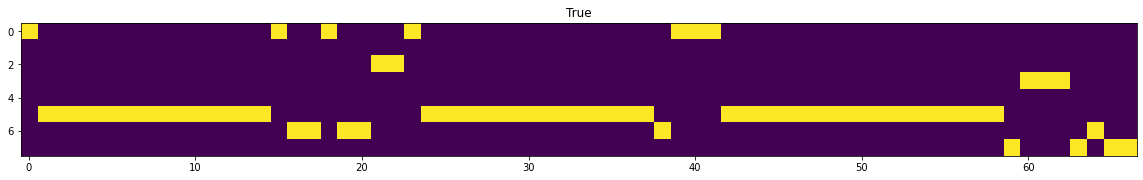

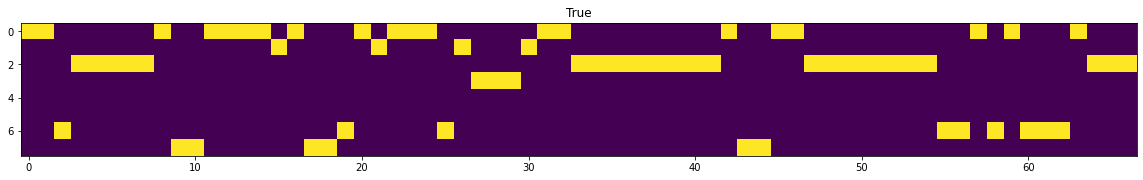

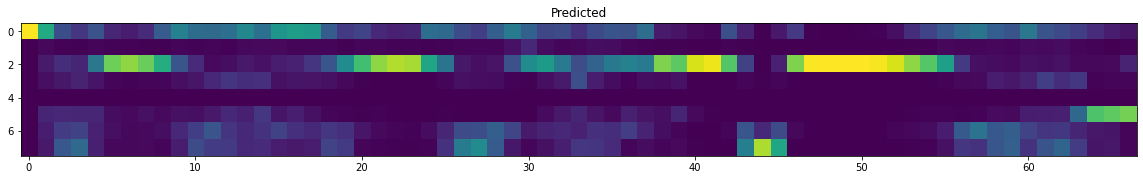

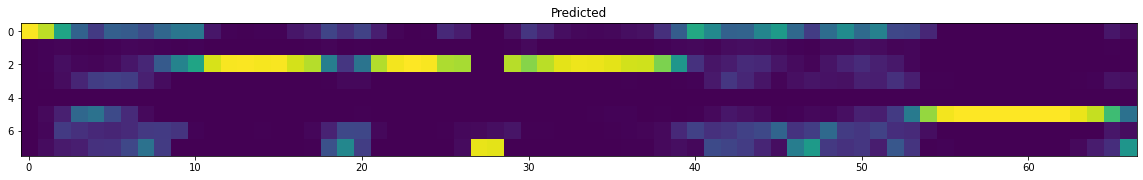

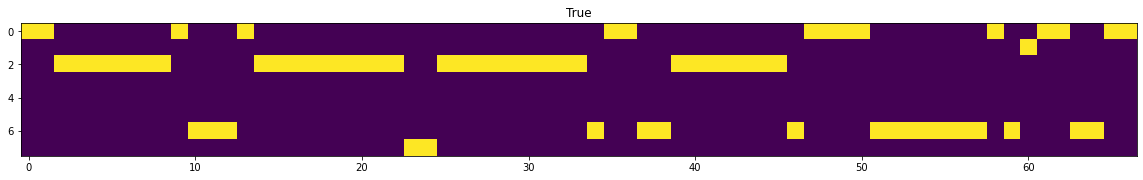

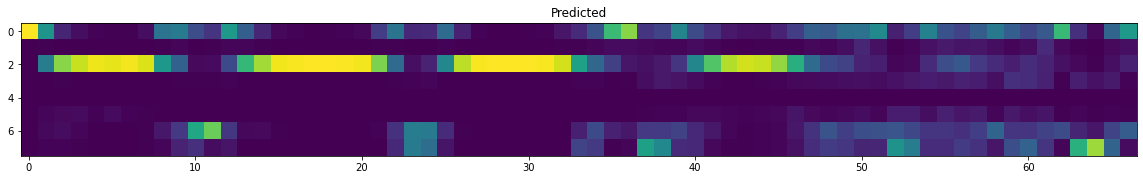

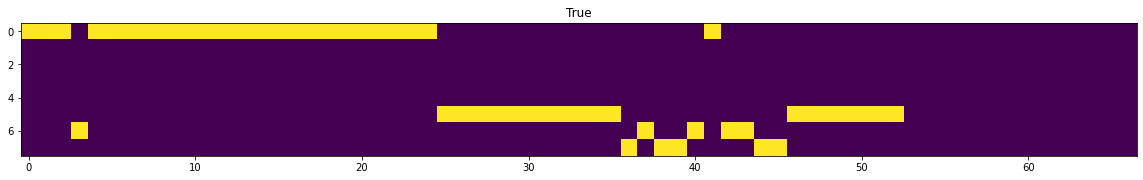

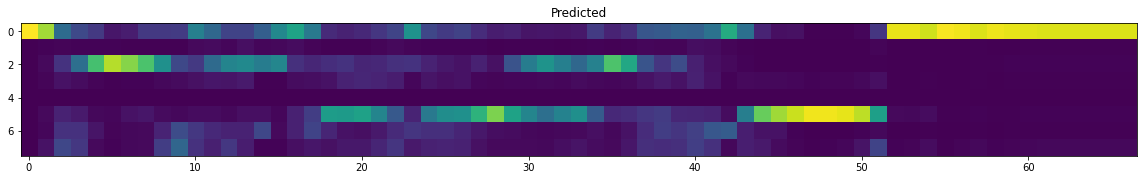

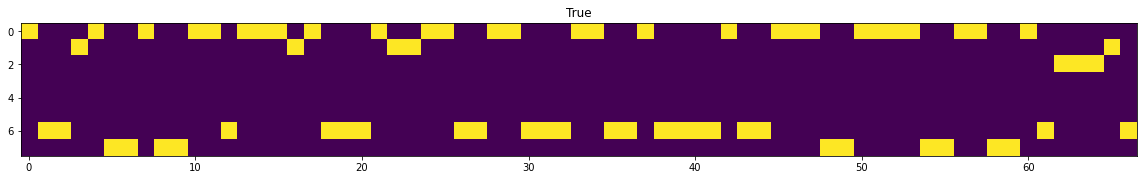

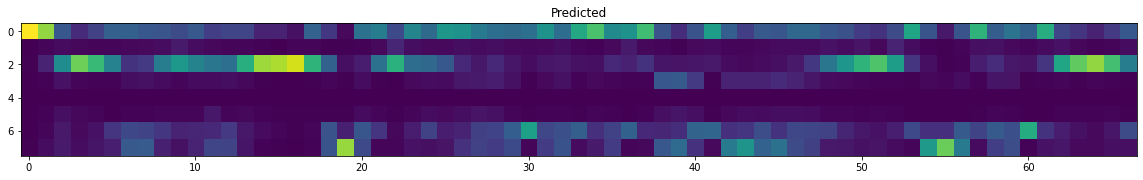

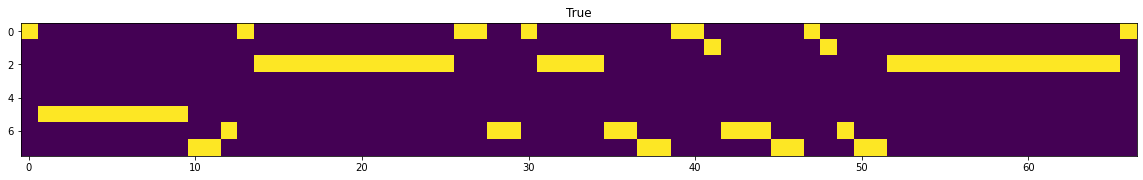

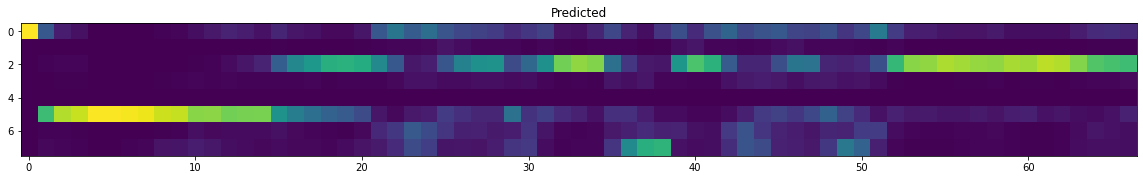

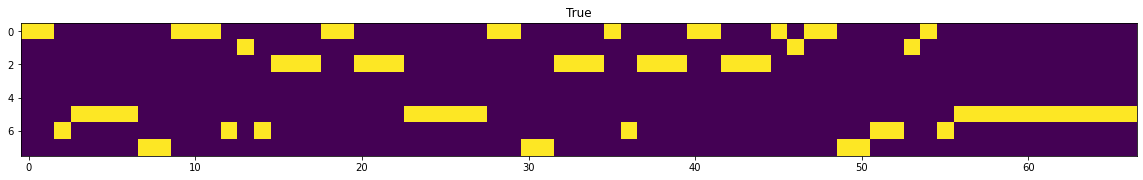

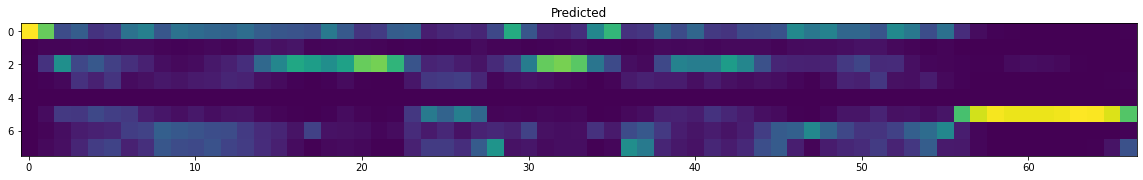

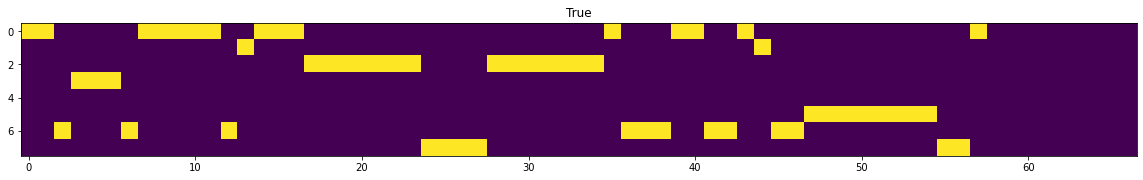

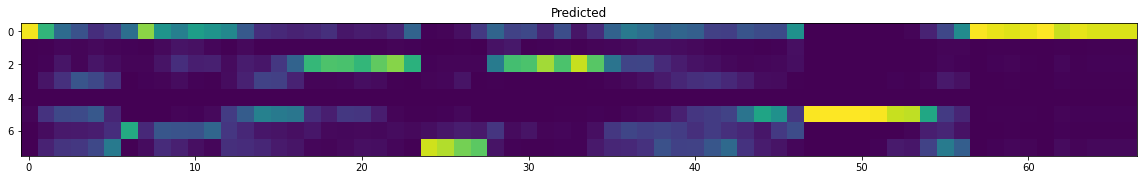

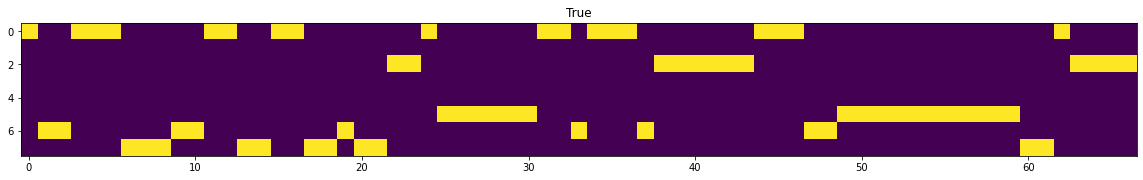

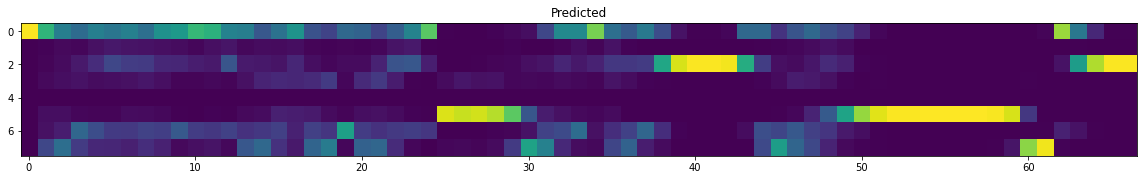

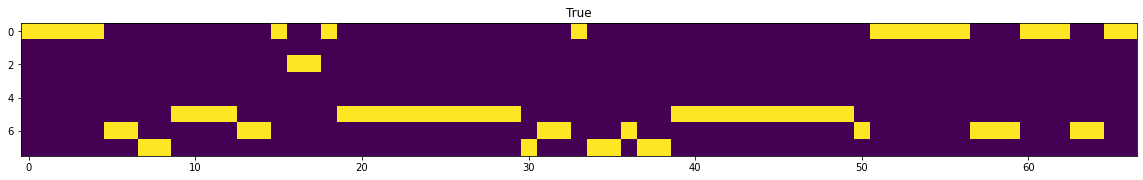

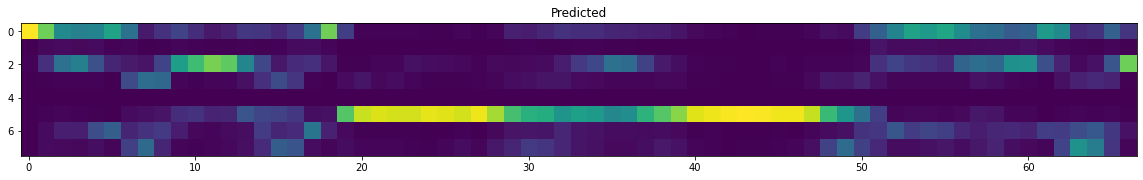

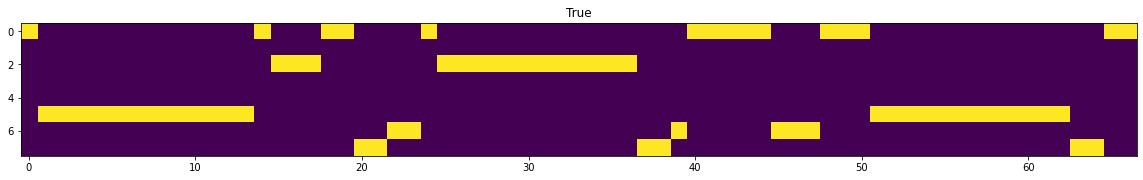

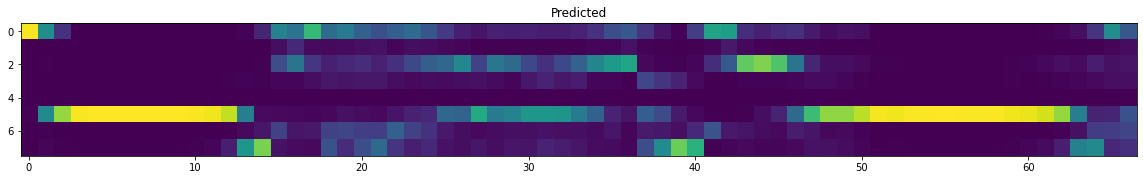

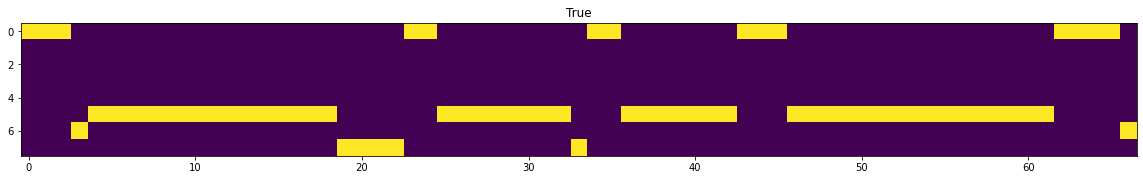

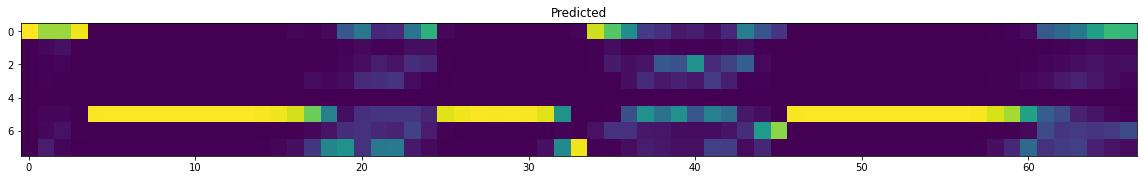

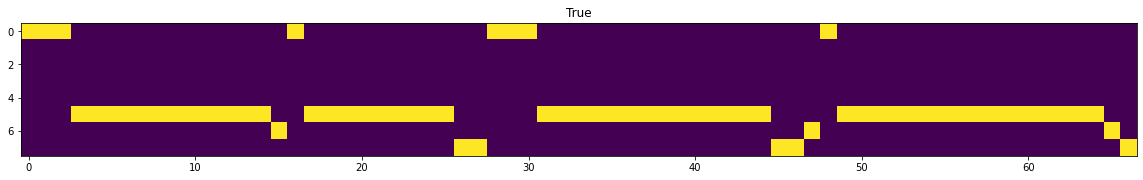

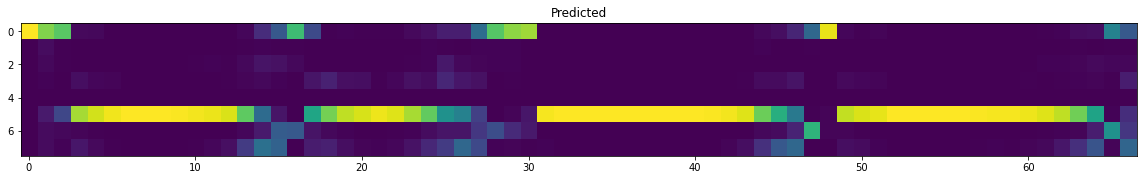

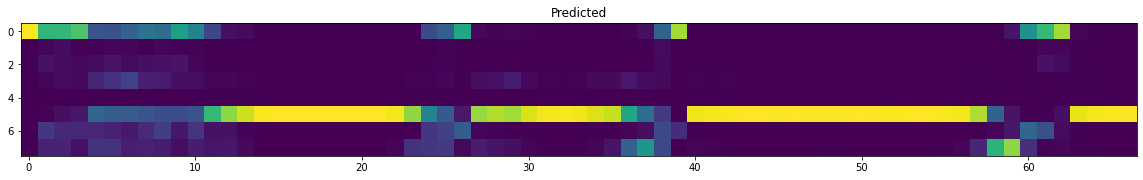

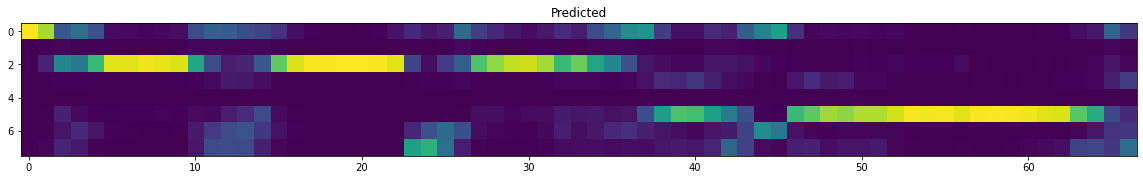

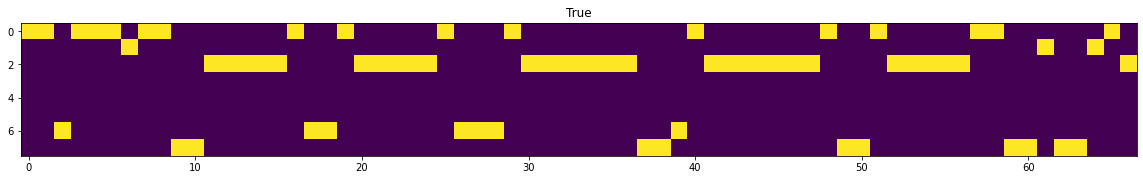

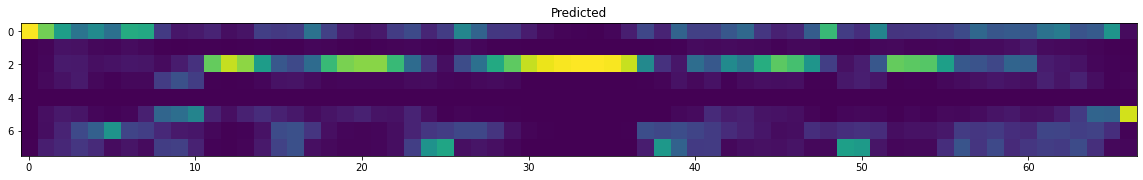

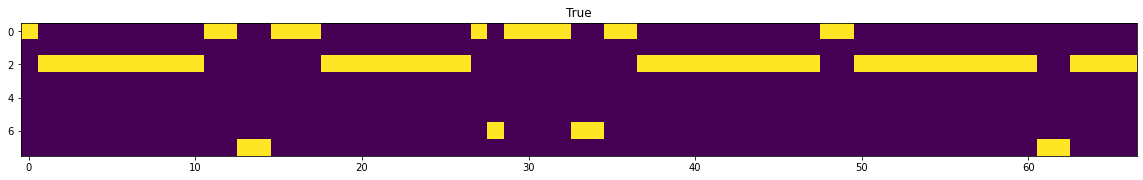

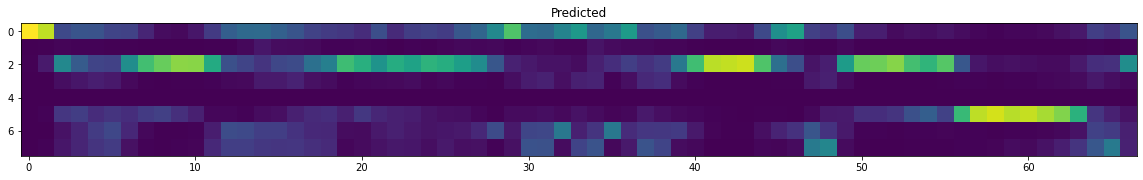

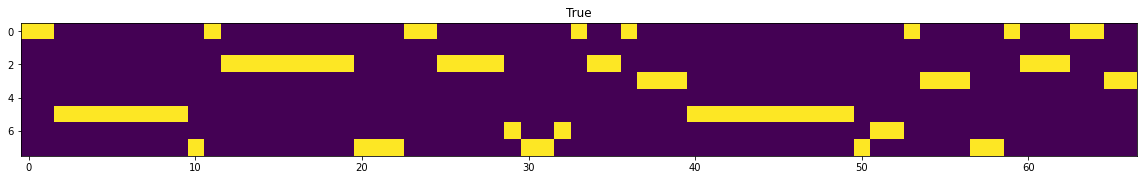

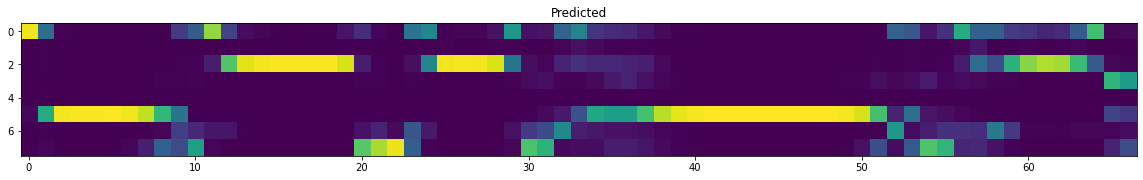

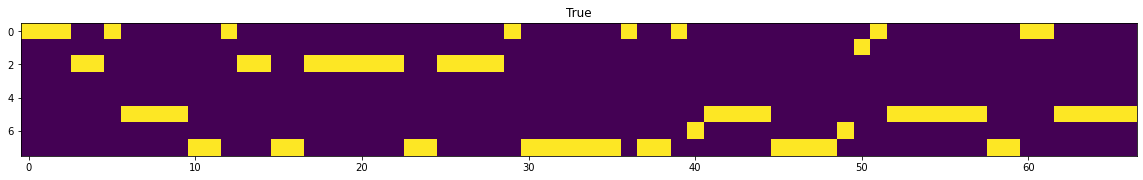

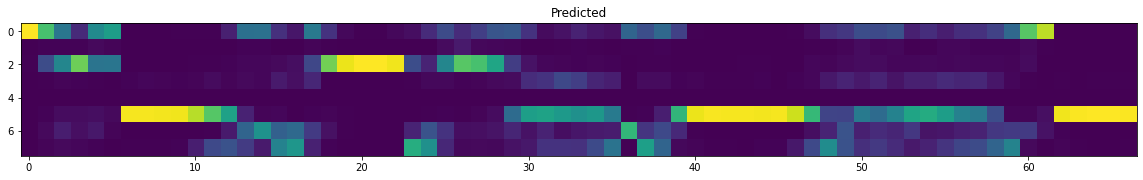

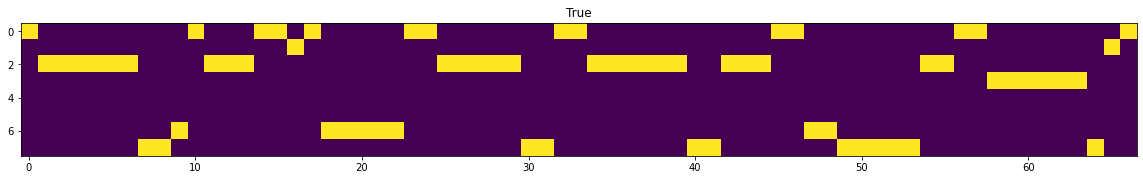

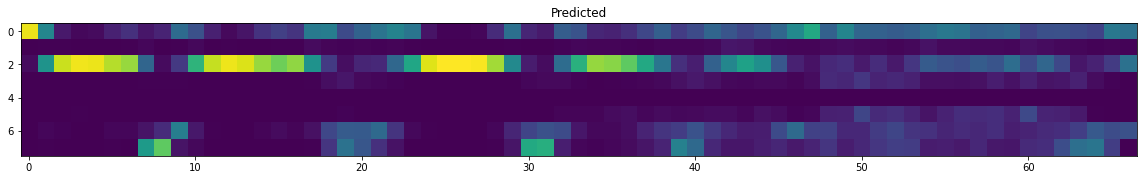

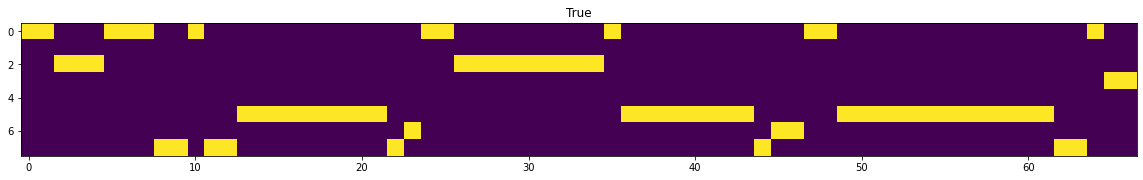

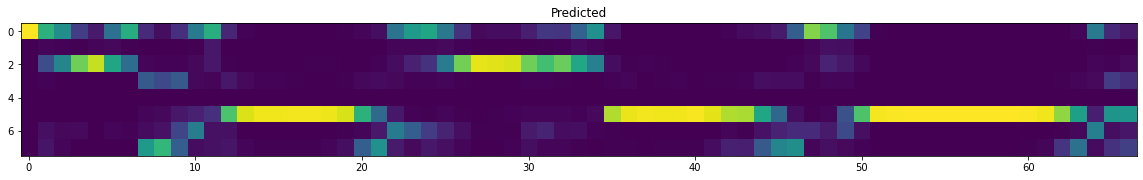

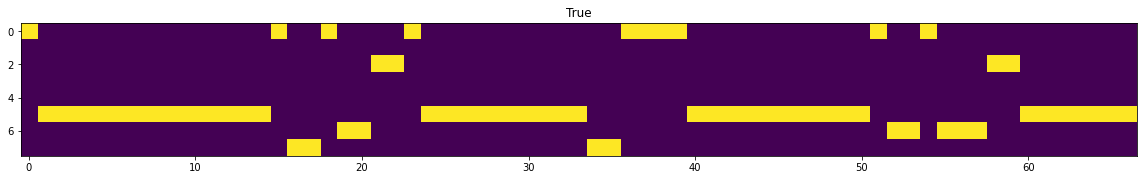

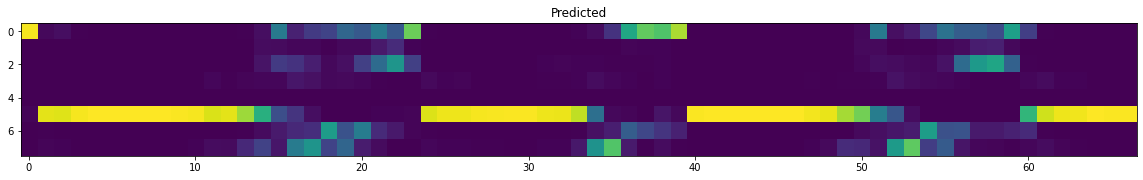

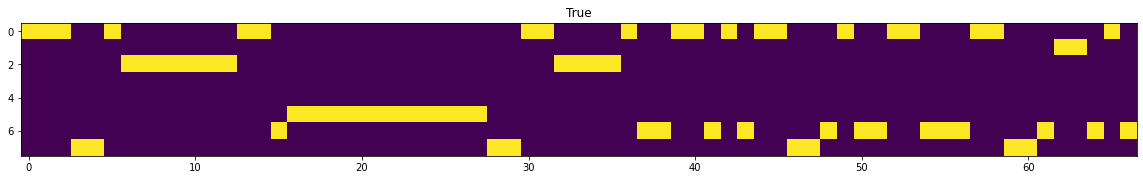

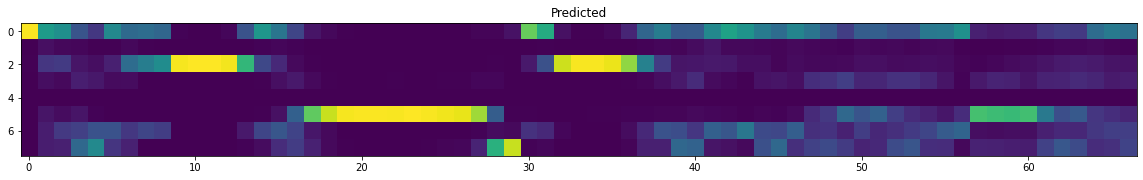

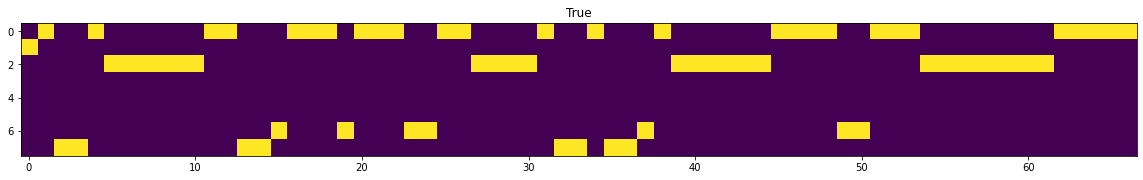

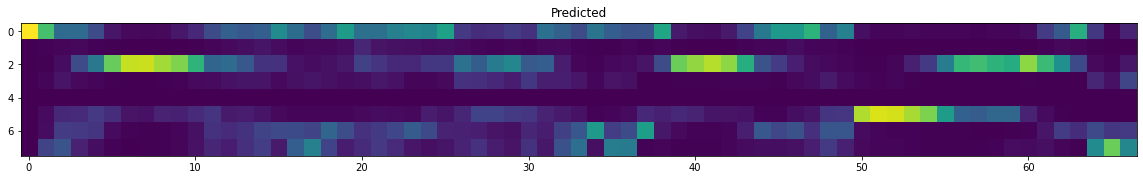

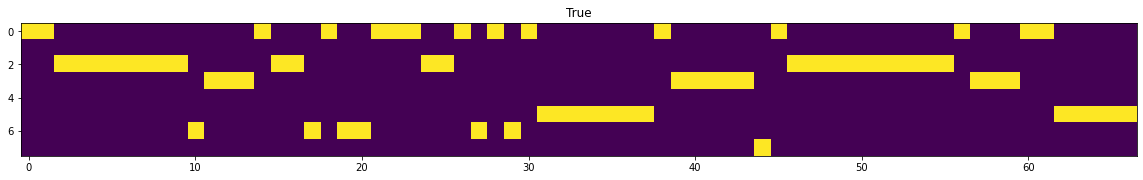

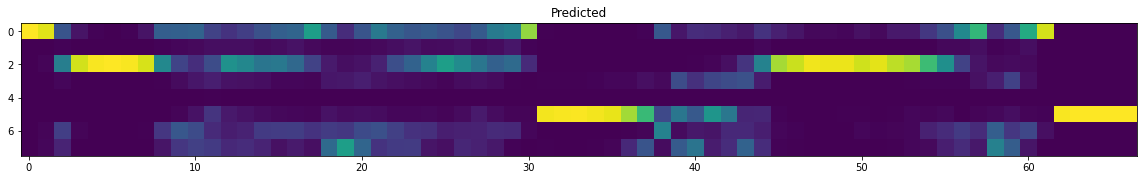

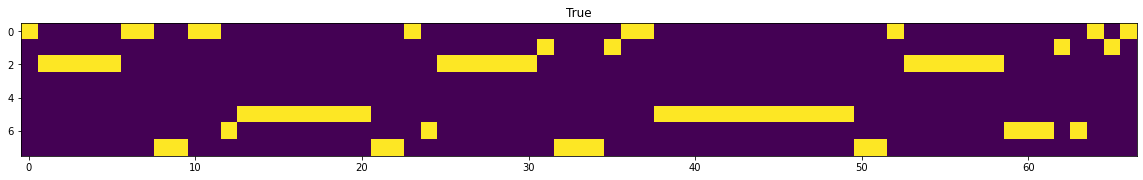

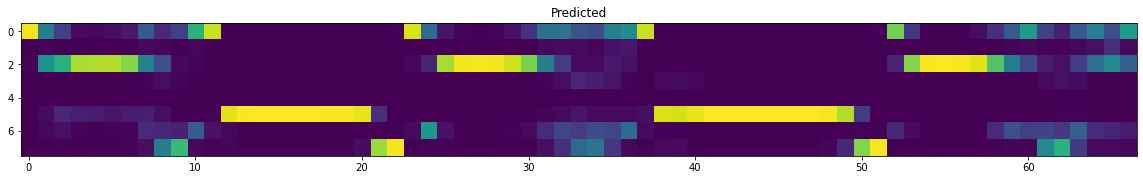

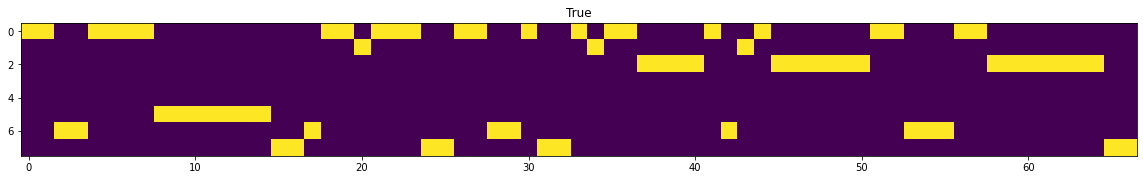

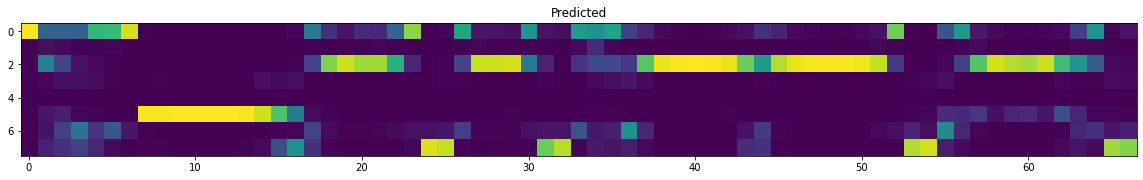

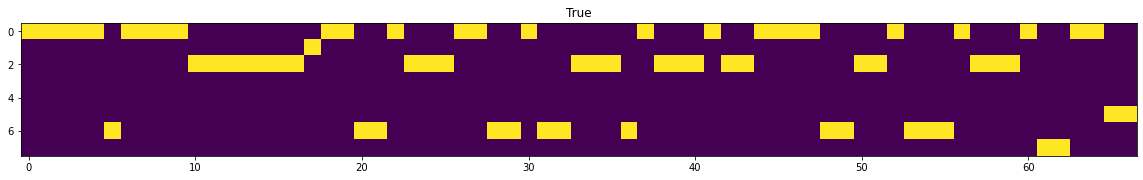

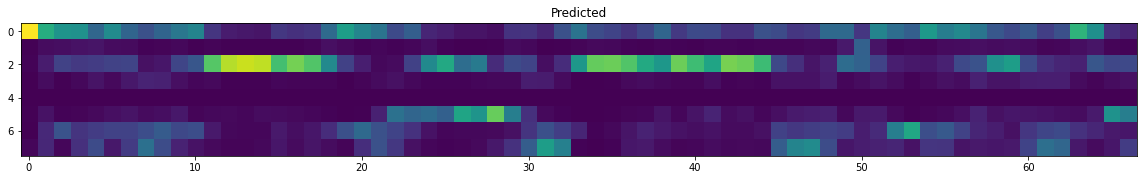

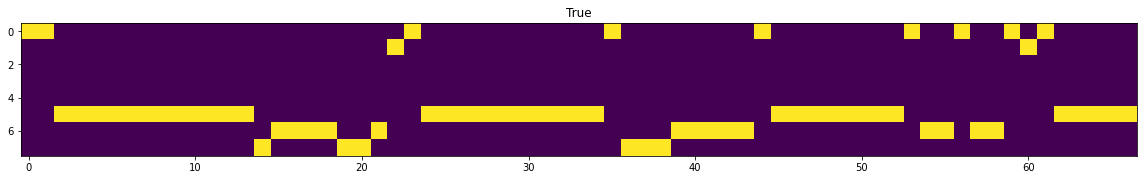

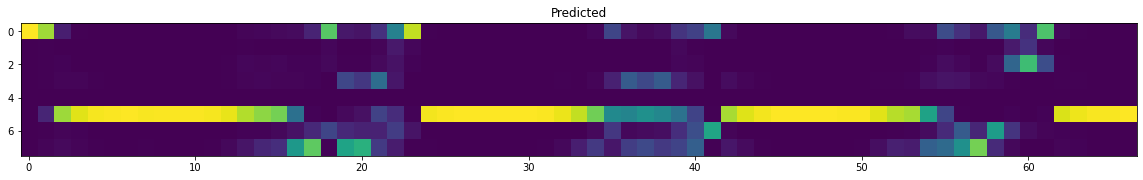

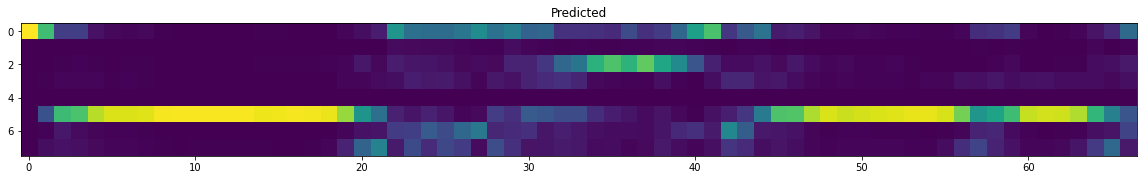

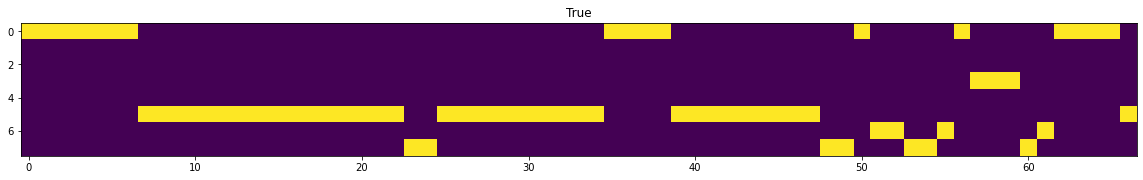

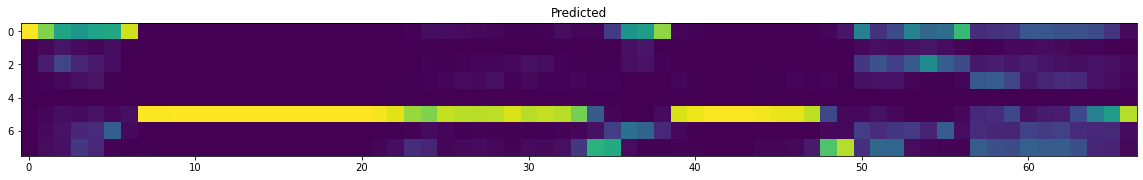

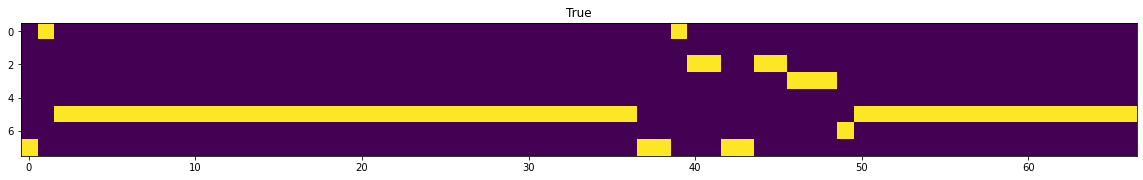

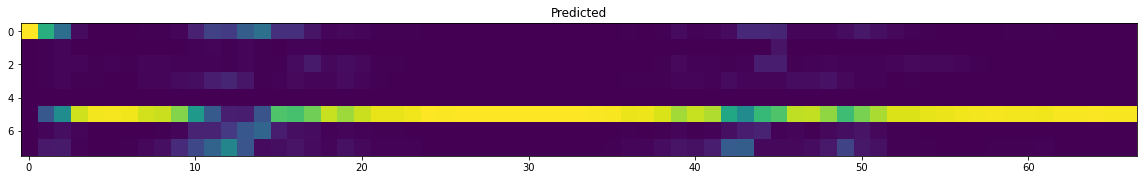

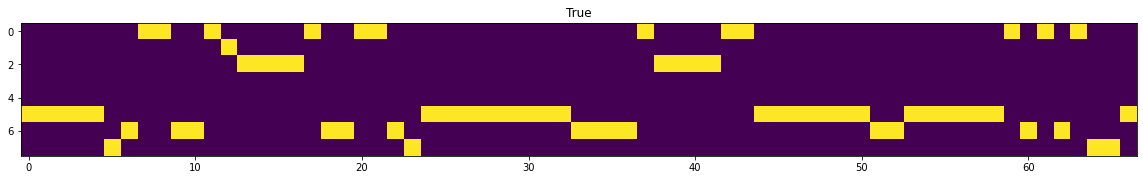

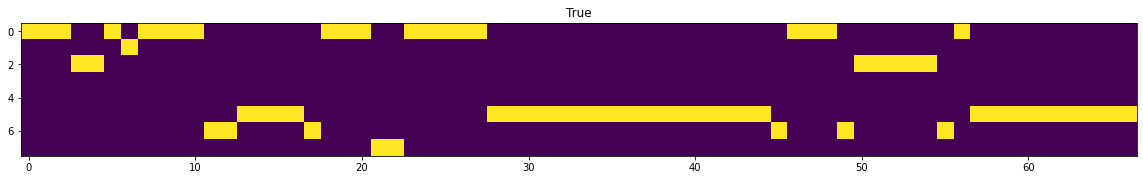

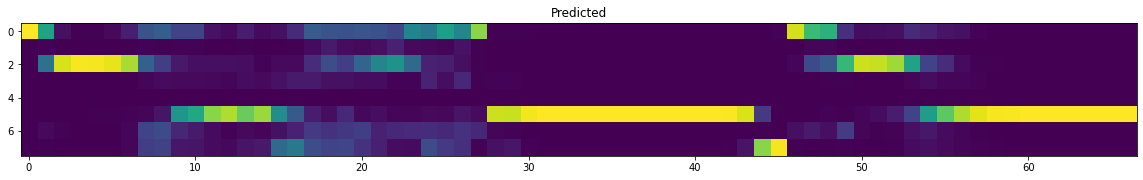

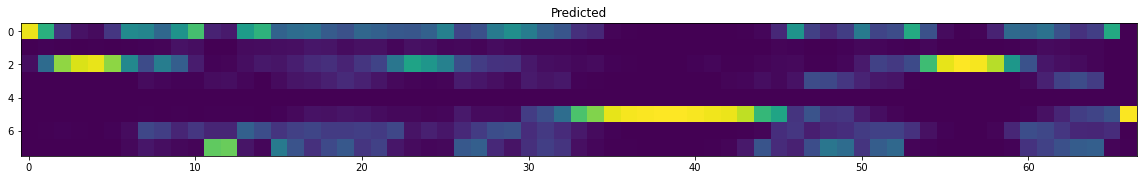

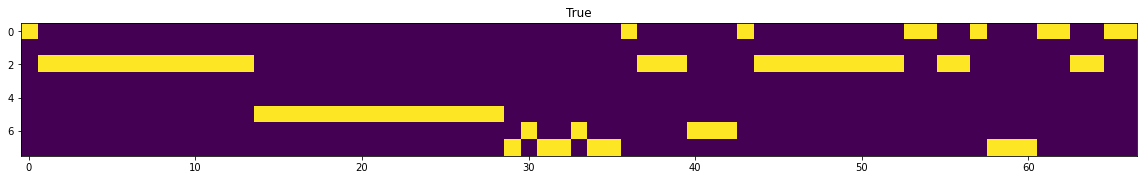

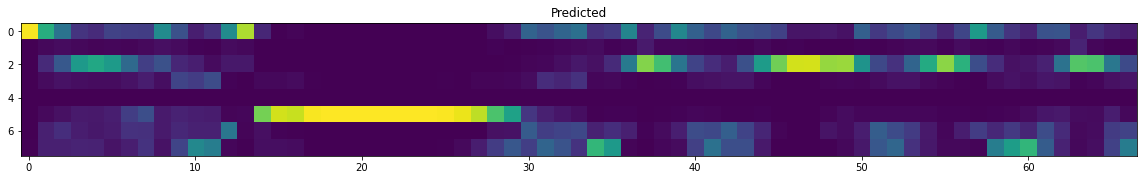

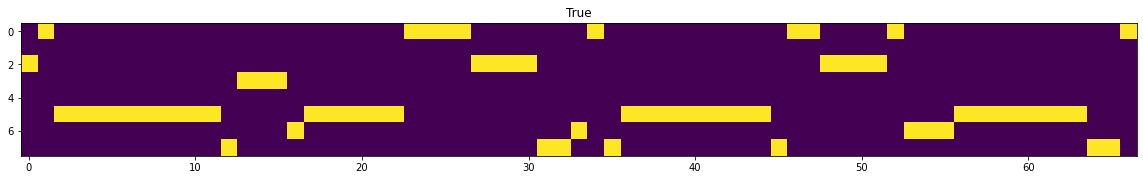

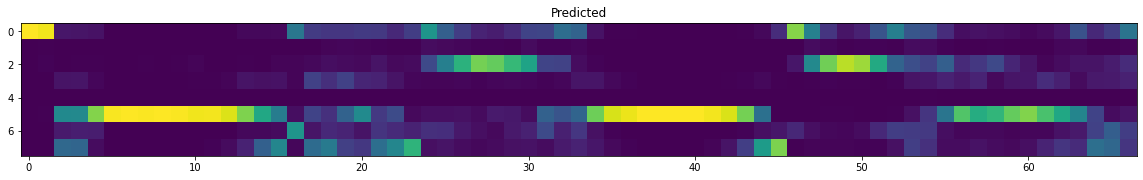

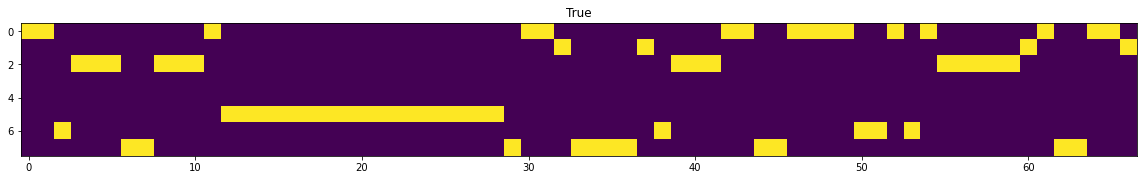

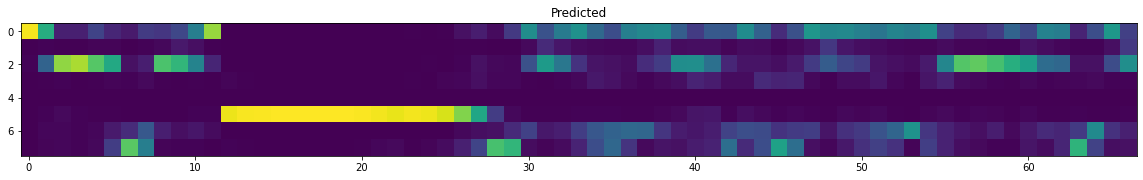

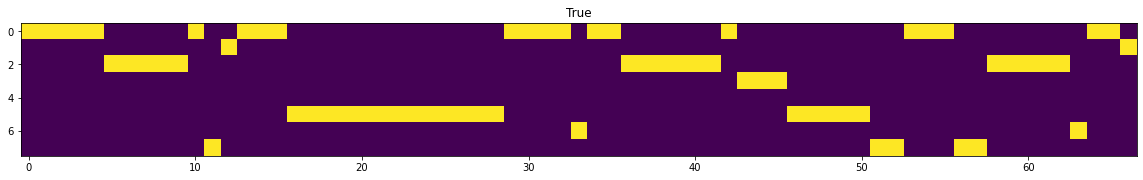

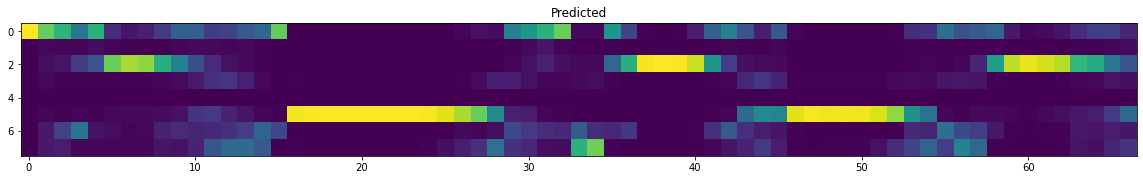

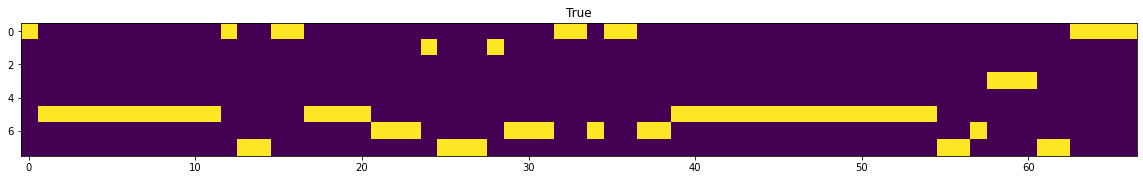

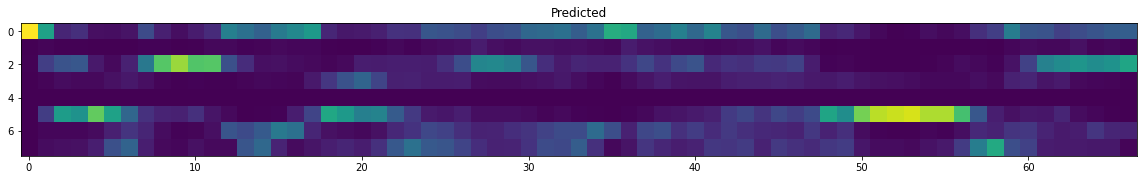

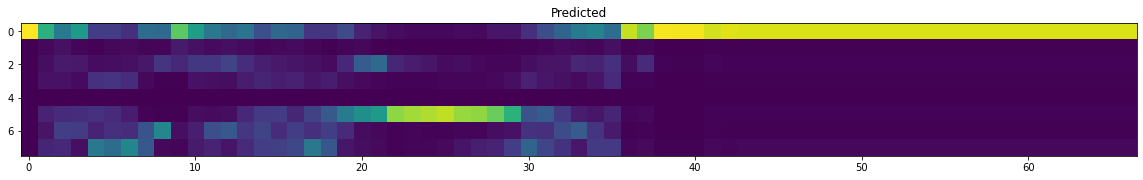

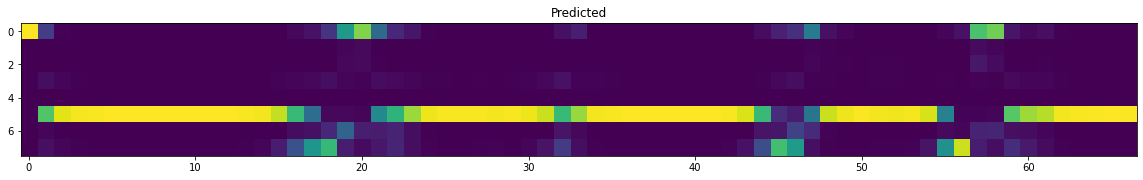

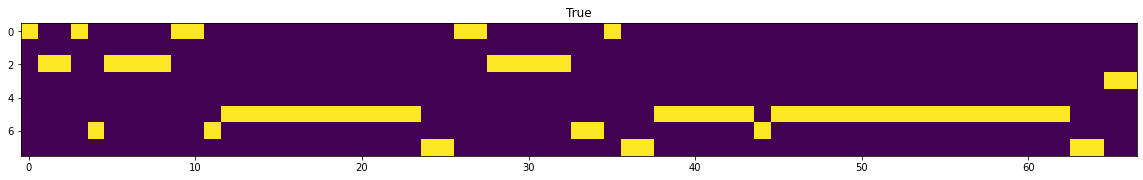

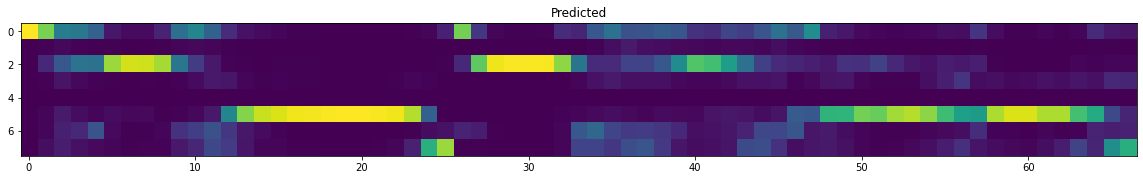

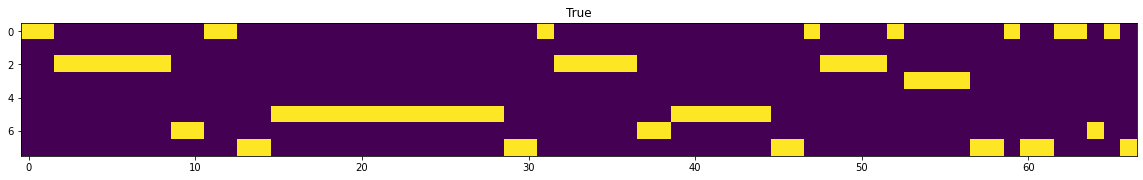

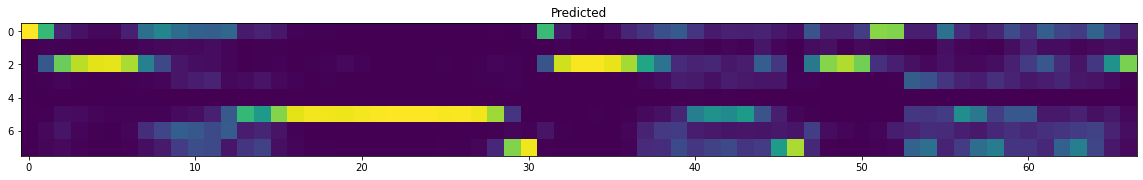

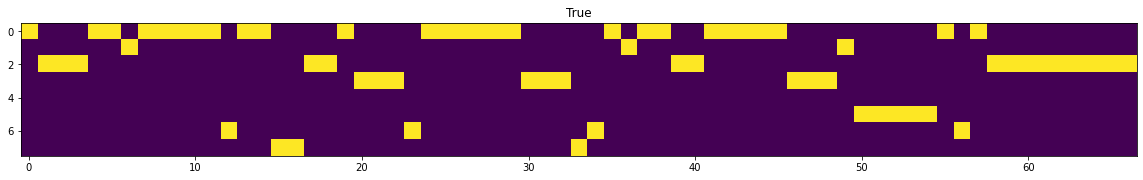

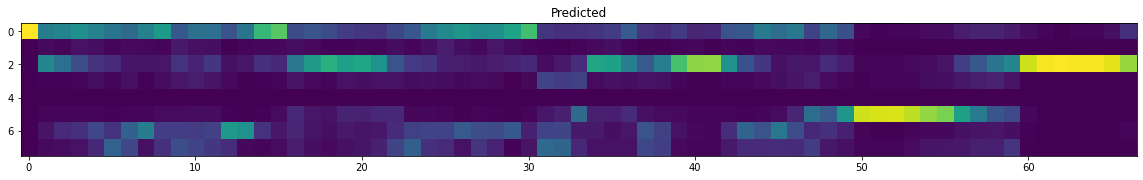

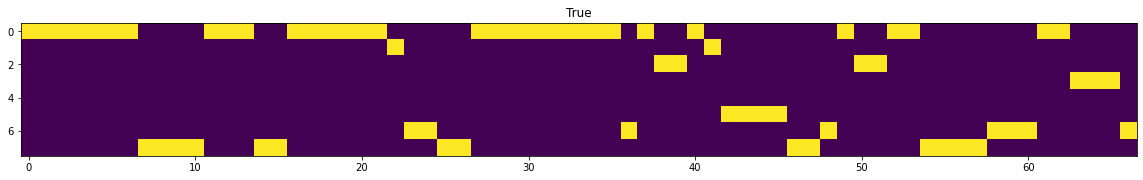

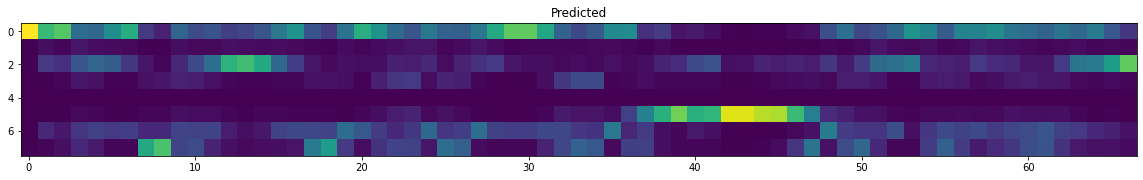

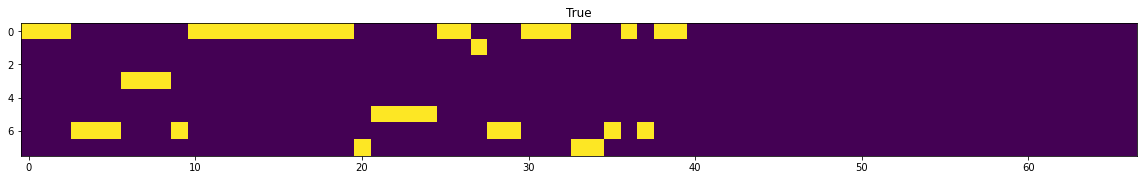

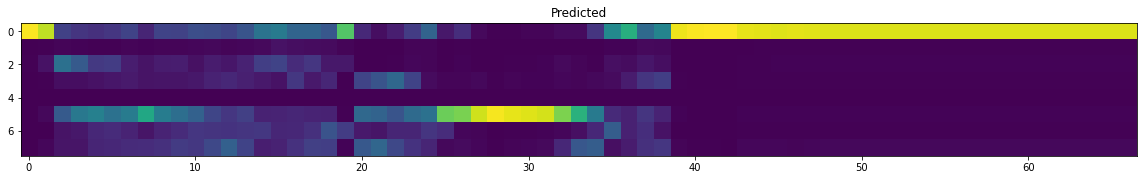

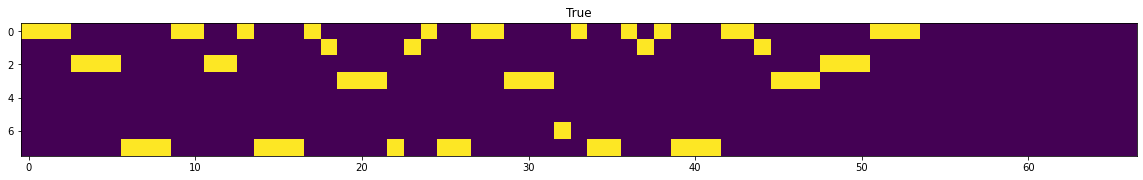

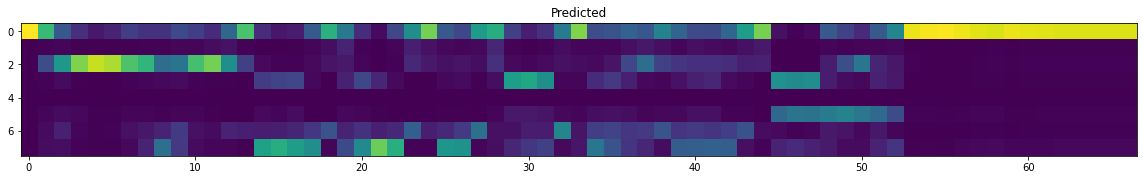

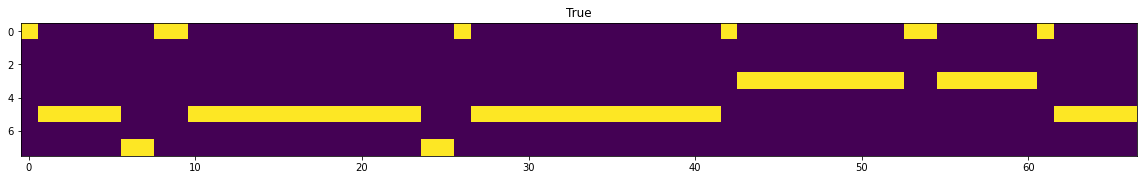

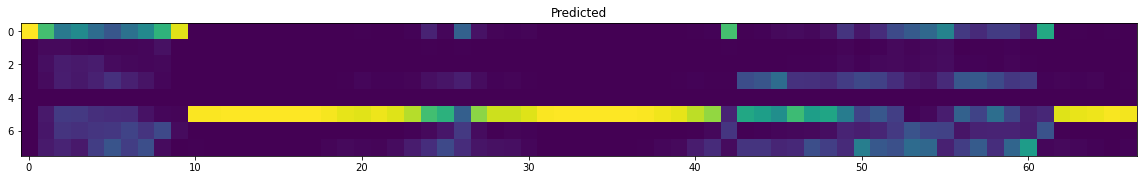

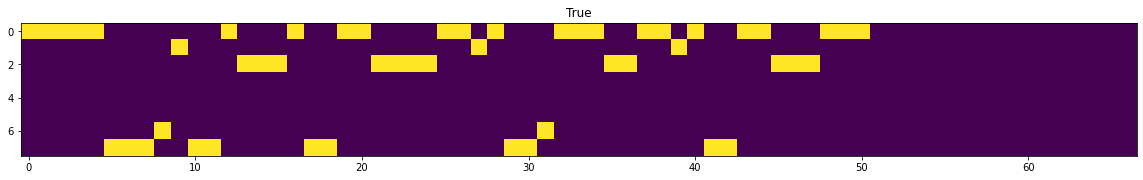

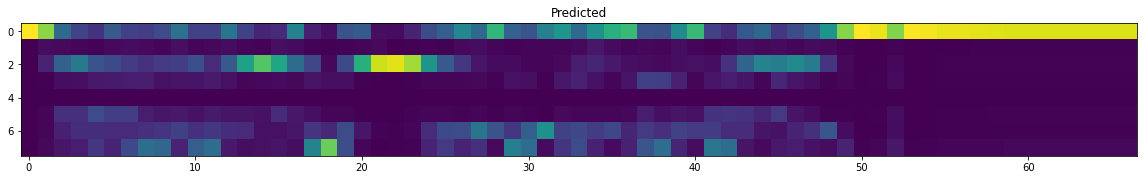

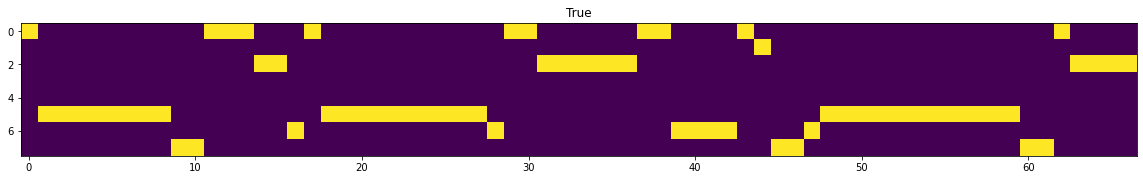

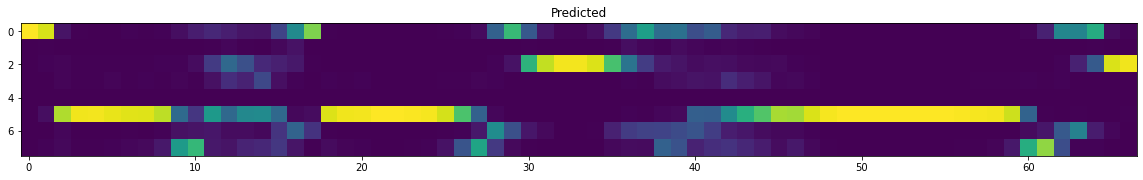

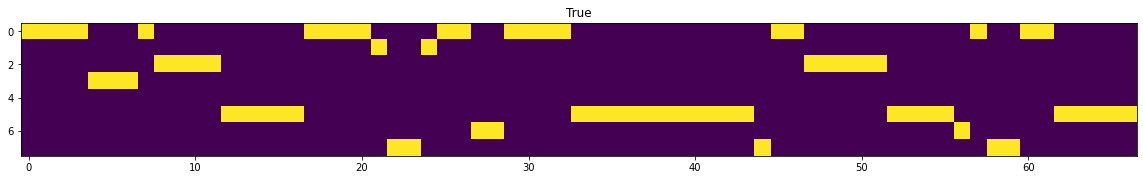

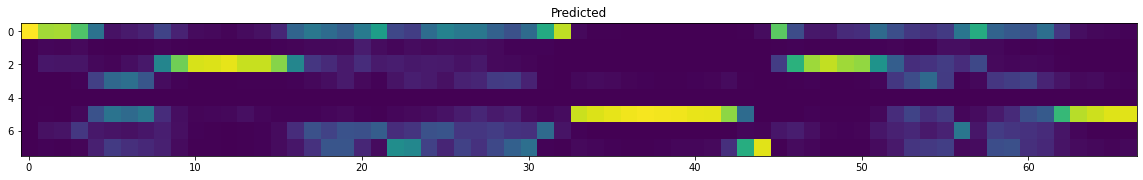

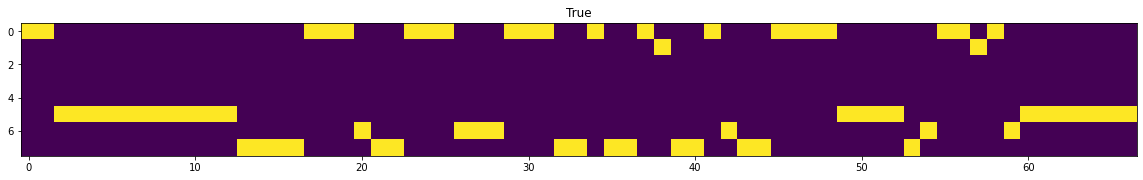

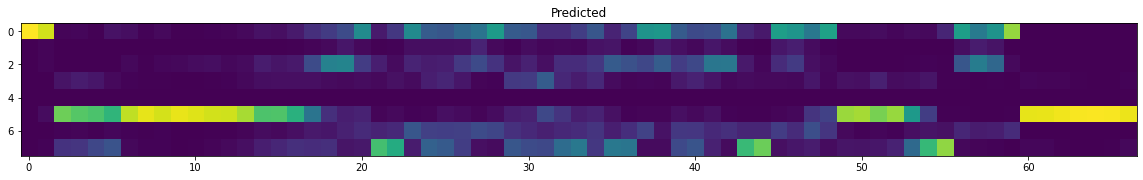

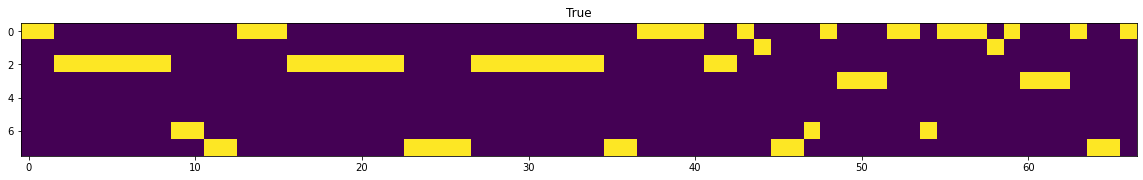

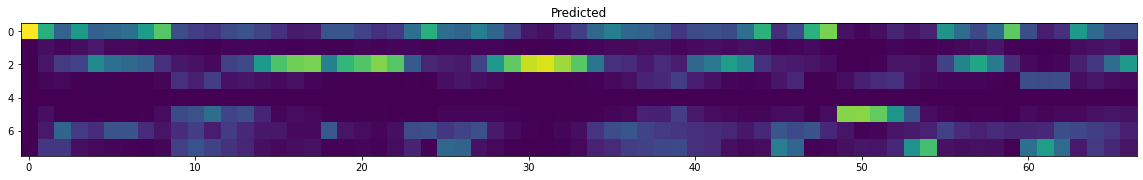

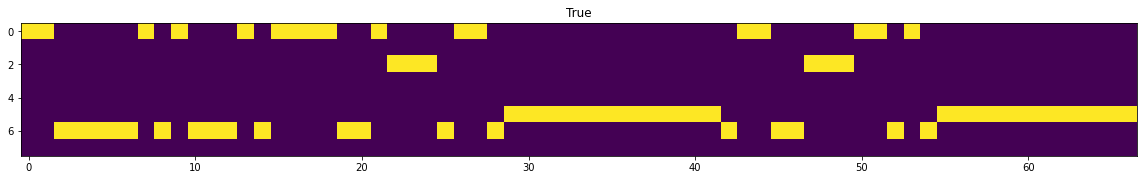

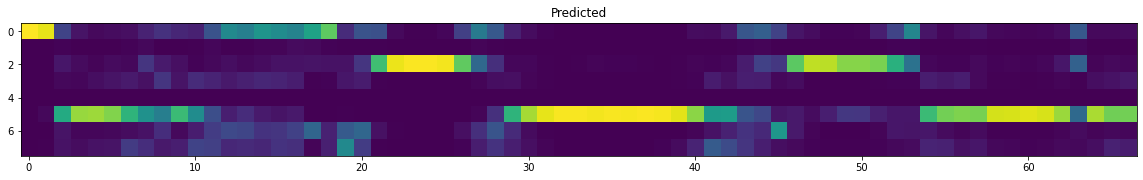

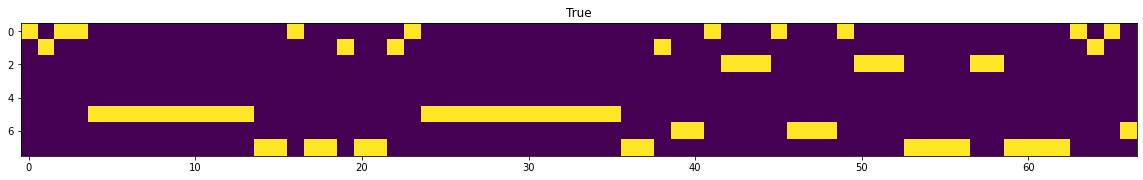

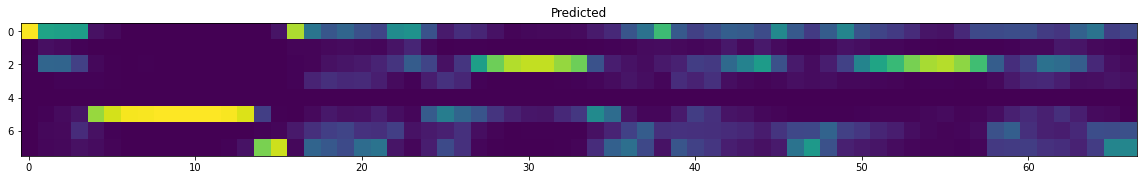

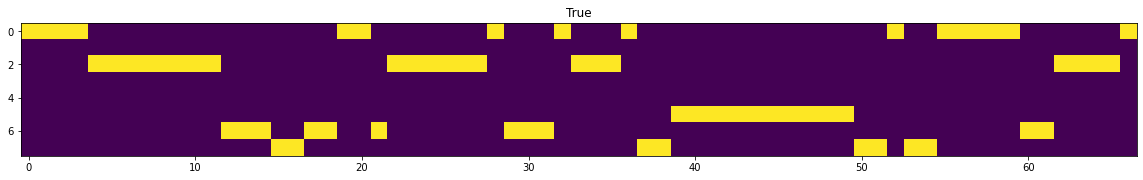

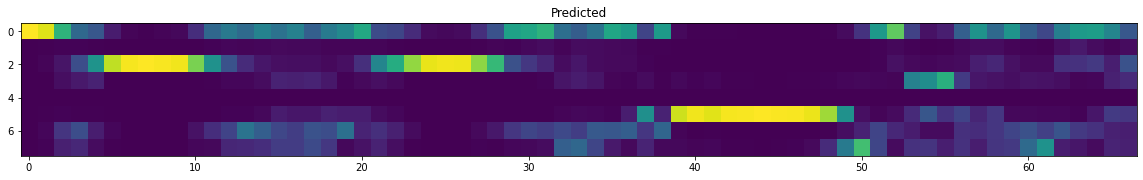

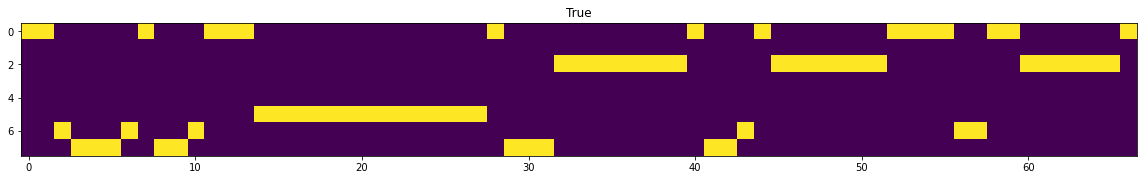

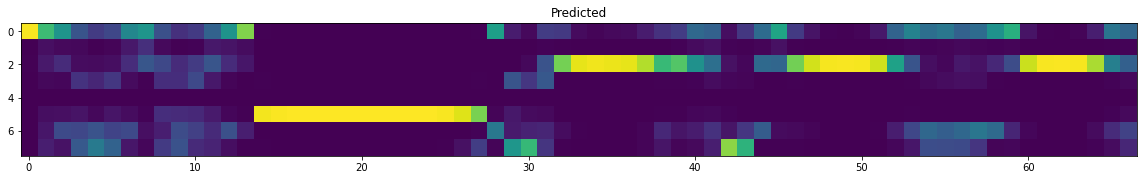

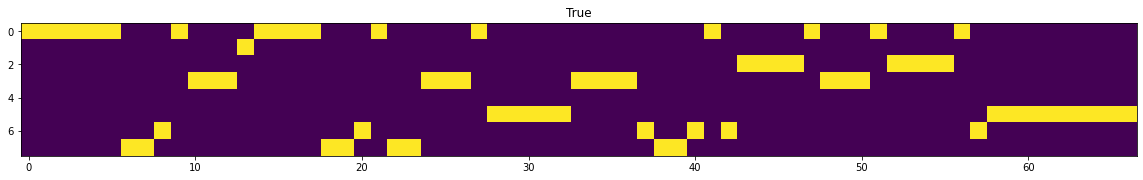

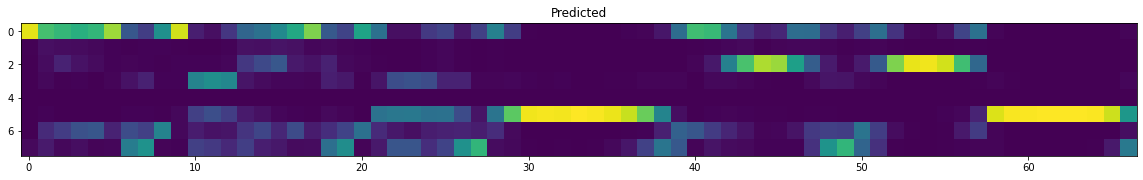

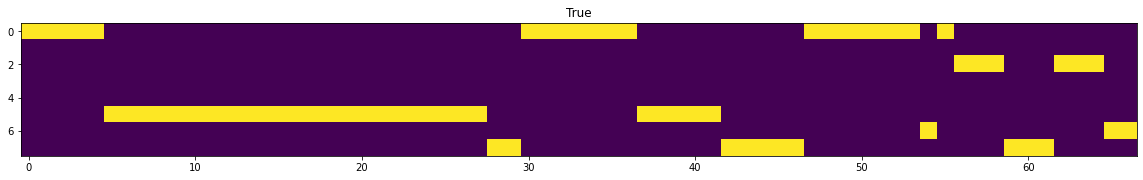

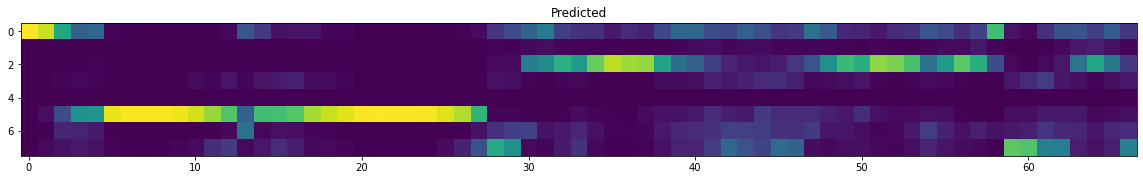

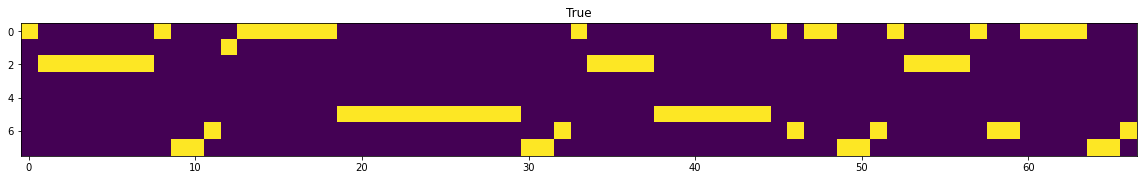

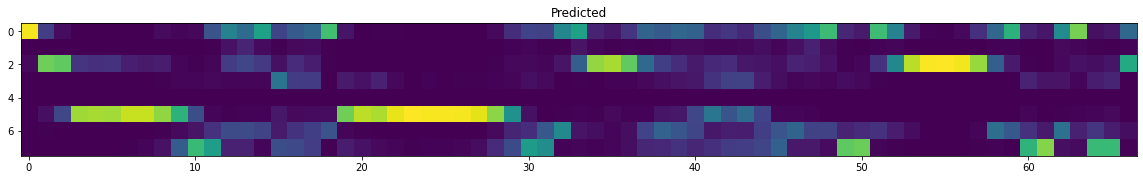

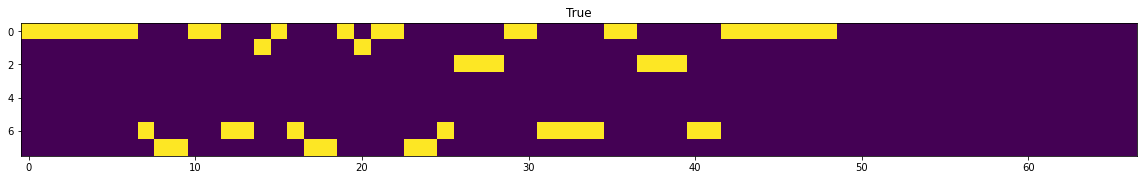

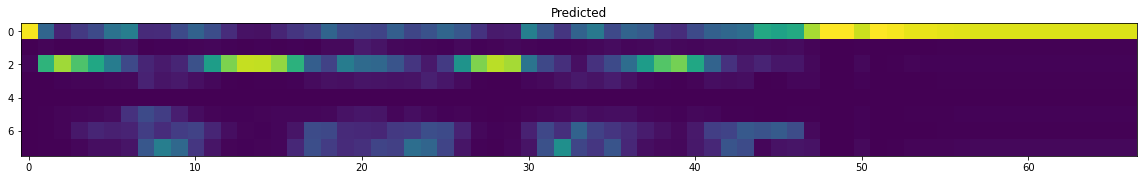

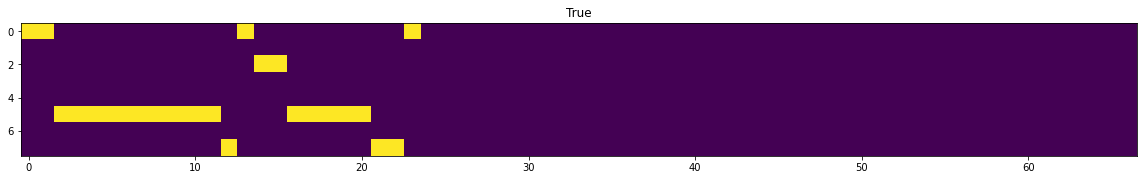

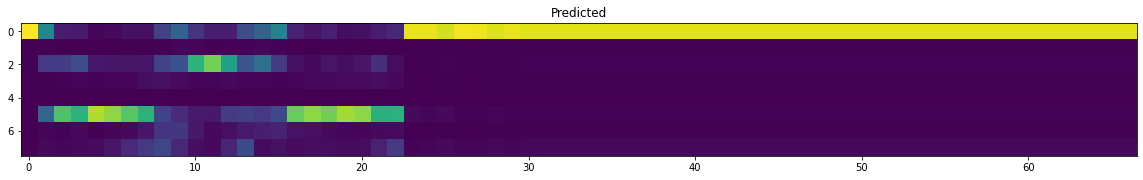

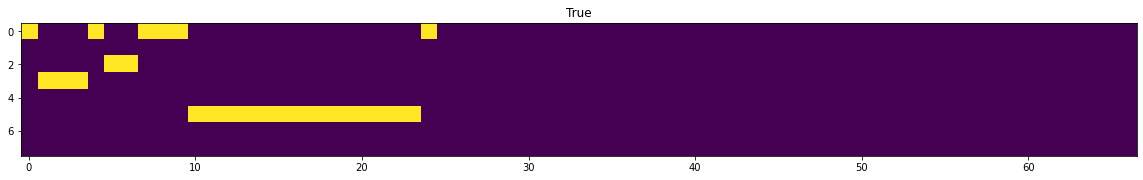

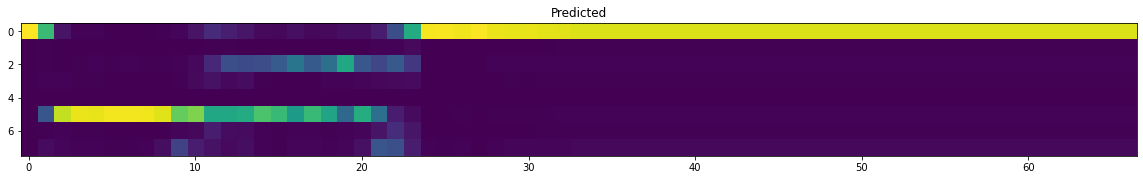

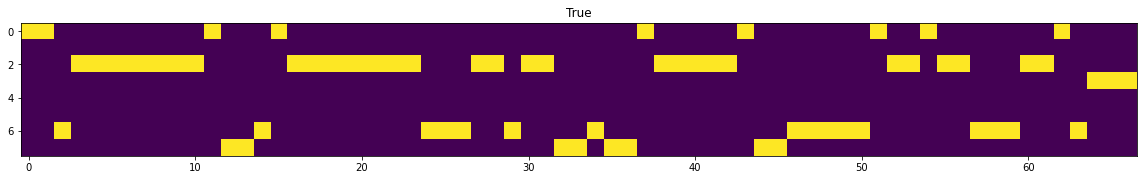

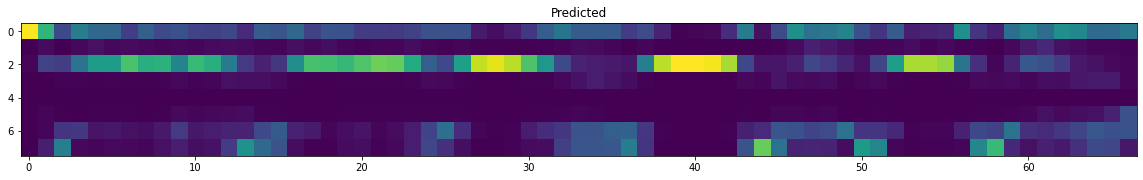

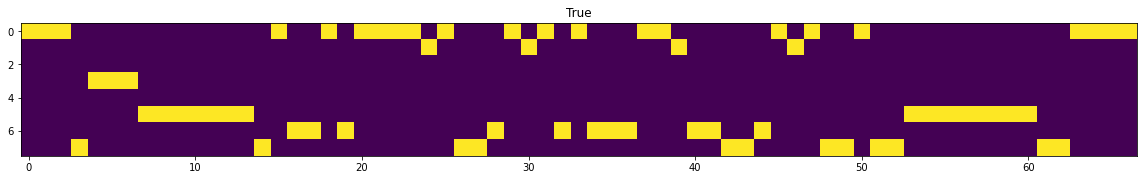

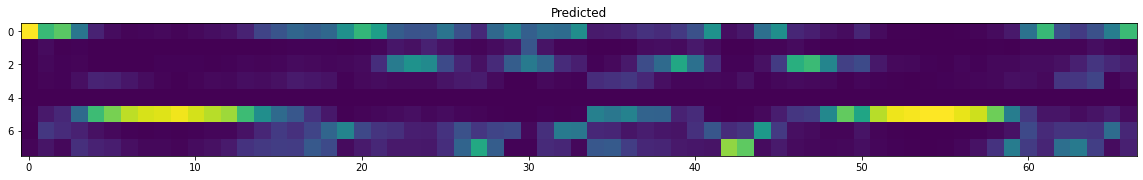

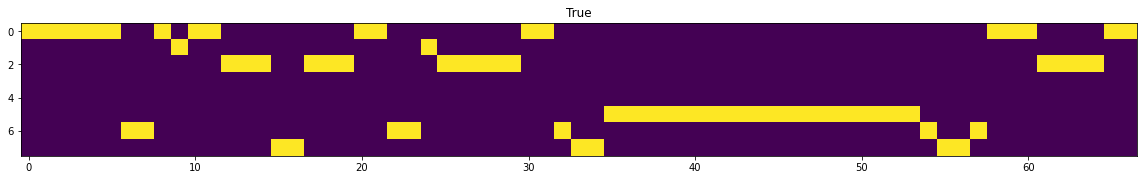

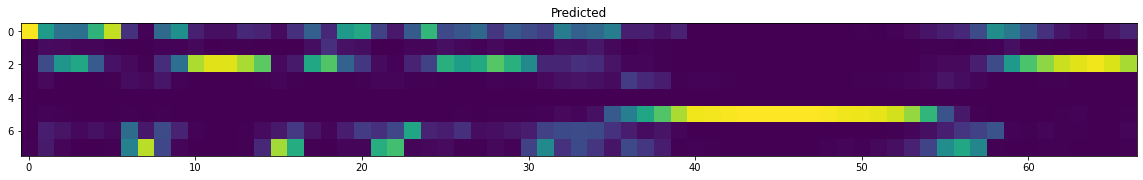

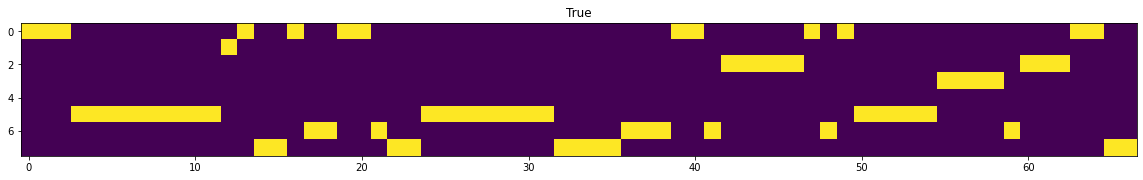

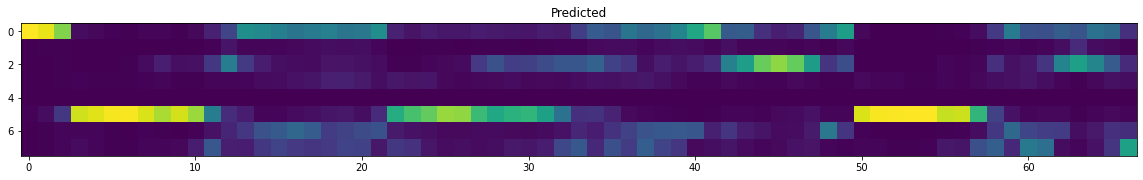

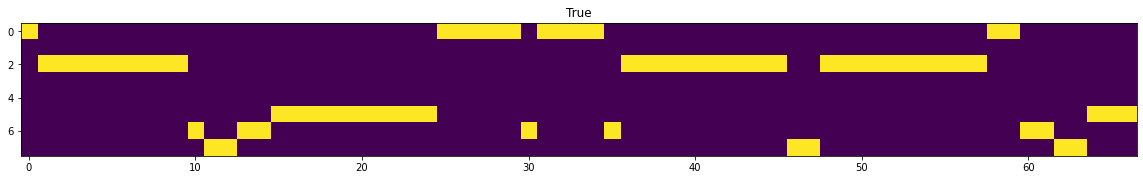

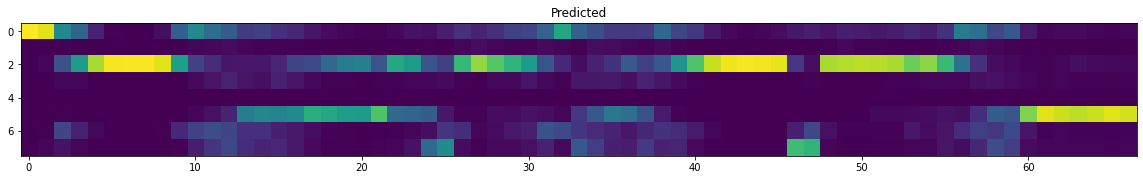

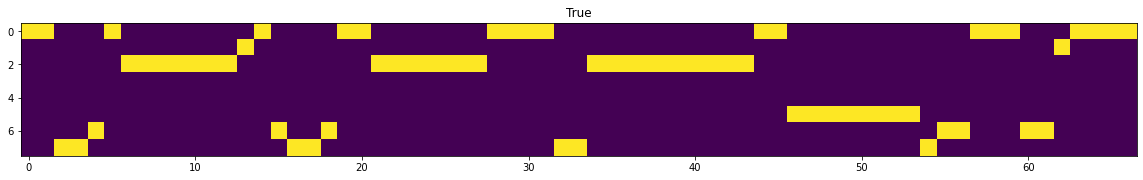

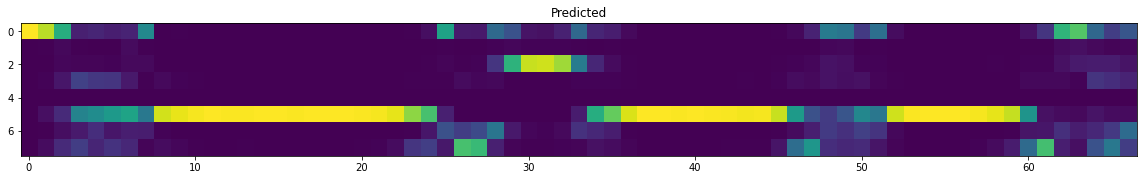

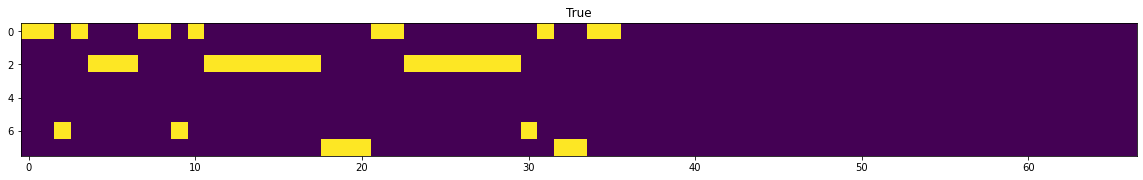

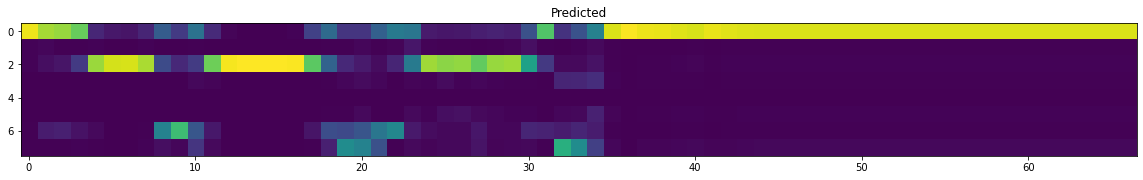

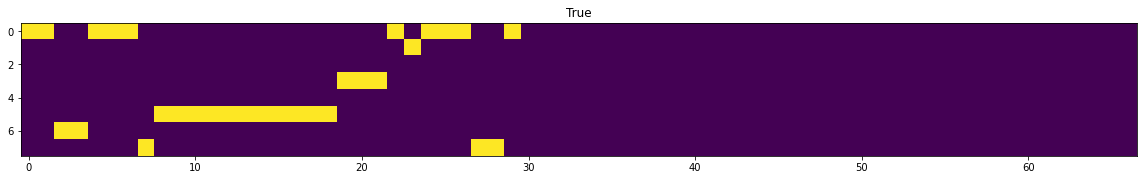

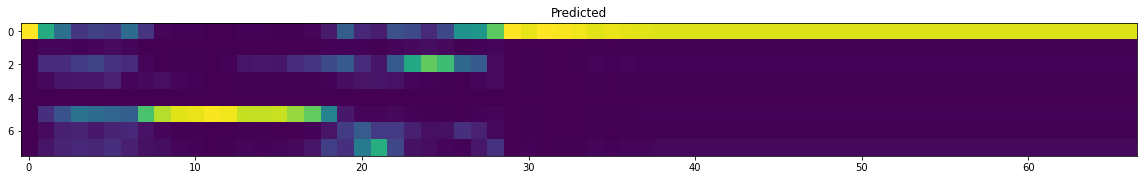

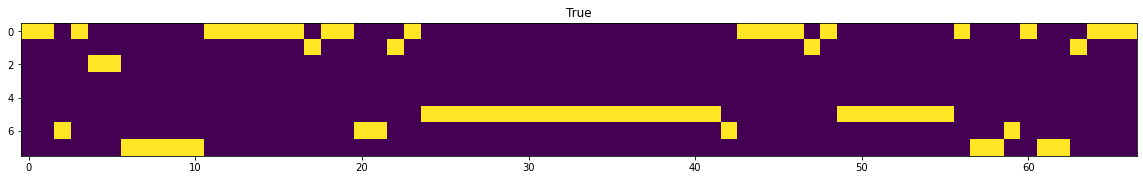

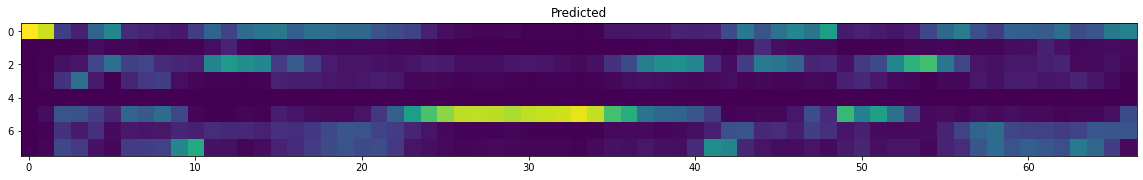

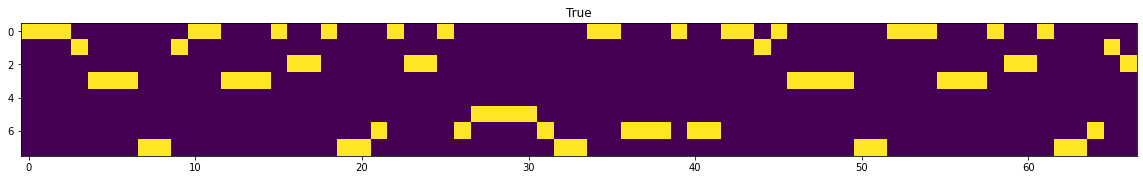

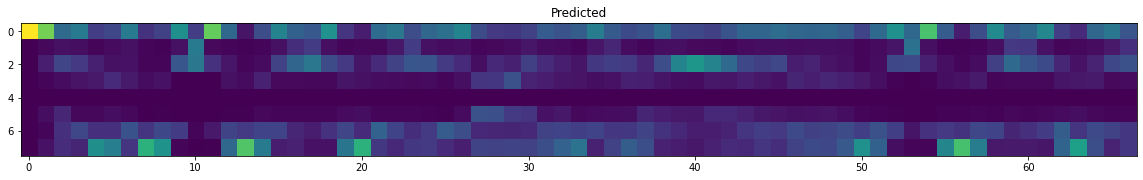

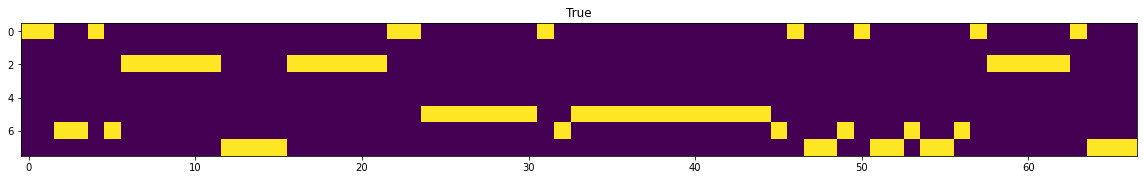

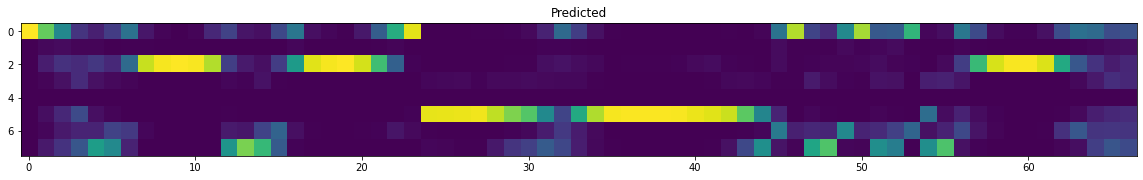

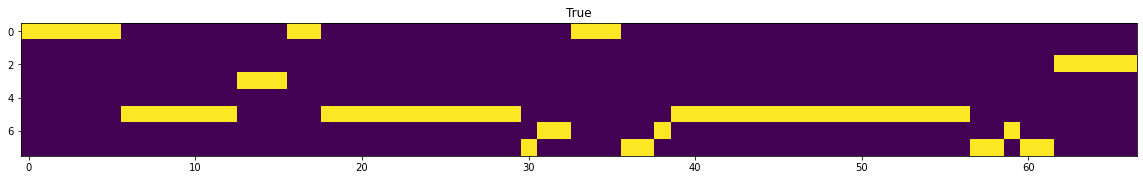

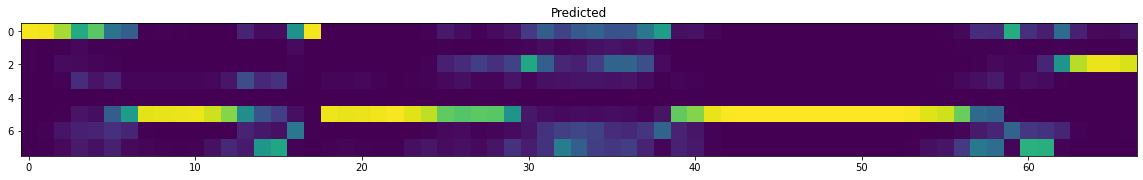

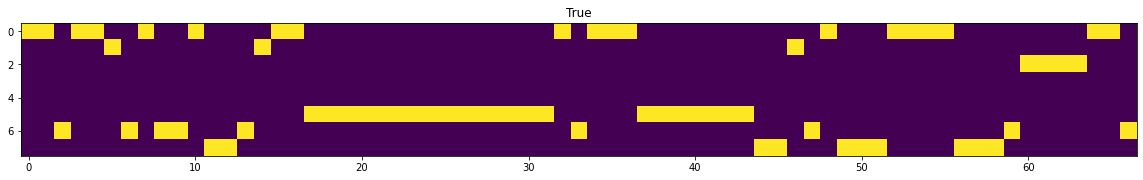

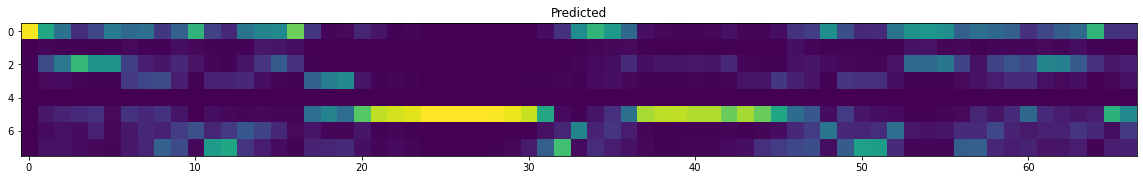

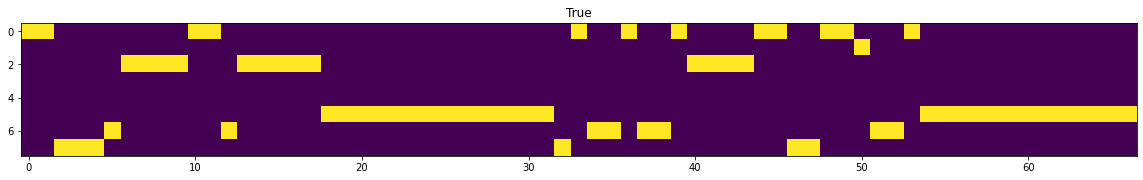

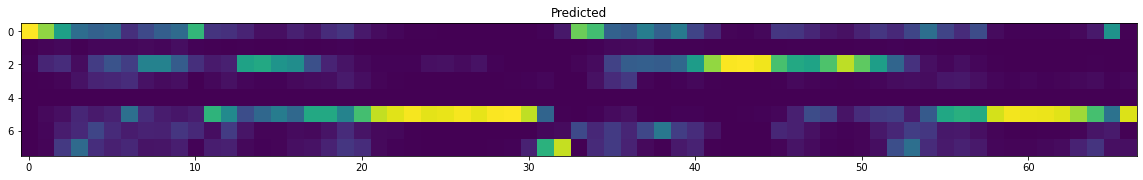

In [ ]:
# Checking for all results
for i in range(514):
    plt.figure(figsize=(20,4))
    plt.title("True")
    plt.imshow(test_y[i][0:67].T)
    plt.figure(figsize=(20,4))
    plt.title("Predicted")
    plt.imshow(preRes[i][0:67].T)
    plt.show()

In [21]:
# Saving all results
originals = []
predictions = []
for i in range(514):
    originals.append(test_y[i][0:67].T)
    predictions.append(preRes[i][0:67].T)
testResFinal = {"Original":originals, "Prediction":predictions}
pkl.dump(testResFinal, open("/content/drive/MyDrive/MLG/Model-1/testResults.pkl", "wb"))